In [1]:
import pandas as pd
import pickle
import numpy as np

In [ ]:
complex_df = pd.read_pickle('/home/ubuntu/complex_label.pkl')

In [ ]:
complex_df.columns

In [ ]:
pw = pd.read_pickle('/home/ubuntu/allpairs_spearman_correlation.pkl')

In [ ]:
import os
df=pd.DataFrame()
for f in os.listdir('/home/ubuntu/gene_embedding_analysis//scgpt_split_outputs'):
    if f.startswith('scGPT'):
        
        name = f[:-20]
        print(f'Loading {name}...')
        data = pd.read_pickle('/home/ubuntu/gene_embedding_analysis/scgpt_split_outputs/' + f)
        df[name] = data['Cosine_Similarity'].to_list()

In [ ]:
for f in os.listdir('/home/ubuntu/gene_embedding_analysis/gf_split_outputs'):
    if f.startswith('GF'):
        
        name = f[:-20]
        print(f'Loading {name}...')
        data = pd.read_pickle('/home/ubuntu/gene_embedding_analysis/gf_split_outputs/' + f)
        df[name] = data['Cosine_Similarity'].to_list()

In [ ]:
pw.columns

In [ ]:
df['Correlation'] = pw['Correlation'].to_list()

In [ ]:
df['Same_Complex'] = complex_df['Same_Complex'].to_list()

In [ ]:
# df['Gene_A'] = gene_pairs['Gene_A'].to_list()
# df['Gene_B'] = gene_pairs['Gene_B'].to_list()

df['GeneAB'] = complex_df['GeneAB'].to_list()

In [ ]:
df

In [ ]:
#df.to_pickle('full_dataset.pkl')

In [ ]:
X_full = df.dropna()

In [16]:
#X_full.to_pickle('full_dataset.pkl')

In [3]:
X_full=pd.read_pickle('full_dataset.pkl')

In [17]:
final_df = pd.read_csv('final_train_test_df.csv')

In [18]:
from tpot.builtins import StackingEstimator
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import Normalizer
import numpy as np

LABEL = ['Same_Complex']

FEATURES = ['scGPT_bc_embeddings_Cosine_Similarity',
       'scGPT_pancancer_embeddings_Cosine_Similarity',
       'scGPT_lung_embeddings_Cosine_Similarity',
       'scGPT_heart_embeddings_Cosine_Similarity',
       'scGPT_brain_embeddings_Cosine_Similarity',
       'scGPT_kidney_embeddings_Cosine_Similarity',
       'scGPT_human_embeddings_Cosine_Similarity',
       'GF-6L30M_HUMANemb_Cosine_Similarity',
       'GF-20L95M_HUMANemb_Cosine_Similarity',
       'GF-12L95M_HUMANemb_Cosine_Similarity',
       'GF-12L95MCANCER_UNIPROT_HUMANemb_Cosine_Similarity',
       'GF-12L30M_HUMANemb_Cosine_Similarity', 'Correlation']

X = final_df[FEATURES]  # use your feature columns
y = final_df['Same_Complex']   # binary labels

X_train = X[~final_df['Test']]
y_train = y[~final_df['Test']]
X_test = X[final_df['Test']]
y_test = y[final_df['Test']]

FEATURES_og = ['scGPT_bc_embeddings_Cosine_Similarity',
       'scGPT_pancancer_embeddings_Cosine_Similarity',
       'scGPT_lung_embeddings_Cosine_Similarity',
       'scGPT_heart_embeddings_Cosine_Similarity',
       'scGPT_brain_embeddings_Cosine_Similarity',
       'scGPT_kidney_embeddings_Cosine_Similarity',
       'scGPT_human_embeddings_Cosine_Similarity',
       'GF-6L30M_HUMANemb_Cosine_Similarity',
       'GF-20L95M_HUMANemb_Cosine_Similarity',
       'GF-12L95M_HUMANemb_Cosine_Similarity',
       'GF-12L95MCANCER_UNIPROT_HUMANemb_Cosine_Similarity',
       'GF-12L30M_HUMANemb_Cosine_Similarity', 'Correlation']

FEATURES = ['scGPT_bc_embeddings_similarities',
       'scGPT_pancancer_embeddings_similarities',
       'scGPT_lung_embeddings_similarities',
       'scGPT_heart_embeddings_similarities',
       'scGPT_brain_embeddings_similarities',
       'scGPT_kidney_embeddings_similarities',
       'scGPT_human_embeddings_similarities',
       'GF-6L30M_HUMANemb_similarities',
       'GF-20L95M_HUMANemb_similarities',
       'GF-12L95M_HUMANemb_similarities',
       'GF-12L95MCANCER_UNIPROT_HUMANemb_similarities',
       'GF-12L30M_HUMANemb_similarities', 'Correlation']
mapper = dict(zip(FEATURES, FEATURES_og))
import pandas as pd
X_full = X_full[FEATURES].dropna()
X_full.rename(columns=mapper, inplace=True)

class ManualStackingSGD(BaseEstimator, ClassifierMixin):
    def __init__(self,
                 rf_params=None,
                 sgd_params=None,
                 norm='l1'):
        self.rf_params = rf_params or {
            'bootstrap': True,
            'criterion': "entropy",
            'max_features': 0.45,
            'min_samples_leaf': 3,
            'min_samples_split': 2,
            'n_estimators': 100,
            'random_state': 42
        }
        self.sgd_params = sgd_params or {
            'alpha': 0.01,
            'eta0': 0.01,
            'fit_intercept': False,
            'l1_ratio': 0.75,
            'learning_rate': "constant",
            'loss': "squared_hinge",
            'penalty': "elasticnet",
            'power_t': 0.5,
            'random_state': 42
        }
        self.norm = norm

        self.rf = RandomForestClassifier(**self.rf_params)
        self.sgd = SGDClassifier(**self.sgd_params)
        self.normalizer = Normalizer(norm=self.norm)

    def fit(self, X, y):
        self.rf.fit(X, y)
        rf_scores = self.rf.predict_proba(X)[:, 1].reshape(-1, 1)
        X_stacked = np.hstack((X.values if hasattr(X, "values") else X, rf_scores))
        X_norm = self.normalizer.fit_transform(X_stacked)
        self.sgd.fit(X_norm, y)
        return self

    def predict(self, X):
        rf_scores = self.rf.predict_proba(X)[:, 1].reshape(-1, 1)
        X_stacked = np.hstack((X.values if hasattr(X, "values") else X, rf_scores))
        X_norm = self.normalizer.transform(X_stacked)
        return self.sgd.predict(X_norm)

    def decision_function(self, X):
        rf_scores = self.rf.predict_proba(X)[:, 1].reshape(-1, 1)
        X_stacked = np.hstack((X.values if hasattr(X, "values") else X, rf_scores))
        X_norm = self.normalizer.transform(X_stacked)
        return self.sgd.decision_function(X_norm)

def get_model_outputs(model, X_train, y_train, X_full):

    print('fitting')
    model.fit(X_train, y_train)

    # X_test should be the whole dataset here
    
    print('Running predictions:')
    print('Outputs:')
    outputs = {
        'model': model,
        'predictions': model.predict(X_full)
    }

    print('Finished generating predictions')
    print(outputs)

    print('Predict probabilities starting')
    if hasattr(model, "predict_proba"):
        print('getting probabilities')
        outputs['probabilities'] = model.predict_proba(X_full)[:, 1]
    else:
        print('no probs available')
        outputs['probabilities'] = None

    if hasattr(model, "decision_function"):
        print('getting decision scores')
        outputs['decision_scores'] = model.decision_function(X_full)
    else:
        print('no decision scores available')
        outputs['decision_scores'] = None

    return outputs



def get_model_outputs(model, X_train, y_train, X_full, batch_size=100000):
    print('Fitting model')
    model.fit(X_train, y_train)
    print('Finished fitting model')
    
    # Batch predictions to reduce memory usage
    y_pred_full = []
    y_proba_full = []

    num_batches = (len(X_full) + batch_size - 1) // batch_size  # Ceiling division

    print('Starting batch predictions')
    for i in tqdm(range(0, len(X_full), batch_size), desc="Batch predicting", total=num_batches):
        X_batch = X_full[i:i + batch_size]
        preds = model.predict(X_batch)
        probs = model.predict_proba(X_batch)[:, 1]
        print("Default print:", probs[:5])
        print("High precision print:", [f"{p:.10f}" for p in probs[:5]])
        y_pred_full.append(preds)
        y_proba_full.append(probs)
    
    y_pred_full = np.concatenate(y_pred_full)
    y_proba_full = np.concatenate(y_proba_full)
    
    return {
        "model": model,
        "predictions": y_pred_full,
        "probabilities": y_proba_full
    }

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import (
    roc_curve, precision_recall_curve, auc
)
import numpy as np
from tqdm import tqdm  
from sklearn.metrics import average_precision_score
# models = {
#         "Logistic Regression": LogisticRegression(max_iter=10000),
#         "Random Forest": RandomForestClassifier(n_estimators=100, n_jobs=-1),
#         "SGD": SGDClassifier(loss='log_loss', max_iter=10000, random_state=42),
#         "LinearSVC": LinearSVC(max_iter=10000, verbose=0, random_state=42),
#         "TPOT Gradient Boosting": gb_exported_pipeline, 
#         "TPOT Stacked RF SGD":  ManualStackingSGD()
#     }

models = {
    "Random Forest_n10000": RandomForestClassifier(n_estimators=10000, n_jobs=-1)
}

In [19]:
all_model_results_10000 = {}

for name, model in tqdm(models.items(), desc="Fitting models"):
    print(name)
    try:
        result = get_model_outputs(model, X_train, y_train, X_full)
        all_model_results_10000[name] = result
    except Exception as e:
        print(f"⚠️ Error with model '{name}': {e}")

print('DUMPING MODEL N=10000')
with open('all_model_results_10000.pkl', 'wb') as f:
    pickle.dump(all_model_results_10000, f)

Fitting models:   0%|          | 0/1 [00:00<?, ?it/s]

Random Forest_n10000
Fitting model
Finished fitting model
Starting batch predictions



ch predicting:   0%|          | 1/1712 [00:09<4:17:52,  9.04s/it]

Default print: [0.1299 0.0418 0.0876 0.0308 0.0328]
High precision print: ['0.1299000000', '0.0418000000', '0.0876000000', '0.0308000000', '0.0328000000']



ch predicting:   0%|          | 2/1712 [00:17<4:10:46,  8.80s/it]

Default print: [0.0877 0.0738 0.048  0.2542 0.057 ]
High precision print: ['0.0877000000', '0.0738000000', '0.0480000000', '0.2542000000', '0.0570000000']



ch predicting:   0%|          | 3/1712 [00:26<4:14:52,  8.95s/it]

Default print: [0.0243 0.0171 0.0324 0.0197 0.0453]
High precision print: ['0.0243000000', '0.0171000000', '0.0324000000', '0.0197000000', '0.0453000000']



ch predicting:   0%|          | 4/1712 [00:36<4:18:10,  9.07s/it]

Default print: [0.01   0.0862 0.1751 0.0924 0.0898]
High precision print: ['0.0100000000', '0.0862000000', '0.1751000000', '0.0924000000', '0.0898000000']



ch predicting:   0%|          | 5/1712 [00:44<4:09:20,  8.76s/it]

Default print: [0.2685 0.1248 0.1158 0.1004 0.1226]
High precision print: ['0.2685000000', '0.1248000000', '0.1158000000', '0.1004000000', '0.1226000000']



ch predicting:   0%|          | 6/1712 [00:53<4:13:52,  8.93s/it]

Default print: [0.012  0.0098 0.0504 0.0248 0.1512]
High precision print: ['0.0120000000', '0.0098000000', '0.0504000000', '0.0248000000', '0.1512000000']



ch predicting:   0%|          | 7/1712 [01:02<4:13:24,  8.92s/it]

Default print: [0.0495 0.029  0.0353 0.0093 0.1362]
High precision print: ['0.0495000000', '0.0290000000', '0.0353000000', '0.0093000000', '0.1362000000']



ch predicting:   0%|          | 8/1712 [01:11<4:12:51,  8.90s/it]

Default print: [0.0648 0.1035 0.0261 0.1171 0.2427]
High precision print: ['0.0648000000', '0.1035000000', '0.0261000000', '0.1171000000', '0.2427000000']



ch predicting:   1%|          | 9/1712 [01:19<4:07:19,  8.71s/it]

Default print: [0.008  0.029  0.0373 0.051  0.0178]
High precision print: ['0.0080000000', '0.0290000000', '0.0373000000', '0.0510000000', '0.0178000000']



ch predicting:   1%|          | 10/1712 [01:28<4:04:37,  8.62s/it]

Default print: [0.0829 0.0148 0.02   0.0133 0.0025]
High precision print: ['0.0829000000', '0.0148000000', '0.0200000000', '0.0133000000', '0.0025000000']



ch predicting:   1%|          | 11/1712 [01:36<4:04:32,  8.63s/it]

Default print: [0.0258 0.0109 0.0074 0.0074 0.0237]
High precision print: ['0.0258000000', '0.0109000000', '0.0074000000', '0.0074000000', '0.0237000000']



ch predicting:   1%|          | 12/1712 [01:45<4:03:14,  8.58s/it]

Default print: [0.4634 0.4324 0.07   0.1152 0.1201]
High precision print: ['0.4634000000', '0.4324000000', '0.0700000000', '0.1152000000', '0.1201000000']



ch predicting:   1%|          | 13/1712 [01:53<3:59:22,  8.45s/it]

Default print: [0.0147 0.0015 0.0056 0.0066 0.0021]
High precision print: ['0.0147000000', '0.0015000000', '0.0056000000', '0.0066000000', '0.0021000000']



ch predicting:   1%|          | 14/1712 [02:02<4:04:44,  8.65s/it]

Default print: [0.0288 0.0642 0.027  0.0402 0.0336]
High precision print: ['0.0288000000', '0.0642000000', '0.0270000000', '0.0402000000', '0.0336000000']



ch predicting:   1%|          | 15/1712 [02:10<4:02:24,  8.57s/it]

Default print: [0.019  0.0376 0.0217 0.0274 0.0146]
High precision print: ['0.0190000000', '0.0376000000', '0.0217000000', '0.0274000000', '0.0146000000']



ch predicting:   1%|          | 16/1712 [02:18<3:55:12,  8.32s/it]

Default print: [0.2185 0.0029 0.0604 0.0152 0.1619]
High precision print: ['0.2185000000', '0.0029000000', '0.0604000000', '0.0152000000', '0.1619000000']



ch predicting:   1%|          | 17/1712 [02:27<4:00:43,  8.52s/it]

Default print: [0.3735 0.0079 0.1143 0.0798 0.0956]
High precision print: ['0.3735000000', '0.0079000000', '0.1143000000', '0.0798000000', '0.0956000000']



ch predicting:   1%|          | 18/1712 [02:36<4:06:18,  8.72s/it]

Default print: [0.0034 0.0159 0.1381 0.0091 0.2315]
High precision print: ['0.0034000000', '0.0159000000', '0.1381000000', '0.0091000000', '0.2315000000']



ch predicting:   1%|          | 19/1712 [02:45<4:08:56,  8.82s/it]

Default print: [0.1607 0.0129 0.0575 0.185  0.1472]
High precision print: ['0.1607000000', '0.0129000000', '0.0575000000', '0.1850000000', '0.1472000000']



ch predicting:   1%|          | 20/1712 [02:54<4:07:13,  8.77s/it]

Default print: [0.0331 0.0097 0.25   0.0323 0.0182]
High precision print: ['0.0331000000', '0.0097000000', '0.2500000000', '0.0323000000', '0.0182000000']



ch predicting:   1%|          | 21/1712 [03:03<4:07:29,  8.78s/it]

Default print: [0.0604 0.0203 0.1055 0.0026 0.0715]
High precision print: ['0.0604000000', '0.0203000000', '0.1055000000', '0.0026000000', '0.0715000000']



ch predicting:   1%|▏         | 22/1712 [03:11<4:03:38,  8.65s/it]

Default print: [0.0347 0.2114 0.1076 0.101  0.0248]
High precision print: ['0.0347000000', '0.2114000000', '0.1076000000', '0.1010000000', '0.0248000000']



ch predicting:   1%|▏         | 23/1712 [03:20<4:08:51,  8.84s/it]

Default print: [0.1632 0.1346 0.0503 0.28   0.0455]
High precision print: ['0.1632000000', '0.1346000000', '0.0503000000', '0.2800000000', '0.0455000000']



ch predicting:   1%|▏         | 24/1712 [03:30<4:12:05,  8.96s/it]

Default print: [0.0243 0.1425 0.0843 0.051  0.0604]
High precision print: ['0.0243000000', '0.1425000000', '0.0843000000', '0.0510000000', '0.0604000000']



ch predicting:   1%|▏         | 25/1712 [03:39<4:11:50,  8.96s/it]

Default print: [0.066  0.0103 0.0491 0.1095 0.1107]
High precision print: ['0.0660000000', '0.0103000000', '0.0491000000', '0.1095000000', '0.1107000000']



ch predicting:   2%|▏         | 26/1712 [03:48<4:13:24,  9.02s/it]

Default print: [0.1305 0.3239 0.2964 0.0654 0.0366]
High precision print: ['0.1305000000', '0.3239000000', '0.2964000000', '0.0654000000', '0.0366000000']



ch predicting:   2%|▏         | 27/1712 [03:57<4:14:08,  9.05s/it]

Default print: [0.0553 0.1881 0.0244 0.0726 0.0608]
High precision print: ['0.0553000000', '0.1881000000', '0.0244000000', '0.0726000000', '0.0608000000']



ch predicting:   2%|▏         | 28/1712 [04:06<4:13:46,  9.04s/it]

Default print: [0.0149 0.0108 0.0662 0.0233 0.0072]
High precision print: ['0.0149000000', '0.0108000000', '0.0662000000', '0.0233000000', '0.0072000000']



ch predicting:   2%|▏         | 29/1712 [04:15<4:16:04,  9.13s/it]

Default print: [0.03   0.0345 0.0412 0.0629 0.0641]
High precision print: ['0.0300000000', '0.0345000000', '0.0412000000', '0.0629000000', '0.0641000000']



ch predicting:   2%|▏         | 30/1712 [04:24<4:15:57,  9.13s/it]

Default print: [0.0171 0.0539 0.0116 0.0336 0.0132]
High precision print: ['0.0171000000', '0.0539000000', '0.0116000000', '0.0336000000', '0.0132000000']



ch predicting:   2%|▏         | 31/1712 [04:34<4:16:31,  9.16s/it]

Default print: [0.0162 0.1028 0.3233 0.0628 0.1004]
High precision print: ['0.0162000000', '0.1028000000', '0.3233000000', '0.0628000000', '0.1004000000']



ch predicting:   2%|▏         | 32/1712 [04:43<4:17:22,  9.19s/it]

Default print: [0.0606 0.0767 0.2493 0.2587 0.4141]
High precision print: ['0.0606000000', '0.0767000000', '0.2493000000', '0.2587000000', '0.4141000000']



ch predicting:   2%|▏         | 33/1712 [04:52<4:15:45,  9.14s/it]

Default print: [0.0035 0.0057 0.4541 0.1942 0.0185]
High precision print: ['0.0035000000', '0.0057000000', '0.4541000000', '0.1942000000', '0.0185000000']



ch predicting:   2%|▏         | 34/1712 [05:01<4:14:29,  9.10s/it]

Default print: [0.0161 0.0333 0.0101 0.0396 0.0659]
High precision print: ['0.0161000000', '0.0333000000', '0.0101000000', '0.0396000000', '0.0659000000']



ch predicting:   2%|▏         | 35/1712 [05:10<4:13:54,  9.08s/it]

Default print: [0.5308 0.112  0.2529 0.0147 0.1062]
High precision print: ['0.5308000000', '0.1120000000', '0.2529000000', '0.0147000000', '0.1062000000']



ch predicting:   2%|▏         | 36/1712 [05:19<4:14:51,  9.12s/it]

Default print: [0.0254 0.1131 0.2387 0.1564 0.0592]
High precision print: ['0.0254000000', '0.1131000000', '0.2387000000', '0.1564000000', '0.0592000000']



ch predicting:   2%|▏         | 37/1712 [05:28<4:13:58,  9.10s/it]

Default print: [0.1494 0.1047 0.0972 0.174  0.1102]
High precision print: ['0.1494000000', '0.1047000000', '0.0972000000', '0.1740000000', '0.1102000000']



ch predicting:   2%|▏         | 38/1712 [05:37<4:14:08,  9.11s/it]

Default print: [0.2016 0.3827 0.0395 0.1408 0.0634]
High precision print: ['0.2016000000', '0.3827000000', '0.0395000000', '0.1408000000', '0.0634000000']



ch predicting:   2%|▏         | 39/1712 [05:46<4:14:32,  9.13s/it]

Default print: [0.048  0.0314 0.0399 0.0762 0.2735]
High precision print: ['0.0480000000', '0.0314000000', '0.0399000000', '0.0762000000', '0.2735000000']



ch predicting:   2%|▏         | 40/1712 [05:55<4:13:40,  9.10s/it]

Default print: [0.1855 0.009  0.0796 0.1663 0.3486]
High precision print: ['0.1855000000', '0.0090000000', '0.0796000000', '0.1663000000', '0.3486000000']



ch predicting:   2%|▏         | 41/1712 [06:05<4:13:06,  9.09s/it]

Default print: [0.5072 0.2363 0.04   0.086  0.03  ]
High precision print: ['0.5072000000', '0.2363000000', '0.0400000000', '0.0860000000', '0.0300000000']



ch predicting:   2%|▏         | 42/1712 [06:14<4:14:52,  9.16s/it]

Default print: [0.1254 0.0415 0.0887 0.077  0.0418]
High precision print: ['0.1254000000', '0.0415000000', '0.0887000000', '0.0770000000', '0.0418000000']



ch predicting:   3%|▎         | 43/1712 [06:23<4:13:49,  9.13s/it]

Default print: [0.0238 0.0915 0.0516 0.0387 0.0843]
High precision print: ['0.0238000000', '0.0915000000', '0.0516000000', '0.0387000000', '0.0843000000']



ch predicting:   3%|▎         | 44/1712 [06:32<4:15:48,  9.20s/it]

Default print: [0.195  0.3172 0.2275 0.0689 0.2638]
High precision print: ['0.1950000000', '0.3172000000', '0.2275000000', '0.0689000000', '0.2638000000']



ch predicting:   3%|▎         | 45/1712 [06:42<4:17:59,  9.29s/it]

Default print: [0.1039 0.0369 0.0715 0.3286 0.0074]
High precision print: ['0.1039000000', '0.0369000000', '0.0715000000', '0.3286000000', '0.0074000000']



ch predicting:   3%|▎         | 46/1712 [06:51<4:14:43,  9.17s/it]

Default print: [0.0551 0.0308 0.0896 0.0499 0.0433]
High precision print: ['0.0551000000', '0.0308000000', '0.0896000000', '0.0499000000', '0.0433000000']



ch predicting:   3%|▎         | 47/1712 [07:00<4:13:55,  9.15s/it]

Default print: [0.6533 0.1183 0.0701 0.3155 0.1425]
High precision print: ['0.6533000000', '0.1183000000', '0.0701000000', '0.3155000000', '0.1425000000']



ch predicting:   3%|▎         | 48/1712 [07:09<4:12:55,  9.12s/it]

Default print: [0.1734 0.0528 0.078  0.0448 0.0631]
High precision print: ['0.1734000000', '0.0528000000', '0.0780000000', '0.0448000000', '0.0631000000']



ch predicting:   3%|▎         | 49/1712 [07:18<4:10:09,  9.03s/it]

Default print: [0.0357 0.1174 0.1107 0.0725 0.0266]
High precision print: ['0.0357000000', '0.1174000000', '0.1107000000', '0.0725000000', '0.0266000000']



ch predicting:   3%|▎         | 50/1712 [07:26<4:08:09,  8.96s/it]

Default print: [0.1171 0.0326 0.0236 0.0882 0.0265]
High precision print: ['0.1171000000', '0.0326000000', '0.0236000000', '0.0882000000', '0.0265000000']



ch predicting:   3%|▎         | 51/1712 [07:35<4:02:45,  8.77s/it]

Default print: [0.0136 0.0177 0.098  0.0522 0.0025]
High precision print: ['0.0136000000', '0.0177000000', '0.0980000000', '0.0522000000', '0.0025000000']



ch predicting:   3%|▎         | 52/1712 [07:44<4:05:06,  8.86s/it]

Default print: [0.0385 0.017  0.0588 0.2503 0.0356]
High precision print: ['0.0385000000', '0.0170000000', '0.0588000000', '0.2503000000', '0.0356000000']



ch predicting:   3%|▎         | 53/1712 [07:53<4:04:42,  8.85s/it]

Default print: [0.0216 0.0403 0.1285 0.0256 0.0362]
High precision print: ['0.0216000000', '0.0403000000', '0.1285000000', '0.0256000000', '0.0362000000']



ch predicting:   3%|▎         | 54/1712 [08:02<4:05:53,  8.90s/it]

Default print: [0.139  0.0866 0.2615 0.1916 0.048 ]
High precision print: ['0.1390000000', '0.0866000000', '0.2615000000', '0.1916000000', '0.0480000000']



ch predicting:   3%|▎         | 55/1712 [08:11<4:06:31,  8.93s/it]

Default print: [0.0092 0.0681 0.011  0.0125 0.0121]
High precision print: ['0.0092000000', '0.0681000000', '0.0110000000', '0.0125000000', '0.0121000000']



ch predicting:   3%|▎         | 56/1712 [08:20<4:10:08,  9.06s/it]

Default print: [0.0104 0.0093 0.0824 0.0768 0.1651]
High precision print: ['0.0104000000', '0.0093000000', '0.0824000000', '0.0768000000', '0.1651000000']



ch predicting:   3%|▎         | 57/1712 [08:29<4:10:38,  9.09s/it]

Default print: [0.0441 0.048  0.0889 0.0174 0.2263]
High precision print: ['0.0441000000', '0.0480000000', '0.0889000000', '0.0174000000', '0.2263000000']



ch predicting:   3%|▎         | 58/1712 [08:38<4:11:18,  9.12s/it]

Default print: [0.1064 0.1289 0.0231 0.3895 0.0216]
High precision print: ['0.1064000000', '0.1289000000', '0.0231000000', '0.3895000000', '0.0216000000']



ch predicting:   3%|▎         | 59/1712 [08:47<4:08:24,  9.02s/it]

Default print: [0.4509 0.1795 0.1344 0.0125 0.1005]
High precision print: ['0.4509000000', '0.1795000000', '0.1344000000', '0.0125000000', '0.1005000000']



ch predicting:   4%|▎         | 60/1712 [08:56<4:09:41,  9.07s/it]

Default print: [0.4548 0.0718 0.0535 0.1168 0.1732]
High precision print: ['0.4548000000', '0.0718000000', '0.0535000000', '0.1168000000', '0.1732000000']



ch predicting:   4%|▎         | 61/1712 [09:05<4:08:22,  9.03s/it]

Default print: [0.0438 0.0086 0.0187 0.0108 0.0215]
High precision print: ['0.0438000000', '0.0086000000', '0.0187000000', '0.0108000000', '0.0215000000']



ch predicting:   4%|▎         | 62/1712 [09:14<4:09:30,  9.07s/it]

Default print: [0.1388 0.094  0.1378 0.0661 0.0605]
High precision print: ['0.1388000000', '0.0940000000', '0.1378000000', '0.0661000000', '0.0605000000']



ch predicting:   4%|▎         | 63/1712 [09:24<4:09:28,  9.08s/it]

Default print: [0.4206 0.1824 0.103  0.2682 0.0421]
High precision print: ['0.4206000000', '0.1824000000', '0.1030000000', '0.2682000000', '0.0421000000']



ch predicting:   4%|▎         | 64/1712 [09:32<4:07:22,  9.01s/it]

Default print: [0.0691 0.0736 0.0064 0.0813 0.0262]
High precision print: ['0.0691000000', '0.0736000000', '0.0064000000', '0.0813000000', '0.0262000000']



ch predicting:   4%|▍         | 65/1712 [09:42<4:10:50,  9.14s/it]

Default print: [0.0542 0.1419 0.0855 0.0234 0.0778]
High precision print: ['0.0542000000', '0.1419000000', '0.0855000000', '0.0234000000', '0.0778000000']



ch predicting:   4%|▍         | 66/1712 [09:50<4:03:50,  8.89s/it]

Default print: [0.1475 0.2254 0.0513 0.5294 0.5542]
High precision print: ['0.1475000000', '0.2254000000', '0.0513000000', '0.5294000000', '0.5542000000']



ch predicting:   4%|▍         | 67/1712 [09:58<3:56:37,  8.63s/it]

Default print: [0.0027 0.0034 0.0208 0.0051 0.0009]
High precision print: ['0.0027000000', '0.0034000000', '0.0208000000', '0.0051000000', '0.0009000000']



ch predicting:   4%|▍         | 68/1712 [10:06<3:48:43,  8.35s/it]

Default print: [0.0052 0.0174 0.0253 0.0329 0.0354]
High precision print: ['0.0052000000', '0.0174000000', '0.0253000000', '0.0329000000', '0.0354000000']



ch predicting:   4%|▍         | 69/1712 [10:14<3:45:07,  8.22s/it]

Default print: [0.0075 0.0085 0.002  0.0113 0.0026]
High precision print: ['0.0075000000', '0.0085000000', '0.0020000000', '0.0113000000', '0.0026000000']



ch predicting:   4%|▍         | 70/1712 [10:22<3:41:52,  8.11s/it]

Default print: [0.0288 0.0141 0.1135 0.0114 0.0107]
High precision print: ['0.0288000000', '0.0141000000', '0.1135000000', '0.0114000000', '0.0107000000']



ch predicting:   4%|▍         | 71/1712 [10:29<3:38:08,  7.98s/it]

Default print: [0.0033 0.0218 0.0675 0.0192 0.0358]
High precision print: ['0.0033000000', '0.0218000000', '0.0675000000', '0.0192000000', '0.0358000000']



ch predicting:   4%|▍         | 72/1712 [10:37<3:37:52,  7.97s/it]

Default print: [0.0307 0.0021 0.0017 0.0028 0.0121]
High precision print: ['0.0307000000', '0.0021000000', '0.0017000000', '0.0028000000', '0.0121000000']



ch predicting:   4%|▍         | 73/1712 [10:45<3:35:55,  7.90s/it]

Default print: [0.002  0.0016 0.0202 0.0121 0.0057]
High precision print: ['0.0020000000', '0.0016000000', '0.0202000000', '0.0121000000', '0.0057000000']



ch predicting:   4%|▍         | 74/1712 [10:53<3:35:15,  7.88s/it]

Default print: [0.2336 0.1906 0.0916 0.1167 0.1736]
High precision print: ['0.2336000000', '0.1906000000', '0.0916000000', '0.1167000000', '0.1736000000']



ch predicting:   4%|▍         | 75/1712 [11:02<3:42:27,  8.15s/it]

Default print: [0.0522 0.1398 0.1499 0.1977 0.0694]
High precision print: ['0.0522000000', '0.1398000000', '0.1499000000', '0.1977000000', '0.0694000000']



ch predicting:   4%|▍         | 76/1712 [11:10<3:44:07,  8.22s/it]

Default print: [0.0591 0.0172 0.0144 0.033  0.1369]
High precision print: ['0.0591000000', '0.0172000000', '0.0144000000', '0.0330000000', '0.1369000000']



ch predicting:   4%|▍         | 77/1712 [11:19<3:47:44,  8.36s/it]

Default print: [0.0128 0.1209 0.0288 0.0318 0.0028]
High precision print: ['0.0128000000', '0.1209000000', '0.0288000000', '0.0318000000', '0.0028000000']



ch predicting:   5%|▍         | 78/1712 [11:27<3:44:47,  8.25s/it]

Default print: [0.0007 0.0087 0.0045 0.0056 0.0064]
High precision print: ['0.0007000000', '0.0087000000', '0.0045000000', '0.0056000000', '0.0064000000']



ch predicting:   5%|▍         | 79/1712 [11:36<3:50:21,  8.46s/it]

Default print: [0.2267 0.3699 0.218  0.2063 0.0231]
High precision print: ['0.2267000000', '0.3699000000', '0.2180000000', '0.2063000000', '0.0231000000']



ch predicting:   5%|▍         | 80/1712 [11:44<3:51:38,  8.52s/it]

Default print: [0.0102 0.2244 0.2698 0.3479 0.1804]
High precision print: ['0.0102000000', '0.2244000000', '0.2698000000', '0.3479000000', '0.1804000000']



ch predicting:   5%|▍         | 81/1712 [11:53<3:56:10,  8.69s/it]

Default print: [0.0149 0.0192 0.0463 0.0169 0.0417]
High precision print: ['0.0149000000', '0.0192000000', '0.0463000000', '0.0169000000', '0.0417000000']



ch predicting:   5%|▍         | 82/1712 [12:03<4:00:32,  8.85s/it]

Default print: [0.0068 0.0384 0.1141 0.1839 0.0553]
High precision print: ['0.0068000000', '0.0384000000', '0.1141000000', '0.1839000000', '0.0553000000']



ch predicting:   5%|▍         | 83/1712 [12:12<4:03:36,  8.97s/it]

Default print: [0.2303 0.0475 0.0134 0.0956 0.0597]
High precision print: ['0.2303000000', '0.0475000000', '0.0134000000', '0.0956000000', '0.0597000000']



ch predicting:   5%|▍         | 84/1712 [12:20<4:00:49,  8.88s/it]

Default print: [0.1359 0.0614 0.0693 0.0598 0.0211]
High precision print: ['0.1359000000', '0.0614000000', '0.0693000000', '0.0598000000', '0.0211000000']



ch predicting:   5%|▍         | 85/1712 [12:30<4:03:09,  8.97s/it]

Default print: [0.2308 0.0125 0.1925 0.016  0.0146]
High precision print: ['0.2308000000', '0.0125000000', '0.1925000000', '0.0160000000', '0.0146000000']



ch predicting:   5%|▌         | 86/1712 [12:39<4:04:54,  9.04s/it]

Default print: [0.0595 0.2037 0.3473 0.2391 0.0907]
High precision print: ['0.0595000000', '0.2037000000', '0.3473000000', '0.2391000000', '0.0907000000']



ch predicting:   5%|▌         | 87/1712 [12:48<4:03:18,  8.98s/it]

Default print: [0.0115 0.176  0.1003 0.026  0.0258]
High precision print: ['0.0115000000', '0.1760000000', '0.1003000000', '0.0260000000', '0.0258000000']



ch predicting:   5%|▌         | 88/1712 [12:57<4:03:25,  8.99s/it]

Default print: [0.0207 0.0552 0.0519 0.039  0.121 ]
High precision print: ['0.0207000000', '0.0552000000', '0.0519000000', '0.0390000000', '0.1210000000']



ch predicting:   5%|▌         | 89/1712 [13:06<4:02:17,  8.96s/it]

Default print: [0.0393 0.0055 0.0391 0.0073 0.0049]
High precision print: ['0.0393000000', '0.0055000000', '0.0391000000', '0.0073000000', '0.0049000000']



ch predicting:   5%|▌         | 90/1712 [13:14<3:55:22,  8.71s/it]

Default print: [0.0283 0.0211 0.3896 0.0179 0.1065]
High precision print: ['0.0283000000', '0.0211000000', '0.3896000000', '0.0179000000', '0.1065000000']



ch predicting:   5%|▌         | 91/1712 [13:23<3:57:19,  8.78s/it]

Default print: [0.0177 0.0583 0.0829 0.0226 0.0529]
High precision print: ['0.0177000000', '0.0583000000', '0.0829000000', '0.0226000000', '0.0529000000']



ch predicting:   5%|▌         | 92/1712 [13:32<3:58:37,  8.84s/it]

Default print: [0.0565 0.0245 0.0679 0.0425 0.1838]
High precision print: ['0.0565000000', '0.0245000000', '0.0679000000', '0.0425000000', '0.1838000000']



ch predicting:   5%|▌         | 93/1712 [13:40<3:57:09,  8.79s/it]

Default print: [0.0298 0.0184 0.0303 0.0642 0.097 ]
High precision print: ['0.0298000000', '0.0184000000', '0.0303000000', '0.0642000000', '0.0970000000']



ch predicting:   5%|▌         | 94/1712 [13:49<3:56:23,  8.77s/it]

Default print: [0.0283 0.033  0.0363 0.0721 0.1029]
High precision print: ['0.0283000000', '0.0330000000', '0.0363000000', '0.0721000000', '0.1029000000']



ch predicting:   6%|▌         | 95/1712 [13:58<3:57:38,  8.82s/it]

Default print: [0.0093 0.2165 0.0868 0.0034 0.0504]
High precision print: ['0.0093000000', '0.2165000000', '0.0868000000', '0.0034000000', '0.0504000000']



ch predicting:   6%|▌         | 96/1712 [14:07<3:58:04,  8.84s/it]

Default print: [0.0206 0.0384 0.0538 0.0106 0.0269]
High precision print: ['0.0206000000', '0.0384000000', '0.0538000000', '0.0106000000', '0.0269000000']



ch predicting:   6%|▌         | 97/1712 [14:15<3:52:57,  8.65s/it]

Default print: [0.1586 0.0172 0.0113 0.0314 0.0054]
High precision print: ['0.1586000000', '0.0172000000', '0.0113000000', '0.0314000000', '0.0054000000']



ch predicting:   6%|▌         | 98/1712 [14:24<3:56:05,  8.78s/it]

Default print: [0.0055 0.0252 0.0045 0.0995 0.0063]
High precision print: ['0.0055000000', '0.0252000000', '0.0045000000', '0.0995000000', '0.0063000000']



ch predicting:   6%|▌         | 99/1712 [14:33<3:53:11,  8.67s/it]

Default print: [0.0312 0.1021 0.1024 0.0557 0.0301]
High precision print: ['0.0312000000', '0.1021000000', '0.1024000000', '0.0557000000', '0.0301000000']



ch predicting:   6%|▌         | 100/1712 [14:42<3:56:13,  8.79s/it]

Default print: [0.0236 0.0196 0.0834 0.0257 0.0104]
High precision print: ['0.0236000000', '0.0196000000', '0.0834000000', '0.0257000000', '0.0104000000']



ch predicting:   6%|▌         | 101/1712 [14:51<3:58:30,  8.88s/it]

Default print: [0.0776 0.0419 0.1629 0.3305 0.0459]
High precision print: ['0.0776000000', '0.0419000000', '0.1629000000', '0.3305000000', '0.0459000000']



ch predicting:   6%|▌         | 102/1712 [15:00<3:59:31,  8.93s/it]

Default print: [0.076  0.5475 0.1502 0.005  0.0641]
High precision print: ['0.0760000000', '0.5475000000', '0.1502000000', '0.0050000000', '0.0641000000']



ch predicting:   6%|▌         | 103/1712 [15:09<4:00:47,  8.98s/it]

Default print: [0.0286 0.0271 0.0039 0.0049 0.0077]
High precision print: ['0.0286000000', '0.0271000000', '0.0039000000', '0.0049000000', '0.0077000000']



ch predicting:   6%|▌         | 104/1712 [15:18<4:03:58,  9.10s/it]

Default print: [0.0268 0.2047 0.0107 0.056  0.0703]
High precision print: ['0.0268000000', '0.2047000000', '0.0107000000', '0.0560000000', '0.0703000000']



ch predicting:   6%|▌         | 105/1712 [15:27<4:03:34,  9.09s/it]

Default print: [0.0586 0.0704 0.0404 0.1009 0.0669]
High precision print: ['0.0586000000', '0.0704000000', '0.0404000000', '0.1009000000', '0.0669000000']



ch predicting:   6%|▌         | 106/1712 [15:36<4:02:22,  9.06s/it]

Default print: [0.0328 0.0246 0.005  0.0096 0.0127]
High precision print: ['0.0328000000', '0.0246000000', '0.0050000000', '0.0096000000', '0.0127000000']



ch predicting:   6%|▋         | 107/1712 [15:45<4:01:48,  9.04s/it]

Default print: [0.0138 0.034  0.1294 0.0549 0.0577]
High precision print: ['0.0138000000', '0.0340000000', '0.1294000000', '0.0549000000', '0.0577000000']



ch predicting:   6%|▋         | 108/1712 [15:54<4:02:30,  9.07s/it]

Default print: [0.106  0.6201 0.7854 0.1744 0.2174]
High precision print: ['0.1060000000', '0.6201000000', '0.7854000000', '0.1744000000', '0.2174000000']



ch predicting:   6%|▋         | 109/1712 [16:04<4:02:36,  9.08s/it]

Default print: [0.0242 0.0361 0.0178 0.0594 0.7032]
High precision print: ['0.0242000000', '0.0361000000', '0.0178000000', '0.0594000000', '0.7032000000']



ch predicting:   6%|▋         | 110/1712 [16:12<3:53:37,  8.75s/it]

Default print: [0.0263 0.1135 0.0542 0.0296 0.3388]
High precision print: ['0.0263000000', '0.1135000000', '0.0542000000', '0.0296000000', '0.3388000000']



ch predicting:   6%|▋         | 111/1712 [16:20<3:54:56,  8.80s/it]

Default print: [0.107  0.0377 0.0254 0.0185 0.0375]
High precision print: ['0.1070000000', '0.0377000000', '0.0254000000', '0.0185000000', '0.0375000000']



ch predicting:   7%|▋         | 112/1712 [16:29<3:53:29,  8.76s/it]

Default print: [0.2196 0.0462 0.3631 0.0073 0.0485]
High precision print: ['0.2196000000', '0.0462000000', '0.3631000000', '0.0073000000', '0.0485000000']



ch predicting:   7%|▋         | 113/1712 [16:39<3:59:08,  8.97s/it]

Default print: [0.031  0.0562 0.1266 0.2737 0.0329]
High precision print: ['0.0310000000', '0.0562000000', '0.1266000000', '0.2737000000', '0.0329000000']



ch predicting:   7%|▋         | 114/1712 [16:48<3:59:07,  8.98s/it]

Default print: [0.0348 0.0051 0.1007 0.0857 0.1685]
High precision print: ['0.0348000000', '0.0051000000', '0.1007000000', '0.0857000000', '0.1685000000']



ch predicting:   7%|▋         | 115/1712 [16:57<3:58:57,  8.98s/it]

Default print: [0.8524 0.158  0.253  0.3564 0.2474]
High precision print: ['0.8524000000', '0.1580000000', '0.2530000000', '0.3564000000', '0.2474000000']



ch predicting:   7%|▋         | 116/1712 [17:06<4:01:21,  9.07s/it]

Default print: [0.0993 0.0973 0.0975 0.136  0.1328]
High precision print: ['0.0993000000', '0.0973000000', '0.0975000000', '0.1360000000', '0.1328000000']



ch predicting:   7%|▋         | 117/1712 [17:15<4:04:43,  9.21s/it]

Default print: [0.0103 0.0109 0.1199 0.4813 0.1778]
High precision print: ['0.0103000000', '0.0109000000', '0.1199000000', '0.4813000000', '0.1778000000']



ch predicting:   7%|▋         | 118/1712 [17:24<4:03:18,  9.16s/it]

Default print: [0.0399 0.0036 0.0919 0.0026 0.0382]
High precision print: ['0.0399000000', '0.0036000000', '0.0919000000', '0.0026000000', '0.0382000000']



ch predicting:   7%|▋         | 119/1712 [17:33<3:59:57,  9.04s/it]

Default print: [0.0207 0.0074 0.0113 0.0006 0.001 ]
High precision print: ['0.0207000000', '0.0074000000', '0.0113000000', '0.0006000000', '0.0010000000']



ch predicting:   7%|▋         | 120/1712 [17:42<3:57:55,  8.97s/it]

Default print: [0.0872 0.0843 0.0932 0.0114 0.1652]
High precision print: ['0.0872000000', '0.0843000000', '0.0932000000', '0.0114000000', '0.1652000000']



ch predicting:   7%|▋         | 121/1712 [17:51<3:58:08,  8.98s/it]

Default print: [0.0365 0.0218 0.1789 0.3758 0.0745]
High precision print: ['0.0365000000', '0.0218000000', '0.1789000000', '0.3758000000', '0.0745000000']



ch predicting:   7%|▋         | 122/1712 [17:59<3:51:12,  8.73s/it]

Default print: [0.0228 0.0056 0.0458 0.0359 0.0173]
High precision print: ['0.0228000000', '0.0056000000', '0.0458000000', '0.0359000000', '0.0173000000']



ch predicting:   7%|▋         | 123/1712 [18:08<3:48:46,  8.64s/it]

Default print: [0.0101 0.212  0.0095 0.4461 0.0917]
High precision print: ['0.0101000000', '0.2120000000', '0.0095000000', '0.4461000000', '0.0917000000']



ch predicting:   7%|▋         | 124/1712 [18:17<3:53:07,  8.81s/it]

Default print: [0.262  0.1101 0.4571 0.0531 0.1213]
High precision print: ['0.2620000000', '0.1101000000', '0.4571000000', '0.0531000000', '0.1213000000']



ch predicting:   7%|▋         | 125/1712 [18:26<3:56:41,  8.95s/it]

Default print: [0.0068 0.2364 0.104  0.0216 0.0023]
High precision print: ['0.0068000000', '0.2364000000', '0.1040000000', '0.0216000000', '0.0023000000']



ch predicting:   7%|▋         | 126/1712 [18:34<3:51:12,  8.75s/it]

Default print: [0.0197 0.0608 0.0365 0.0103 0.0557]
High precision print: ['0.0197000000', '0.0608000000', '0.0365000000', '0.0103000000', '0.0557000000']



ch predicting:   7%|▋         | 127/1712 [18:43<3:50:02,  8.71s/it]

Default print: [0.0111 0.0077 0.0056 0.0028 0.0088]
High precision print: ['0.0111000000', '0.0077000000', '0.0056000000', '0.0028000000', '0.0088000000']



ch predicting:   7%|▋         | 128/1712 [18:52<3:52:21,  8.80s/it]

Default print: [0.0065 0.0214 0.0004 0.1724 0.0038]
High precision print: ['0.0065000000', '0.0214000000', '0.0004000000', '0.1724000000', '0.0038000000']



ch predicting:   8%|▊         | 129/1712 [19:01<3:51:39,  8.78s/it]

Default print: [0.2495 0.0354 0.0082 0.0478 0.0494]
High precision print: ['0.2495000000', '0.0354000000', '0.0082000000', '0.0478000000', '0.0494000000']



ch predicting:   8%|▊         | 130/1712 [19:10<3:55:14,  8.92s/it]

Default print: [0.0044 0.0324 0.0038 0.1478 0.0881]
High precision print: ['0.0044000000', '0.0324000000', '0.0038000000', '0.1478000000', '0.0881000000']



ch predicting:   8%|▊         | 131/1712 [19:19<3:55:10,  8.93s/it]

Default print: [0.049  0.035  0.0703 0.015  0.1413]
High precision print: ['0.0490000000', '0.0350000000', '0.0703000000', '0.0150000000', '0.1413000000']



ch predicting:   8%|▊         | 132/1712 [19:27<3:51:21,  8.79s/it]

Default print: [0.0127 0.0485 0.0735 0.0169 0.0313]
High precision print: ['0.0127000000', '0.0485000000', '0.0735000000', '0.0169000000', '0.0313000000']



ch predicting:   8%|▊         | 133/1712 [19:36<3:52:36,  8.84s/it]

Default print: [0.0468 0.1306 0.0504 0.0042 0.0278]
High precision print: ['0.0468000000', '0.1306000000', '0.0504000000', '0.0042000000', '0.0278000000']



ch predicting:   8%|▊         | 134/1712 [19:45<3:54:23,  8.91s/it]

Default print: [0.0444 0.0562 0.1054 0.069  0.0111]
High precision print: ['0.0444000000', '0.0562000000', '0.1054000000', '0.0690000000', '0.0111000000']



ch predicting:   8%|▊         | 135/1712 [19:55<3:57:39,  9.04s/it]

Default print: [0.0702 0.0515 0.1625 0.4658 0.1567]
High precision print: ['0.0702000000', '0.0515000000', '0.1625000000', '0.4658000000', '0.1567000000']



ch predicting:   8%|▊         | 136/1712 [20:04<3:57:18,  9.03s/it]

Default print: [0.0149 0.0303 0.0498 0.1393 0.0232]
High precision print: ['0.0149000000', '0.0303000000', '0.0498000000', '0.1393000000', '0.0232000000']



ch predicting:   8%|▊         | 137/1712 [20:13<3:56:42,  9.02s/it]

Default print: [0.0732 0.0312 0.0159 0.039  0.0291]
High precision print: ['0.0732000000', '0.0312000000', '0.0159000000', '0.0390000000', '0.0291000000']



ch predicting:   8%|▊         | 138/1712 [20:21<3:53:58,  8.92s/it]

Default print: [0.0345 0.1959 0.0365 0.1796 0.0378]
High precision print: ['0.0345000000', '0.1959000000', '0.0365000000', '0.1796000000', '0.0378000000']



ch predicting:   8%|▊         | 139/1712 [20:30<3:55:01,  8.96s/it]

Default print: [0.0319 0.0182 0.0356 0.0113 0.0133]
High precision print: ['0.0319000000', '0.0182000000', '0.0356000000', '0.0113000000', '0.0133000000']



ch predicting:   8%|▊         | 140/1712 [20:40<3:56:17,  9.02s/it]

Default print: [0.0229 0.0096 0.0174 0.1133 0.022 ]
High precision print: ['0.0229000000', '0.0096000000', '0.0174000000', '0.1133000000', '0.0220000000']



ch predicting:   8%|▊         | 141/1712 [20:48<3:53:45,  8.93s/it]

Default print: [0.0525 0.09   0.0195 0.0924 0.0791]
High precision print: ['0.0525000000', '0.0900000000', '0.0195000000', '0.0924000000', '0.0791000000']



ch predicting:   8%|▊         | 142/1712 [20:57<3:53:39,  8.93s/it]

Default print: [0.0095 0.0453 0.0337 0.0079 0.0335]
High precision print: ['0.0095000000', '0.0453000000', '0.0337000000', '0.0079000000', '0.0335000000']



ch predicting:   8%|▊         | 143/1712 [21:06<3:54:46,  8.98s/it]

Default print: [0.0214 0.0178 0.0099 0.0922 0.0205]
High precision print: ['0.0214000000', '0.0178000000', '0.0099000000', '0.0922000000', '0.0205000000']



ch predicting:   8%|▊         | 144/1712 [21:15<3:54:20,  8.97s/it]

Default print: [0.0067 0.1238 0.0396 0.0857 0.0218]
High precision print: ['0.0067000000', '0.1238000000', '0.0396000000', '0.0857000000', '0.0218000000']



ch predicting:   8%|▊         | 145/1712 [21:24<3:55:32,  9.02s/it]

Default print: [0.0195 0.0508 0.3738 0.0412 0.0094]
High precision print: ['0.0195000000', '0.0508000000', '0.3738000000', '0.0412000000', '0.0094000000']



ch predicting:   9%|▊         | 146/1712 [21:34<3:55:38,  9.03s/it]

Default print: [0.3494 0.0426 0.0423 0.1298 0.122 ]
High precision print: ['0.3494000000', '0.0426000000', '0.0423000000', '0.1298000000', '0.1220000000']



ch predicting:   9%|▊         | 147/1712 [21:43<3:56:10,  9.05s/it]

Default print: [0.0063 0.0071 0.0016 0.0076 0.0052]
High precision print: ['0.0063000000', '0.0071000000', '0.0016000000', '0.0076000000', '0.0052000000']



ch predicting:   9%|▊         | 148/1712 [21:52<3:56:34,  9.08s/it]

Default print: [0.0198 0.124  0.082  0.0073 0.0041]
High precision print: ['0.0198000000', '0.1240000000', '0.0820000000', '0.0073000000', '0.0041000000']



ch predicting:   9%|▊         | 149/1712 [22:00<3:50:39,  8.85s/it]

Default print: [0.024  0.0631 0.0524 0.1307 0.0425]
High precision print: ['0.0240000000', '0.0631000000', '0.0524000000', '0.1307000000', '0.0425000000']



ch predicting:   9%|▉         | 150/1712 [22:09<3:48:39,  8.78s/it]

Default print: [0.0104 0.0071 0.0196 0.0112 0.0556]
High precision print: ['0.0104000000', '0.0071000000', '0.0196000000', '0.0112000000', '0.0556000000']



ch predicting:   9%|▉         | 151/1712 [22:18<3:52:27,  8.94s/it]

Default print: [0.7228 0.1736 0.0454 0.0312 0.0773]
High precision print: ['0.7228000000', '0.1736000000', '0.0454000000', '0.0312000000', '0.0773000000']



ch predicting:   9%|▉         | 152/1712 [22:27<3:53:10,  8.97s/it]

Default print: [0.0298 0.0385 0.7886 0.0676 0.0239]
High precision print: ['0.0298000000', '0.0385000000', '0.7886000000', '0.0676000000', '0.0239000000']



ch predicting:   9%|▉         | 153/1712 [22:36<3:53:24,  8.98s/it]

Default print: [0.1743 0.0692 0.2715 0.0371 0.0368]
High precision print: ['0.1743000000', '0.0692000000', '0.2715000000', '0.0371000000', '0.0368000000']



ch predicting:   9%|▉         | 154/1712 [22:45<3:52:52,  8.97s/it]

Default print: [0.2472 0.0197 0.0512 0.0971 0.0153]
High precision print: ['0.2472000000', '0.0197000000', '0.0512000000', '0.0971000000', '0.0153000000']



ch predicting:   9%|▉         | 155/1712 [22:54<3:55:42,  9.08s/it]

Default print: [0.0278 0.0186 0.0421 0.4517 0.0059]
High precision print: ['0.0278000000', '0.0186000000', '0.0421000000', '0.4517000000', '0.0059000000']



ch predicting:   9%|▉         | 156/1712 [23:03<3:56:00,  9.10s/it]

Default print: [0.1956 0.0165 0.1323 0.1342 0.0331]
High precision print: ['0.1956000000', '0.0165000000', '0.1323000000', '0.1342000000', '0.0331000000']



ch predicting:   9%|▉         | 157/1712 [23:13<3:56:46,  9.14s/it]

Default print: [0.1205 0.0985 0.0606 0.1644 0.0229]
High precision print: ['0.1205000000', '0.0985000000', '0.0606000000', '0.1644000000', '0.0229000000']



ch predicting:   9%|▉         | 158/1712 [23:22<3:54:42,  9.06s/it]

Default print: [0.2168 0.1273 0.0283 0.1269 0.0205]
High precision print: ['0.2168000000', '0.1273000000', '0.0283000000', '0.1269000000', '0.0205000000']



ch predicting:   9%|▉         | 159/1712 [23:31<3:56:50,  9.15s/it]

Default print: [0.0201 0.0189 0.0152 0.076  0.0769]
High precision print: ['0.0201000000', '0.0189000000', '0.0152000000', '0.0760000000', '0.0769000000']



ch predicting:   9%|▉         | 160/1712 [23:40<3:55:43,  9.11s/it]

Default print: [0.1247 0.0275 0.0109 0.0062 0.3613]
High precision print: ['0.1247000000', '0.0275000000', '0.0109000000', '0.0062000000', '0.3613000000']



ch predicting:   9%|▉         | 161/1712 [23:49<3:54:29,  9.07s/it]

Default print: [0.0128 0.005  0.0425 0.0559 0.0345]
High precision print: ['0.0128000000', '0.0050000000', '0.0425000000', '0.0559000000', '0.0345000000']



ch predicting:   9%|▉         | 162/1712 [23:57<3:50:18,  8.91s/it]

Default print: [0.0455 0.0602 0.0323 0.0937 0.0373]
High precision print: ['0.0455000000', '0.0602000000', '0.0323000000', '0.0937000000', '0.0373000000']



ch predicting:  10%|▉         | 163/1712 [24:07<3:52:47,  9.02s/it]

Default print: [0.0761 0.0148 0.0855 0.1715 0.0242]
High precision print: ['0.0761000000', '0.0148000000', '0.0855000000', '0.1715000000', '0.0242000000']



ch predicting:  10%|▉         | 164/1712 [24:15<3:49:25,  8.89s/it]

Default print: [0.1313 0.1408 0.2798 0.076  0.0638]
High precision print: ['0.1313000000', '0.1408000000', '0.2798000000', '0.0760000000', '0.0638000000']



ch predicting:  10%|▉         | 165/1712 [24:24<3:49:51,  8.91s/it]

Default print: [0.0051 0.0053 0.0059 0.0067 0.0158]
High precision print: ['0.0051000000', '0.0053000000', '0.0059000000', '0.0067000000', '0.0158000000']



ch predicting:  10%|▉         | 166/1712 [24:34<3:53:16,  9.05s/it]

Default print: [0.1855 0.4081 0.0367 0.4192 0.461 ]
High precision print: ['0.1855000000', '0.4081000000', '0.0367000000', '0.4192000000', '0.4610000000']



ch predicting:  10%|▉         | 167/1712 [24:42<3:47:45,  8.84s/it]

Default print: [0.2965 0.0069 0.018  0.0261 0.0068]
High precision print: ['0.2965000000', '0.0069000000', '0.0180000000', '0.0261000000', '0.0068000000']



ch predicting:  10%|▉         | 168/1712 [24:50<3:41:13,  8.60s/it]

Default print: [0.0319 0.0232 0.07   0.0708 0.0162]
High precision print: ['0.0319000000', '0.0232000000', '0.0700000000', '0.0708000000', '0.0162000000']



ch predicting:  10%|▉         | 169/1712 [24:59<3:45:07,  8.75s/it]

Default print: [0.0528 0.0074 0.0324 0.0433 0.0069]
High precision print: ['0.0528000000', '0.0074000000', '0.0324000000', '0.0433000000', '0.0069000000']



ch predicting:  10%|▉         | 170/1712 [25:08<3:45:13,  8.76s/it]

Default print: [0.0927 0.3435 0.0217 0.0267 0.1086]
High precision print: ['0.0927000000', '0.3435000000', '0.0217000000', '0.0267000000', '0.1086000000']



ch predicting:  10%|▉         | 171/1712 [25:17<3:45:15,  8.77s/it]

Default print: [0.0073 0.0614 0.0103 0.0412 0.0394]
High precision print: ['0.0073000000', '0.0614000000', '0.0103000000', '0.0412000000', '0.0394000000']



ch predicting:  10%|█         | 172/1712 [25:26<3:47:26,  8.86s/it]

Default print: [0.04   0.054  0.0247 0.0487 0.0161]
High precision print: ['0.0400000000', '0.0540000000', '0.0247000000', '0.0487000000', '0.0161000000']



ch predicting:  10%|█         | 173/1712 [25:35<3:48:23,  8.90s/it]

Default print: [0.0264 0.039  0.1673 0.0291 0.0397]
High precision print: ['0.0264000000', '0.0390000000', '0.1673000000', '0.0291000000', '0.0397000000']



ch predicting:  10%|█         | 174/1712 [25:44<3:47:28,  8.87s/it]

Default print: [0.0202 0.0847 0.0471 0.0879 0.0078]
High precision print: ['0.0202000000', '0.0847000000', '0.0471000000', '0.0879000000', '0.0078000000']



ch predicting:  10%|█         | 175/1712 [25:52<3:46:51,  8.86s/it]

Default print: [0.0095 0.0076 0.0093 0.0503 0.0143]
High precision print: ['0.0095000000', '0.0076000000', '0.0093000000', '0.0503000000', '0.0143000000']



ch predicting:  10%|█         | 176/1712 [26:02<3:49:07,  8.95s/it]

Default print: [0.0592 0.0147 0.0171 0.0693 0.0361]
High precision print: ['0.0592000000', '0.0147000000', '0.0171000000', '0.0693000000', '0.0361000000']



ch predicting:  10%|█         | 177/1712 [26:11<3:49:02,  8.95s/it]

Default print: [0.0526 0.1657 0.1994 0.3139 0.171 ]
High precision print: ['0.0526000000', '0.1657000000', '0.1994000000', '0.3139000000', '0.1710000000']



ch predicting:  10%|█         | 178/1712 [26:19<3:47:55,  8.91s/it]

Default print: [0.0345 0.0517 0.1009 0.0506 0.0534]
High precision print: ['0.0345000000', '0.0517000000', '0.1009000000', '0.0506000000', '0.0534000000']



ch predicting:  10%|█         | 179/1712 [26:28<3:47:16,  8.90s/it]

Default print: [0.0046 0.0408 0.0122 0.0126 0.1663]
High precision print: ['0.0046000000', '0.0408000000', '0.0122000000', '0.0126000000', '0.1663000000']



ch predicting:  11%|█         | 180/1712 [26:37<3:48:39,  8.96s/it]

Default print: [0.006  0.0245 0.045  0.1716 0.0047]
High precision print: ['0.0060000000', '0.0245000000', '0.0450000000', '0.1716000000', '0.0047000000']



ch predicting:  11%|█         | 181/1712 [26:46<3:47:39,  8.92s/it]

Default print: [0.2562 0.2817 0.0506 0.0769 0.2479]
High precision print: ['0.2562000000', '0.2817000000', '0.0506000000', '0.0769000000', '0.2479000000']



ch predicting:  11%|█         | 182/1712 [26:55<3:43:24,  8.76s/it]

Default print: [0.0053 0.0078 0.0208 0.0051 0.0203]
High precision print: ['0.0053000000', '0.0078000000', '0.0208000000', '0.0051000000', '0.0203000000']



ch predicting:  11%|█         | 183/1712 [27:04<3:45:45,  8.86s/it]

Default print: [0.1535 0.0666 0.1805 0.1428 0.0116]
High precision print: ['0.1535000000', '0.0666000000', '0.1805000000', '0.1428000000', '0.0116000000']



ch predicting:  11%|█         | 184/1712 [27:12<3:41:51,  8.71s/it]

Default print: [0.0477 0.0607 0.0132 0.2457 0.0105]
High precision print: ['0.0477000000', '0.0607000000', '0.0132000000', '0.2457000000', '0.0105000000']



ch predicting:  11%|█         | 185/1712 [27:21<3:43:32,  8.78s/it]

Default print: [0.0504 0.0024 0.0866 0.0778 0.0679]
High precision print: ['0.0504000000', '0.0024000000', '0.0866000000', '0.0778000000', '0.0679000000']



ch predicting:  11%|█         | 186/1712 [27:30<3:45:35,  8.87s/it]

Default print: [0.0406 0.1106 0.1885 0.0461 0.1039]
High precision print: ['0.0406000000', '0.1106000000', '0.1885000000', '0.0461000000', '0.1039000000']



ch predicting:  11%|█         | 187/1712 [27:39<3:47:09,  8.94s/it]

Default print: [0.0099 0.0551 0.0952 0.1841 0.1202]
High precision print: ['0.0099000000', '0.0551000000', '0.0952000000', '0.1841000000', '0.1202000000']



ch predicting:  11%|█         | 188/1712 [27:48<3:48:15,  8.99s/it]

Default print: [0.1427 0.0466 0.0337 0.0166 0.0148]
High precision print: ['0.1427000000', '0.0466000000', '0.0337000000', '0.0166000000', '0.0148000000']



ch predicting:  11%|█         | 189/1712 [27:57<3:48:32,  9.00s/it]

Default print: [0.091  0.1604 0.3356 0.0089 0.0776]
High precision print: ['0.0910000000', '0.1604000000', '0.3356000000', '0.0089000000', '0.0776000000']



ch predicting:  11%|█         | 190/1712 [28:06<3:46:58,  8.95s/it]

Default print: [0.0132 0.0278 0.0187 0.002  0.0314]
High precision print: ['0.0132000000', '0.0278000000', '0.0187000000', '0.0020000000', '0.0314000000']



ch predicting:  11%|█         | 191/1712 [28:15<3:47:05,  8.96s/it]

Default print: [0.0585 0.1184 0.0867 0.0886 0.0515]
High precision print: ['0.0585000000', '0.1184000000', '0.0867000000', '0.0886000000', '0.0515000000']



ch predicting:  11%|█         | 192/1712 [28:24<3:47:59,  9.00s/it]

Default print: [0.0466 0.457  0.121  0.1169 0.0888]
High precision print: ['0.0466000000', '0.4570000000', '0.1210000000', '0.1169000000', '0.0888000000']



ch predicting:  11%|█▏        | 193/1712 [28:33<3:47:41,  8.99s/it]

Default print: [0.2554 0.0398 0.0524 0.0866 0.3528]
High precision print: ['0.2554000000', '0.0398000000', '0.0524000000', '0.0866000000', '0.3528000000']



ch predicting:  11%|█▏        | 194/1712 [28:42<3:46:19,  8.95s/it]

Default print: [0.0808 0.0145 0.0139 0.4321 0.0184]
High precision print: ['0.0808000000', '0.0145000000', '0.0139000000', '0.4321000000', '0.0184000000']



ch predicting:  11%|█▏        | 195/1712 [28:51<3:46:15,  8.95s/it]

Default print: [0.1526 0.1856 0.0273 0.1988 0.0614]
High precision print: ['0.1526000000', '0.1856000000', '0.0273000000', '0.1988000000', '0.0614000000']



ch predicting:  11%|█▏        | 196/1712 [29:00<3:45:21,  8.92s/it]

Default print: [0.0633 0.0284 0.1337 0.0902 0.0028]
High precision print: ['0.0633000000', '0.0284000000', '0.1337000000', '0.0902000000', '0.0028000000']



ch predicting:  12%|█▏        | 197/1712 [29:09<3:47:03,  8.99s/it]

Default print: [0.2518 0.1605 0.3338 0.2383 0.0088]
High precision print: ['0.2518000000', '0.1605000000', '0.3338000000', '0.2383000000', '0.0088000000']



ch predicting:  12%|█▏        | 198/1712 [29:18<3:47:06,  9.00s/it]

Default print: [0.6485 0.3141 0.0366 0.1576 0.121 ]
High precision print: ['0.6485000000', '0.3141000000', '0.0366000000', '0.1576000000', '0.1210000000']



ch predicting:  12%|█▏        | 199/1712 [29:27<3:48:08,  9.05s/it]

Default print: [0.0676 0.3459 0.1914 0.2478 0.2604]
High precision print: ['0.0676000000', '0.3459000000', '0.1914000000', '0.2478000000', '0.2604000000']



ch predicting:  12%|█▏        | 200/1712 [29:36<3:48:53,  9.08s/it]

Default print: [0.0107 0.0025 0.0091 0.1681 0.0496]
High precision print: ['0.0107000000', '0.0025000000', '0.0091000000', '0.1681000000', '0.0496000000']



ch predicting:  12%|█▏        | 201/1712 [29:45<3:46:16,  8.99s/it]

Default print: [0.0019 0.007  0.0038 0.0223 0.0423]
High precision print: ['0.0019000000', '0.0070000000', '0.0038000000', '0.0223000000', '0.0423000000']



ch predicting:  12%|█▏        | 202/1712 [29:54<3:46:14,  8.99s/it]

Default print: [0.0081 0.0473 0.0079 0.0107 0.048 ]
High precision print: ['0.0081000000', '0.0473000000', '0.0079000000', '0.0107000000', '0.0480000000']



ch predicting:  12%|█▏        | 203/1712 [30:03<3:48:21,  9.08s/it]

Default print: [0.0253 0.1252 0.0664 0.083  0.116 ]
High precision print: ['0.0253000000', '0.1252000000', '0.0664000000', '0.0830000000', '0.1160000000']



ch predicting:  12%|█▏        | 204/1712 [30:12<3:47:13,  9.04s/it]

Default print: [0.018  0.0152 0.0096 0.0221 0.0521]
High precision print: ['0.0180000000', '0.0152000000', '0.0096000000', '0.0221000000', '0.0521000000']



ch predicting:  12%|█▏        | 205/1712 [30:21<3:47:42,  9.07s/it]

Default print: [0.0443 0.0063 0.0308 0.0133 0.2021]
High precision print: ['0.0443000000', '0.0063000000', '0.0308000000', '0.0133000000', '0.2021000000']



ch predicting:  12%|█▏        | 206/1712 [30:30<3:44:14,  8.93s/it]

Default print: [0.0421 0.075  0.022  0.0442 0.0161]
High precision print: ['0.0421000000', '0.0750000000', '0.0220000000', '0.0442000000', '0.0161000000']



ch predicting:  12%|█▏        | 207/1712 [30:39<3:43:03,  8.89s/it]

Default print: [0.0065 0.293  0.0932 0.0272 0.0154]
High precision print: ['0.0065000000', '0.2930000000', '0.0932000000', '0.0272000000', '0.0154000000']



ch predicting:  12%|█▏        | 208/1712 [30:48<3:44:28,  8.95s/it]

Default print: [0.0253 0.0338 0.011  0.0933 0.0363]
High precision print: ['0.0253000000', '0.0338000000', '0.0110000000', '0.0933000000', '0.0363000000']



ch predicting:  12%|█▏        | 209/1712 [30:57<3:43:59,  8.94s/it]

Default print: [0.1066 0.0921 0.0026 0.0152 0.0713]
High precision print: ['0.1066000000', '0.0921000000', '0.0026000000', '0.0152000000', '0.0713000000']



ch predicting:  12%|█▏        | 210/1712 [31:06<3:46:48,  9.06s/it]

Default print: [0.0829 0.1973 0.3913 0.2148 0.1928]
High precision print: ['0.0829000000', '0.1973000000', '0.3913000000', '0.2148000000', '0.1928000000']



ch predicting:  12%|█▏        | 211/1712 [31:15<3:47:00,  9.07s/it]

Default print: [0.0678 0.0088 0.0267 0.0447 0.0691]
High precision print: ['0.0678000000', '0.0088000000', '0.0267000000', '0.0447000000', '0.0691000000']



ch predicting:  12%|█▏        | 212/1712 [31:24<3:44:08,  8.97s/it]

Default print: [0.0372 0.1188 0.0126 0.0139 0.0225]
High precision print: ['0.0372000000', '0.1188000000', '0.0126000000', '0.0139000000', '0.0225000000']



ch predicting:  12%|█▏        | 213/1712 [31:33<3:44:46,  9.00s/it]

Default print: [0.1673 0.0193 0.012  0.0052 0.066 ]
High precision print: ['0.1673000000', '0.0193000000', '0.0120000000', '0.0052000000', '0.0660000000']



ch predicting:  12%|█▎        | 214/1712 [31:42<3:41:31,  8.87s/it]

Default print: [0.4115 0.029  0.2123 0.0406 0.0076]
High precision print: ['0.4115000000', '0.0290000000', '0.2123000000', '0.0406000000', '0.0076000000']



ch predicting:  13%|█▎        | 215/1712 [31:50<3:37:46,  8.73s/it]

Default print: [0.0027 0.0084 0.003  0.0079 0.0067]
High precision print: ['0.0027000000', '0.0084000000', '0.0030000000', '0.0079000000', '0.0067000000']



ch predicting:  13%|█▎        | 216/1712 [31:59<3:37:56,  8.74s/it]

Default print: [0.0808 0.0385 0.0396 0.0116 0.0198]
High precision print: ['0.0808000000', '0.0385000000', '0.0396000000', '0.0116000000', '0.0198000000']



ch predicting:  13%|█▎        | 217/1712 [32:07<3:34:19,  8.60s/it]

Default print: [0.2167 0.0818 0.0542 0.0804 0.0268]
High precision print: ['0.2167000000', '0.0818000000', '0.0542000000', '0.0804000000', '0.0268000000']



ch predicting:  13%|█▎        | 218/1712 [32:15<3:30:00,  8.43s/it]

Default print: [0.0268 0.0585 0.1762 0.1433 0.2471]
High precision print: ['0.0268000000', '0.0585000000', '0.1762000000', '0.1433000000', '0.2471000000']



ch predicting:  13%|█▎        | 219/1712 [32:24<3:35:44,  8.67s/it]

Default print: [0.078  0.0062 0.0267 0.0168 0.035 ]
High precision print: ['0.0780000000', '0.0062000000', '0.0267000000', '0.0168000000', '0.0350000000']



ch predicting:  13%|█▎        | 220/1712 [32:33<3:33:59,  8.61s/it]

Default print: [0.0964 0.3059 0.1176 0.1184 0.1352]
High precision print: ['0.0964000000', '0.3059000000', '0.1176000000', '0.1184000000', '0.1352000000']



ch predicting:  13%|█▎        | 221/1712 [32:42<3:38:12,  8.78s/it]

Default print: [0.024  0.006  0.1079 0.0123 0.0065]
High precision print: ['0.0240000000', '0.0060000000', '0.1079000000', '0.0123000000', '0.0065000000']



ch predicting:  13%|█▎        | 222/1712 [32:51<3:37:54,  8.77s/it]

Default print: [0.0104 0.003  0.0084 0.0068 0.0031]
High precision print: ['0.0104000000', '0.0030000000', '0.0084000000', '0.0068000000', '0.0031000000']



ch predicting:  13%|█▎        | 223/1712 [33:00<3:40:15,  8.88s/it]

Default print: [0.0089 0.0435 0.1381 0.0038 0.0654]
High precision print: ['0.0089000000', '0.0435000000', '0.1381000000', '0.0038000000', '0.0654000000']



ch predicting:  13%|█▎        | 224/1712 [33:09<3:41:56,  8.95s/it]

Default print: [0.0117 0.0649 0.0729 0.2237 0.015 ]
High precision print: ['0.0117000000', '0.0649000000', '0.0729000000', '0.2237000000', '0.0150000000']



ch predicting:  13%|█▎        | 225/1712 [33:18<3:40:59,  8.92s/it]

Default print: [0.1173 0.0095 0.0641 0.3008 0.25  ]
High precision print: ['0.1173000000', '0.0095000000', '0.0641000000', '0.3008000000', '0.2500000000']



ch predicting:  13%|█▎        | 226/1712 [33:27<3:44:12,  9.05s/it]

Default print: [0.1035 0.2174 0.2945 0.1527 0.0236]
High precision print: ['0.1035000000', '0.2174000000', '0.2945000000', '0.1527000000', '0.0236000000']



ch predicting:  13%|█▎        | 227/1712 [33:36<3:43:50,  9.04s/it]

Default print: [0.0823 0.0141 0.0211 0.0036 0.011 ]
High precision print: ['0.0823000000', '0.0141000000', '0.0211000000', '0.0036000000', '0.0110000000']



ch predicting:  13%|█▎        | 228/1712 [33:45<3:42:02,  8.98s/it]

Default print: [0.2006 0.0601 0.0886 0.1656 0.0738]
High precision print: ['0.2006000000', '0.0601000000', '0.0886000000', '0.1656000000', '0.0738000000']



ch predicting:  13%|█▎        | 229/1712 [33:56<3:54:59,  9.51s/it]

Default print: [0.2227 0.06   0.0263 0.0455 0.0366]
High precision print: ['0.2227000000', '0.0600000000', '0.0263000000', '0.0455000000', '0.0366000000']



ch predicting:  13%|█▎        | 230/1712 [34:05<3:53:32,  9.46s/it]

Default print: [0.0183 0.0205 0.0228 0.0085 0.2565]
High precision print: ['0.0183000000', '0.0205000000', '0.0228000000', '0.0085000000', '0.2565000000']



ch predicting:  13%|█▎        | 231/1712 [34:14<3:51:43,  9.39s/it]

Default print: [0.0272 0.484  0.1375 0.0393 0.0077]
High precision print: ['0.0272000000', '0.4840000000', '0.1375000000', '0.0393000000', '0.0077000000']



ch predicting:  14%|█▎        | 232/1712 [34:23<3:49:02,  9.29s/it]

Default print: [0.0122 0.0207 0.0808 0.0724 0.0896]
High precision print: ['0.0122000000', '0.0207000000', '0.0808000000', '0.0724000000', '0.0896000000']



ch predicting:  14%|█▎        | 233/1712 [34:32<3:42:30,  9.03s/it]

Default print: [0.0108 0.0493 0.058  0.0153 0.0329]
High precision print: ['0.0108000000', '0.0493000000', '0.0580000000', '0.0153000000', '0.0329000000']



ch predicting:  14%|█▎        | 234/1712 [34:41<3:42:26,  9.03s/it]

Default print: [0.0365 0.3567 0.0159 0.0181 0.0226]
High precision print: ['0.0365000000', '0.3567000000', '0.0159000000', '0.0181000000', '0.0226000000']



ch predicting:  14%|█▎        | 235/1712 [34:50<3:43:07,  9.06s/it]

Default print: [0.0194 0.1641 0.1874 0.0199 0.0146]
High precision print: ['0.0194000000', '0.1641000000', '0.1874000000', '0.0199000000', '0.0146000000']



ch predicting:  14%|█▍        | 236/1712 [34:59<3:43:21,  9.08s/it]

Default print: [0.0972 0.1532 0.0516 0.0437 0.0132]
High precision print: ['0.0972000000', '0.1532000000', '0.0516000000', '0.0437000000', '0.0132000000']



ch predicting:  14%|█▍        | 237/1712 [35:08<3:41:36,  9.01s/it]

Default print: [0.0051 0.0058 0.0174 0.013  0.0131]
High precision print: ['0.0051000000', '0.0058000000', '0.0174000000', '0.0130000000', '0.0131000000']



ch predicting:  14%|█▍        | 238/1712 [35:17<3:41:30,  9.02s/it]

Default print: [0.1708 0.3979 0.0338 0.0232 0.1051]
High precision print: ['0.1708000000', '0.3979000000', '0.0338000000', '0.0232000000', '0.1051000000']



ch predicting:  14%|█▍        | 239/1712 [35:26<3:41:52,  9.04s/it]

Default print: [0.3864 0.2883 0.1058 0.4064 0.0169]
High precision print: ['0.3864000000', '0.2883000000', '0.1058000000', '0.4064000000', '0.0169000000']



ch predicting:  14%|█▍        | 240/1712 [35:35<3:38:31,  8.91s/it]

Default print: [0.0037 0.0123 0.0287 0.0141 0.0072]
High precision print: ['0.0037000000', '0.0123000000', '0.0287000000', '0.0141000000', '0.0072000000']



ch predicting:  14%|█▍        | 241/1712 [35:44<3:37:40,  8.88s/it]

Default print: [0.0351 0.0381 0.2011 0.0359 0.0259]
High precision print: ['0.0351000000', '0.0381000000', '0.2011000000', '0.0359000000', '0.0259000000']



ch predicting:  14%|█▍        | 242/1712 [35:53<3:39:00,  8.94s/it]

Default print: [0.1554 0.0913 0.0317 0.032  0.012 ]
High precision print: ['0.1554000000', '0.0913000000', '0.0317000000', '0.0320000000', '0.0120000000']



ch predicting:  14%|█▍        | 243/1712 [36:02<3:39:46,  8.98s/it]

Default print: [0.0405 0.3071 0.1188 0.0188 0.0191]
High precision print: ['0.0405000000', '0.3071000000', '0.1188000000', '0.0188000000', '0.0191000000']



ch predicting:  14%|█▍        | 244/1712 [36:10<3:37:26,  8.89s/it]

Default print: [0.0491 0.0896 0.0724 0.0396 0.1516]
High precision print: ['0.0491000000', '0.0896000000', '0.0724000000', '0.0396000000', '0.1516000000']



ch predicting:  14%|█▍        | 245/1712 [36:20<3:39:04,  8.96s/it]

Default print: [0.0057 0.1162 0.0054 0.1414 0.014 ]
High precision print: ['0.0057000000', '0.1162000000', '0.0054000000', '0.1414000000', '0.0140000000']



ch predicting:  14%|█▍        | 246/1712 [36:28<3:37:04,  8.88s/it]

Default print: [0.021  0.4905 0.1921 0.0455 0.007 ]
High precision print: ['0.0210000000', '0.4905000000', '0.1921000000', '0.0455000000', '0.0070000000']



ch predicting:  14%|█▍        | 247/1712 [36:37<3:38:40,  8.96s/it]

Default print: [0.09   0.0188 0.018  0.0831 0.03  ]
High precision print: ['0.0900000000', '0.0188000000', '0.0180000000', '0.0831000000', '0.0300000000']



ch predicting:  14%|█▍        | 248/1712 [36:45<3:30:25,  8.62s/it]

Default print: [0.0442 0.0465 0.0133 0.0256 0.0652]
High precision print: ['0.0442000000', '0.0465000000', '0.0133000000', '0.0256000000', '0.0652000000']



ch predicting:  15%|█▍        | 249/1712 [36:54<3:28:49,  8.56s/it]

Default print: [0.0356 0.0399 0.02   0.0272 0.0217]
High precision print: ['0.0356000000', '0.0399000000', '0.0200000000', '0.0272000000', '0.0217000000']



ch predicting:  15%|█▍        | 250/1712 [37:03<3:32:41,  8.73s/it]

Default print: [0.0219 0.1371 0.0179 0.0302 0.0067]
High precision print: ['0.0219000000', '0.1371000000', '0.0179000000', '0.0302000000', '0.0067000000']



ch predicting:  15%|█▍        | 251/1712 [37:12<3:34:04,  8.79s/it]

Default print: [0.0302 0.0412 0.3013 0.3235 0.1002]
High precision print: ['0.0302000000', '0.0412000000', '0.3013000000', '0.3235000000', '0.1002000000']



ch predicting:  15%|█▍        | 252/1712 [37:21<3:34:46,  8.83s/it]

Default print: [0.1645 0.0446 0.0456 0.0556 0.0046]
High precision print: ['0.1645000000', '0.0446000000', '0.0456000000', '0.0556000000', '0.0046000000']



ch predicting:  15%|█▍        | 253/1712 [37:29<3:33:31,  8.78s/it]

Default print: [0.0457 0.095  0.2399 0.0014 0.1242]
High precision print: ['0.0457000000', '0.0950000000', '0.2399000000', '0.0014000000', '0.1242000000']



ch predicting:  15%|█▍        | 254/1712 [37:37<3:28:30,  8.58s/it]

Default print: [0.0117 0.0047 0.0137 0.1931 0.0833]
High precision print: ['0.0117000000', '0.0047000000', '0.0137000000', '0.1931000000', '0.0833000000']



ch predicting:  15%|█▍        | 255/1712 [37:46<3:28:13,  8.57s/it]

Default print: [0.0806 0.0385 0.0527 0.0724 0.0207]
High precision print: ['0.0806000000', '0.0385000000', '0.0527000000', '0.0724000000', '0.0207000000']



ch predicting:  15%|█▍        | 256/1712 [37:54<3:25:25,  8.47s/it]

Default print: [0.0477 0.1146 0.0123 0.0104 0.0298]
High precision print: ['0.0477000000', '0.1146000000', '0.0123000000', '0.0104000000', '0.0298000000']



ch predicting:  15%|█▌        | 257/1712 [38:02<3:21:03,  8.29s/it]

Default print: [0.0015 0.0013 0.008  0.0032 0.0034]
High precision print: ['0.0015000000', '0.0013000000', '0.0080000000', '0.0032000000', '0.0034000000']



ch predicting:  15%|█▌        | 258/1712 [38:10<3:18:30,  8.19s/it]

Default print: [0.0019 0.0036 0.0039 0.0024 0.0016]
High precision print: ['0.0019000000', '0.0036000000', '0.0039000000', '0.0024000000', '0.0016000000']



ch predicting:  15%|█▌        | 259/1712 [38:18<3:17:12,  8.14s/it]

Default print: [0.1756 0.0892 0.4171 0.3803 0.3834]
High precision print: ['0.1756000000', '0.0892000000', '0.4171000000', '0.3803000000', '0.3834000000']



ch predicting:  15%|█▌        | 260/1712 [38:26<3:18:07,  8.19s/it]

Default print: [0.0036 0.0407 0.0017 0.0025 0.0016]
High precision print: ['0.0036000000', '0.0407000000', '0.0017000000', '0.0025000000', '0.0016000000']



ch predicting:  15%|█▌        | 261/1712 [38:35<3:19:05,  8.23s/it]

Default print: [0.0054 0.0086 0.0092 0.0097 0.0037]
High precision print: ['0.0054000000', '0.0086000000', '0.0092000000', '0.0097000000', '0.0037000000']



ch predicting:  15%|█▌        | 262/1712 [38:43<3:19:13,  8.24s/it]

Default print: [0.0076 0.0168 0.015  0.0353 0.2828]
High precision print: ['0.0076000000', '0.0168000000', '0.0150000000', '0.0353000000', '0.2828000000']



ch predicting:  15%|█▌        | 263/1712 [38:51<3:19:52,  8.28s/it]

Default print: [0.0549 0.0219 0.0415 0.033  0.0776]
High precision print: ['0.0549000000', '0.0219000000', '0.0415000000', '0.0330000000', '0.0776000000']



ch predicting:  15%|█▌        | 264/1712 [38:59<3:18:58,  8.24s/it]

Default print: [0.1338 0.0211 0.0685 0.0315 0.0072]
High precision print: ['0.1338000000', '0.0211000000', '0.0685000000', '0.0315000000', '0.0072000000']



ch predicting:  15%|█▌        | 265/1712 [39:09<3:26:08,  8.55s/it]

Default print: [0.0155 0.0343 0.0014 0.0366 0.043 ]
High precision print: ['0.0155000000', '0.0343000000', '0.0014000000', '0.0366000000', '0.0430000000']



ch predicting:  16%|█▌        | 266/1712 [39:17<3:27:12,  8.60s/it]

Default print: [0.0465 0.0044 0.2847 0.0885 0.1163]
High precision print: ['0.0465000000', '0.0044000000', '0.2847000000', '0.0885000000', '0.1163000000']



ch predicting:  16%|█▌        | 267/1712 [39:26<3:24:31,  8.49s/it]

Default print: [0.1669 0.1366 0.0398 0.0836 0.4087]
High precision print: ['0.1669000000', '0.1366000000', '0.0398000000', '0.0836000000', '0.4087000000']



ch predicting:  16%|█▌        | 268/1712 [39:34<3:23:54,  8.47s/it]

Default print: [0.0178 0.0243 0.003  0.0374 0.0388]
High precision print: ['0.0178000000', '0.0243000000', '0.0030000000', '0.0374000000', '0.0388000000']



ch predicting:  16%|█▌        | 269/1712 [39:42<3:23:09,  8.45s/it]

Default print: [0.0397 0.1426 0.0798 0.0428 0.0226]
High precision print: ['0.0397000000', '0.1426000000', '0.0798000000', '0.0428000000', '0.0226000000']



ch predicting:  16%|█▌        | 270/1712 [39:51<3:26:48,  8.60s/it]

Default print: [0.0285 0.1583 0.0115 0.0584 0.0593]
High precision print: ['0.0285000000', '0.1583000000', '0.0115000000', '0.0584000000', '0.0593000000']



ch predicting:  16%|█▌        | 271/1712 [40:01<3:30:48,  8.78s/it]

Default print: [0.0529 0.1619 0.0761 0.2251 0.0359]
High precision print: ['0.0529000000', '0.1619000000', '0.0761000000', '0.2251000000', '0.0359000000']



ch predicting:  16%|█▌        | 272/1712 [40:09<3:29:44,  8.74s/it]

Default print: [0.0062 0.0012 0.1507 0.2658 0.1299]
High precision print: ['0.0062000000', '0.0012000000', '0.1507000000', '0.2658000000', '0.1299000000']



ch predicting:  16%|█▌        | 273/1712 [40:18<3:30:06,  8.76s/it]

Default print: [0.0375 0.012  0.0089 0.0075 0.027 ]
High precision print: ['0.0375000000', '0.0120000000', '0.0089000000', '0.0075000000', '0.0270000000']



ch predicting:  16%|█▌        | 274/1712 [40:27<3:31:14,  8.81s/it]

Default print: [0.0136 0.5188 0.0707 0.0472 0.1488]
High precision print: ['0.0136000000', '0.5188000000', '0.0707000000', '0.0472000000', '0.1488000000']



ch predicting:  16%|█▌        | 275/1712 [40:36<3:33:00,  8.89s/it]

Default print: [0.0074 0.1282 0.36   0.0963 0.4713]
High precision print: ['0.0074000000', '0.1282000000', '0.3600000000', '0.0963000000', '0.4713000000']



ch predicting:  16%|█▌        | 276/1712 [40:45<3:34:42,  8.97s/it]

Default print: [0.0407 0.0135 0.0318 0.0203 0.1919]
High precision print: ['0.0407000000', '0.0135000000', '0.0318000000', '0.0203000000', '0.1919000000']



ch predicting:  16%|█▌        | 277/1712 [40:54<3:34:42,  8.98s/it]

Default print: [0.0723 0.1142 0.0084 0.1191 0.018 ]
High precision print: ['0.0723000000', '0.1142000000', '0.0084000000', '0.1191000000', '0.0180000000']



ch predicting:  16%|█▌        | 278/1712 [41:03<3:30:48,  8.82s/it]

Default print: [0.0088 0.0105 0.1746 0.0089 0.0131]
High precision print: ['0.0088000000', '0.0105000000', '0.1746000000', '0.0089000000', '0.0131000000']



ch predicting:  16%|█▋        | 279/1712 [41:11<3:30:36,  8.82s/it]

Default print: [0.9663 0.2249 0.0609 0.5844 0.0603]
High precision print: ['0.9663000000', '0.2249000000', '0.0609000000', '0.5844000000', '0.0603000000']



ch predicting:  16%|█▋        | 280/1712 [41:20<3:31:10,  8.85s/it]

Default print: [0.0933 0.0406 0.0558 0.0883 0.1126]
High precision print: ['0.0933000000', '0.0406000000', '0.0558000000', '0.0883000000', '0.1126000000']



ch predicting:  16%|█▋        | 281/1712 [41:29<3:30:43,  8.84s/it]

Default print: [0.0568 0.0279 0.0982 0.0421 0.1363]
High precision print: ['0.0568000000', '0.0279000000', '0.0982000000', '0.0421000000', '0.1363000000']



ch predicting:  16%|█▋        | 282/1712 [41:38<3:32:11,  8.90s/it]

Default print: [0.0211 0.0769 0.0076 0.1426 0.0351]
High precision print: ['0.0211000000', '0.0769000000', '0.0076000000', '0.1426000000', '0.0351000000']



ch predicting:  17%|█▋        | 283/1712 [41:47<3:32:10,  8.91s/it]

Default print: [0.0331 0.0497 0.0474 0.0578 0.015 ]
High precision print: ['0.0331000000', '0.0497000000', '0.0474000000', '0.0578000000', '0.0150000000']



ch predicting:  17%|█▋        | 284/1712 [41:56<3:33:14,  8.96s/it]

Default print: [0.1372 0.1027 0.1172 0.0214 0.1011]
High precision print: ['0.1372000000', '0.1027000000', '0.1172000000', '0.0214000000', '0.1011000000']



ch predicting:  17%|█▋        | 285/1712 [42:05<3:34:47,  9.03s/it]

Default print: [0.2654 0.2112 0.2515 0.1665 0.2764]
High precision print: ['0.2654000000', '0.2112000000', '0.2515000000', '0.1665000000', '0.2764000000']



ch predicting:  17%|█▋        | 286/1712 [42:14<3:33:14,  8.97s/it]

Default print: [0.0169 0.0028 0.0411 0.0531 0.0158]
High precision print: ['0.0169000000', '0.0028000000', '0.0411000000', '0.0531000000', '0.0158000000']



ch predicting:  17%|█▋        | 287/1712 [42:23<3:33:13,  8.98s/it]

Default print: [0.0446 0.0771 0.0449 0.016  0.0138]
High precision print: ['0.0446000000', '0.0771000000', '0.0449000000', '0.0160000000', '0.0138000000']



ch predicting:  17%|█▋        | 288/1712 [42:32<3:33:14,  8.98s/it]

Default print: [0.0648 0.0279 0.0181 0.0732 0.0693]
High precision print: ['0.0648000000', '0.0279000000', '0.0181000000', '0.0732000000', '0.0693000000']



ch predicting:  17%|█▋        | 289/1712 [42:41<3:34:04,  9.03s/it]

Default print: [0.0542 0.0557 0.0193 0.0568 0.0648]
High precision print: ['0.0542000000', '0.0557000000', '0.0193000000', '0.0568000000', '0.0648000000']



ch predicting:  17%|█▋        | 290/1712 [42:51<3:34:35,  9.05s/it]

Default print: [0.1944 0.0144 0.0788 0.0907 0.0182]
High precision print: ['0.1944000000', '0.0144000000', '0.0788000000', '0.0907000000', '0.0182000000']



ch predicting:  17%|█▋        | 291/1712 [43:00<3:35:28,  9.10s/it]

Default print: [0.0504 0.1266 0.1811 0.1227 0.0219]
High precision print: ['0.0504000000', '0.1266000000', '0.1811000000', '0.1227000000', '0.0219000000']



ch predicting:  17%|█▋        | 292/1712 [43:09<3:34:27,  9.06s/it]

Default print: [0.021  0.0551 0.1441 0.009  0.0283]
High precision print: ['0.0210000000', '0.0551000000', '0.1441000000', '0.0090000000', '0.0283000000']



ch predicting:  17%|█▋        | 293/1712 [43:17<3:28:46,  8.83s/it]

Default print: [0.0313 0.0243 0.0021 0.016  0.0114]
High precision print: ['0.0313000000', '0.0243000000', '0.0021000000', '0.0160000000', '0.0114000000']



ch predicting:  17%|█▋        | 294/1712 [43:26<3:29:08,  8.85s/it]

Default print: [0.1452 0.012  0.1182 0.1427 0.1058]
High precision print: ['0.1452000000', '0.0120000000', '0.1182000000', '0.1427000000', '0.1058000000']



ch predicting:  17%|█▋        | 295/1712 [43:35<3:30:42,  8.92s/it]

Default print: [0.0278 0.0118 0.0268 0.8603 0.0506]
High precision print: ['0.0278000000', '0.0118000000', '0.0268000000', '0.8603000000', '0.0506000000']



ch predicting:  17%|█▋        | 296/1712 [43:44<3:30:30,  8.92s/it]

Default print: [0.007  0.016  0.0107 0.0251 0.0064]
High precision print: ['0.0070000000', '0.0160000000', '0.0107000000', '0.0251000000', '0.0064000000']



ch predicting:  17%|█▋        | 297/1712 [43:53<3:29:14,  8.87s/it]

Default print: [0.0358 0.0484 0.0467 0.0381 0.0113]
High precision print: ['0.0358000000', '0.0484000000', '0.0467000000', '0.0381000000', '0.0113000000']



ch predicting:  17%|█▋        | 298/1712 [44:02<3:30:02,  8.91s/it]

Default print: [0.1001 0.2821 0.0394 0.0724 0.0632]
High precision print: ['0.1001000000', '0.2821000000', '0.0394000000', '0.0724000000', '0.0632000000']



ch predicting:  17%|█▋        | 299/1712 [44:11<3:30:11,  8.93s/it]

Default print: [0.0669 0.078  0.0523 0.0522 0.1729]
High precision print: ['0.0669000000', '0.0780000000', '0.0523000000', '0.0522000000', '0.1729000000']



ch predicting:  18%|█▊        | 300/1712 [44:20<3:29:39,  8.91s/it]

Default print: [0.0219 0.0215 0.1302 0.0098 0.1057]
High precision print: ['0.0219000000', '0.0215000000', '0.1302000000', '0.0098000000', '0.1057000000']



ch predicting:  18%|█▊        | 301/1712 [44:29<3:31:39,  9.00s/it]

Default print: [0.0177 0.0933 0.0212 0.0123 0.0519]
High precision print: ['0.0177000000', '0.0933000000', '0.0212000000', '0.0123000000', '0.0519000000']



ch predicting:  18%|█▊        | 302/1712 [44:38<3:33:14,  9.07s/it]

Default print: [0.0047 0.0055 0.0099 0.1364 0.105 ]
High precision print: ['0.0047000000', '0.0055000000', '0.0099000000', '0.1364000000', '0.1050000000']



ch predicting:  18%|█▊        | 303/1712 [44:47<3:31:25,  9.00s/it]

Default print: [0.0303 0.0422 0.002  0.0153 0.0181]
High precision print: ['0.0303000000', '0.0422000000', '0.0020000000', '0.0153000000', '0.0181000000']



ch predicting:  18%|█▊        | 304/1712 [44:56<3:32:28,  9.05s/it]

Default print: [0.3682 0.2868 0.0274 0.8452 0.0225]
High precision print: ['0.3682000000', '0.2868000000', '0.0274000000', '0.8452000000', '0.0225000000']



ch predicting:  18%|█▊        | 305/1712 [45:05<3:31:19,  9.01s/it]

Default print: [0.1333 0.0609 0.0954 0.4151 0.113 ]
High precision print: ['0.1333000000', '0.0609000000', '0.0954000000', '0.4151000000', '0.1130000000']



ch predicting:  18%|█▊        | 306/1712 [45:14<3:33:16,  9.10s/it]

Default print: [0.1204 0.0403 0.0532 0.0746 0.0204]
High precision print: ['0.1204000000', '0.0403000000', '0.0532000000', '0.0746000000', '0.0204000000']



ch predicting:  18%|█▊        | 307/1712 [45:24<3:35:55,  9.22s/it]

Default print: [0.1819 0.0258 0.0155 0.0848 0.022 ]
High precision print: ['0.1819000000', '0.0258000000', '0.0155000000', '0.0848000000', '0.0220000000']



ch predicting:  18%|█▊        | 308/1712 [45:33<3:35:46,  9.22s/it]

Default print: [0.0422 0.0912 0.1507 0.0318 0.1122]
High precision print: ['0.0422000000', '0.0912000000', '0.1507000000', '0.0318000000', '0.1122000000']



ch predicting:  18%|█▊        | 309/1712 [45:42<3:35:54,  9.23s/it]

Default print: [0.005  0.104  0.0111 0.3996 0.0263]
High precision print: ['0.0050000000', '0.1040000000', '0.0111000000', '0.3996000000', '0.0263000000']



ch predicting:  18%|█▊        | 310/1712 [45:51<3:33:03,  9.12s/it]

Default print: [0.0132 0.0244 0.0428 0.0362 0.0918]
High precision print: ['0.0132000000', '0.0244000000', '0.0428000000', '0.0362000000', '0.0918000000']



ch predicting:  18%|█▊        | 311/1712 [46:00<3:30:56,  9.03s/it]

Default print: [0.0084 0.0133 0.1117 0.1424 0.1186]
High precision print: ['0.0084000000', '0.0133000000', '0.1117000000', '0.1424000000', '0.1186000000']



ch predicting:  18%|█▊        | 312/1712 [46:08<3:27:42,  8.90s/it]

Default print: [0.0256 0.0537 0.0136 0.0472 0.0566]
High precision print: ['0.0256000000', '0.0537000000', '0.0136000000', '0.0472000000', '0.0566000000']



ch predicting:  18%|█▊        | 313/1712 [46:18<3:32:11,  9.10s/it]

Default print: [0.0108 0.0527 0.2984 0.0429 0.027 ]
High precision print: ['0.0108000000', '0.0527000000', '0.2984000000', '0.0429000000', '0.0270000000']



ch predicting:  18%|█▊        | 314/1712 [46:27<3:34:37,  9.21s/it]

Default print: [0.0329 0.004  0.0605 0.043  0.0379]
High precision print: ['0.0329000000', '0.0040000000', '0.0605000000', '0.0430000000', '0.0379000000']



ch predicting:  18%|█▊        | 315/1712 [46:37<3:38:28,  9.38s/it]

Default print: [0.0488 0.2559 0.2045 0.1037 0.0748]
High precision print: ['0.0488000000', '0.2559000000', '0.2045000000', '0.1037000000', '0.0748000000']



ch predicting:  18%|█▊        | 316/1712 [46:47<3:40:46,  9.49s/it]

Default print: [0.1746 0.5072 0.0712 0.03   0.1394]
High precision print: ['0.1746000000', '0.5072000000', '0.0712000000', '0.0300000000', '0.1394000000']



ch predicting:  19%|█▊        | 317/1712 [46:56<3:37:36,  9.36s/it]

Default print: [0.0328 0.2398 0.1017 0.0368 0.0832]
High precision print: ['0.0328000000', '0.2398000000', '0.1017000000', '0.0368000000', '0.0832000000']



ch predicting:  19%|█▊        | 318/1712 [47:05<3:36:54,  9.34s/it]

Default print: [0.0708 0.0377 0.0106 0.0739 0.1951]
High precision print: ['0.0708000000', '0.0377000000', '0.0106000000', '0.0739000000', '0.1951000000']



ch predicting:  19%|█▊        | 319/1712 [47:14<3:34:58,  9.26s/it]

Default print: [0.0067 0.     0.0037 0.0133 0.0022]
High precision print: ['0.0067000000', '0.0000000000', '0.0037000000', '0.0133000000', '0.0022000000']



ch predicting:  19%|█▊        | 320/1712 [47:24<3:38:37,  9.42s/it]

Default print: [0.0097 0.0368 0.0275 0.1157 0.0119]
High precision print: ['0.0097000000', '0.0368000000', '0.0275000000', '0.1157000000', '0.0119000000']



ch predicting:  19%|█▉        | 321/1712 [47:34<3:39:50,  9.48s/it]

Default print: [0.0379 0.3082 0.0373 0.0097 0.0741]
High precision print: ['0.0379000000', '0.3082000000', '0.0373000000', '0.0097000000', '0.0741000000']



ch predicting:  19%|█▉        | 322/1712 [47:43<3:39:58,  9.50s/it]

Default print: [0.0096 0.0368 0.0105 0.0118 0.0288]
High precision print: ['0.0096000000', '0.0368000000', '0.0105000000', '0.0118000000', '0.0288000000']



ch predicting:  19%|█▉        | 323/1712 [47:53<3:38:04,  9.42s/it]

Default print: [0.0451 0.0298 0.0287 0.0148 0.0094]
High precision print: ['0.0451000000', '0.0298000000', '0.0287000000', '0.0148000000', '0.0094000000']



ch predicting:  19%|█▉        | 324/1712 [48:02<3:38:56,  9.46s/it]

Default print: [0.1203 0.0451 0.0551 0.0235 0.0945]
High precision print: ['0.1203000000', '0.0451000000', '0.0551000000', '0.0235000000', '0.0945000000']



ch predicting:  19%|█▉        | 325/1712 [48:11<3:35:32,  9.32s/it]

Default print: [0.0065 0.0272 0.0136 0.0633 0.018 ]
High precision print: ['0.0065000000', '0.0272000000', '0.0136000000', '0.0633000000', '0.0180000000']



ch predicting:  19%|█▉        | 326/1712 [48:21<3:36:24,  9.37s/it]

Default print: [0.0492 0.1168 0.0353 0.0384 0.039 ]
High precision print: ['0.0492000000', '0.1168000000', '0.0353000000', '0.0384000000', '0.0390000000']



ch predicting:  19%|█▉        | 327/1712 [48:30<3:39:13,  9.50s/it]

Default print: [0.0262 0.0089 0.0046 0.0137 0.0895]
High precision print: ['0.0262000000', '0.0089000000', '0.0046000000', '0.0137000000', '0.0895000000']



ch predicting:  19%|█▉        | 328/1712 [48:40<3:40:07,  9.54s/it]

Default print: [0.0081 0.3529 0.242  0.0487 0.175 ]
High precision print: ['0.0081000000', '0.3529000000', '0.2420000000', '0.0487000000', '0.1750000000']



ch predicting:  19%|█▉        | 329/1712 [48:50<3:42:36,  9.66s/it]

Default print: [0.0204 0.0192 0.0073 0.0028 0.0081]
High precision print: ['0.0204000000', '0.0192000000', '0.0073000000', '0.0028000000', '0.0081000000']



ch predicting:  19%|█▉        | 330/1712 [48:59<3:40:51,  9.59s/it]

Default print: [0.0815 0.1733 0.0183 0.2644 0.1081]
High precision print: ['0.0815000000', '0.1733000000', '0.0183000000', '0.2644000000', '0.1081000000']



ch predicting:  19%|█▉        | 331/1712 [49:08<3:34:07,  9.30s/it]

Default print: [0.0289 0.0329 0.0031 0.001  0.0226]
High precision print: ['0.0289000000', '0.0329000000', '0.0031000000', '0.0010000000', '0.0226000000']



ch predicting:  19%|█▉        | 332/1712 [49:18<3:39:33,  9.55s/it]

Default print: [0.0308 0.2388 0.0727 0.599  0.4253]
High precision print: ['0.0308000000', '0.2388000000', '0.0727000000', '0.5990000000', '0.4253000000']



ch predicting:  19%|█▉        | 333/1712 [49:28<3:40:31,  9.59s/it]

Default print: [0.0063 0.0252 0.0551 0.0163 0.0153]
High precision print: ['0.0063000000', '0.0252000000', '0.0551000000', '0.0163000000', '0.0153000000']



ch predicting:  20%|█▉        | 334/1712 [49:37<3:34:54,  9.36s/it]

Default print: [0.1334 0.115  0.0195 0.3262 0.0256]
High precision print: ['0.1334000000', '0.1150000000', '0.0195000000', '0.3262000000', '0.0256000000']



ch predicting:  20%|█▉        | 335/1712 [49:46<3:34:58,  9.37s/it]

Default print: [0.0426 0.1013 0.0243 0.0014 0.1202]
High precision print: ['0.0426000000', '0.1013000000', '0.0243000000', '0.0014000000', '0.1202000000']



ch predicting:  20%|█▉        | 336/1712 [49:55<3:31:27,  9.22s/it]

Default print: [0.0146 0.1273 0.0388 0.0837 0.0203]
High precision print: ['0.0146000000', '0.1273000000', '0.0388000000', '0.0837000000', '0.0203000000']



ch predicting:  20%|█▉        | 337/1712 [50:04<3:26:33,  9.01s/it]

Default print: [0.003  0.0213 0.394  0.0051 0.0302]
High precision print: ['0.0030000000', '0.0213000000', '0.3940000000', '0.0051000000', '0.0302000000']



ch predicting:  20%|█▉        | 338/1712 [50:12<3:23:24,  8.88s/it]

Default print: [0.0544 0.0724 0.0521 0.0188 0.0155]
High precision print: ['0.0544000000', '0.0724000000', '0.0521000000', '0.0188000000', '0.0155000000']



ch predicting:  20%|█▉        | 339/1712 [50:21<3:24:08,  8.92s/it]

Default print: [0.116  0.0593 0.0293 0.2736 0.0244]
High precision print: ['0.1160000000', '0.0593000000', '0.0293000000', '0.2736000000', '0.0244000000']



ch predicting:  20%|█▉        | 340/1712 [50:30<3:24:44,  8.95s/it]

Default print: [0.078  0.0572 0.0626 0.1789 0.0113]
High precision print: ['0.0780000000', '0.0572000000', '0.0626000000', '0.1789000000', '0.0113000000']



ch predicting:  20%|█▉        | 341/1712 [50:39<3:21:51,  8.83s/it]

Default print: [0.0303 0.1046 0.0709 0.0848 0.0087]
High precision print: ['0.0303000000', '0.1046000000', '0.0709000000', '0.0848000000', '0.0087000000']



ch predicting:  20%|█▉        | 342/1712 [50:48<3:21:38,  8.83s/it]

Default print: [0.0207 0.0039 0.0519 0.0316 0.0039]
High precision print: ['0.0207000000', '0.0039000000', '0.0519000000', '0.0316000000', '0.0039000000']



ch predicting:  20%|██        | 343/1712 [50:56<3:19:37,  8.75s/it]

Default print: [0.0448 0.0372 0.0101 0.036  0.017 ]
High precision print: ['0.0448000000', '0.0372000000', '0.0101000000', '0.0360000000', '0.0170000000']



ch predicting:  20%|██        | 344/1712 [51:05<3:18:34,  8.71s/it]

Default print: [0.1218 0.0188 0.5096 0.1335 0.0287]
High precision print: ['0.1218000000', '0.0188000000', '0.5096000000', '0.1335000000', '0.0287000000']



ch predicting:  20%|██        | 345/1712 [51:14<3:21:24,  8.84s/it]

Default print: [0.1251 0.1788 0.0094 0.0083 0.0803]
High precision print: ['0.1251000000', '0.1788000000', '0.0094000000', '0.0083000000', '0.0803000000']



ch predicting:  20%|██        | 346/1712 [51:23<3:24:07,  8.97s/it]

Default print: [0.0028 0.0156 0.0425 0.0471 0.0155]
High precision print: ['0.0028000000', '0.0156000000', '0.0425000000', '0.0471000000', '0.0155000000']



ch predicting:  20%|██        | 347/1712 [51:32<3:22:47,  8.91s/it]

Default print: [0.1116 0.1182 0.1023 0.1745 0.0286]
High precision print: ['0.1116000000', '0.1182000000', '0.1023000000', '0.1745000000', '0.0286000000']



ch predicting:  20%|██        | 348/1712 [51:40<3:19:10,  8.76s/it]

Default print: [0.0755 0.0112 0.0149 0.0281 0.3042]
High precision print: ['0.0755000000', '0.0112000000', '0.0149000000', '0.0281000000', '0.3042000000']



ch predicting:  20%|██        | 349/1712 [51:49<3:20:57,  8.85s/it]

Default print: [0.0182 0.2123 0.0168 0.207  0.2266]
High precision print: ['0.0182000000', '0.2123000000', '0.0168000000', '0.2070000000', '0.2266000000']



ch predicting:  20%|██        | 350/1712 [51:58<3:22:49,  8.93s/it]

Default print: [0.0442 0.0069 0.0409 0.0757 0.0102]
High precision print: ['0.0442000000', '0.0069000000', '0.0409000000', '0.0757000000', '0.0102000000']



ch predicting:  21%|██        | 351/1712 [52:07<3:16:25,  8.66s/it]

Default print: [0.0073 0.0224 0.0896 0.0285 0.0225]
High precision print: ['0.0073000000', '0.0224000000', '0.0896000000', '0.0285000000', '0.0225000000']



ch predicting:  21%|██        | 352/1712 [52:15<3:17:32,  8.71s/it]

Default print: [0.1529 0.0171 0.2555 0.0078 0.0149]
High precision print: ['0.1529000000', '0.0171000000', '0.2555000000', '0.0078000000', '0.0149000000']



ch predicting:  21%|██        | 353/1712 [52:24<3:18:36,  8.77s/it]

Default print: [0.1489 0.0494 0.0691 0.0349 0.8756]
High precision print: ['0.1489000000', '0.0494000000', '0.0691000000', '0.0349000000', '0.8756000000']



ch predicting:  21%|██        | 354/1712 [52:33<3:20:08,  8.84s/it]

Default print: [0.3266 0.1695 0.0217 0.1794 0.6343]
High precision print: ['0.3266000000', '0.1695000000', '0.0217000000', '0.1794000000', '0.6343000000']



ch predicting:  21%|██        | 355/1712 [52:42<3:18:12,  8.76s/it]

Default print: [0.0173 0.0355 0.1823 0.2864 0.1049]
High precision print: ['0.0173000000', '0.0355000000', '0.1823000000', '0.2864000000', '0.1049000000']



ch predicting:  21%|██        | 356/1712 [52:50<3:15:08,  8.63s/it]

Default print: [0.0063 0.0126 0.1581 0.0146 0.0414]
High precision print: ['0.0063000000', '0.0126000000', '0.1581000000', '0.0146000000', '0.0414000000']



ch predicting:  21%|██        | 357/1712 [52:59<3:19:39,  8.84s/it]

Default print: [0.0097 0.1171 0.046  0.0759 0.0788]
High precision print: ['0.0097000000', '0.1171000000', '0.0460000000', '0.0759000000', '0.0788000000']



ch predicting:  21%|██        | 358/1712 [53:08<3:17:37,  8.76s/it]

Default print: [0.1413 0.0174 0.0154 0.0384 0.2779]
High precision print: ['0.1413000000', '0.0174000000', '0.0154000000', '0.0384000000', '0.2779000000']



ch predicting:  21%|██        | 359/1712 [53:17<3:16:13,  8.70s/it]

Default print: [0.0099 0.062  0.145  0.0198 0.0464]
High precision print: ['0.0099000000', '0.0620000000', '0.1450000000', '0.0198000000', '0.0464000000']



ch predicting:  21%|██        | 360/1712 [53:25<3:14:24,  8.63s/it]

Default print: [0.0296 0.0228 0.0239 0.0168 0.0226]
High precision print: ['0.0296000000', '0.0228000000', '0.0239000000', '0.0168000000', '0.0226000000']



ch predicting:  21%|██        | 361/1712 [53:33<3:11:00,  8.48s/it]

Default print: [0.0478 0.048  0.1001 0.0076 0.0045]
High precision print: ['0.0478000000', '0.0480000000', '0.1001000000', '0.0076000000', '0.0045000000']



ch predicting:  21%|██        | 362/1712 [53:41<3:09:02,  8.40s/it]

Default print: [0.0044 0.0119 0.1051 0.0097 0.0572]
High precision print: ['0.0044000000', '0.0119000000', '0.1051000000', '0.0097000000', '0.0572000000']



ch predicting:  21%|██        | 363/1712 [53:50<3:09:55,  8.45s/it]

Default print: [0.0296 0.1002 0.0757 0.0522 0.0113]
High precision print: ['0.0296000000', '0.1002000000', '0.0757000000', '0.0522000000', '0.0113000000']



ch predicting:  21%|██▏       | 364/1712 [53:59<3:11:38,  8.53s/it]

Default print: [0.11   0.0833 0.0437 0.9561 0.0067]
High precision print: ['0.1100000000', '0.0833000000', '0.0437000000', '0.9561000000', '0.0067000000']



ch predicting:  21%|██▏       | 365/1712 [54:08<3:14:58,  8.68s/it]

Default print: [0.0112 0.0336 0.0466 0.0135 0.0089]
High precision print: ['0.0112000000', '0.0336000000', '0.0466000000', '0.0135000000', '0.0089000000']



ch predicting:  21%|██▏       | 366/1712 [54:17<3:16:16,  8.75s/it]

Default print: [0.0092 0.0875 0.0308 0.0123 0.0091]
High precision print: ['0.0092000000', '0.0875000000', '0.0308000000', '0.0123000000', '0.0091000000']



ch predicting:  21%|██▏       | 367/1712 [54:26<3:19:11,  8.89s/it]

Default print: [0.0636 0.079  0.0727 0.0832 0.0133]
High precision print: ['0.0636000000', '0.0790000000', '0.0727000000', '0.0832000000', '0.0133000000']



ch predicting:  21%|██▏       | 368/1712 [54:35<3:18:52,  8.88s/it]

Default print: [0.03   0.0236 0.05   0.0113 0.0356]
High precision print: ['0.0300000000', '0.0236000000', '0.0500000000', '0.0113000000', '0.0356000000']



ch predicting:  22%|██▏       | 369/1712 [54:44<3:19:46,  8.93s/it]

Default print: [0.185  0.0063 0.0138 0.0129 0.009 ]
High precision print: ['0.1850000000', '0.0063000000', '0.0138000000', '0.0129000000', '0.0090000000']



ch predicting:  22%|██▏       | 370/1712 [54:52<3:18:07,  8.86s/it]

Default print: [0.0677 0.0281 0.1911 0.1486 0.0029]
High precision print: ['0.0677000000', '0.0281000000', '0.1911000000', '0.1486000000', '0.0029000000']



ch predicting:  22%|██▏       | 371/1712 [55:01<3:18:02,  8.86s/it]

Default print: [0.0814 0.0126 0.0398 0.0198 0.0069]
High precision print: ['0.0814000000', '0.0126000000', '0.0398000000', '0.0198000000', '0.0069000000']



ch predicting:  22%|██▏       | 372/1712 [55:10<3:17:18,  8.83s/it]

Default print: [0.0857 0.0457 0.4244 0.0522 0.1158]
High precision print: ['0.0857000000', '0.0457000000', '0.4244000000', '0.0522000000', '0.1158000000']



ch predicting:  22%|██▏       | 373/1712 [55:18<3:12:04,  8.61s/it]

Default print: [0.139  0.0277 0.0479 0.0593 0.0233]
High precision print: ['0.1390000000', '0.0277000000', '0.0479000000', '0.0593000000', '0.0233000000']



ch predicting:  22%|██▏       | 374/1712 [55:27<3:16:08,  8.80s/it]

Default print: [0.0116 0.0132 0.0213 0.0988 0.0158]
High precision print: ['0.0116000000', '0.0132000000', '0.0213000000', '0.0988000000', '0.0158000000']



ch predicting:  22%|██▏       | 375/1712 [55:36<3:15:32,  8.78s/it]

Default print: [0.0039 0.0116 0.0099 0.0681 0.0428]
High precision print: ['0.0039000000', '0.0116000000', '0.0099000000', '0.0681000000', '0.0428000000']



ch predicting:  22%|██▏       | 376/1712 [55:45<3:18:31,  8.92s/it]

Default print: [0.1116 0.0098 0.4207 0.1678 0.0393]
High precision print: ['0.1116000000', '0.0098000000', '0.4207000000', '0.1678000000', '0.0393000000']



ch predicting:  22%|██▏       | 377/1712 [55:55<3:21:07,  9.04s/it]

Default print: [0.0121 0.1744 0.0308 0.0499 0.057 ]
High precision print: ['0.0121000000', '0.1744000000', '0.0308000000', '0.0499000000', '0.0570000000']



ch predicting:  22%|██▏       | 378/1712 [56:03<3:19:06,  8.96s/it]

Default print: [0.049  0.2563 0.0232 0.2206 0.0308]
High precision print: ['0.0490000000', '0.2563000000', '0.0232000000', '0.2206000000', '0.0308000000']



ch predicting:  22%|██▏       | 379/1712 [56:12<3:18:19,  8.93s/it]

Default print: [0.1698 0.0598 0.1245 0.3515 0.0546]
High precision print: ['0.1698000000', '0.0598000000', '0.1245000000', '0.3515000000', '0.0546000000']



ch predicting:  22%|██▏       | 380/1712 [56:22<3:20:06,  9.01s/it]

Default print: [0.2283 0.1272 0.3084 0.0711 0.1568]
High precision print: ['0.2283000000', '0.1272000000', '0.3084000000', '0.0711000000', '0.1568000000']



ch predicting:  22%|██▏       | 381/1712 [56:31<3:20:07,  9.02s/it]

Default print: [0.0738 0.0098 0.1629 0.0088 0.288 ]
High precision print: ['0.0738000000', '0.0098000000', '0.1629000000', '0.0088000000', '0.2880000000']



ch predicting:  22%|██▏       | 382/1712 [56:40<3:21:24,  9.09s/it]

Default print: [0.1468 0.1167 0.0676 0.0037 0.0108]
High precision print: ['0.1468000000', '0.1167000000', '0.0676000000', '0.0037000000', '0.0108000000']



ch predicting:  22%|██▏       | 383/1712 [56:49<3:18:48,  8.98s/it]

Default print: [0.1237 0.1345 0.1842 0.0263 0.1988]
High precision print: ['0.1237000000', '0.1345000000', '0.1842000000', '0.0263000000', '0.1988000000']



ch predicting:  22%|██▏       | 384/1712 [56:57<3:18:09,  8.95s/it]

Default print: [0.0345 0.0063 0.0125 0.0073 0.0146]
High precision print: ['0.0345000000', '0.0063000000', '0.0125000000', '0.0073000000', '0.0146000000']



ch predicting:  22%|██▏       | 385/1712 [57:07<3:19:24,  9.02s/it]

Default print: [0.3965 0.2189 0.0368 0.0215 0.0573]
High precision print: ['0.3965000000', '0.2189000000', '0.0368000000', '0.0215000000', '0.0573000000']



ch predicting:  23%|██▎       | 386/1712 [57:16<3:20:34,  9.08s/it]

Default print: [0.0851 0.1149 0.107  0.2055 0.1072]
High precision print: ['0.0851000000', '0.1149000000', '0.1070000000', '0.2055000000', '0.1072000000']



ch predicting:  23%|██▎       | 387/1712 [57:25<3:22:43,  9.18s/it]

Default print: [0.042  0.0417 0.0299 0.1089 0.038 ]
High precision print: ['0.0420000000', '0.0417000000', '0.0299000000', '0.1089000000', '0.0380000000']



ch predicting:  23%|██▎       | 388/1712 [57:34<3:19:40,  9.05s/it]

Default print: [0.0871 0.0955 0.1352 0.0519 0.147 ]
High precision print: ['0.0871000000', '0.0955000000', '0.1352000000', '0.0519000000', '0.1470000000']



ch predicting:  23%|██▎       | 389/1712 [57:43<3:19:54,  9.07s/it]

Default print: [0.2552 0.0147 0.0311 0.0503 0.0089]
High precision print: ['0.2552000000', '0.0147000000', '0.0311000000', '0.0503000000', '0.0089000000']



ch predicting:  23%|██▎       | 390/1712 [57:52<3:19:06,  9.04s/it]

Default print: [0.0036 0.0967 0.0706 0.1545 0.0335]
High precision print: ['0.0036000000', '0.0967000000', '0.0706000000', '0.1545000000', '0.0335000000']



ch predicting:  23%|██▎       | 391/1712 [58:01<3:18:43,  9.03s/it]

Default print: [0.0719 0.1148 0.0543 0.243  0.2663]
High precision print: ['0.0719000000', '0.1148000000', '0.0543000000', '0.2430000000', '0.2663000000']



ch predicting:  23%|██▎       | 392/1712 [58:10<3:18:42,  9.03s/it]

Default print: [0.014  0.0287 0.247  0.0241 0.2169]
High precision print: ['0.0140000000', '0.0287000000', '0.2470000000', '0.0241000000', '0.2169000000']



ch predicting:  23%|██▎       | 393/1712 [58:19<3:18:10,  9.02s/it]

Default print: [0.0895 0.0957 0.0974 0.0394 0.1859]
High precision print: ['0.0895000000', '0.0957000000', '0.0974000000', '0.0394000000', '0.1859000000']



ch predicting:  23%|██▎       | 394/1712 [58:27<3:13:48,  8.82s/it]

Default print: [0.0172 0.0062 0.0662 0.0851 0.0175]
High precision print: ['0.0172000000', '0.0062000000', '0.0662000000', '0.0851000000', '0.0175000000']



ch predicting:  23%|██▎       | 395/1712 [58:36<3:14:46,  8.87s/it]

Default print: [0.1128 0.0676 0.132  0.0043 0.4315]
High precision print: ['0.1128000000', '0.0676000000', '0.1320000000', '0.0043000000', '0.4315000000']



ch predicting:  23%|██▎       | 396/1712 [58:45<3:14:37,  8.87s/it]

Default print: [0.0076 0.0856 0.7055 0.0559 0.4045]
High precision print: ['0.0076000000', '0.0856000000', '0.7055000000', '0.0559000000', '0.4045000000']



ch predicting:  23%|██▎       | 397/1712 [58:54<3:16:12,  8.95s/it]

Default print: [0.449  0.2817 0.4521 0.041  0.0134]
High precision print: ['0.4490000000', '0.2817000000', '0.4521000000', '0.0410000000', '0.0134000000']



ch predicting:  23%|██▎       | 398/1712 [59:04<3:16:53,  8.99s/it]

Default print: [0.0275 0.2046 0.0604 0.0329 0.0563]
High precision print: ['0.0275000000', '0.2046000000', '0.0604000000', '0.0329000000', '0.0563000000']



ch predicting:  23%|██▎       | 399/1712 [59:13<3:17:59,  9.05s/it]

Default print: [0.1435 0.0486 0.1272 0.1114 0.0815]
High precision print: ['0.1435000000', '0.0486000000', '0.1272000000', '0.1114000000', '0.0815000000']



ch predicting:  23%|██▎       | 400/1712 [59:22<3:16:07,  8.97s/it]

Default print: [0.0763 0.0131 0.039  0.0471 0.031 ]
High precision print: ['0.0763000000', '0.0131000000', '0.0390000000', '0.0471000000', '0.0310000000']



ch predicting:  23%|██▎       | 401/1712 [59:30<3:15:52,  8.96s/it]

Default print: [0.0401 0.0276 0.0173 0.1909 0.0015]
High precision print: ['0.0401000000', '0.0276000000', '0.0173000000', '0.1909000000', '0.0015000000']



ch predicting:  23%|██▎       | 402/1712 [59:39<3:15:08,  8.94s/it]

Default print: [0.0464 0.0392 0.0419 0.0088 0.1263]
High precision print: ['0.0464000000', '0.0392000000', '0.0419000000', '0.0088000000', '0.1263000000']



ch predicting:  24%|██▎       | 403/1712 [59:48<3:10:09,  8.72s/it]

Default print: [0.0199 0.095  0.1691 0.1125 0.1119]
High precision print: ['0.0199000000', '0.0950000000', '0.1691000000', '0.1125000000', '0.1119000000']



ch predicting:  24%|██▎       | 404/1712 [59:57<3:13:11,  8.86s/it]

Default print: [0.0225 0.0271 0.0367 0.0139 0.0166]
High precision print: ['0.0225000000', '0.0271000000', '0.0367000000', '0.0139000000', '0.0166000000']



ch predicting:  24%|██▎       | 405/1712 [1:00:06<3:14:11,  8.91s/it]

Default print: [0.022  0.0174 0.1093 0.1803 0.0852]
High precision print: ['0.0220000000', '0.0174000000', '0.1093000000', '0.1803000000', '0.0852000000']



ch predicting:  24%|██▎       | 406/1712 [1:00:15<3:16:13,  9.01s/it]

Default print: [0.1899 0.2889 0.2377 0.2421 0.172 ]
High precision print: ['0.1899000000', '0.2889000000', '0.2377000000', '0.2421000000', '0.1720000000']



ch predicting:  24%|██▍       | 407/1712 [1:00:24<3:15:53,  9.01s/it]

Default print: [0.0306 0.0036 0.0037 0.0066 0.0233]
High precision print: ['0.0306000000', '0.0036000000', '0.0037000000', '0.0066000000', '0.0233000000']



ch predicting:  24%|██▍       | 408/1712 [1:00:33<3:15:48,  9.01s/it]

Default print: [0.0717 0.0383 0.0605 0.0475 0.038 ]
High precision print: ['0.0717000000', '0.0383000000', '0.0605000000', '0.0475000000', '0.0380000000']



ch predicting:  24%|██▍       | 409/1712 [1:00:42<3:16:12,  9.03s/it]

Default print: [0.0601 0.0104 0.034  0.161  0.0358]
High precision print: ['0.0601000000', '0.0104000000', '0.0340000000', '0.1610000000', '0.0358000000']



ch predicting:  24%|██▍       | 410/1712 [1:00:52<3:18:20,  9.14s/it]

Default print: [0.0915 0.1209 0.0464 0.043  0.0124]
High precision print: ['0.0915000000', '0.1209000000', '0.0464000000', '0.0430000000', '0.0124000000']



ch predicting:  24%|██▍       | 411/1712 [1:01:00<3:16:48,  9.08s/it]

Default print: [0.0016 0.0048 0.0693 0.0431 0.0092]
High precision print: ['0.0016000000', '0.0048000000', '0.0693000000', '0.0431000000', '0.0092000000']



ch predicting:  24%|██▍       | 412/1712 [1:01:09<3:15:54,  9.04s/it]

Default print: [0.0213 0.0545 0.1563 0.1011 0.0118]
High precision print: ['0.0213000000', '0.0545000000', '0.1563000000', '0.1011000000', '0.0118000000']



ch predicting:  24%|██▍       | 413/1712 [1:01:18<3:14:58,  9.01s/it]

Default print: [0.1072 0.03   0.0596 0.0592 0.0478]
High precision print: ['0.1072000000', '0.0300000000', '0.0596000000', '0.0592000000', '0.0478000000']



ch predicting:  24%|██▍       | 414/1712 [1:01:27<3:12:16,  8.89s/it]

Default print: [0.0152 0.0058 0.0222 0.0424 0.0398]
High precision print: ['0.0152000000', '0.0058000000', '0.0222000000', '0.0424000000', '0.0398000000']



ch predicting:  24%|██▍       | 415/1712 [1:01:36<3:13:57,  8.97s/it]

Default print: [0.0667 0.0234 0.1645 0.0637 0.0697]
High precision print: ['0.0667000000', '0.0234000000', '0.1645000000', '0.0637000000', '0.0697000000']



ch predicting:  24%|██▍       | 416/1712 [1:01:46<3:16:38,  9.10s/it]

Default print: [0.0193 0.0074 0.0609 0.0441 0.0249]
High precision print: ['0.0193000000', '0.0074000000', '0.0609000000', '0.0441000000', '0.0249000000']



ch predicting:  24%|██▍       | 417/1712 [1:01:54<3:09:45,  8.79s/it]

Default print: [0.0795 0.4241 0.0389 0.0212 0.035 ]
High precision print: ['0.0795000000', '0.4241000000', '0.0389000000', '0.0212000000', '0.0350000000']



ch predicting:  24%|██▍       | 418/1712 [1:02:02<3:07:58,  8.72s/it]

Default print: [0.0091 0.0359 0.0597 0.0031 0.0145]
High precision print: ['0.0091000000', '0.0359000000', '0.0597000000', '0.0031000000', '0.0145000000']



ch predicting:  24%|██▍       | 419/1712 [1:02:11<3:10:59,  8.86s/it]

Default print: [0.157  0.7336 0.009  0.0584 0.0456]
High precision print: ['0.1570000000', '0.7336000000', '0.0090000000', '0.0584000000', '0.0456000000']



ch predicting:  25%|██▍       | 420/1712 [1:02:20<3:12:14,  8.93s/it]

Default print: [0.028  0.1478 0.0598 0.0488 0.0206]
High precision print: ['0.0280000000', '0.1478000000', '0.0598000000', '0.0488000000', '0.0206000000']



ch predicting:  25%|██▍       | 421/1712 [1:02:30<3:13:10,  8.98s/it]

Default print: [0.132  0.2387 0.0944 0.2434 0.2194]
High precision print: ['0.1320000000', '0.2387000000', '0.0944000000', '0.2434000000', '0.2194000000']



ch predicting:  25%|██▍       | 422/1712 [1:02:38<3:12:14,  8.94s/it]

Default print: [0.0924 0.0796 0.0316 0.0147 0.0234]
High precision print: ['0.0924000000', '0.0796000000', '0.0316000000', '0.0147000000', '0.0234000000']



ch predicting:  25%|██▍       | 423/1712 [1:02:47<3:11:07,  8.90s/it]

Default print: [0.0483 0.019  0.0056 0.0251 0.0282]
High precision print: ['0.0483000000', '0.0190000000', '0.0056000000', '0.0251000000', '0.0282000000']



ch predicting:  25%|██▍       | 424/1712 [1:02:56<3:11:31,  8.92s/it]

Default print: [0.0114 0.006  0.1209 0.0144 0.0608]
High precision print: ['0.0114000000', '0.0060000000', '0.1209000000', '0.0144000000', '0.0608000000']



ch predicting:  25%|██▍       | 425/1712 [1:03:05<3:09:04,  8.81s/it]

Default print: [0.0473 0.0453 0.0201 0.0324 0.0338]
High precision print: ['0.0473000000', '0.0453000000', '0.0201000000', '0.0324000000', '0.0338000000']



ch predicting:  25%|██▍       | 426/1712 [1:03:14<3:10:20,  8.88s/it]

Default print: [0.0192 0.0341 0.0177 0.011  0.0099]
High precision print: ['0.0192000000', '0.0341000000', '0.0177000000', '0.0110000000', '0.0099000000']



ch predicting:  25%|██▍       | 427/1712 [1:03:23<3:11:16,  8.93s/it]

Default print: [0.0489 0.1549 0.0275 0.0092 0.0182]
High precision print: ['0.0489000000', '0.1549000000', '0.0275000000', '0.0092000000', '0.0182000000']



ch predicting:  25%|██▌       | 428/1712 [1:03:32<3:12:42,  9.01s/it]

Default print: [0.0262 0.0138 0.0634 0.0045 0.0511]
High precision print: ['0.0262000000', '0.0138000000', '0.0634000000', '0.0045000000', '0.0511000000']



ch predicting:  25%|██▌       | 429/1712 [1:03:41<3:13:32,  9.05s/it]

Default print: [0.0656 0.0203 0.0461 0.0444 0.02  ]
High precision print: ['0.0656000000', '0.0203000000', '0.0461000000', '0.0444000000', '0.0200000000']



ch predicting:  25%|██▌       | 430/1712 [1:03:50<3:14:28,  9.10s/it]

Default print: [0.0666 0.0075 0.0123 0.0124 0.0615]
High precision print: ['0.0666000000', '0.0075000000', '0.0123000000', '0.0124000000', '0.0615000000']



ch predicting:  25%|██▌       | 431/1712 [1:03:59<3:14:08,  9.09s/it]

Default print: [0.0077 0.0157 0.0762 0.013  0.1032]
High precision print: ['0.0077000000', '0.0157000000', '0.0762000000', '0.0130000000', '0.1032000000']



ch predicting:  25%|██▌       | 432/1712 [1:04:08<3:13:24,  9.07s/it]

Default print: [0.0152 0.033  0.01   0.8973 0.0648]
High precision print: ['0.0152000000', '0.0330000000', '0.0100000000', '0.8973000000', '0.0648000000']



ch predicting:  25%|██▌       | 433/1712 [1:04:18<3:14:21,  9.12s/it]

Default print: [0.0098 0.0098 0.2388 0.0126 0.0081]
High precision print: ['0.0098000000', '0.0098000000', '0.2388000000', '0.0126000000', '0.0081000000']



ch predicting:  25%|██▌       | 434/1712 [1:04:27<3:13:01,  9.06s/it]

Default print: [0.0636 0.0148 0.0694 0.0481 0.0354]
High precision print: ['0.0636000000', '0.0148000000', '0.0694000000', '0.0481000000', '0.0354000000']



ch predicting:  25%|██▌       | 435/1712 [1:04:36<3:13:04,  9.07s/it]

Default print: [0.0732 0.0539 0.0721 0.2024 0.0567]
High precision print: ['0.0732000000', '0.0539000000', '0.0721000000', '0.2024000000', '0.0567000000']



ch predicting:  25%|██▌       | 436/1712 [1:04:45<3:12:44,  9.06s/it]

Default print: [0.0305 0.0536 0.1121 0.2466 0.1067]
High precision print: ['0.0305000000', '0.0536000000', '0.1121000000', '0.2466000000', '0.1067000000']



ch predicting:  26%|██▌       | 437/1712 [1:04:54<3:13:42,  9.12s/it]

Default print: [0.0055 0.2896 0.0099 0.0111 0.1893]
High precision print: ['0.0055000000', '0.2896000000', '0.0099000000', '0.0111000000', '0.1893000000']



ch predicting:  26%|██▌       | 438/1712 [1:05:03<3:13:26,  9.11s/it]

Default print: [0.0158 0.1648 0.0996 0.0434 0.0336]
High precision print: ['0.0158000000', '0.1648000000', '0.0996000000', '0.0434000000', '0.0336000000']



ch predicting:  26%|██▌       | 439/1712 [1:05:12<3:13:41,  9.13s/it]

Default print: [0.0514 0.0309 0.0024 0.0353 0.0129]
High precision print: ['0.0514000000', '0.0309000000', '0.0024000000', '0.0353000000', '0.0129000000']



ch predicting:  26%|██▌       | 440/1712 [1:05:21<3:13:32,  9.13s/it]

Default print: [0.2277 0.0108 0.023  0.0139 0.0389]
High precision print: ['0.2277000000', '0.0108000000', '0.0230000000', '0.0139000000', '0.0389000000']



ch predicting:  26%|██▌       | 441/1712 [1:05:30<3:12:37,  9.09s/it]

Default print: [0.0117 0.0165 0.198  0.516  0.0818]
High precision print: ['0.0117000000', '0.0165000000', '0.1980000000', '0.5160000000', '0.0818000000']



ch predicting:  26%|██▌       | 442/1712 [1:05:39<3:11:38,  9.05s/it]

Default print: [0.0055 0.1423 0.0426 0.0277 0.0066]
High precision print: ['0.0055000000', '0.1423000000', '0.0426000000', '0.0277000000', '0.0066000000']



ch predicting:  26%|██▌       | 443/1712 [1:05:49<3:12:16,  9.09s/it]

Default print: [0.0254 0.0925 0.2294 0.0581 0.0958]
High precision print: ['0.0254000000', '0.0925000000', '0.2294000000', '0.0581000000', '0.0958000000']



ch predicting:  26%|██▌       | 444/1712 [1:05:57<3:10:43,  9.03s/it]

Default print: [0.0086 0.0631 0.0343 0.0558 0.1702]
High precision print: ['0.0086000000', '0.0631000000', '0.0343000000', '0.0558000000', '0.1702000000']



ch predicting:  26%|██▌       | 445/1712 [1:06:06<3:07:07,  8.86s/it]

Default print: [0.0049 0.0056 0.0892 0.3076 0.0084]
High precision print: ['0.0049000000', '0.0056000000', '0.0892000000', '0.3076000000', '0.0084000000']



ch predicting:  26%|██▌       | 446/1712 [1:06:15<3:07:27,  8.88s/it]

Default print: [0.0208 0.1069 0.0153 0.0116 0.1708]
High precision print: ['0.0208000000', '0.1069000000', '0.0153000000', '0.0116000000', '0.1708000000']



ch predicting:  26%|██▌       | 447/1712 [1:06:24<3:09:24,  8.98s/it]

Default print: [0.0357 0.0237 0.0198 0.0279 0.0163]
High precision print: ['0.0357000000', '0.0237000000', '0.0198000000', '0.0279000000', '0.0163000000']



ch predicting:  26%|██▌       | 448/1712 [1:06:33<3:07:06,  8.88s/it]

Default print: [0.032  0.0812 0.0073 0.0315 0.0524]
High precision print: ['0.0320000000', '0.0812000000', '0.0073000000', '0.0315000000', '0.0524000000']



ch predicting:  26%|██▌       | 449/1712 [1:06:42<3:07:30,  8.91s/it]

Default print: [0.7055 0.3411 0.3188 0.8732 0.1039]
High precision print: ['0.7055000000', '0.3411000000', '0.3188000000', '0.8732000000', '0.1039000000']



ch predicting:  26%|██▋       | 450/1712 [1:06:50<3:03:14,  8.71s/it]

Default print: [0.0144 0.0122 0.0063 0.0131 0.0266]
High precision print: ['0.0144000000', '0.0122000000', '0.0063000000', '0.0131000000', '0.0266000000']



ch predicting:  26%|██▋       | 451/1712 [1:06:59<3:04:39,  8.79s/it]

Default print: [0.0427 0.0261 0.0095 0.0068 0.0111]
High precision print: ['0.0427000000', '0.0261000000', '0.0095000000', '0.0068000000', '0.0111000000']



ch predicting:  26%|██▋       | 452/1712 [1:07:08<3:04:54,  8.80s/it]

Default print: [0.0111 0.0202 0.2181 0.177  0.1371]
High precision print: ['0.0111000000', '0.0202000000', '0.2181000000', '0.1770000000', '0.1371000000']



ch predicting:  26%|██▋       | 453/1712 [1:07:17<3:08:09,  8.97s/it]

Default print: [0.1354 0.0158 0.0982 0.0984 0.1716]
High precision print: ['0.1354000000', '0.0158000000', '0.0982000000', '0.0984000000', '0.1716000000']



ch predicting:  27%|██▋       | 454/1712 [1:07:26<3:09:59,  9.06s/it]

Default print: [0.0799 0.2369 0.4566 0.0223 0.4637]
High precision print: ['0.0799000000', '0.2369000000', '0.4566000000', '0.0223000000', '0.4637000000']



ch predicting:  27%|██▋       | 455/1712 [1:07:35<3:08:52,  9.02s/it]

Default print: [0.0851 0.2493 0.1797 0.0556 0.0725]
High precision print: ['0.0851000000', '0.2493000000', '0.1797000000', '0.0556000000', '0.0725000000']



ch predicting:  27%|██▋       | 456/1712 [1:07:44<3:09:05,  9.03s/it]

Default print: [0.0804 0.01   0.0808 0.3731 0.1215]
High precision print: ['0.0804000000', '0.0100000000', '0.0808000000', '0.3731000000', '0.1215000000']



ch predicting:  27%|██▋       | 457/1712 [1:07:54<3:10:49,  9.12s/it]

Default print: [0.0534 0.215  0.0436 0.0208 0.1071]
High precision print: ['0.0534000000', '0.2150000000', '0.0436000000', '0.0208000000', '0.1071000000']



ch predicting:  27%|██▋       | 458/1712 [1:08:03<3:10:08,  9.10s/it]

Default print: [0.0067 0.013  0.017  0.0285 0.0447]
High precision print: ['0.0067000000', '0.0130000000', '0.0170000000', '0.0285000000', '0.0447000000']



ch predicting:  27%|██▋       | 459/1712 [1:08:11<3:07:46,  8.99s/it]

Default print: [0.0423 0.0201 0.0897 0.1358 0.0297]
High precision print: ['0.0423000000', '0.0201000000', '0.0897000000', '0.1358000000', '0.0297000000']



ch predicting:  27%|██▋       | 460/1712 [1:08:20<3:07:43,  9.00s/it]

Default print: [0.0296 0.0083 0.0609 0.0207 0.0071]
High precision print: ['0.0296000000', '0.0083000000', '0.0609000000', '0.0207000000', '0.0071000000']



ch predicting:  27%|██▋       | 461/1712 [1:08:29<3:07:10,  8.98s/it]

Default print: [0.0053 0.0906 0.0068 0.0097 0.0281]
High precision print: ['0.0053000000', '0.0906000000', '0.0068000000', '0.0097000000', '0.0281000000']



ch predicting:  27%|██▋       | 462/1712 [1:08:38<3:07:39,  9.01s/it]

Default print: [0.2598 0.0295 0.0022 0.0037 0.0721]
High precision print: ['0.2598000000', '0.0295000000', '0.0022000000', '0.0037000000', '0.0721000000']



ch predicting:  27%|██▋       | 463/1712 [1:08:47<3:03:28,  8.81s/it]

Default print: [0.0388 0.0693 0.0059 0.0062 0.013 ]
High precision print: ['0.0388000000', '0.0693000000', '0.0059000000', '0.0062000000', '0.0130000000']



ch predicting:  27%|██▋       | 464/1712 [1:08:55<3:02:06,  8.76s/it]

Default print: [0.0053 0.0153 0.025  0.036  0.0201]
High precision print: ['0.0053000000', '0.0153000000', '0.0250000000', '0.0360000000', '0.0201000000']



ch predicting:  27%|██▋       | 465/1712 [1:09:05<3:04:39,  8.88s/it]

Default print: [0.0657 0.1178 0.0237 0.0868 0.0082]
High precision print: ['0.0657000000', '0.1178000000', '0.0237000000', '0.0868000000', '0.0082000000']



ch predicting:  27%|██▋       | 466/1712 [1:09:14<3:06:26,  8.98s/it]

Default print: [0.0239 0.2573 0.0258 0.343  0.0152]
High precision print: ['0.0239000000', '0.2573000000', '0.0258000000', '0.3430000000', '0.0152000000']



ch predicting:  27%|██▋       | 467/1712 [1:09:23<3:05:36,  8.94s/it]

Default print: [0.2231 0.0747 0.0145 0.0969 0.039 ]
High precision print: ['0.2231000000', '0.0747000000', '0.0145000000', '0.0969000000', '0.0390000000']



ch predicting:  27%|██▋       | 468/1712 [1:09:32<3:06:06,  8.98s/it]

Default print: [0.2769 0.0575 0.0967 0.0272 0.0725]
High precision print: ['0.2769000000', '0.0575000000', '0.0967000000', '0.0272000000', '0.0725000000']



ch predicting:  27%|██▋       | 469/1712 [1:09:41<3:07:42,  9.06s/it]

Default print: [0.2301 0.1049 0.0099 0.0229 0.1926]
High precision print: ['0.2301000000', '0.1049000000', '0.0099000000', '0.0229000000', '0.1926000000']



ch predicting:  27%|██▋       | 470/1712 [1:09:50<3:08:30,  9.11s/it]

Default print: [0.1638 0.0369 0.3846 0.0268 0.0457]
High precision print: ['0.1638000000', '0.0369000000', '0.3846000000', '0.0268000000', '0.0457000000']



ch predicting:  28%|██▊       | 471/1712 [1:09:59<3:07:59,  9.09s/it]

Default print: [0.0212 0.0452 0.0422 0.1789 0.129 ]
High precision print: ['0.0212000000', '0.0452000000', '0.0422000000', '0.1789000000', '0.1290000000']



ch predicting:  28%|██▊       | 472/1712 [1:10:08<3:08:51,  9.14s/it]

Default print: [0.007  0.2997 0.0025 0.0242 0.0051]
High precision print: ['0.0070000000', '0.2997000000', '0.0025000000', '0.0242000000', '0.0051000000']



ch predicting:  28%|██▊       | 473/1712 [1:10:18<3:09:58,  9.20s/it]

Default print: [0.1316 0.3853 0.0772 0.2038 0.0294]
High precision print: ['0.1316000000', '0.3853000000', '0.0772000000', '0.2038000000', '0.0294000000']



ch predicting:  28%|██▊       | 474/1712 [1:10:27<3:09:25,  9.18s/it]

Default print: [0.0419 0.9217 0.0788 0.1605 0.1096]
High precision print: ['0.0419000000', '0.9217000000', '0.0788000000', '0.1605000000', '0.1096000000']



ch predicting:  28%|██▊       | 475/1712 [1:10:36<3:08:56,  9.16s/it]

Default print: [0.0094 0.0295 0.0051 0.0318 0.0068]
High precision print: ['0.0094000000', '0.0295000000', '0.0051000000', '0.0318000000', '0.0068000000']



ch predicting:  28%|██▊       | 476/1712 [1:10:45<3:08:47,  9.17s/it]

Default print: [0.0275 0.0338 0.0038 0.0423 0.024 ]
High precision print: ['0.0275000000', '0.0338000000', '0.0038000000', '0.0423000000', '0.0240000000']



ch predicting:  28%|██▊       | 477/1712 [1:10:54<3:08:04,  9.14s/it]

Default print: [0.2454 0.0247 0.0862 0.0374 0.5166]
High precision print: ['0.2454000000', '0.0247000000', '0.0862000000', '0.0374000000', '0.5166000000']



ch predicting:  28%|██▊       | 478/1712 [1:11:03<3:06:30,  9.07s/it]

Default print: [0.0307 0.058  0.0051 0.1744 0.0153]
High precision print: ['0.0307000000', '0.0580000000', '0.0051000000', '0.1744000000', '0.0153000000']



ch predicting:  28%|██▊       | 479/1712 [1:11:13<3:07:48,  9.14s/it]

Default print: [0.1067 0.11   0.0233 0.2518 0.0697]
High precision print: ['0.1067000000', '0.1100000000', '0.0233000000', '0.2518000000', '0.0697000000']



ch predicting:  28%|██▊       | 480/1712 [1:11:21<3:05:35,  9.04s/it]

Default print: [0.0038 0.0043 0.0179 0.1171 0.0025]
High precision print: ['0.0038000000', '0.0043000000', '0.0179000000', '0.1171000000', '0.0025000000']



ch predicting:  28%|██▊       | 481/1712 [1:11:30<3:05:27,  9.04s/it]

Default print: [0.1146 0.1106 0.0301 0.0103 0.4315]
High precision print: ['0.1146000000', '0.1106000000', '0.0301000000', '0.0103000000', '0.4315000000']



ch predicting:  28%|██▊       | 482/1712 [1:11:39<3:05:01,  9.03s/it]

Default print: [0.0971 0.046  0.2074 0.1444 0.1227]
High precision print: ['0.0971000000', '0.0460000000', '0.2074000000', '0.1444000000', '0.1227000000']



ch predicting:  28%|██▊       | 483/1712 [1:11:49<3:05:33,  9.06s/it]

Default print: [0.21   0.0382 0.1447 0.1017 0.2811]
High precision print: ['0.2100000000', '0.0382000000', '0.1447000000', '0.1017000000', '0.2811000000']



ch predicting:  28%|██▊       | 484/1712 [1:11:57<3:02:44,  8.93s/it]

Default print: [0.2428 0.1613 0.1429 0.6032 0.1004]
High precision print: ['0.2428000000', '0.1613000000', '0.1429000000', '0.6032000000', '0.1004000000']



ch predicting:  28%|██▊       | 485/1712 [1:12:06<3:02:03,  8.90s/it]

Default print: [0.131  0.1391 0.1251 0.0237 0.0547]
High precision print: ['0.1310000000', '0.1391000000', '0.1251000000', '0.0237000000', '0.0547000000']



ch predicting:  28%|██▊       | 486/1712 [1:12:15<3:01:44,  8.89s/it]

Default print: [0.1822 0.1196 0.0137 0.0227 0.0329]
High precision print: ['0.1822000000', '0.1196000000', '0.0137000000', '0.0227000000', '0.0329000000']



ch predicting:  28%|██▊       | 487/1712 [1:12:23<2:59:13,  8.78s/it]

Default print: [0.0555 0.0315 0.0508 0.0505 0.0278]
High precision print: ['0.0555000000', '0.0315000000', '0.0508000000', '0.0505000000', '0.0278000000']



ch predicting:  29%|██▊       | 488/1712 [1:12:33<3:02:00,  8.92s/it]

Default print: [0.0071 0.0245 0.0232 0.059  0.0051]
High precision print: ['0.0071000000', '0.0245000000', '0.0232000000', '0.0590000000', '0.0051000000']



ch predicting:  29%|██▊       | 489/1712 [1:12:42<3:04:18,  9.04s/it]

Default print: [0.0378 0.0061 0.0051 0.0052 0.0226]
High precision print: ['0.0378000000', '0.0061000000', '0.0051000000', '0.0052000000', '0.0226000000']



ch predicting:  29%|██▊       | 490/1712 [1:12:51<3:04:07,  9.04s/it]

Default print: [0.0566 0.0736 0.1003 0.485  0.3452]
High precision print: ['0.0566000000', '0.0736000000', '0.1003000000', '0.4850000000', '0.3452000000']



ch predicting:  29%|██▊       | 491/1712 [1:13:00<3:03:45,  9.03s/it]

Default print: [0.0519 0.0089 0.0095 0.0725 0.0447]
High precision print: ['0.0519000000', '0.0089000000', '0.0095000000', '0.0725000000', '0.0447000000']



ch predicting:  29%|██▊       | 492/1712 [1:13:09<3:04:08,  9.06s/it]

Default print: [0.1195 0.0292 0.0101 0.5914 0.0083]
High precision print: ['0.1195000000', '0.0292000000', '0.0101000000', '0.5914000000', '0.0083000000']



ch predicting:  29%|██▉       | 493/1712 [1:13:18<3:02:16,  8.97s/it]

Default print: [0.062  0.2141 0.3752 0.032  0.2118]
High precision print: ['0.0620000000', '0.2141000000', '0.3752000000', '0.0320000000', '0.2118000000']



ch predicting:  29%|██▉       | 494/1712 [1:13:27<3:02:41,  9.00s/it]

Default print: [0.0148 0.0554 0.0704 0.0323 0.0209]
High precision print: ['0.0148000000', '0.0554000000', '0.0704000000', '0.0323000000', '0.0209000000']



ch predicting:  29%|██▉       | 495/1712 [1:13:36<3:02:11,  8.98s/it]

Default print: [0.0156 0.0071 0.07   0.0188 0.0191]
High precision print: ['0.0156000000', '0.0071000000', '0.0700000000', '0.0188000000', '0.0191000000']



ch predicting:  29%|██▉       | 496/1712 [1:13:44<2:58:01,  8.78s/it]

Default print: [0.0144 0.0551 0.007  0.0238 0.0215]
High precision print: ['0.0144000000', '0.0551000000', '0.0070000000', '0.0238000000', '0.0215000000']



ch predicting:  29%|██▉       | 497/1712 [1:13:52<2:53:41,  8.58s/it]

Default print: [0.0386 0.0177 0.0186 0.063  0.0151]
High precision print: ['0.0386000000', '0.0177000000', '0.0186000000', '0.0630000000', '0.0151000000']



ch predicting:  29%|██▉       | 498/1712 [1:14:01<2:55:34,  8.68s/it]

Default print: [0.0273 0.013  0.0102 0.0792 0.0684]
High precision print: ['0.0273000000', '0.0130000000', '0.0102000000', '0.0792000000', '0.0684000000']



ch predicting:  29%|██▉       | 499/1712 [1:14:10<2:59:05,  8.86s/it]

Default print: [0.0301 0.0196 0.0765 0.0326 0.0106]
High precision print: ['0.0301000000', '0.0196000000', '0.0765000000', '0.0326000000', '0.0106000000']



ch predicting:  29%|██▉       | 500/1712 [1:14:19<2:58:42,  8.85s/it]

Default print: [0.0497 0.1638 0.0905 0.3516 0.0633]
High precision print: ['0.0497000000', '0.1638000000', '0.0905000000', '0.3516000000', '0.0633000000']



ch predicting:  29%|██▉       | 501/1712 [1:14:29<3:01:03,  8.97s/it]

Default print: [0.0258 0.0136 0.0105 0.0204 0.2554]
High precision print: ['0.0258000000', '0.0136000000', '0.0105000000', '0.0204000000', '0.2554000000']



ch predicting:  29%|██▉       | 502/1712 [1:14:37<3:00:18,  8.94s/it]

Default print: [0.0352 0.1407 0.0384 0.0456 0.0676]
High precision print: ['0.0352000000', '0.1407000000', '0.0384000000', '0.0456000000', '0.0676000000']



ch predicting:  29%|██▉       | 503/1712 [1:14:46<3:00:43,  8.97s/it]

Default print: [0.085  0.0497 0.015  0.033  0.0764]
High precision print: ['0.0850000000', '0.0497000000', '0.0150000000', '0.0330000000', '0.0764000000']



ch predicting:  29%|██▉       | 504/1712 [1:14:56<3:01:57,  9.04s/it]

Default print: [0.111  0.0251 0.6631 0.0109 0.1197]
High precision print: ['0.1110000000', '0.0251000000', '0.6631000000', '0.0109000000', '0.1197000000']



ch predicting:  29%|██▉       | 505/1712 [1:15:05<3:02:22,  9.07s/it]

Default print: [0.0769 0.0883 0.0409 0.1194 0.0722]
High precision print: ['0.0769000000', '0.0883000000', '0.0409000000', '0.1194000000', '0.0722000000']



ch predicting:  30%|██▉       | 506/1712 [1:15:14<3:03:27,  9.13s/it]

Default print: [0.3035 0.1154 0.1096 0.2727 0.0829]
High precision print: ['0.3035000000', '0.1154000000', '0.1096000000', '0.2727000000', '0.0829000000']



ch predicting:  30%|██▉       | 507/1712 [1:15:23<3:04:46,  9.20s/it]

Default print: [0.0534 0.0139 0.0096 0.016  0.0384]
High precision print: ['0.0534000000', '0.0139000000', '0.0096000000', '0.0160000000', '0.0384000000']



ch predicting:  30%|██▉       | 508/1712 [1:15:33<3:05:18,  9.23s/it]

Default print: [0.0129 0.004  0.0114 0.1915 0.0157]
High precision print: ['0.0129000000', '0.0040000000', '0.0114000000', '0.1915000000', '0.0157000000']



ch predicting:  30%|██▉       | 509/1712 [1:15:42<3:03:07,  9.13s/it]

Default print: [0.004  0.0137 0.0097 0.0258 0.017 ]
High precision print: ['0.0040000000', '0.0137000000', '0.0097000000', '0.0258000000', '0.0170000000']



ch predicting:  30%|██▉       | 510/1712 [1:15:50<3:00:09,  8.99s/it]

Default print: [0.0216 0.0185 0.0152 0.0052 0.0057]
High precision print: ['0.0216000000', '0.0185000000', '0.0152000000', '0.0052000000', '0.0057000000']



ch predicting:  30%|██▉       | 511/1712 [1:15:59<2:58:17,  8.91s/it]

Default print: [0.0096 0.0035 0.0042 0.0295 0.0422]
High precision print: ['0.0096000000', '0.0035000000', '0.0042000000', '0.0295000000', '0.0422000000']



ch predicting:  30%|██▉       | 512/1712 [1:16:08<3:00:22,  9.02s/it]

Default print: [0.0144 0.017  0.0293 0.0099 0.0526]
High precision print: ['0.0144000000', '0.0170000000', '0.0293000000', '0.0099000000', '0.0526000000']



ch predicting:  30%|██▉       | 513/1712 [1:16:18<3:02:29,  9.13s/it]

Default print: [0.0069 0.0743 0.1533 0.0407 0.2447]
High precision print: ['0.0069000000', '0.0743000000', '0.1533000000', '0.0407000000', '0.2447000000']



ch predicting:  30%|███       | 514/1712 [1:16:27<3:01:41,  9.10s/it]

Default print: [0.0522 0.0308 0.0487 0.0225 0.0382]
High precision print: ['0.0522000000', '0.0308000000', '0.0487000000', '0.0225000000', '0.0382000000']



ch predicting:  30%|███       | 515/1712 [1:16:36<3:02:15,  9.14s/it]

Default print: [0.0651 0.1184 0.0434 0.0429 0.0921]
High precision print: ['0.0651000000', '0.1184000000', '0.0434000000', '0.0429000000', '0.0921000000']



ch predicting:  30%|███       | 516/1712 [1:16:45<3:00:15,  9.04s/it]

Default print: [0.1585 0.0078 0.1431 0.0924 0.1491]
High precision print: ['0.1585000000', '0.0078000000', '0.1431000000', '0.0924000000', '0.1491000000']



ch predicting:  30%|███       | 517/1712 [1:16:54<3:00:08,  9.04s/it]

Default print: [0.278  0.0631 0.3074 0.2112 0.1171]
High precision print: ['0.2780000000', '0.0631000000', '0.3074000000', '0.2112000000', '0.1171000000']



ch predicting:  30%|███       | 518/1712 [1:17:03<2:57:50,  8.94s/it]

Default print: [0.0272 0.0453 0.0063 0.0761 0.047 ]
High precision print: ['0.0272000000', '0.0453000000', '0.0063000000', '0.0761000000', '0.0470000000']



ch predicting:  30%|███       | 519/1712 [1:17:12<2:59:41,  9.04s/it]

Default print: [0.2206 0.0616 0.0404 0.0177 0.0247]
High precision print: ['0.2206000000', '0.0616000000', '0.0404000000', '0.0177000000', '0.0247000000']



ch predicting:  30%|███       | 520/1712 [1:17:20<2:57:32,  8.94s/it]

Default print: [0.0258 0.0832 0.0198 0.0387 0.0503]
High precision print: ['0.0258000000', '0.0832000000', '0.0198000000', '0.0387000000', '0.0503000000']



ch predicting:  30%|███       | 521/1712 [1:17:30<2:58:47,  9.01s/it]

Default print: [0.0608 0.0951 0.0498 0.0674 0.0773]
High precision print: ['0.0608000000', '0.0951000000', '0.0498000000', '0.0674000000', '0.0773000000']



ch predicting:  30%|███       | 522/1712 [1:17:39<2:59:51,  9.07s/it]

Default print: [0.016  0.2836 0.0566 0.0318 0.1563]
High precision print: ['0.0160000000', '0.2836000000', '0.0566000000', '0.0318000000', '0.1563000000']



ch predicting:  31%|███       | 523/1712 [1:17:48<2:59:57,  9.08s/it]

Default print: [0.043  0.0103 0.028  0.0249 0.0168]
High precision print: ['0.0430000000', '0.0103000000', '0.0280000000', '0.0249000000', '0.0168000000']



ch predicting:  31%|███       | 524/1712 [1:17:57<3:00:55,  9.14s/it]

Default print: [0.1905 0.0705 0.1782 0.017  0.0147]
High precision print: ['0.1905000000', '0.0705000000', '0.1782000000', '0.0170000000', '0.0147000000']



ch predicting:  31%|███       | 525/1712 [1:18:07<3:06:46,  9.44s/it]

Default print: [0.0903 0.0536 0.0623 0.1597 0.0626]
High precision print: ['0.0903000000', '0.0536000000', '0.0623000000', '0.1597000000', '0.0626000000']



ch predicting:  31%|███       | 526/1712 [1:18:18<3:15:03,  9.87s/it]

Default print: [0.1121 0.2717 0.5524 0.2696 0.1298]
High precision print: ['0.1121000000', '0.2717000000', '0.5524000000', '0.2696000000', '0.1298000000']



ch predicting:  31%|███       | 527/1712 [1:18:28<3:12:39,  9.75s/it]

Default print: [0.1856 0.0905 0.0299 0.0428 0.0759]
High precision print: ['0.1856000000', '0.0905000000', '0.0299000000', '0.0428000000', '0.0759000000']



ch predicting:  31%|███       | 528/1712 [1:18:38<3:14:41,  9.87s/it]

Default print: [0.1132 0.0245 0.0595 0.4483 0.0097]
High precision print: ['0.1132000000', '0.0245000000', '0.0595000000', '0.4483000000', '0.0097000000']



ch predicting:  31%|███       | 529/1712 [1:18:47<3:09:58,  9.64s/it]

Default print: [0.0202 0.7391 0.0256 0.0837 0.0576]
High precision print: ['0.0202000000', '0.7391000000', '0.0256000000', '0.0837000000', '0.0576000000']



ch predicting:  31%|███       | 530/1712 [1:18:56<3:04:10,  9.35s/it]

Default print: [0.3334 0.0261 0.0802 0.0049 0.2839]
High precision print: ['0.3334000000', '0.0261000000', '0.0802000000', '0.0049000000', '0.2839000000']



ch predicting:  31%|███       | 531/1712 [1:19:04<3:00:06,  9.15s/it]

Default print: [0.0318 0.0271 0.0082 0.002  0.0023]
High precision print: ['0.0318000000', '0.0271000000', '0.0082000000', '0.0020000000', '0.0023000000']



ch predicting:  31%|███       | 532/1712 [1:19:13<2:58:39,  9.08s/it]

Default print: [0.033  0.0068 0.5876 0.1092 0.0066]
High precision print: ['0.0330000000', '0.0068000000', '0.5876000000', '0.1092000000', '0.0066000000']



ch predicting:  31%|███       | 533/1712 [1:19:22<2:54:04,  8.86s/it]

Default print: [0.0602 0.0208 0.0169 0.1273 0.0369]
High precision print: ['0.0602000000', '0.0208000000', '0.0169000000', '0.1273000000', '0.0369000000']



ch predicting:  31%|███       | 534/1712 [1:19:30<2:48:49,  8.60s/it]

Default print: [0.0722 0.0351 0.0557 0.0228 0.0542]
High precision print: ['0.0722000000', '0.0351000000', '0.0557000000', '0.0228000000', '0.0542000000']



ch predicting:  31%|███▏      | 535/1712 [1:19:38<2:50:05,  8.67s/it]

Default print: [0.0259 0.0392 0.019  0.0181 0.0188]
High precision print: ['0.0259000000', '0.0392000000', '0.0190000000', '0.0181000000', '0.0188000000']



ch predicting:  31%|███▏      | 536/1712 [1:19:47<2:51:09,  8.73s/it]

Default print: [0.0234 0.0282 0.0246 0.0505 0.0061]
High precision print: ['0.0234000000', '0.0282000000', '0.0246000000', '0.0505000000', '0.0061000000']



ch predicting:  31%|███▏      | 537/1712 [1:19:56<2:52:47,  8.82s/it]

Default print: [0.1424 0.0259 0.0071 0.1011 0.167 ]
High precision print: ['0.1424000000', '0.0259000000', '0.0071000000', '0.1011000000', '0.1670000000']



ch predicting:  31%|███▏      | 538/1712 [1:20:05<2:50:17,  8.70s/it]

Default print: [0.2078 0.0283 0.0503 0.3474 0.5278]
High precision print: ['0.2078000000', '0.0283000000', '0.0503000000', '0.3474000000', '0.5278000000']



ch predicting:  31%|███▏      | 539/1712 [1:20:14<2:51:11,  8.76s/it]

Default print: [0.4084 0.0207 0.0157 0.0442 0.0233]
High precision print: ['0.4084000000', '0.0207000000', '0.0157000000', '0.0442000000', '0.0233000000']



ch predicting:  32%|███▏      | 540/1712 [1:20:23<2:52:32,  8.83s/it]

Default print: [0.0208 0.1099 0.0063 0.5689 0.4909]
High precision print: ['0.0208000000', '0.1099000000', '0.0063000000', '0.5689000000', '0.4909000000']



ch predicting:  32%|███▏      | 541/1712 [1:20:32<2:54:16,  8.93s/it]

Default print: [0.058  0.1536 0.1044 0.3337 0.0681]
High precision print: ['0.0580000000', '0.1536000000', '0.1044000000', '0.3337000000', '0.0681000000']



ch predicting:  32%|███▏      | 542/1712 [1:20:41<2:53:46,  8.91s/it]

Default print: [0.0386 0.0167 0.0985 0.0409 0.0271]
High precision print: ['0.0386000000', '0.0167000000', '0.0985000000', '0.0409000000', '0.0271000000']



ch predicting:  32%|███▏      | 543/1712 [1:20:49<2:53:01,  8.88s/it]

Default print: [0.1374 0.4156 0.0204 0.0324 0.2025]
High precision print: ['0.1374000000', '0.4156000000', '0.0204000000', '0.0324000000', '0.2025000000']



ch predicting:  32%|███▏      | 544/1712 [1:20:59<2:54:39,  8.97s/it]

Default print: [0.0482 0.1016 0.2854 0.1075 0.0737]
High precision print: ['0.0482000000', '0.1016000000', '0.2854000000', '0.1075000000', '0.0737000000']



ch predicting:  32%|███▏      | 545/1712 [1:21:07<2:53:06,  8.90s/it]

Default print: [0.0235 0.0758 0.0248 0.022  0.093 ]
High precision print: ['0.0235000000', '0.0758000000', '0.0248000000', '0.0220000000', '0.0930000000']



ch predicting:  32%|███▏      | 546/1712 [1:21:16<2:52:35,  8.88s/it]

Default print: [0.0201 0.0862 0.0746 0.0877 0.0231]
High precision print: ['0.0201000000', '0.0862000000', '0.0746000000', '0.0877000000', '0.0231000000']



ch predicting:  32%|███▏      | 547/1712 [1:21:25<2:53:01,  8.91s/it]

Default print: [0.1193 0.7444 0.2148 0.0972 0.2577]
High precision print: ['0.1193000000', '0.7444000000', '0.2148000000', '0.0972000000', '0.2577000000']



ch predicting:  32%|███▏      | 548/1712 [1:21:34<2:53:12,  8.93s/it]

Default print: [0.335  0.013  0.0363 0.0078 0.019 ]
High precision print: ['0.3350000000', '0.0130000000', '0.0363000000', '0.0078000000', '0.0190000000']



ch predicting:  32%|███▏      | 549/1712 [1:21:43<2:52:15,  8.89s/it]

Default print: [0.0274 0.0375 0.0742 0.066  0.0432]
High precision print: ['0.0274000000', '0.0375000000', '0.0742000000', '0.0660000000', '0.0432000000']



ch predicting:  32%|███▏      | 550/1712 [1:21:52<2:52:43,  8.92s/it]

Default print: [0.0243 0.0212 0.2091 0.0737 0.1397]
High precision print: ['0.0243000000', '0.0212000000', '0.2091000000', '0.0737000000', '0.1397000000']



ch predicting:  32%|███▏      | 551/1712 [1:22:01<2:53:55,  8.99s/it]

Default print: [0.0231 0.0251 0.0695 0.0306 0.025 ]
High precision print: ['0.0231000000', '0.0251000000', '0.0695000000', '0.0306000000', '0.0250000000']



ch predicting:  32%|███▏      | 552/1712 [1:22:10<2:53:11,  8.96s/it]

Default print: [0.1675 0.0227 0.2265 0.1975 0.0841]
High precision print: ['0.1675000000', '0.0227000000', '0.2265000000', '0.1975000000', '0.0841000000']



ch predicting:  32%|███▏      | 553/1712 [1:22:19<2:52:43,  8.94s/it]

Default print: [0.0451 0.552  0.0364 0.1619 0.0934]
High precision print: ['0.0451000000', '0.5520000000', '0.0364000000', '0.1619000000', '0.0934000000']



ch predicting:  32%|███▏      | 554/1712 [1:22:28<2:53:47,  9.01s/it]

Default print: [0.0523 0.007  0.04   0.0151 0.0068]
High precision print: ['0.0523000000', '0.0070000000', '0.0400000000', '0.0151000000', '0.0068000000']



ch predicting:  32%|███▏      | 555/1712 [1:22:37<2:52:41,  8.96s/it]

Default print: [0.2189 0.1574 0.2666 0.0198 0.06  ]
High precision print: ['0.2189000000', '0.1574000000', '0.2666000000', '0.0198000000', '0.0600000000']



ch predicting:  32%|███▏      | 556/1712 [1:22:46<2:53:30,  9.01s/it]

Default print: [0.04   0.0142 0.0502 0.0105 0.2527]
High precision print: ['0.0400000000', '0.0142000000', '0.0502000000', '0.0105000000', '0.2527000000']



ch predicting:  33%|███▎      | 557/1712 [1:22:55<2:54:35,  9.07s/it]

Default print: [0.7458 0.0158 0.0578 0.0485 0.025 ]
High precision print: ['0.7458000000', '0.0158000000', '0.0578000000', '0.0485000000', '0.0250000000']



ch predicting:  33%|███▎      | 558/1712 [1:23:04<2:54:58,  9.10s/it]

Default print: [0.0753 0.0407 0.081  0.1246 0.0528]
High precision print: ['0.0753000000', '0.0407000000', '0.0810000000', '0.1246000000', '0.0528000000']



ch predicting:  33%|███▎      | 559/1712 [1:23:13<2:51:10,  8.91s/it]

Default print: [0.1487 0.0103 0.3588 0.0596 0.0267]
High precision print: ['0.1487000000', '0.0103000000', '0.3588000000', '0.0596000000', '0.0267000000']



ch predicting:  33%|███▎      | 560/1712 [1:23:22<2:50:34,  8.88s/it]

Default print: [0.012  0.3184 0.126  0.4214 0.2168]
High precision print: ['0.0120000000', '0.3184000000', '0.1260000000', '0.4214000000', '0.2168000000']



ch predicting:  33%|███▎      | 561/1712 [1:23:31<2:51:49,  8.96s/it]

Default print: [0.014  0.0038 0.4424 0.0213 0.1803]
High precision print: ['0.0140000000', '0.0038000000', '0.4424000000', '0.0213000000', '0.1803000000']



ch predicting:  33%|███▎      | 562/1712 [1:23:40<2:51:35,  8.95s/it]

Default print: [0.0285 0.0092 0.0504 0.0304 0.2833]
High precision print: ['0.0285000000', '0.0092000000', '0.0504000000', '0.0304000000', '0.2833000000']



ch predicting:  33%|███▎      | 563/1712 [1:23:49<2:51:50,  8.97s/it]

Default print: [0.0124 0.0499 0.0268 0.0732 0.008 ]
High precision print: ['0.0124000000', '0.0499000000', '0.0268000000', '0.0732000000', '0.0080000000']



ch predicting:  33%|███▎      | 564/1712 [1:23:58<2:52:14,  9.00s/it]

Default print: [0.0517 0.0732 0.2234 0.005  0.2979]
High precision print: ['0.0517000000', '0.0732000000', '0.2234000000', '0.0050000000', '0.2979000000']



ch predicting:  33%|███▎      | 565/1712 [1:24:07<2:51:43,  8.98s/it]

Default print: [0.3639 0.0956 0.1953 0.1119 0.1212]
High precision print: ['0.3639000000', '0.0956000000', '0.1953000000', '0.1119000000', '0.1212000000']



ch predicting:  33%|███▎      | 566/1712 [1:24:16<2:53:09,  9.07s/it]

Default print: [0.0415 0.042  0.0078 0.0238 0.0153]
High precision print: ['0.0415000000', '0.0420000000', '0.0078000000', '0.0238000000', '0.0153000000']



ch predicting:  33%|███▎      | 567/1712 [1:24:25<2:52:51,  9.06s/it]

Default print: [0.4419 0.0075 0.0753 0.0252 0.0132]
High precision print: ['0.4419000000', '0.0075000000', '0.0753000000', '0.0252000000', '0.0132000000']



ch predicting:  33%|███▎      | 568/1712 [1:24:34<2:49:56,  8.91s/it]

Default print: [0.0369 0.1951 0.1044 0.2043 0.233 ]
High precision print: ['0.0369000000', '0.1951000000', '0.1044000000', '0.2043000000', '0.2330000000']



ch predicting:  33%|███▎      | 569/1712 [1:24:42<2:47:45,  8.81s/it]

Default print: [0.1782 0.0279 0.0042 0.2163 0.0623]
High precision print: ['0.1782000000', '0.0279000000', '0.0042000000', '0.2163000000', '0.0623000000']



ch predicting:  33%|███▎      | 570/1712 [1:24:52<2:50:28,  8.96s/it]

Default print: [0.0878 0.2178 0.0565 0.2513 0.3542]
High precision print: ['0.0878000000', '0.2178000000', '0.0565000000', '0.2513000000', '0.3542000000']



ch predicting:  33%|███▎      | 571/1712 [1:25:00<2:49:35,  8.92s/it]

Default print: [0.531  0.1736 0.0086 0.0377 0.0611]
High precision print: ['0.5310000000', '0.1736000000', '0.0086000000', '0.0377000000', '0.0611000000']



ch predicting:  33%|███▎      | 572/1712 [1:25:10<2:51:45,  9.04s/it]

Default print: [0.1798 0.0113 0.0606 0.0214 0.0334]
High precision print: ['0.1798000000', '0.0113000000', '0.0606000000', '0.0214000000', '0.0334000000']



ch predicting:  33%|███▎      | 573/1712 [1:25:19<2:50:44,  8.99s/it]

Default print: [0.0508 0.1777 0.2414 0.0107 0.1441]
High precision print: ['0.0508000000', '0.1777000000', '0.2414000000', '0.0107000000', '0.1441000000']



ch predicting:  34%|███▎      | 574/1712 [1:25:27<2:49:44,  8.95s/it]

Default print: [0.2041 0.0716 0.327  0.0863 0.1543]
High precision print: ['0.2041000000', '0.0716000000', '0.3270000000', '0.0863000000', '0.1543000000']



ch predicting:  34%|███▎      | 575/1712 [1:25:35<2:44:09,  8.66s/it]

Default print: [0.0732 0.0137 0.0601 0.0124 0.006 ]
High precision print: ['0.0732000000', '0.0137000000', '0.0601000000', '0.0124000000', '0.0060000000']



ch predicting:  34%|███▎      | 576/1712 [1:25:44<2:45:45,  8.76s/it]

Default print: [0.0043 0.02   0.1075 0.0107 0.0811]
High precision print: ['0.0043000000', '0.0200000000', '0.1075000000', '0.0107000000', '0.0811000000']



ch predicting:  34%|███▎      | 577/1712 [1:25:53<2:44:53,  8.72s/it]

Default print: [0.1627 0.1011 0.0359 0.0455 0.0094]
High precision print: ['0.1627000000', '0.1011000000', '0.0359000000', '0.0455000000', '0.0094000000']



ch predicting:  34%|███▍      | 578/1712 [1:26:02<2:44:11,  8.69s/it]

Default print: [0.0072 0.0078 0.0138 0.051  0.0537]
High precision print: ['0.0072000000', '0.0078000000', '0.0138000000', '0.0510000000', '0.0537000000']



ch predicting:  34%|███▍      | 579/1712 [1:26:11<2:46:11,  8.80s/it]

Default print: [0.0027 0.0096 0.0052 0.0057 0.0226]
High precision print: ['0.0027000000', '0.0096000000', '0.0052000000', '0.0057000000', '0.0226000000']



ch predicting:  34%|███▍      | 580/1712 [1:26:20<2:47:01,  8.85s/it]

Default print: [0.0239 0.0495 0.0463 0.0073 0.0314]
High precision print: ['0.0239000000', '0.0495000000', '0.0463000000', '0.0073000000', '0.0314000000']



ch predicting:  34%|███▍      | 581/1712 [1:26:29<2:48:08,  8.92s/it]

Default print: [0.1019 0.0602 0.056  0.064  0.8349]
High precision print: ['0.1019000000', '0.0602000000', '0.0560000000', '0.0640000000', '0.8349000000']



ch predicting:  34%|███▍      | 582/1712 [1:26:37<2:46:52,  8.86s/it]

Default print: [0.037  0.022  0.005  0.0107 0.0191]
High precision print: ['0.0370000000', '0.0220000000', '0.0050000000', '0.0107000000', '0.0191000000']



ch predicting:  34%|███▍      | 583/1712 [1:26:47<2:48:13,  8.94s/it]

Default print: [0.1965 0.1247 0.0566 0.0682 0.1783]
High precision print: ['0.1965000000', '0.1247000000', '0.0566000000', '0.0682000000', '0.1783000000']



ch predicting:  34%|███▍      | 584/1712 [1:26:56<2:48:50,  8.98s/it]

Default print: [0.0478 0.0056 0.0306 0.1346 0.0072]
High precision print: ['0.0478000000', '0.0056000000', '0.0306000000', '0.1346000000', '0.0072000000']



ch predicting:  34%|███▍      | 585/1712 [1:27:04<2:47:13,  8.90s/it]

Default print: [0.0763 0.0883 0.0612 0.1382 0.006 ]
High precision print: ['0.0763000000', '0.0883000000', '0.0612000000', '0.1382000000', '0.0060000000']



ch predicting:  34%|███▍      | 586/1712 [1:27:14<2:48:49,  9.00s/it]

Default print: [0.317  0.1225 0.0249 0.3184 0.0716]
High precision print: ['0.3170000000', '0.1225000000', '0.0249000000', '0.3184000000', '0.0716000000']



ch predicting:  34%|███▍      | 587/1712 [1:27:23<2:50:26,  9.09s/it]

Default print: [0.0167 0.0451 0.0457 0.0687 0.0754]
High precision print: ['0.0167000000', '0.0451000000', '0.0457000000', '0.0687000000', '0.0754000000']



ch predicting:  34%|███▍      | 588/1712 [1:27:32<2:49:43,  9.06s/it]

Default print: [0.013  0.0214 0.0445 0.0463 0.1918]
High precision print: ['0.0130000000', '0.0214000000', '0.0445000000', '0.0463000000', '0.1918000000']



ch predicting:  34%|███▍      | 589/1712 [1:27:41<2:49:32,  9.06s/it]

Default print: [0.0105 0.1243 0.099  0.3272 0.0712]
High precision print: ['0.0105000000', '0.1243000000', '0.0990000000', '0.3272000000', '0.0712000000']



ch predicting:  34%|███▍      | 590/1712 [1:27:50<2:51:15,  9.16s/it]

Default print: [0.0025 0.0761 0.3598 0.1941 0.0255]
High precision print: ['0.0025000000', '0.0761000000', '0.3598000000', '0.1941000000', '0.0255000000']



ch predicting:  35%|███▍      | 591/1712 [1:28:00<2:51:11,  9.16s/it]

Default print: [0.1194 0.0034 0.0467 0.2072 0.3527]
High precision print: ['0.1194000000', '0.0034000000', '0.0467000000', '0.2072000000', '0.3527000000']



ch predicting:  35%|███▍      | 592/1712 [1:28:08<2:49:28,  9.08s/it]

Default print: [0.0112 0.045  0.0525 0.0715 0.0138]
High precision print: ['0.0112000000', '0.0450000000', '0.0525000000', '0.0715000000', '0.0138000000']



ch predicting:  35%|███▍      | 593/1712 [1:28:17<2:48:31,  9.04s/it]

Default print: [0.0083 0.0322 0.0157 0.0082 0.0389]
High precision print: ['0.0083000000', '0.0322000000', '0.0157000000', '0.0082000000', '0.0389000000']



ch predicting:  35%|███▍      | 594/1712 [1:28:26<2:48:11,  9.03s/it]

Default print: [0.0908 0.0357 0.0248 0.0564 0.038 ]
High precision print: ['0.0908000000', '0.0357000000', '0.0248000000', '0.0564000000', '0.0380000000']



ch predicting:  35%|███▍      | 595/1712 [1:28:36<2:49:19,  9.09s/it]

Default print: [0.0582 0.024  0.0176 0.0248 0.0224]
High precision print: ['0.0582000000', '0.0240000000', '0.0176000000', '0.0248000000', '0.0224000000']



ch predicting:  35%|███▍      | 596/1712 [1:28:45<2:48:11,  9.04s/it]

Default print: [0.026  0.4946 0.1439 0.0611 0.1668]
High precision print: ['0.0260000000', '0.4946000000', '0.1439000000', '0.0611000000', '0.1668000000']



ch predicting:  35%|███▍      | 597/1712 [1:28:53<2:47:25,  9.01s/it]

Default print: [0.4872 0.0006 0.027  0.0146 0.0089]
High precision print: ['0.4872000000', '0.0006000000', '0.0270000000', '0.0146000000', '0.0089000000']



ch predicting:  35%|███▍      | 598/1712 [1:29:02<2:46:26,  8.96s/it]

Default print: [0.0185 0.1487 0.0386 0.0141 0.0042]
High precision print: ['0.0185000000', '0.1487000000', '0.0386000000', '0.0141000000', '0.0042000000']



ch predicting:  35%|███▍      | 599/1712 [1:29:11<2:46:32,  8.98s/it]

Default print: [0.2722 0.2461 0.1005 0.2682 0.0826]
High precision print: ['0.2722000000', '0.2461000000', '0.1005000000', '0.2682000000', '0.0826000000']



ch predicting:  35%|███▌      | 600/1712 [1:29:20<2:43:24,  8.82s/it]

Default print: [0.0161 0.015  0.1009 0.1883 0.2755]
High precision print: ['0.0161000000', '0.0150000000', '0.1009000000', '0.1883000000', '0.2755000000']



ch predicting:  35%|███▌      | 601/1712 [1:29:29<2:44:33,  8.89s/it]

Default print: [0.0711 0.1779 0.0241 0.0953 0.0803]
High precision print: ['0.0711000000', '0.1779000000', '0.0241000000', '0.0953000000', '0.0803000000']



ch predicting:  35%|███▌      | 602/1712 [1:29:38<2:45:29,  8.95s/it]

Default print: [0.0091 0.0035 0.0186 0.0166 0.0883]
High precision print: ['0.0091000000', '0.0035000000', '0.0186000000', '0.0166000000', '0.0883000000']



ch predicting:  35%|███▌      | 603/1712 [1:29:47<2:45:04,  8.93s/it]

Default print: [0.0726 0.232  0.2392 0.0535 0.0585]
High precision print: ['0.0726000000', '0.2320000000', '0.2392000000', '0.0535000000', '0.0585000000']



ch predicting:  35%|███▌      | 604/1712 [1:29:56<2:46:00,  8.99s/it]

Default print: [0.1054 0.2459 0.0655 0.094  0.1246]
High precision print: ['0.1054000000', '0.2459000000', '0.0655000000', '0.0940000000', '0.1246000000']



ch predicting:  35%|███▌      | 605/1712 [1:30:05<2:46:17,  9.01s/it]

Default print: [0.008  0.0487 0.0203 0.0904 0.0267]
High precision print: ['0.0080000000', '0.0487000000', '0.0203000000', '0.0904000000', '0.0267000000']



ch predicting:  35%|███▌      | 606/1712 [1:30:14<2:45:36,  8.98s/it]

Default print: [0.4972 0.0902 0.028  0.5183 0.0128]
High precision print: ['0.4972000000', '0.0902000000', '0.0280000000', '0.5183000000', '0.0128000000']



ch predicting:  35%|███▌      | 607/1712 [1:30:23<2:45:43,  9.00s/it]

Default print: [0.323  0.0217 0.0233 0.3948 0.082 ]
High precision print: ['0.3230000000', '0.0217000000', '0.0233000000', '0.3948000000', '0.0820000000']



ch predicting:  36%|███▌      | 608/1712 [1:30:32<2:45:36,  9.00s/it]

Default print: [0.277  0.0483 0.065  0.325  0.3512]
High precision print: ['0.2770000000', '0.0483000000', '0.0650000000', '0.3250000000', '0.3512000000']



ch predicting:  36%|███▌      | 609/1712 [1:30:41<2:44:48,  8.97s/it]

Default print: [0.0405 0.014  0.0201 0.026  0.0007]
High precision print: ['0.0405000000', '0.0140000000', '0.0201000000', '0.0260000000', '0.0007000000']



ch predicting:  36%|███▌      | 610/1712 [1:30:50<2:45:11,  8.99s/it]

Default print: [0.2126 0.0746 0.0957 0.0149 0.4881]
High precision print: ['0.2126000000', '0.0746000000', '0.0957000000', '0.0149000000', '0.4881000000']



ch predicting:  36%|███▌      | 611/1712 [1:30:59<2:43:10,  8.89s/it]

Default print: [0.0312 0.1156 0.0286 0.2171 0.0486]
High precision print: ['0.0312000000', '0.1156000000', '0.0286000000', '0.2171000000', '0.0486000000']



ch predicting:  36%|███▌      | 612/1712 [1:31:07<2:41:40,  8.82s/it]

Default print: [0.2196 0.097  0.0303 0.0088 0.0038]
High precision print: ['0.2196000000', '0.0970000000', '0.0303000000', '0.0088000000', '0.0038000000']



ch predicting:  36%|███▌      | 613/1712 [1:31:16<2:40:34,  8.77s/it]

Default print: [0.0313 0.1432 0.1382 0.1264 0.0916]
High precision print: ['0.0313000000', '0.1432000000', '0.1382000000', '0.1264000000', '0.0916000000']



ch predicting:  36%|███▌      | 614/1712 [1:31:25<2:41:11,  8.81s/it]

Default print: [0.0452 0.0377 0.013  0.1036 0.072 ]
High precision print: ['0.0452000000', '0.0377000000', '0.0130000000', '0.1036000000', '0.0720000000']



ch predicting:  36%|███▌      | 615/1712 [1:31:34<2:41:30,  8.83s/it]

Default print: [0.1043 0.2923 0.0414 0.0111 0.1602]
High precision print: ['0.1043000000', '0.2923000000', '0.0414000000', '0.0111000000', '0.1602000000']



ch predicting:  36%|███▌      | 616/1712 [1:31:42<2:40:18,  8.78s/it]

Default print: [0.0161 0.0493 0.125  0.0329 0.0597]
High precision print: ['0.0161000000', '0.0493000000', '0.1250000000', '0.0329000000', '0.0597000000']



ch predicting:  36%|███▌      | 617/1712 [1:31:51<2:42:15,  8.89s/it]

Default print: [0.0291 0.1286 0.0083 0.0012 0.0378]
High precision print: ['0.0291000000', '0.1286000000', '0.0083000000', '0.0012000000', '0.0378000000']



ch predicting:  36%|███▌      | 618/1712 [1:32:01<2:43:31,  8.97s/it]

Default print: [0.0216 0.1595 0.4484 0.0399 0.0835]
High precision print: ['0.0216000000', '0.1595000000', '0.4484000000', '0.0399000000', '0.0835000000']



ch predicting:  36%|███▌      | 619/1712 [1:32:09<2:40:15,  8.80s/it]

Default print: [0.0123 0.0465 0.0176 0.0461 0.0256]
High precision print: ['0.0123000000', '0.0465000000', '0.0176000000', '0.0461000000', '0.0256000000']



ch predicting:  36%|███▌      | 620/1712 [1:32:18<2:40:58,  8.84s/it]

Default print: [0.0259 0.0021 0.023  0.0124 0.012 ]
High precision print: ['0.0259000000', '0.0021000000', '0.0230000000', '0.0124000000', '0.0120000000']



ch predicting:  36%|███▋      | 621/1712 [1:32:26<2:38:57,  8.74s/it]

Default print: [0.0146 0.0361 0.0103 0.0076 0.4296]
High precision print: ['0.0146000000', '0.0361000000', '0.0103000000', '0.0076000000', '0.4296000000']



ch predicting:  36%|███▋      | 622/1712 [1:32:35<2:39:12,  8.76s/it]

Default print: [0.0112 0.0069 0.0214 0.124  0.1315]
High precision print: ['0.0112000000', '0.0069000000', '0.0214000000', '0.1240000000', '0.1315000000']



ch predicting:  36%|███▋      | 623/1712 [1:32:45<2:42:33,  8.96s/it]

Default print: [0.0301 0.0303 0.0786 0.0372 0.0147]
High precision print: ['0.0301000000', '0.0303000000', '0.0786000000', '0.0372000000', '0.0147000000']



ch predicting:  36%|███▋      | 624/1712 [1:32:54<2:42:41,  8.97s/it]

Default print: [0.1112 0.0488 0.0984 0.037  0.0082]
High precision print: ['0.1112000000', '0.0488000000', '0.0984000000', '0.0370000000', '0.0082000000']



ch predicting:  37%|███▋      | 625/1712 [1:33:03<2:43:30,  9.03s/it]

Default print: [0.0262 0.0286 0.0125 0.021  0.069 ]
High precision print: ['0.0262000000', '0.0286000000', '0.0125000000', '0.0210000000', '0.0690000000']



ch predicting:  37%|███▋      | 626/1712 [1:33:12<2:41:59,  8.95s/it]

Default print: [0.0333 0.1443 0.1112 0.0158 0.3773]
High precision print: ['0.0333000000', '0.1443000000', '0.1112000000', '0.0158000000', '0.3773000000']



ch predicting:  37%|███▋      | 627/1712 [1:33:20<2:38:29,  8.76s/it]

Default print: [0.0097 0.3477 0.0149 0.0778 0.0708]
High precision print: ['0.0097000000', '0.3477000000', '0.0149000000', '0.0778000000', '0.0708000000']



ch predicting:  37%|███▋      | 628/1712 [1:33:29<2:41:12,  8.92s/it]

Default print: [0.0176 0.0327 0.1564 0.0039 0.0132]
High precision print: ['0.0176000000', '0.0327000000', '0.1564000000', '0.0039000000', '0.0132000000']



ch predicting:  37%|███▋      | 629/1712 [1:33:39<2:43:14,  9.04s/it]

Default print: [0.0026 0.236  0.0818 0.0672 0.4693]
High precision print: ['0.0026000000', '0.2360000000', '0.0818000000', '0.0672000000', '0.4693000000']



ch predicting:  37%|███▋      | 630/1712 [1:33:47<2:42:18,  9.00s/it]

Default print: [0.0191 0.0473 0.0098 0.1901 0.0264]
High precision print: ['0.0191000000', '0.0473000000', '0.0098000000', '0.1901000000', '0.0264000000']



ch predicting:  37%|███▋      | 631/1712 [1:33:57<2:42:32,  9.02s/it]

Default print: [0.0225 0.0269 0.0108 0.0202 0.0181]
High precision print: ['0.0225000000', '0.0269000000', '0.0108000000', '0.0202000000', '0.0181000000']



ch predicting:  37%|███▋      | 632/1712 [1:34:06<2:43:11,  9.07s/it]

Default print: [0.0737 0.4498 0.0602 0.1545 0.0703]
High precision print: ['0.0737000000', '0.4498000000', '0.0602000000', '0.1545000000', '0.0703000000']



ch predicting:  37%|███▋      | 633/1712 [1:34:15<2:45:12,  9.19s/it]

Default print: [0.0824 0.0152 0.0915 0.0566 0.0207]
High precision print: ['0.0824000000', '0.0152000000', '0.0915000000', '0.0566000000', '0.0207000000']



ch predicting:  37%|███▋      | 634/1712 [1:34:24<2:44:58,  9.18s/it]

Default print: [0.0768 0.1223 0.3221 0.0171 0.0107]
High precision print: ['0.0768000000', '0.1223000000', '0.3221000000', '0.0171000000', '0.0107000000']



ch predicting:  37%|███▋      | 635/1712 [1:34:34<2:46:12,  9.26s/it]

Default print: [0.0317 0.0286 0.0058 0.0868 0.1514]
High precision print: ['0.0317000000', '0.0286000000', '0.0058000000', '0.0868000000', '0.1514000000']



ch predicting:  37%|███▋      | 636/1712 [1:34:43<2:43:21,  9.11s/it]

Default print: [0.0046 0.012  0.0314 0.0045 0.0167]
High precision print: ['0.0046000000', '0.0120000000', '0.0314000000', '0.0045000000', '0.0167000000']



ch predicting:  37%|███▋      | 637/1712 [1:34:52<2:42:32,  9.07s/it]

Default print: [0.0162 0.2299 0.0283 0.2641 0.1925]
High precision print: ['0.0162000000', '0.2299000000', '0.0283000000', '0.2641000000', '0.1925000000']



ch predicting:  37%|███▋      | 638/1712 [1:35:00<2:40:30,  8.97s/it]

Default print: [0.0165 0.0688 0.0238 0.023  0.0349]
High precision print: ['0.0165000000', '0.0688000000', '0.0238000000', '0.0230000000', '0.0349000000']



ch predicting:  37%|███▋      | 639/1712 [1:35:09<2:41:13,  9.02s/it]

Default print: [0.1004 0.2715 0.2913 0.0587 0.0426]
High precision print: ['0.1004000000', '0.2715000000', '0.2913000000', '0.0587000000', '0.0426000000']



ch predicting:  37%|███▋      | 640/1712 [1:35:18<2:38:37,  8.88s/it]

Default print: [0.033  0.0483 0.0137 0.0311 0.0355]
High precision print: ['0.0330000000', '0.0483000000', '0.0137000000', '0.0311000000', '0.0355000000']



ch predicting:  37%|███▋      | 641/1712 [1:35:27<2:40:20,  8.98s/it]

Default print: [0.3393 0.2613 0.0632 0.2121 0.0447]
High precision print: ['0.3393000000', '0.2613000000', '0.0632000000', '0.2121000000', '0.0447000000']



ch predicting:  38%|███▊      | 642/1712 [1:35:36<2:40:31,  9.00s/it]

Default print: [0.0053 0.046  0.0119 0.0547 0.0508]
High precision print: ['0.0053000000', '0.0460000000', '0.0119000000', '0.0547000000', '0.0508000000']



ch predicting:  38%|███▊      | 643/1712 [1:35:45<2:40:41,  9.02s/it]

Default print: [0.0876 0.0262 0.1311 0.1082 0.0027]
High precision print: ['0.0876000000', '0.0262000000', '0.1311000000', '0.1082000000', '0.0027000000']



ch predicting:  38%|███▊      | 644/1712 [1:35:54<2:41:19,  9.06s/it]

Default print: [0.0108 0.0408 0.1212 0.097  0.086 ]
High precision print: ['0.0108000000', '0.0408000000', '0.1212000000', '0.0970000000', '0.0860000000']



ch predicting:  38%|███▊      | 645/1712 [1:36:04<2:42:39,  9.15s/it]

Default print: [0.3623 0.0841 0.2175 0.1966 0.2311]
High precision print: ['0.3623000000', '0.0841000000', '0.2175000000', '0.1966000000', '0.2311000000']



ch predicting:  38%|███▊      | 646/1712 [1:36:12<2:39:53,  9.00s/it]

Default print: [0.0097 0.0294 0.0597 0.0209 0.0477]
High precision print: ['0.0097000000', '0.0294000000', '0.0597000000', '0.0209000000', '0.0477000000']



ch predicting:  38%|███▊      | 647/1712 [1:36:21<2:38:53,  8.95s/it]

Default print: [0.0546 0.1727 0.0862 0.3027 0.4152]
High precision print: ['0.0546000000', '0.1727000000', '0.0862000000', '0.3027000000', '0.4152000000']



ch predicting:  38%|███▊      | 648/1712 [1:36:30<2:38:10,  8.92s/it]

Default print: [0.296  0.0595 0.0319 0.0031 0.3124]
High precision print: ['0.2960000000', '0.0595000000', '0.0319000000', '0.0031000000', '0.3124000000']



ch predicting:  38%|███▊      | 649/1712 [1:36:39<2:38:39,  8.96s/it]

Default print: [0.0049 0.026  0.0535 0.0053 0.1432]
High precision print: ['0.0049000000', '0.0260000000', '0.0535000000', '0.0053000000', '0.1432000000']



ch predicting:  38%|███▊      | 650/1712 [1:36:48<2:39:05,  8.99s/it]

Default print: [0.0095 0.0184 0.0074 0.006  0.0069]
High precision print: ['0.0095000000', '0.0184000000', '0.0074000000', '0.0060000000', '0.0069000000']



ch predicting:  38%|███▊      | 651/1712 [1:36:57<2:37:09,  8.89s/it]

Default print: [0.0308 0.0288 0.0482 0.0298 0.0138]
High precision print: ['0.0308000000', '0.0288000000', '0.0482000000', '0.0298000000', '0.0138000000']



ch predicting:  38%|███▊      | 652/1712 [1:37:06<2:38:01,  8.94s/it]

Default print: [0.0239 0.0589 0.024  0.0421 0.05  ]
High precision print: ['0.0239000000', '0.0589000000', '0.0240000000', '0.0421000000', '0.0500000000']



ch predicting:  38%|███▊      | 653/1712 [1:37:14<2:35:27,  8.81s/it]

Default print: [0.1169 0.0688 0.2667 0.4586 0.6322]
High precision print: ['0.1169000000', '0.0688000000', '0.2667000000', '0.4586000000', '0.6322000000']



ch predicting:  38%|███▊      | 654/1712 [1:37:23<2:34:04,  8.74s/it]

Default print: [0.0056 0.0111 0.0049 0.0166 0.0236]
High precision print: ['0.0056000000', '0.0111000000', '0.0049000000', '0.0166000000', '0.0236000000']



ch predicting:  38%|███▊      | 655/1712 [1:37:32<2:33:56,  8.74s/it]

Default print: [0.0523 0.0276 0.0672 0.0995 0.066 ]
High precision print: ['0.0523000000', '0.0276000000', '0.0672000000', '0.0995000000', '0.0660000000']



ch predicting:  38%|███▊      | 656/1712 [1:37:40<2:33:01,  8.69s/it]

Default print: [0.0716 0.0752 0.0489 0.0547 0.0419]
High precision print: ['0.0716000000', '0.0752000000', '0.0489000000', '0.0547000000', '0.0419000000']



ch predicting:  38%|███▊      | 657/1712 [1:37:49<2:33:38,  8.74s/it]

Default print: [0.2683 0.028  0.2412 0.0297 0.0645]
High precision print: ['0.2683000000', '0.0280000000', '0.2412000000', '0.0297000000', '0.0645000000']



ch predicting:  38%|███▊      | 658/1712 [1:37:58<2:34:55,  8.82s/it]

Default print: [0.2146 0.294  0.0576 0.2249 0.1789]
High precision print: ['0.2146000000', '0.2940000000', '0.0576000000', '0.2249000000', '0.1789000000']



ch predicting:  38%|███▊      | 659/1712 [1:38:06<2:30:52,  8.60s/it]

Default print: [0.5536 0.1258 0.0432 0.774  0.2242]
High precision print: ['0.5536000000', '0.1258000000', '0.0432000000', '0.7740000000', '0.2242000000']



ch predicting:  39%|███▊      | 660/1712 [1:38:15<2:29:51,  8.55s/it]

Default print: [0.1052 0.137  0.0107 0.2735 0.2074]
High precision print: ['0.1052000000', '0.1370000000', '0.0107000000', '0.2735000000', '0.2074000000']



ch predicting:  39%|███▊      | 661/1712 [1:38:24<2:31:13,  8.63s/it]

Default print: [0.1131 0.0506 0.1012 0.0806 0.0117]
High precision print: ['0.1131000000', '0.0506000000', '0.1012000000', '0.0806000000', '0.0117000000']



ch predicting:  39%|███▊      | 662/1712 [1:38:32<2:32:13,  8.70s/it]

Default print: [0.1317 0.5441 0.1689 0.251  0.0531]
High precision print: ['0.1317000000', '0.5441000000', '0.1689000000', '0.2510000000', '0.0531000000']



ch predicting:  39%|███▊      | 663/1712 [1:38:41<2:33:19,  8.77s/it]

Default print: [0.3636 0.0928 0.0809 0.115  0.1256]
High precision print: ['0.3636000000', '0.0928000000', '0.0809000000', '0.1150000000', '0.1256000000']



ch predicting:  39%|███▉      | 664/1712 [1:38:50<2:32:39,  8.74s/it]

Default print: [0.0031 0.1109 0.032  0.2059 0.1312]
High precision print: ['0.0031000000', '0.1109000000', '0.0320000000', '0.2059000000', '0.1312000000']



ch predicting:  39%|███▉      | 665/1712 [1:38:59<2:34:06,  8.83s/it]

Default print: [0.0116 0.012  0.069  0.0083 0.1827]
High precision print: ['0.0116000000', '0.0120000000', '0.0690000000', '0.0083000000', '0.1827000000']



ch predicting:  39%|███▉      | 666/1712 [1:39:08<2:35:38,  8.93s/it]

Default print: [0.0116 0.0632 0.0353 0.0771 0.0808]
High precision print: ['0.0116000000', '0.0632000000', '0.0353000000', '0.0771000000', '0.0808000000']



ch predicting:  39%|███▉      | 667/1712 [1:39:17<2:36:34,  8.99s/it]

Default print: [0.0119 0.0098 0.0062 0.0139 0.014 ]
High precision print: ['0.0119000000', '0.0098000000', '0.0062000000', '0.0139000000', '0.0140000000']



ch predicting:  39%|███▉      | 668/1712 [1:39:27<2:37:53,  9.07s/it]

Default print: [0.0273 0.3497 0.0535 0.0569 0.0205]
High precision print: ['0.0273000000', '0.3497000000', '0.0535000000', '0.0569000000', '0.0205000000']



ch predicting:  39%|███▉      | 669/1712 [1:39:35<2:36:09,  8.98s/it]

Default print: [0.1413 0.1265 0.0847 0.0136 0.0143]
High precision print: ['0.1413000000', '0.1265000000', '0.0847000000', '0.0136000000', '0.0143000000']



ch predicting:  39%|███▉      | 670/1712 [1:39:44<2:32:14,  8.77s/it]

Default print: [0.0873 0.1003 0.1015 0.0141 0.3226]
High precision print: ['0.0873000000', '0.1003000000', '0.1015000000', '0.0141000000', '0.3226000000']



ch predicting:  39%|███▉      | 671/1712 [1:39:52<2:32:32,  8.79s/it]

Default print: [0.0068 0.017  0.0124 0.0142 0.0063]
High precision print: ['0.0068000000', '0.0170000000', '0.0124000000', '0.0142000000', '0.0063000000']



ch predicting:  39%|███▉      | 672/1712 [1:40:01<2:32:37,  8.81s/it]

Default print: [0.0125 0.0573 0.0218 0.0516 0.0041]
High precision print: ['0.0125000000', '0.0573000000', '0.0218000000', '0.0516000000', '0.0041000000']



ch predicting:  39%|███▉      | 673/1712 [1:40:10<2:33:26,  8.86s/it]

Default print: [0.1034 0.025  0.0121 0.0482 0.0457]
High precision print: ['0.1034000000', '0.0250000000', '0.0121000000', '0.0482000000', '0.0457000000']



ch predicting:  39%|███▉      | 674/1712 [1:40:19<2:32:45,  8.83s/it]

Default print: [0.0271 0.1392 0.301  0.338  0.0332]
High precision print: ['0.0271000000', '0.1392000000', '0.3010000000', '0.3380000000', '0.0332000000']



ch predicting:  39%|███▉      | 675/1712 [1:40:28<2:33:16,  8.87s/it]

Default print: [0.1288 0.0558 0.2469 0.0267 0.0134]
High precision print: ['0.1288000000', '0.0558000000', '0.2469000000', '0.0267000000', '0.0134000000']



ch predicting:  39%|███▉      | 676/1712 [1:40:37<2:33:05,  8.87s/it]

Default print: [0.0636 0.2482 0.2335 0.2127 0.238 ]
High precision print: ['0.0636000000', '0.2482000000', '0.2335000000', '0.2127000000', '0.2380000000']



ch predicting:  40%|███▉      | 677/1712 [1:40:46<2:33:05,  8.88s/it]

Default print: [0.0277 0.0094 0.0464 0.2057 0.1043]
High precision print: ['0.0277000000', '0.0094000000', '0.0464000000', '0.2057000000', '0.1043000000']



ch predicting:  40%|███▉      | 678/1712 [1:40:55<2:35:18,  9.01s/it]

Default print: [0.0193 0.014  0.0812 0.0343 0.1942]
High precision print: ['0.0193000000', '0.0140000000', '0.0812000000', '0.0343000000', '0.1942000000']



ch predicting:  40%|███▉      | 679/1712 [1:41:04<2:33:40,  8.93s/it]

Default print: [0.1578 0.0609 0.228  0.0035 0.0414]
High precision print: ['0.1578000000', '0.0609000000', '0.2280000000', '0.0035000000', '0.0414000000']



ch predicting:  40%|███▉      | 680/1712 [1:41:13<2:32:51,  8.89s/it]

Default print: [0.0398 0.0824 0.0412 0.0404 0.1282]
High precision print: ['0.0398000000', '0.0824000000', '0.0412000000', '0.0404000000', '0.1282000000']



ch predicting:  40%|███▉      | 681/1712 [1:41:21<2:31:33,  8.82s/it]

Default print: [0.0461 0.0267 0.1075 0.0213 0.1073]
High precision print: ['0.0461000000', '0.0267000000', '0.1075000000', '0.0213000000', '0.1073000000']



ch predicting:  40%|███▉      | 682/1712 [1:41:30<2:32:54,  8.91s/it]

Default print: [0.0522 0.1783 0.0886 0.0324 0.0531]
High precision print: ['0.0522000000', '0.1783000000', '0.0886000000', '0.0324000000', '0.0531000000']



ch predicting:  40%|███▉      | 683/1712 [1:41:39<2:33:36,  8.96s/it]

Default print: [0.0708 0.0205 0.005  0.2457 0.0971]
High precision print: ['0.0708000000', '0.0205000000', '0.0050000000', '0.2457000000', '0.0971000000']



ch predicting:  40%|███▉      | 684/1712 [1:41:48<2:33:45,  8.97s/it]

Default print: [0.0087 0.1158 0.0404 0.1592 0.2482]
High precision print: ['0.0087000000', '0.1158000000', '0.0404000000', '0.1592000000', '0.2482000000']



ch predicting:  40%|████      | 685/1712 [1:41:57<2:33:21,  8.96s/it]

Default print: [0.1777 0.0668 0.0283 0.0432 0.0152]
High precision print: ['0.1777000000', '0.0668000000', '0.0283000000', '0.0432000000', '0.0152000000']



ch predicting:  40%|████      | 686/1712 [1:42:06<2:29:54,  8.77s/it]

Default print: [0.0095 0.0201 0.0478 0.0394 0.1243]
High precision print: ['0.0095000000', '0.0201000000', '0.0478000000', '0.0394000000', '0.1243000000']



ch predicting:  40%|████      | 687/1712 [1:42:15<2:31:21,  8.86s/it]

Default print: [0.0337 0.0584 0.7181 0.0275 0.0396]
High precision print: ['0.0337000000', '0.0584000000', '0.7181000000', '0.0275000000', '0.0396000000']



ch predicting:  40%|████      | 688/1712 [1:42:24<2:32:26,  8.93s/it]

Default print: [0.1538 0.0956 0.05   0.1959 0.0813]
High precision print: ['0.1538000000', '0.0956000000', '0.0500000000', '0.1959000000', '0.0813000000']



ch predicting:  40%|████      | 689/1712 [1:42:33<2:34:03,  9.04s/it]

Default print: [0.0433 0.1771 0.3511 0.1628 0.447 ]
High precision print: ['0.0433000000', '0.1771000000', '0.3511000000', '0.1628000000', '0.4470000000']



ch predicting:  40%|████      | 690/1712 [1:42:42<2:34:11,  9.05s/it]

Default print: [0.0165 0.0616 0.0171 0.0746 0.2018]
High precision print: ['0.0165000000', '0.0616000000', '0.0171000000', '0.0746000000', '0.2018000000']



ch predicting:  40%|████      | 691/1712 [1:42:51<2:32:58,  8.99s/it]

Default print: [0.2647 0.2021 0.3351 0.2955 0.0081]
High precision print: ['0.2647000000', '0.2021000000', '0.3351000000', '0.2955000000', '0.0081000000']



ch predicting:  40%|████      | 692/1712 [1:43:00<2:31:55,  8.94s/it]

Default print: [0.0795 0.0644 0.0599 0.0305 0.0066]
High precision print: ['0.0795000000', '0.0644000000', '0.0599000000', '0.0305000000', '0.0066000000']



ch predicting:  40%|████      | 693/1712 [1:43:08<2:29:27,  8.80s/it]

Default print: [0.1257 0.0928 0.0592 0.1523 0.0849]
High precision print: ['0.1257000000', '0.0928000000', '0.0592000000', '0.1523000000', '0.0849000000']



ch predicting:  41%|████      | 694/1712 [1:43:18<2:31:37,  8.94s/it]

Default print: [0.0445 0.0683 0.1724 0.6253 0.1389]
High precision print: ['0.0445000000', '0.0683000000', '0.1724000000', '0.6253000000', '0.1389000000']



ch predicting:  41%|████      | 695/1712 [1:43:27<2:31:58,  8.97s/it]

Default print: [0.1888 0.3618 0.0808 0.2183 0.1044]
High precision print: ['0.1888000000', '0.3618000000', '0.0808000000', '0.2183000000', '0.1044000000']



ch predicting:  41%|████      | 696/1712 [1:43:35<2:28:51,  8.79s/it]

Default print: [0.0205 0.3296 0.1231 0.0797 0.0637]
High precision print: ['0.0205000000', '0.3296000000', '0.1231000000', '0.0797000000', '0.0637000000']



ch predicting:  41%|████      | 697/1712 [1:43:44<2:29:55,  8.86s/it]

Default print: [0.0223 0.0837 0.013  0.1608 0.0147]
High precision print: ['0.0223000000', '0.0837000000', '0.0130000000', '0.1608000000', '0.0147000000']



ch predicting:  41%|████      | 698/1712 [1:43:53<2:30:13,  8.89s/it]

Default print: [0.067  0.0412 0.0611 0.018  0.0568]
High precision print: ['0.0670000000', '0.0412000000', '0.0611000000', '0.0180000000', '0.0568000000']



ch predicting:  41%|████      | 699/1712 [1:44:02<2:31:06,  8.95s/it]

Default print: [0.0137 0.0496 0.0637 0.1231 0.2113]
High precision print: ['0.0137000000', '0.0496000000', '0.0637000000', '0.1231000000', '0.2113000000']



ch predicting:  41%|████      | 700/1712 [1:44:11<2:31:36,  8.99s/it]

Default print: [0.0223 0.0115 0.0672 0.0942 0.0059]
High precision print: ['0.0223000000', '0.0115000000', '0.0672000000', '0.0942000000', '0.0059000000']



ch predicting:  41%|████      | 701/1712 [1:44:20<2:31:40,  9.00s/it]

Default print: [0.0203 0.099  0.0211 0.0359 0.181 ]
High precision print: ['0.0203000000', '0.0990000000', '0.0211000000', '0.0359000000', '0.1810000000']



ch predicting:  41%|████      | 702/1712 [1:44:29<2:31:20,  8.99s/it]

Default print: [0.0067 0.0905 0.1157 0.2397 0.0288]
High precision print: ['0.0067000000', '0.0905000000', '0.1157000000', '0.2397000000', '0.0288000000']



ch predicting:  41%|████      | 703/1712 [1:44:38<2:31:10,  8.99s/it]

Default print: [0.0247 0.1005 0.015  0.112  0.0855]
High precision print: ['0.0247000000', '0.1005000000', '0.0150000000', '0.1120000000', '0.0855000000']



ch predicting:  41%|████      | 704/1712 [1:44:47<2:31:25,  9.01s/it]

Default print: [0.0084 0.0292 0.1286 0.0248 0.029 ]
High precision print: ['0.0084000000', '0.0292000000', '0.1286000000', '0.0248000000', '0.0290000000']



ch predicting:  41%|████      | 705/1712 [1:44:56<2:30:40,  8.98s/it]

Default print: [0.0937 0.1637 0.301  0.5775 0.144 ]
High precision print: ['0.0937000000', '0.1637000000', '0.3010000000', '0.5775000000', '0.1440000000']



ch predicting:  41%|████      | 706/1712 [1:45:05<2:31:36,  9.04s/it]

Default print: [0.1041 0.0528 0.1587 0.0812 0.164 ]
High precision print: ['0.1041000000', '0.0528000000', '0.1587000000', '0.0812000000', '0.1640000000']



ch predicting:  41%|████▏     | 707/1712 [1:45:15<2:31:52,  9.07s/it]

Default print: [0.0839 0.0079 0.0374 0.0744 0.0295]
High precision print: ['0.0839000000', '0.0079000000', '0.0374000000', '0.0744000000', '0.0295000000']



ch predicting:  41%|████▏     | 708/1712 [1:45:23<2:31:02,  9.03s/it]

Default print: [0.0394 0.0316 0.0144 0.0543 0.0319]
High precision print: ['0.0394000000', '0.0316000000', '0.0144000000', '0.0543000000', '0.0319000000']



ch predicting:  41%|████▏     | 709/1712 [1:45:32<2:30:51,  9.02s/it]

Default print: [0.1112 0.1575 0.0237 0.1073 0.0816]
High precision print: ['0.1112000000', '0.1575000000', '0.0237000000', '0.1073000000', '0.0816000000']



ch predicting:  41%|████▏     | 710/1712 [1:45:41<2:30:17,  9.00s/it]

Default print: [0.0755 0.1596 0.2102 0.1919 0.0222]
High precision print: ['0.0755000000', '0.1596000000', '0.2102000000', '0.1919000000', '0.0222000000']



ch predicting:  42%|████▏     | 711/1712 [1:45:50<2:29:38,  8.97s/it]

Default print: [0.1163 0.0391 0.0462 0.5739 0.2039]
High precision print: ['0.1163000000', '0.0391000000', '0.0462000000', '0.5739000000', '0.2039000000']



ch predicting:  42%|████▏     | 712/1712 [1:45:59<2:29:38,  8.98s/it]

Default print: [0.0946 0.0333 0.0565 0.116  0.0158]
High precision print: ['0.0946000000', '0.0333000000', '0.0565000000', '0.1160000000', '0.0158000000']



ch predicting:  42%|████▏     | 713/1712 [1:46:08<2:26:43,  8.81s/it]

Default print: [0.0219 0.0669 0.02   0.0038 0.0192]
High precision print: ['0.0219000000', '0.0669000000', '0.0200000000', '0.0038000000', '0.0192000000']



ch predicting:  42%|████▏     | 714/1712 [1:46:17<2:26:43,  8.82s/it]

Default print: [0.0514 0.061  0.1835 0.206  0.1679]
High precision print: ['0.0514000000', '0.0610000000', '0.1835000000', '0.2060000000', '0.1679000000']



ch predicting:  42%|████▏     | 715/1712 [1:46:25<2:27:03,  8.85s/it]

Default print: [0.0102 0.0061 0.0178 0.041  0.0495]
High precision print: ['0.0102000000', '0.0061000000', '0.0178000000', '0.0410000000', '0.0495000000']



ch predicting:  42%|████▏     | 716/1712 [1:46:35<2:27:50,  8.91s/it]

Default print: [0.012  0.1084 0.064  0.0999 0.0833]
High precision print: ['0.0120000000', '0.1084000000', '0.0640000000', '0.0999000000', '0.0833000000']



ch predicting:  42%|████▏     | 717/1712 [1:46:43<2:27:15,  8.88s/it]

Default print: [0.1147 0.0118 0.1421 0.0296 0.0164]
High precision print: ['0.1147000000', '0.0118000000', '0.1421000000', '0.0296000000', '0.0164000000']



ch predicting:  42%|████▏     | 718/1712 [1:46:52<2:26:43,  8.86s/it]

Default print: [0.0817 0.1186 0.4072 0.0389 0.0491]
High precision print: ['0.0817000000', '0.1186000000', '0.4072000000', '0.0389000000', '0.0491000000']



ch predicting:  42%|████▏     | 719/1712 [1:47:01<2:26:58,  8.88s/it]

Default print: [0.2882 0.047  0.388  0.0321 0.0659]
High precision print: ['0.2882000000', '0.0470000000', '0.3880000000', '0.0321000000', '0.0659000000']



ch predicting:  42%|████▏     | 720/1712 [1:47:10<2:27:26,  8.92s/it]

Default print: [0.0727 0.0155 0.021  0.0111 0.0419]
High precision print: ['0.0727000000', '0.0155000000', '0.0210000000', '0.0111000000', '0.0419000000']



ch predicting:  42%|████▏     | 721/1712 [1:47:19<2:27:28,  8.93s/it]

Default print: [0.0238 0.0378 0.3419 0.2891 0.007 ]
High precision print: ['0.0238000000', '0.0378000000', '0.3419000000', '0.2891000000', '0.0070000000']



ch predicting:  42%|████▏     | 722/1712 [1:47:28<2:27:07,  8.92s/it]

Default print: [0.0943 0.0275 0.0647 0.1956 0.0702]
High precision print: ['0.0943000000', '0.0275000000', '0.0647000000', '0.1956000000', '0.0702000000']



ch predicting:  42%|████▏     | 723/1712 [1:47:37<2:27:19,  8.94s/it]

Default print: [0.0069 0.0309 0.1204 0.3537 0.0162]
High precision print: ['0.0069000000', '0.0309000000', '0.1204000000', '0.3537000000', '0.0162000000']



ch predicting:  42%|████▏     | 724/1712 [1:47:46<2:26:20,  8.89s/it]

Default print: [0.0257 0.0383 0.0803 0.1336 0.0329]
High precision print: ['0.0257000000', '0.0383000000', '0.0803000000', '0.1336000000', '0.0329000000']



ch predicting:  42%|████▏     | 725/1712 [1:47:54<2:25:49,  8.86s/it]

Default print: [0.285  0.1055 0.1118 0.1175 0.1076]
High precision print: ['0.2850000000', '0.1055000000', '0.1118000000', '0.1175000000', '0.1076000000']



ch predicting:  42%|████▏     | 726/1712 [1:48:04<2:26:40,  8.92s/it]

Default print: [0.3711 0.0047 0.2402 0.1869 0.0485]
High precision print: ['0.3711000000', '0.0047000000', '0.2402000000', '0.1869000000', '0.0485000000']



ch predicting:  42%|████▏     | 727/1712 [1:48:13<2:26:52,  8.95s/it]

Default print: [0.149  0.0923 0.1552 0.029  0.065 ]
High precision print: ['0.1490000000', '0.0923000000', '0.1552000000', '0.0290000000', '0.0650000000']



ch predicting:  43%|████▎     | 728/1712 [1:48:22<2:27:28,  8.99s/it]

Default print: [0.0181 0.52   0.1267 0.1887 0.1323]
High precision print: ['0.0181000000', '0.5200000000', '0.1267000000', '0.1887000000', '0.1323000000']



ch predicting:  43%|████▎     | 729/1712 [1:48:30<2:25:08,  8.86s/it]

Default print: [0.0711 0.0886 0.0404 0.0562 0.5218]
High precision print: ['0.0711000000', '0.0886000000', '0.0404000000', '0.0562000000', '0.5218000000']



ch predicting:  43%|████▎     | 730/1712 [1:48:39<2:25:41,  8.90s/it]

Default print: [0.0445 0.0136 0.0501 0.0373 0.0224]
High precision print: ['0.0445000000', '0.0136000000', '0.0501000000', '0.0373000000', '0.0224000000']



ch predicting:  43%|████▎     | 731/1712 [1:48:48<2:26:57,  8.99s/it]

Default print: [0.0029 0.1947 0.035  0.1948 0.1083]
High precision print: ['0.0029000000', '0.1947000000', '0.0350000000', '0.1948000000', '0.1083000000']



ch predicting:  43%|████▎     | 732/1712 [1:48:57<2:26:23,  8.96s/it]

Default print: [0.0026 0.0539 0.0958 0.2225 0.0754]
High precision print: ['0.0026000000', '0.0539000000', '0.0958000000', '0.2225000000', '0.0754000000']



ch predicting:  43%|████▎     | 733/1712 [1:49:07<2:27:57,  9.07s/it]

Default print: [0.0097 0.0055 0.0282 0.0103 0.0059]
High precision print: ['0.0097000000', '0.0055000000', '0.0282000000', '0.0103000000', '0.0059000000']



ch predicting:  43%|████▎     | 734/1712 [1:49:16<2:28:36,  9.12s/it]

Default print: [0.343  0.324  0.1799 0.0434 0.0272]
High precision print: ['0.3430000000', '0.3240000000', '0.1799000000', '0.0434000000', '0.0272000000']



ch predicting:  43%|████▎     | 735/1712 [1:49:25<2:28:58,  9.15s/it]

Default print: [0.2579 0.0292 0.0806 0.0507 0.1282]
High precision print: ['0.2579000000', '0.0292000000', '0.0806000000', '0.0507000000', '0.1282000000']



ch predicting:  43%|████▎     | 736/1712 [1:49:34<2:29:25,  9.19s/it]

Default print: [0.0113 0.0079 0.0928 0.0276 0.0165]
High precision print: ['0.0113000000', '0.0079000000', '0.0928000000', '0.0276000000', '0.0165000000']



ch predicting:  43%|████▎     | 737/1712 [1:49:43<2:28:07,  9.11s/it]

Default print: [0.0076 0.1328 0.0783 0.2362 0.0943]
High precision print: ['0.0076000000', '0.1328000000', '0.0783000000', '0.2362000000', '0.0943000000']



ch predicting:  43%|████▎     | 738/1712 [1:49:52<2:26:12,  9.01s/it]

Default print: [0.0354 0.1034 0.005  0.0159 0.0085]
High precision print: ['0.0354000000', '0.1034000000', '0.0050000000', '0.0159000000', '0.0085000000']



ch predicting:  43%|████▎     | 739/1712 [1:50:00<2:21:17,  8.71s/it]

Default print: [0.0465 0.0089 0.2565 0.0297 0.0156]
High precision print: ['0.0465000000', '0.0089000000', '0.2565000000', '0.0297000000', '0.0156000000']



ch predicting:  43%|████▎     | 740/1712 [1:50:09<2:22:46,  8.81s/it]

Default print: [0.0245 0.026  0.0242 0.0241 0.0176]
High precision print: ['0.0245000000', '0.0260000000', '0.0242000000', '0.0241000000', '0.0176000000']



ch predicting:  43%|████▎     | 741/1712 [1:50:18<2:23:39,  8.88s/it]

Default print: [0.0558 0.1796 0.0619 0.0361 0.044 ]
High precision print: ['0.0558000000', '0.1796000000', '0.0619000000', '0.0361000000', '0.0440000000']



ch predicting:  43%|████▎     | 742/1712 [1:50:27<2:23:03,  8.85s/it]

Default print: [0.0339 0.0157 0.0677 0.0624 0.0101]
High precision print: ['0.0339000000', '0.0157000000', '0.0677000000', '0.0624000000', '0.0101000000']



ch predicting:  43%|████▎     | 743/1712 [1:50:35<2:20:31,  8.70s/it]

Default print: [0.1776 0.0161 0.2172 0.0532 0.0262]
High precision print: ['0.1776000000', '0.0161000000', '0.2172000000', '0.0532000000', '0.0262000000']



ch predicting:  43%|████▎     | 744/1712 [1:50:44<2:21:55,  8.80s/it]

Default print: [0.02   0.2197 0.0695 0.0155 0.0051]
High precision print: ['0.0200000000', '0.2197000000', '0.0695000000', '0.0155000000', '0.0051000000']



ch predicting:  44%|████▎     | 745/1712 [1:50:53<2:23:32,  8.91s/it]

Default print: [0.1367 0.1414 0.0095 0.0488 0.0091]
High precision print: ['0.1367000000', '0.1414000000', '0.0095000000', '0.0488000000', '0.0091000000']



ch predicting:  44%|████▎     | 746/1712 [1:51:03<2:24:18,  8.96s/it]

Default print: [0.0039 0.1144 0.012  0.0142 0.0059]
High precision print: ['0.0039000000', '0.1144000000', '0.0120000000', '0.0142000000', '0.0059000000']



ch predicting:  44%|████▎     | 747/1712 [1:51:12<2:28:03,  9.21s/it]

Default print: [0.0621 0.1081 0.0278 0.0668 0.0294]
High precision print: ['0.0621000000', '0.1081000000', '0.0278000000', '0.0668000000', '0.0294000000']



ch predicting:  44%|████▎     | 748/1712 [1:51:21<2:25:50,  9.08s/it]

Default print: [0.0623 0.1032 0.0362 0.1795 0.0032]
High precision print: ['0.0623000000', '0.1032000000', '0.0362000000', '0.1795000000', '0.0032000000']



ch predicting:  44%|████▍     | 749/1712 [1:51:30<2:26:36,  9.13s/it]

Default print: [0.0777 0.1369 0.1185 0.0265 0.2501]
High precision print: ['0.0777000000', '0.1369000000', '0.1185000000', '0.0265000000', '0.2501000000']



ch predicting:  44%|████▍     | 750/1712 [1:51:39<2:25:29,  9.07s/it]

Default print: [0.1465 0.2218 0.0808 0.0151 0.0563]
High precision print: ['0.1465000000', '0.2218000000', '0.0808000000', '0.0151000000', '0.0563000000']



ch predicting:  44%|████▍     | 751/1712 [1:51:48<2:21:21,  8.83s/it]

Default print: [0.1047 0.0409 0.0232 0.2536 0.22  ]
High precision print: ['0.1047000000', '0.0409000000', '0.0232000000', '0.2536000000', '0.2200000000']



ch predicting:  44%|████▍     | 752/1712 [1:51:56<2:20:56,  8.81s/it]

Default print: [0.3284 0.1584 0.047  0.0505 0.0179]
High precision print: ['0.3284000000', '0.1584000000', '0.0470000000', '0.0505000000', '0.0179000000']



ch predicting:  44%|████▍     | 753/1712 [1:52:05<2:21:47,  8.87s/it]

Default print: [0.0903 0.0642 0.0096 0.2393 0.0884]
High precision print: ['0.0903000000', '0.0642000000', '0.0096000000', '0.2393000000', '0.0884000000']



ch predicting:  44%|████▍     | 754/1712 [1:52:14<2:21:44,  8.88s/it]

Default print: [0.0775 0.0236 0.0166 0.0489 0.0691]
High precision print: ['0.0775000000', '0.0236000000', '0.0166000000', '0.0489000000', '0.0691000000']



ch predicting:  44%|████▍     | 755/1712 [1:52:23<2:22:38,  8.94s/it]

Default print: [0.1366 0.5871 0.0506 0.2744 0.1463]
High precision print: ['0.1366000000', '0.5871000000', '0.0506000000', '0.2744000000', '0.1463000000']



ch predicting:  44%|████▍     | 756/1712 [1:52:32<2:21:31,  8.88s/it]

Default print: [0.01   0.0138 0.0125 0.1215 0.0377]
High precision print: ['0.0100000000', '0.0138000000', '0.0125000000', '0.1215000000', '0.0377000000']



ch predicting:  44%|████▍     | 757/1712 [1:52:40<2:19:10,  8.74s/it]

Default print: [0.0209 0.0852 0.0065 0.0088 0.0414]
High precision print: ['0.0209000000', '0.0852000000', '0.0065000000', '0.0088000000', '0.0414000000']



ch predicting:  44%|████▍     | 758/1712 [1:52:50<2:22:26,  8.96s/it]

Default print: [0.2555 0.1186 0.1741 0.0934 0.0912]
High precision print: ['0.2555000000', '0.1186000000', '0.1741000000', '0.0934000000', '0.0912000000']



ch predicting:  44%|████▍     | 759/1712 [1:52:59<2:23:04,  9.01s/it]

Default print: [0.0087 0.0379 0.1125 0.0288 0.0099]
High precision print: ['0.0087000000', '0.0379000000', '0.1125000000', '0.0288000000', '0.0099000000']



ch predicting:  44%|████▍     | 760/1712 [1:53:08<2:23:45,  9.06s/it]

Default print: [0.0096 0.3323 0.1588 0.0345 0.0712]
High precision print: ['0.0096000000', '0.3323000000', '0.1588000000', '0.0345000000', '0.0712000000']



ch predicting:  44%|████▍     | 761/1712 [1:53:17<2:23:14,  9.04s/it]

Default print: [0.034  0.0127 0.1655 0.0009 0.0298]
High precision print: ['0.0340000000', '0.0127000000', '0.1655000000', '0.0009000000', '0.0298000000']



ch predicting:  45%|████▍     | 762/1712 [1:53:26<2:22:15,  8.98s/it]

Default print: [0.1313 0.0479 0.0321 0.1047 0.1694]
High precision print: ['0.1313000000', '0.0479000000', '0.0321000000', '0.1047000000', '0.1694000000']



ch predicting:  45%|████▍     | 763/1712 [1:53:35<2:22:38,  9.02s/it]

Default print: [0.034  0.036  0.0992 0.2296 0.0447]
High precision print: ['0.0340000000', '0.0360000000', '0.0992000000', '0.2296000000', '0.0447000000']



ch predicting:  45%|████▍     | 764/1712 [1:53:44<2:21:44,  8.97s/it]

Default print: [0.0403 0.0259 0.0248 0.0858 0.0462]
High precision print: ['0.0403000000', '0.0259000000', '0.0248000000', '0.0858000000', '0.0462000000']



ch predicting:  45%|████▍     | 765/1712 [1:53:53<2:21:37,  8.97s/it]

Default print: [0.5845 0.0401 0.0078 0.0612 0.1346]
High precision print: ['0.5845000000', '0.0401000000', '0.0078000000', '0.0612000000', '0.1346000000']



ch predicting:  45%|████▍     | 766/1712 [1:54:02<2:21:13,  8.96s/it]

Default print: [0.0092 0.0655 0.0421 0.0173 0.0256]
High precision print: ['0.0092000000', '0.0655000000', '0.0421000000', '0.0173000000', '0.0256000000']



ch predicting:  45%|████▍     | 767/1712 [1:54:10<2:17:45,  8.75s/it]

Default print: [0.0304 0.0289 0.0092 0.0364 0.0234]
High precision print: ['0.0304000000', '0.0289000000', '0.0092000000', '0.0364000000', '0.0234000000']



ch predicting:  45%|████▍     | 768/1712 [1:54:19<2:15:59,  8.64s/it]

Default print: [0.0149 0.0084 0.0036 0.0412 0.291 ]
High precision print: ['0.0149000000', '0.0084000000', '0.0036000000', '0.0412000000', '0.2910000000']



ch predicting:  45%|████▍     | 769/1712 [1:54:28<2:17:00,  8.72s/it]

Default print: [0.0147 0.0048 0.0061 0.0153 0.0065]
High precision print: ['0.0147000000', '0.0048000000', '0.0061000000', '0.0153000000', '0.0065000000']



ch predicting:  45%|████▍     | 770/1712 [1:54:36<2:15:05,  8.60s/it]

Default print: [0.059  0.0253 0.0158 0.0181 0.0235]
High precision print: ['0.0590000000', '0.0253000000', '0.0158000000', '0.0181000000', '0.0235000000']



ch predicting:  45%|████▌     | 771/1712 [1:54:45<2:15:56,  8.67s/it]

Default print: [0.0427 0.1277 0.0437 0.1958 0.1009]
High precision print: ['0.0427000000', '0.1277000000', '0.0437000000', '0.1958000000', '0.1009000000']



ch predicting:  45%|████▌     | 772/1712 [1:54:53<2:14:55,  8.61s/it]

Default print: [0.0715 0.0175 0.1222 0.058  0.0566]
High precision print: ['0.0715000000', '0.0175000000', '0.1222000000', '0.0580000000', '0.0566000000']



ch predicting:  45%|████▌     | 773/1712 [1:55:02<2:17:49,  8.81s/it]

Default print: [0.1762 0.0283 0.1223 0.1072 0.0869]
High precision print: ['0.1762000000', '0.0283000000', '0.1223000000', '0.1072000000', '0.0869000000']



ch predicting:  45%|████▌     | 774/1712 [1:55:10<2:13:51,  8.56s/it]

Default print: [0.0013 0.0015 0.0017 0.002  0.0019]
High precision print: ['0.0013000000', '0.0015000000', '0.0017000000', '0.0020000000', '0.0019000000']



ch predicting:  45%|████▌     | 775/1712 [1:55:20<2:16:38,  8.75s/it]

Default print: [0.0195 0.1021 0.0526 0.0076 0.0774]
High precision print: ['0.0195000000', '0.1021000000', '0.0526000000', '0.0076000000', '0.0774000000']



ch predicting:  45%|████▌     | 776/1712 [1:55:28<2:16:31,  8.75s/it]

Default print: [0.1027 0.1587 0.0129 0.2292 0.0485]
High precision print: ['0.1027000000', '0.1587000000', '0.0129000000', '0.2292000000', '0.0485000000']



ch predicting:  45%|████▌     | 777/1712 [1:55:38<2:18:21,  8.88s/it]

Default print: [0.1158 0.0371 0.0246 0.0523 0.1274]
High precision print: ['0.1158000000', '0.0371000000', '0.0246000000', '0.0523000000', '0.1274000000']



ch predicting:  45%|████▌     | 778/1712 [1:55:46<2:15:57,  8.73s/it]

Default print: [0.3545 0.0695 0.0346 0.6442 0.0311]
High precision print: ['0.3545000000', '0.0695000000', '0.0346000000', '0.6442000000', '0.0311000000']



ch predicting:  46%|████▌     | 779/1712 [1:55:55<2:17:52,  8.87s/it]

Default print: [0.0409 0.0537 0.0094 0.034  0.1371]
High precision print: ['0.0409000000', '0.0537000000', '0.0094000000', '0.0340000000', '0.1371000000']



ch predicting:  46%|████▌     | 780/1712 [1:56:04<2:18:33,  8.92s/it]

Default print: [0.052  0.2196 0.104  0.0784 0.009 ]
High precision print: ['0.0520000000', '0.2196000000', '0.1040000000', '0.0784000000', '0.0090000000']



ch predicting:  46%|████▌     | 781/1712 [1:56:13<2:18:42,  8.94s/it]

Default print: [0.0962 0.21   0.2517 0.0376 0.0337]
High precision print: ['0.0962000000', '0.2100000000', '0.2517000000', '0.0376000000', '0.0337000000']



ch predicting:  46%|████▌     | 782/1712 [1:56:22<2:16:30,  8.81s/it]

Default print: [0.0133 0.0422 0.0037 0.0384 0.0105]
High precision print: ['0.0133000000', '0.0422000000', '0.0037000000', '0.0384000000', '0.0105000000']



ch predicting:  46%|████▌     | 783/1712 [1:56:31<2:17:47,  8.90s/it]

Default print: [0.1694 0.0276 0.2162 0.0809 0.0584]
High precision print: ['0.1694000000', '0.0276000000', '0.2162000000', '0.0809000000', '0.0584000000']



ch predicting:  46%|████▌     | 784/1712 [1:56:39<2:16:22,  8.82s/it]

Default print: [0.0389 0.0899 0.0298 0.0083 0.0101]
High precision print: ['0.0389000000', '0.0899000000', '0.0298000000', '0.0083000000', '0.0101000000']



ch predicting:  46%|████▌     | 785/1712 [1:56:49<2:17:56,  8.93s/it]

Default print: [0.0747 0.3801 0.0027 0.0491 0.0441]
High precision print: ['0.0747000000', '0.3801000000', '0.0027000000', '0.0491000000', '0.0441000000']



ch predicting:  46%|████▌     | 786/1712 [1:56:58<2:18:12,  8.96s/it]

Default print: [0.0097 0.0017 0.0656 0.009  0.0033]
High precision print: ['0.0097000000', '0.0017000000', '0.0656000000', '0.0090000000', '0.0033000000']



ch predicting:  46%|████▌     | 787/1712 [1:57:07<2:18:23,  8.98s/it]

Default print: [0.0831 0.0247 0.1133 0.0533 0.0645]
High precision print: ['0.0831000000', '0.0247000000', '0.1133000000', '0.0533000000', '0.0645000000']



ch predicting:  46%|████▌     | 788/1712 [1:57:16<2:19:36,  9.07s/it]

Default print: [0.0991 0.0203 0.1621 0.0248 0.0108]
High precision print: ['0.0991000000', '0.0203000000', '0.1621000000', '0.0248000000', '0.0108000000']



ch predicting:  46%|████▌     | 789/1712 [1:57:25<2:19:42,  9.08s/it]

Default print: [0.0111 0.0324 0.0147 0.0325 0.0529]
High precision print: ['0.0111000000', '0.0324000000', '0.0147000000', '0.0325000000', '0.0529000000']



ch predicting:  46%|████▌     | 790/1712 [1:57:34<2:18:08,  8.99s/it]

Default print: [0.0169 0.1077 0.0623 0.0082 0.1396]
High precision print: ['0.0169000000', '0.1077000000', '0.0623000000', '0.0082000000', '0.1396000000']



ch predicting:  46%|████▌     | 791/1712 [1:57:43<2:16:57,  8.92s/it]

Default print: [0.0245 0.0266 0.1722 0.0547 0.0744]
High precision print: ['0.0245000000', '0.0266000000', '0.1722000000', '0.0547000000', '0.0744000000']



ch predicting:  46%|████▋     | 792/1712 [1:57:52<2:17:18,  8.96s/it]

Default print: [0.1026 0.0247 0.0306 0.0538 0.0132]
High precision print: ['0.1026000000', '0.0247000000', '0.0306000000', '0.0538000000', '0.0132000000']



ch predicting:  46%|████▋     | 793/1712 [1:58:01<2:17:06,  8.95s/it]

Default print: [0.0126 0.209  0.0071 0.0236 0.0899]
High precision print: ['0.0126000000', '0.2090000000', '0.0071000000', '0.0236000000', '0.0899000000']



ch predicting:  46%|████▋     | 794/1712 [1:58:10<2:18:11,  9.03s/it]

Default print: [0.4304 0.2043 0.202  0.0014 0.2753]
High precision print: ['0.4304000000', '0.2043000000', '0.2020000000', '0.0014000000', '0.2753000000']



ch predicting:  46%|████▋     | 795/1712 [1:58:19<2:18:08,  9.04s/it]

Default print: [0.7792 0.2679 0.0556 0.2989 0.0509]
High precision print: ['0.7792000000', '0.2679000000', '0.0556000000', '0.2989000000', '0.0509000000']



ch predicting:  46%|████▋     | 796/1712 [1:58:28<2:18:32,  9.07s/it]

Default print: [0.2079 0.0212 0.0831 0.0242 0.0783]
High precision print: ['0.2079000000', '0.0212000000', '0.0831000000', '0.0242000000', '0.0783000000']



ch predicting:  47%|████▋     | 797/1712 [1:58:37<2:16:57,  8.98s/it]

Default print: [0.1089 0.2259 0.244  0.0689 0.0071]
High precision print: ['0.1089000000', '0.2259000000', '0.2440000000', '0.0689000000', '0.0071000000']



ch predicting:  47%|████▋     | 798/1712 [1:58:46<2:17:26,  9.02s/it]

Default print: [0.0663 0.0085 0.0519 0.266  0.0398]
High precision print: ['0.0663000000', '0.0085000000', '0.0519000000', '0.2660000000', '0.0398000000']



ch predicting:  47%|████▋     | 799/1712 [1:58:55<2:17:48,  9.06s/it]

Default print: [0.1622 0.0042 0.0602 0.4377 0.428 ]
High precision print: ['0.1622000000', '0.0042000000', '0.0602000000', '0.4377000000', '0.4280000000']



ch predicting:  47%|████▋     | 800/1712 [1:59:04<2:16:22,  8.97s/it]

Default print: [0.014  0.0893 0.0634 0.0213 0.0077]
High precision print: ['0.0140000000', '0.0893000000', '0.0634000000', '0.0213000000', '0.0077000000']



ch predicting:  47%|████▋     | 801/1712 [1:59:13<2:17:44,  9.07s/it]

Default print: [0.012  0.1242 0.049  0.0228 0.0159]
High precision print: ['0.0120000000', '0.1242000000', '0.0490000000', '0.0228000000', '0.0159000000']



ch predicting:  47%|████▋     | 802/1712 [1:59:22<2:18:49,  9.15s/it]

Default print: [0.5603 0.0398 0.043  0.0883 0.2311]
High precision print: ['0.5603000000', '0.0398000000', '0.0430000000', '0.0883000000', '0.2311000000']



ch predicting:  47%|████▋     | 803/1712 [1:59:32<2:18:42,  9.16s/it]

Default print: [0.6415 0.0772 0.0285 0.2475 0.2349]
High precision print: ['0.6415000000', '0.0772000000', '0.0285000000', '0.2475000000', '0.2349000000']



ch predicting:  47%|████▋     | 804/1712 [1:59:40<2:16:47,  9.04s/it]

Default print: [0.1643 0.2334 0.0006 0.1021 0.0796]
High precision print: ['0.1643000000', '0.2334000000', '0.0006000000', '0.1021000000', '0.0796000000']



ch predicting:  47%|████▋     | 805/1712 [1:59:49<2:17:05,  9.07s/it]

Default print: [0.0067 0.0617 0.0263 0.0363 0.0343]
High precision print: ['0.0067000000', '0.0617000000', '0.0263000000', '0.0363000000', '0.0343000000']



ch predicting:  47%|████▋     | 806/1712 [1:59:58<2:16:42,  9.05s/it]

Default print: [0.1814 0.0122 0.1481 0.0993 0.0918]
High precision print: ['0.1814000000', '0.0122000000', '0.1481000000', '0.0993000000', '0.0918000000']



ch predicting:  47%|████▋     | 807/1712 [2:00:08<2:17:25,  9.11s/it]

Default print: [0.283  0.1991 0.1393 0.0368 0.1395]
High precision print: ['0.2830000000', '0.1991000000', '0.1393000000', '0.0368000000', '0.1395000000']



ch predicting:  47%|████▋     | 808/1712 [2:00:16<2:14:57,  8.96s/it]

Default print: [0.0606 0.0456 0.0222 0.0228 0.0911]
High precision print: ['0.0606000000', '0.0456000000', '0.0222000000', '0.0228000000', '0.0911000000']



ch predicting:  47%|████▋     | 809/1712 [2:00:25<2:13:47,  8.89s/it]

Default print: [0.0335 0.0027 0.0389 0.0111 0.0046]
High precision print: ['0.0335000000', '0.0027000000', '0.0389000000', '0.0111000000', '0.0046000000']



ch predicting:  47%|████▋     | 810/1712 [2:00:34<2:15:10,  8.99s/it]

Default print: [0.0189 0.0466 0.0706 0.028  0.0857]
High precision print: ['0.0189000000', '0.0466000000', '0.0706000000', '0.0280000000', '0.0857000000']



ch predicting:  47%|████▋     | 811/1712 [2:00:43<2:14:54,  8.98s/it]

Default print: [0.0175 0.012  0.007  0.0282 0.0091]
High precision print: ['0.0175000000', '0.0120000000', '0.0070000000', '0.0282000000', '0.0091000000']



ch predicting:  47%|████▋     | 812/1712 [2:00:52<2:14:56,  9.00s/it]

Default print: [0.0374 0.1206 0.0332 0.313  0.064 ]
High precision print: ['0.0374000000', '0.1206000000', '0.0332000000', '0.3130000000', '0.0640000000']



ch predicting:  47%|████▋     | 813/1712 [2:01:01<2:15:20,  9.03s/it]

Default print: [0.1172 0.1274 0.1242 0.0857 0.1301]
High precision print: ['0.1172000000', '0.1274000000', '0.1242000000', '0.0857000000', '0.1301000000']



ch predicting:  48%|████▊     | 814/1712 [2:01:10<2:15:04,  9.02s/it]

Default print: [0.0355 0.037  0.0264 0.0134 0.0204]
High precision print: ['0.0355000000', '0.0370000000', '0.0264000000', '0.0134000000', '0.0204000000']



ch predicting:  48%|████▊     | 815/1712 [2:01:19<2:11:00,  8.76s/it]

Default print: [0.1189 0.0165 0.0102 0.1225 0.0285]
High precision print: ['0.1189000000', '0.0165000000', '0.0102000000', '0.1225000000', '0.0285000000']



ch predicting:  48%|████▊     | 816/1712 [2:01:27<2:10:32,  8.74s/it]

Default print: [0.0757 0.2106 0.2133 0.0046 0.1564]
High precision print: ['0.0757000000', '0.2106000000', '0.2133000000', '0.0046000000', '0.1564000000']



ch predicting:  48%|████▊     | 817/1712 [2:01:36<2:11:50,  8.84s/it]

Default print: [0.0031 0.0446 0.074  0.0051 0.1408]
High precision print: ['0.0031000000', '0.0446000000', '0.0740000000', '0.0051000000', '0.1408000000']



ch predicting:  48%|████▊     | 818/1712 [2:01:46<2:13:26,  8.96s/it]

Default print: [0.0698 0.0839 0.1523 0.241  0.1921]
High precision print: ['0.0698000000', '0.0839000000', '0.1523000000', '0.2410000000', '0.1921000000']



ch predicting:  48%|████▊     | 819/1712 [2:01:54<2:12:29,  8.90s/it]

Default print: [0.0473 0.0104 0.2468 0.0074 0.2408]
High precision print: ['0.0473000000', '0.0104000000', '0.2468000000', '0.0074000000', '0.2408000000']



ch predicting:  48%|████▊     | 820/1712 [2:02:03<2:11:07,  8.82s/it]

Default print: [0.0159 0.0303 0.0264 0.0646 0.0783]
High precision print: ['0.0159000000', '0.0303000000', '0.0264000000', '0.0646000000', '0.0783000000']



ch predicting:  48%|████▊     | 821/1712 [2:02:12<2:11:52,  8.88s/it]

Default print: [0.0091 0.008  0.0008 0.0052 0.006 ]
High precision print: ['0.0091000000', '0.0080000000', '0.0008000000', '0.0052000000', '0.0060000000']



ch predicting:  48%|████▊     | 822/1712 [2:02:21<2:11:55,  8.89s/it]

Default print: [0.2875 0.0092 0.103  0.0043 0.0065]
High precision print: ['0.2875000000', '0.0092000000', '0.1030000000', '0.0043000000', '0.0065000000']



ch predicting:  48%|████▊     | 823/1712 [2:02:30<2:12:35,  8.95s/it]

Default print: [0.0178 0.0007 0.0023 0.0041 0.0007]
High precision print: ['0.0178000000', '0.0007000000', '0.0023000000', '0.0041000000', '0.0007000000']



ch predicting:  48%|████▊     | 824/1712 [2:02:39<2:13:35,  9.03s/it]

Default print: [0.209  0.0665 0.1166 0.1646 0.0596]
High precision print: ['0.2090000000', '0.0665000000', '0.1166000000', '0.1646000000', '0.0596000000']



ch predicting:  48%|████▊     | 825/1712 [2:02:48<2:13:51,  9.05s/it]

Default print: [0.0133 0.0496 0.1806 0.2085 0.0585]
High precision print: ['0.0133000000', '0.0496000000', '0.1806000000', '0.2085000000', '0.0585000000']



ch predicting:  48%|████▊     | 826/1712 [2:02:57<2:13:16,  9.03s/it]

Default print: [0.0506 0.2092 0.0097 0.1156 0.1569]
High precision print: ['0.0506000000', '0.2092000000', '0.0097000000', '0.1156000000', '0.1569000000']



ch predicting:  48%|████▊     | 827/1712 [2:03:06<2:11:55,  8.94s/it]

Default print: [0.0714 0.0979 0.0292 0.0054 0.0521]
High precision print: ['0.0714000000', '0.0979000000', '0.0292000000', '0.0054000000', '0.0521000000']



ch predicting:  48%|████▊     | 828/1712 [2:03:15<2:11:31,  8.93s/it]

Default print: [0.0344 0.0064 0.0378 0.0746 0.0094]
High precision print: ['0.0344000000', '0.0064000000', '0.0378000000', '0.0746000000', '0.0094000000']



ch predicting:  48%|████▊     | 829/1712 [2:03:24<2:11:56,  8.97s/it]

Default print: [0.0391 0.0163 0.0548 0.0577 0.0123]
High precision print: ['0.0391000000', '0.0163000000', '0.0548000000', '0.0577000000', '0.0123000000']



ch predicting:  48%|████▊     | 830/1712 [2:03:33<2:12:36,  9.02s/it]

Default print: [0.019  0.0702 0.0759 0.1541 0.2796]
High precision print: ['0.0190000000', '0.0702000000', '0.0759000000', '0.1541000000', '0.2796000000']



ch predicting:  49%|████▊     | 831/1712 [2:03:42<2:12:50,  9.05s/it]

Default print: [0.125  0.1852 0.0619 0.2188 0.0205]
High precision print: ['0.1250000000', '0.1852000000', '0.0619000000', '0.2188000000', '0.0205000000']



ch predicting:  49%|████▊     | 832/1712 [2:03:51<2:12:11,  9.01s/it]

Default print: [0.034  0.1053 0.016  0.0392 0.2728]
High precision print: ['0.0340000000', '0.1053000000', '0.0160000000', '0.0392000000', '0.2728000000']



ch predicting:  49%|████▊     | 833/1712 [2:04:01<2:13:41,  9.13s/it]

Default print: [0.0364 0.0217 0.0181 0.1864 0.1562]
High precision print: ['0.0364000000', '0.0217000000', '0.0181000000', '0.1864000000', '0.1562000000']



ch predicting:  49%|████▊     | 834/1712 [2:04:10<2:13:20,  9.11s/it]

Default print: [0.0022 0.0075 0.0081 0.0277 0.0304]
High precision print: ['0.0022000000', '0.0075000000', '0.0081000000', '0.0277000000', '0.0304000000']



ch predicting:  49%|████▉     | 835/1712 [2:04:19<2:12:56,  9.10s/it]

Default print: [0.0129 0.0181 0.0196 0.0069 0.0731]
High precision print: ['0.0129000000', '0.0181000000', '0.0196000000', '0.0069000000', '0.0731000000']



ch predicting:  49%|████▉     | 836/1712 [2:04:28<2:12:49,  9.10s/it]

Default print: [0.1474 0.0413 0.0265 0.0796 0.0121]
High precision print: ['0.1474000000', '0.0413000000', '0.0265000000', '0.0796000000', '0.0121000000']



ch predicting:  49%|████▉     | 837/1712 [2:04:37<2:12:48,  9.11s/it]

Default print: [0.0474 0.0429 0.002  0.089  0.0383]
High precision print: ['0.0474000000', '0.0429000000', '0.0020000000', '0.0890000000', '0.0383000000']



ch predicting:  49%|████▉     | 838/1712 [2:04:46<2:12:22,  9.09s/it]

Default print: [0.2168 0.0022 0.3013 0.1592 0.0556]
High precision print: ['0.2168000000', '0.0022000000', '0.3013000000', '0.1592000000', '0.0556000000']



ch predicting:  49%|████▉     | 839/1712 [2:04:55<2:12:18,  9.09s/it]

Default print: [0.0283 0.0654 0.0133 0.0956 0.0604]
High precision print: ['0.0283000000', '0.0654000000', '0.0133000000', '0.0956000000', '0.0604000000']



ch predicting:  49%|████▉     | 840/1712 [2:05:04<2:10:23,  8.97s/it]

Default print: [0.0044 0.0079 0.0007 0.0241 0.0075]
High precision print: ['0.0044000000', '0.0079000000', '0.0007000000', '0.0241000000', '0.0075000000']



ch predicting:  49%|████▉     | 841/1712 [2:05:13<2:09:39,  8.93s/it]

Default print: [0.0088 0.111  0.138  0.0314 0.0324]
High precision print: ['0.0088000000', '0.1110000000', '0.1380000000', '0.0314000000', '0.0324000000']



ch predicting:  49%|████▉     | 842/1712 [2:05:21<2:09:11,  8.91s/it]

Default print: [0.0607 0.1173 0.2663 0.0166 0.0037]
High precision print: ['0.0607000000', '0.1173000000', '0.2663000000', '0.0166000000', '0.0037000000']



ch predicting:  49%|████▉     | 843/1712 [2:05:30<2:06:25,  8.73s/it]

Default print: [0.0454 0.0959 0.025  0.092  0.0898]
High precision print: ['0.0454000000', '0.0959000000', '0.0250000000', '0.0920000000', '0.0898000000']



ch predicting:  49%|████▉     | 844/1712 [2:05:39<2:07:18,  8.80s/it]

Default print: [0.0022 0.0195 0.0015 0.0013 0.0129]
High precision print: ['0.0022000000', '0.0195000000', '0.0015000000', '0.0013000000', '0.0129000000']



ch predicting:  49%|████▉     | 845/1712 [2:05:47<2:06:55,  8.78s/it]

Default print: [0.1142 0.1294 0.2952 0.1134 0.1835]
High precision print: ['0.1142000000', '0.1294000000', '0.2952000000', '0.1134000000', '0.1835000000']



ch predicting:  49%|████▉     | 846/1712 [2:05:57<2:08:35,  8.91s/it]

Default print: [0.0765 0.0504 0.0378 0.0424 0.0967]
High precision print: ['0.0765000000', '0.0504000000', '0.0378000000', '0.0424000000', '0.0967000000']



ch predicting:  49%|████▉     | 847/1712 [2:06:05<2:06:28,  8.77s/it]

Default print: [0.0272 0.165  0.0471 0.0372 0.0372]
High precision print: ['0.0272000000', '0.1650000000', '0.0471000000', '0.0372000000', '0.0372000000']



ch predicting:  50%|████▉     | 848/1712 [2:06:14<2:06:39,  8.80s/it]

Default print: [0.0141 0.0451 0.0152 0.0452 0.0734]
High precision print: ['0.0141000000', '0.0451000000', '0.0152000000', '0.0452000000', '0.0734000000']



ch predicting:  50%|████▉     | 849/1712 [2:06:23<2:05:51,  8.75s/it]

Default print: [0.0045 0.0719 0.0197 0.0206 0.0225]
High precision print: ['0.0045000000', '0.0719000000', '0.0197000000', '0.0206000000', '0.0225000000']



ch predicting:  50%|████▉     | 850/1712 [2:06:31<2:06:06,  8.78s/it]

Default print: [0.0087 0.0055 0.015  0.0342 0.0245]
High precision print: ['0.0087000000', '0.0055000000', '0.0150000000', '0.0342000000', '0.0245000000']



ch predicting:  50%|████▉     | 851/1712 [2:06:41<2:07:30,  8.89s/it]

Default print: [0.027  0.0098 0.0169 0.0048 0.0092]
High precision print: ['0.0270000000', '0.0098000000', '0.0169000000', '0.0048000000', '0.0092000000']



ch predicting:  50%|████▉     | 852/1712 [2:06:50<2:09:00,  9.00s/it]

Default print: [0.023  0.0207 0.0359 0.0372 0.0068]
High precision print: ['0.0230000000', '0.0207000000', '0.0359000000', '0.0372000000', '0.0068000000']



ch predicting:  50%|████▉     | 853/1712 [2:06:59<2:09:30,  9.05s/it]

Default print: [0.0518 0.0649 0.0168 0.0311 0.0137]
High precision print: ['0.0518000000', '0.0649000000', '0.0168000000', '0.0311000000', '0.0137000000']



ch predicting:  50%|████▉     | 854/1712 [2:07:08<2:07:57,  8.95s/it]

Default print: [0.1435 0.0095 0.0553 0.0047 0.1245]
High precision print: ['0.1435000000', '0.0095000000', '0.0553000000', '0.0047000000', '0.1245000000']



ch predicting:  50%|████▉     | 855/1712 [2:07:17<2:08:27,  8.99s/it]

Default print: [0.0225 0.0176 0.0568 0.0605 0.0452]
High precision print: ['0.0225000000', '0.0176000000', '0.0568000000', '0.0605000000', '0.0452000000']



ch predicting:  50%|█████     | 856/1712 [2:07:26<2:08:23,  9.00s/it]

Default print: [0.0295 0.0403 0.0723 0.007  0.011 ]
High precision print: ['0.0295000000', '0.0403000000', '0.0723000000', '0.0070000000', '0.0110000000']



ch predicting:  50%|█████     | 857/1712 [2:07:35<2:06:58,  8.91s/it]

Default print: [0.0102 0.062  0.0688 0.0527 0.031 ]
High precision print: ['0.0102000000', '0.0620000000', '0.0688000000', '0.0527000000', '0.0310000000']



ch predicting:  50%|█████     | 858/1712 [2:07:44<2:07:58,  8.99s/it]

Default print: [0.0093 0.0179 0.0252 0.0033 0.0347]
High precision print: ['0.0093000000', '0.0179000000', '0.0252000000', '0.0033000000', '0.0347000000']



ch predicting:  50%|█████     | 859/1712 [2:07:53<2:08:44,  9.06s/it]

Default print: [0.0221 0.0158 0.023  0.0202 0.0861]
High precision print: ['0.0221000000', '0.0158000000', '0.0230000000', '0.0202000000', '0.0861000000']



ch predicting:  50%|█████     | 860/1712 [2:08:02<2:08:43,  9.06s/it]

Default print: [0.0486 0.0677 0.3847 0.0452 0.1953]
High precision print: ['0.0486000000', '0.0677000000', '0.3847000000', '0.0452000000', '0.1953000000']



ch predicting:  50%|█████     | 861/1712 [2:08:11<2:08:27,  9.06s/it]

Default print: [0.2269 0.0556 0.0343 0.0081 0.1359]
High precision print: ['0.2269000000', '0.0556000000', '0.0343000000', '0.0081000000', '0.1359000000']



ch predicting:  50%|█████     | 862/1712 [2:08:20<2:08:59,  9.11s/it]

Default print: [0.01   0.0276 0.0358 0.0582 0.019 ]
High precision print: ['0.0100000000', '0.0276000000', '0.0358000000', '0.0582000000', '0.0190000000']



ch predicting:  50%|█████     | 863/1712 [2:08:29<2:08:31,  9.08s/it]

Default print: [0.0071 0.1867 0.0052 0.0577 0.1419]
High precision print: ['0.0071000000', '0.1867000000', '0.0052000000', '0.0577000000', '0.1419000000']



ch predicting:  50%|█████     | 864/1712 [2:08:38<2:05:43,  8.90s/it]

Default print: [0.0048 0.0202 0.0222 0.0128 0.0072]
High precision print: ['0.0048000000', '0.0202000000', '0.0222000000', '0.0128000000', '0.0072000000']



ch predicting:  51%|█████     | 865/1712 [2:08:47<2:06:11,  8.94s/it]

Default print: [0.0476 0.0336 0.0225 0.0722 0.0547]
High precision print: ['0.0476000000', '0.0336000000', '0.0225000000', '0.0722000000', '0.0547000000']



ch predicting:  51%|█████     | 866/1712 [2:08:56<2:06:53,  9.00s/it]

Default print: [0.254  0.0758 0.0889 0.0263 0.1675]
High precision print: ['0.2540000000', '0.0758000000', '0.0889000000', '0.0263000000', '0.1675000000']



ch predicting:  51%|█████     | 867/1712 [2:09:05<2:05:54,  8.94s/it]

Default print: [0.1441 0.0341 0.1463 0.0052 0.0855]
High precision print: ['0.1441000000', '0.0341000000', '0.1463000000', '0.0052000000', '0.0855000000']



ch predicting:  51%|█████     | 868/1712 [2:09:14<2:07:54,  9.09s/it]

Default print: [0.0139 0.0197 0.0123 0.1097 0.0235]
High precision print: ['0.0139000000', '0.0197000000', '0.0123000000', '0.1097000000', '0.0235000000']



ch predicting:  51%|█████     | 869/1712 [2:09:23<2:07:06,  9.05s/it]

Default print: [0.1596 0.1749 0.3274 0.1257 0.0436]
High precision print: ['0.1596000000', '0.1749000000', '0.3274000000', '0.1257000000', '0.0436000000']



ch predicting:  51%|█████     | 870/1712 [2:09:31<2:04:06,  8.84s/it]

Default print: [0.0558 0.6037 0.0624 0.1828 0.0467]
High precision print: ['0.0558000000', '0.6037000000', '0.0624000000', '0.1828000000', '0.0467000000']



ch predicting:  51%|█████     | 871/1712 [2:09:40<2:04:36,  8.89s/it]

Default print: [0.0767 0.2366 0.0259 0.0302 0.0314]
High precision print: ['0.0767000000', '0.2366000000', '0.0259000000', '0.0302000000', '0.0314000000']



ch predicting:  51%|█████     | 872/1712 [2:09:49<2:04:38,  8.90s/it]

Default print: [0.0404 0.0777 0.0914 0.005  0.1125]
High precision print: ['0.0404000000', '0.0777000000', '0.0914000000', '0.0050000000', '0.1125000000']



ch predicting:  51%|█████     | 873/1712 [2:09:58<2:04:51,  8.93s/it]

Default print: [0.0353 0.0182 0.1488 0.0233 0.1701]
High precision print: ['0.0353000000', '0.0182000000', '0.1488000000', '0.0233000000', '0.1701000000']



ch predicting:  51%|█████     | 874/1712 [2:10:08<2:05:32,  8.99s/it]

Default print: [0.3532 0.0061 0.2417 0.0141 0.0234]
High precision print: ['0.3532000000', '0.0061000000', '0.2417000000', '0.0141000000', '0.0234000000']



ch predicting:  51%|█████     | 875/1712 [2:10:16<2:02:18,  8.77s/it]

Default print: [0.0193 0.0351 0.1032 0.0146 0.0179]
High precision print: ['0.0193000000', '0.0351000000', '0.1032000000', '0.0146000000', '0.0179000000']



ch predicting:  51%|█████     | 876/1712 [2:10:25<2:03:14,  8.84s/it]

Default print: [0.6227 0.022  0.0564 0.1071 0.0824]
High precision print: ['0.6227000000', '0.0220000000', '0.0564000000', '0.1071000000', '0.0824000000']



ch predicting:  51%|█████     | 877/1712 [2:10:34<2:04:26,  8.94s/it]

Default print: [0.0558 0.0311 0.024  0.1289 0.0325]
High precision print: ['0.0558000000', '0.0311000000', '0.0240000000', '0.1289000000', '0.0325000000']



ch predicting:  51%|█████▏    | 878/1712 [2:10:42<2:01:00,  8.71s/it]

Default print: [0.0606 0.1139 0.0416 0.0128 0.0278]
High precision print: ['0.0606000000', '0.1139000000', '0.0416000000', '0.0128000000', '0.0278000000']



ch predicting:  51%|█████▏    | 879/1712 [2:10:51<2:03:21,  8.89s/it]

Default print: [0.1793 0.7422 0.023  0.1159 0.1884]
High precision print: ['0.1793000000', '0.7422000000', '0.0230000000', '0.1159000000', '0.1884000000']



ch predicting:  51%|█████▏    | 880/1712 [2:11:01<2:04:26,  8.97s/it]

Default print: [0.4036 0.1628 0.0333 0.3112 0.0236]
High precision print: ['0.4036000000', '0.1628000000', '0.0333000000', '0.3112000000', '0.0236000000']



ch predicting:  51%|█████▏    | 881/1712 [2:11:09<2:02:10,  8.82s/it]

Default print: [0.0074 0.0492 0.0763 0.0186 0.0188]
High precision print: ['0.0074000000', '0.0492000000', '0.0763000000', '0.0186000000', '0.0188000000']



ch predicting:  52%|█████▏    | 882/1712 [2:11:18<2:02:16,  8.84s/it]

Default print: [0.0387 0.0029 0.0078 0.0284 0.0235]
High precision print: ['0.0387000000', '0.0029000000', '0.0078000000', '0.0284000000', '0.0235000000']



ch predicting:  52%|█████▏    | 883/1712 [2:11:27<2:02:51,  8.89s/it]

Default print: [0.0456 0.003  0.0313 0.0007 0.0031]
High precision print: ['0.0456000000', '0.0030000000', '0.0313000000', '0.0007000000', '0.0031000000']



ch predicting:  52%|█████▏    | 884/1712 [2:11:36<2:03:33,  8.95s/it]

Default print: [0.0722 0.0091 0.09   0.2933 0.1664]
High precision print: ['0.0722000000', '0.0091000000', '0.0900000000', '0.2933000000', '0.1664000000']



ch predicting:  52%|█████▏    | 885/1712 [2:11:45<2:04:12,  9.01s/it]

Default print: [0.0105 0.0069 0.0113 0.0167 0.0373]
High precision print: ['0.0105000000', '0.0069000000', '0.0113000000', '0.0167000000', '0.0373000000']



ch predicting:  52%|█████▏    | 886/1712 [2:11:54<2:03:55,  9.00s/it]

Default print: [0.2846 0.0594 0.148  0.0105 0.184 ]
High precision print: ['0.2846000000', '0.0594000000', '0.1480000000', '0.0105000000', '0.1840000000']



ch predicting:  52%|█████▏    | 887/1712 [2:12:03<2:04:33,  9.06s/it]

Default print: [0.2203 0.1787 0.137  0.0502 0.0623]
High precision print: ['0.2203000000', '0.1787000000', '0.1370000000', '0.0502000000', '0.0623000000']



ch predicting:  52%|█████▏    | 888/1712 [2:12:13<2:04:59,  9.10s/it]

Default print: [0.0357 0.0061 0.2279 0.1323 0.0028]
High precision print: ['0.0357000000', '0.0061000000', '0.2279000000', '0.1323000000', '0.0028000000']



ch predicting:  52%|█████▏    | 889/1712 [2:12:22<2:04:45,  9.10s/it]

Default print: [0.2474 0.1645 0.0475 0.137  0.043 ]
High precision print: ['0.2474000000', '0.1645000000', '0.0475000000', '0.1370000000', '0.0430000000']



ch predicting:  52%|█████▏    | 890/1712 [2:12:30<2:03:11,  8.99s/it]

Default print: [0.0051 0.0178 0.0151 0.0872 0.0239]
High precision print: ['0.0051000000', '0.0178000000', '0.0151000000', '0.0872000000', '0.0239000000']



ch predicting:  52%|█████▏    | 891/1712 [2:12:40<2:04:34,  9.10s/it]

Default print: [0.0141 0.0215 0.0856 0.0207 0.0269]
High precision print: ['0.0141000000', '0.0215000000', '0.0856000000', '0.0207000000', '0.0269000000']



ch predicting:  52%|█████▏    | 892/1712 [2:12:49<2:04:21,  9.10s/it]

Default print: [0.1984 0.0292 0.1801 0.1489 0.0127]
High precision print: ['0.1984000000', '0.0292000000', '0.1801000000', '0.1489000000', '0.0127000000']



ch predicting:  52%|█████▏    | 893/1712 [2:12:58<2:04:44,  9.14s/it]

Default print: [0.0589 0.0122 0.0519 0.0539 0.2101]
High precision print: ['0.0589000000', '0.0122000000', '0.0519000000', '0.0539000000', '0.2101000000']



ch predicting:  52%|█████▏    | 894/1712 [2:13:07<2:03:59,  9.10s/it]

Default print: [0.1484 0.0124 0.0099 0.0501 0.0767]
High precision print: ['0.1484000000', '0.0124000000', '0.0099000000', '0.0501000000', '0.0767000000']



ch predicting:  52%|█████▏    | 895/1712 [2:13:16<2:03:24,  9.06s/it]

Default print: [0.0034 0.0209 0.1636 0.0181 0.0114]
High precision print: ['0.0034000000', '0.0209000000', '0.1636000000', '0.0181000000', '0.0114000000']



ch predicting:  52%|█████▏    | 896/1712 [2:13:25<2:03:28,  9.08s/it]

Default print: [0.1267 0.1256 0.0059 0.0126 0.0255]
High precision print: ['0.1267000000', '0.1256000000', '0.0059000000', '0.0126000000', '0.0255000000']



ch predicting:  52%|█████▏    | 897/1712 [2:13:34<2:03:54,  9.12s/it]

Default print: [0.0267 0.0771 0.1112 0.0712 0.1074]
High precision print: ['0.0267000000', '0.0771000000', '0.1112000000', '0.0712000000', '0.1074000000']



ch predicting:  52%|█████▏    | 898/1712 [2:13:43<2:02:58,  9.06s/it]

Default print: [0.0771 0.0104 0.0071 0.1503 0.0071]
High precision print: ['0.0771000000', '0.0104000000', '0.0071000000', '0.1503000000', '0.0071000000']



ch predicting:  53%|█████▎    | 899/1712 [2:13:52<2:02:13,  9.02s/it]

Default print: [0.1948 0.2714 0.0766 0.1067 0.0541]
High precision print: ['0.1948000000', '0.2714000000', '0.0766000000', '0.1067000000', '0.0541000000']



ch predicting:  53%|█████▎    | 900/1712 [2:14:01<2:01:44,  9.00s/it]

Default print: [0.2004 0.0601 0.2259 0.1493 0.1088]
High precision print: ['0.2004000000', '0.0601000000', '0.2259000000', '0.1493000000', '0.1088000000']



ch predicting:  53%|█████▎    | 901/1712 [2:14:10<2:01:58,  9.02s/it]

Default print: [0.0045 0.0102 0.011  0.0325 0.0116]
High precision print: ['0.0045000000', '0.0102000000', '0.0110000000', '0.0325000000', '0.0116000000']



ch predicting:  53%|█████▎    | 902/1712 [2:14:19<2:01:14,  8.98s/it]

Default print: [0.0665 0.006  0.0119 0.1261 0.047 ]
High precision print: ['0.0665000000', '0.0060000000', '0.0119000000', '0.1261000000', '0.0470000000']



ch predicting:  53%|█████▎    | 903/1712 [2:14:28<2:01:14,  8.99s/it]

Default print: [0.036  0.0053 0.0251 0.104  0.1515]
High precision print: ['0.0360000000', '0.0053000000', '0.0251000000', '0.1040000000', '0.1515000000']



ch predicting:  53%|█████▎    | 904/1712 [2:14:37<2:01:53,  9.05s/it]

Default print: [0.0094 0.0353 0.0069 0.0143 0.0904]
High precision print: ['0.0094000000', '0.0353000000', '0.0069000000', '0.0143000000', '0.0904000000']



ch predicting:  53%|█████▎    | 905/1712 [2:14:46<2:01:26,  9.03s/it]

Default print: [0.0094 0.0091 0.0382 0.0519 0.0982]
High precision print: ['0.0094000000', '0.0091000000', '0.0382000000', '0.0519000000', '0.0982000000']



ch predicting:  53%|█████▎    | 906/1712 [2:14:56<2:02:18,  9.11s/it]

Default print: [0.0822 0.0057 0.0035 0.0951 0.0781]
High precision print: ['0.0822000000', '0.0057000000', '0.0035000000', '0.0951000000', '0.0781000000']



ch predicting:  53%|█████▎    | 907/1712 [2:15:05<2:03:23,  9.20s/it]

Default print: [0.0607 0.3893 0.1431 0.1155 0.2956]
High precision print: ['0.0607000000', '0.3893000000', '0.1431000000', '0.1155000000', '0.2956000000']



ch predicting:  53%|█████▎    | 908/1712 [2:15:14<2:02:05,  9.11s/it]

Default print: [0.0061 0.0232 0.0806 0.0191 0.0028]
High precision print: ['0.0061000000', '0.0232000000', '0.0806000000', '0.0191000000', '0.0028000000']



ch predicting:  53%|█████▎    | 909/1712 [2:15:23<2:01:47,  9.10s/it]

Default print: [0.0686 0.0153 0.0792 0.1829 0.0216]
High precision print: ['0.0686000000', '0.0153000000', '0.0792000000', '0.1829000000', '0.0216000000']



ch predicting:  53%|█████▎    | 910/1712 [2:15:32<2:01:08,  9.06s/it]

Default print: [0.2164 0.087  0.4037 0.1394 0.1785]
High precision print: ['0.2164000000', '0.0870000000', '0.4037000000', '0.1394000000', '0.1785000000']



ch predicting:  53%|█████▎    | 911/1712 [2:15:41<1:59:47,  8.97s/it]

Default print: [0.0665 0.1501 0.0963 0.0857 0.0016]
High precision print: ['0.0665000000', '0.1501000000', '0.0963000000', '0.0857000000', '0.0016000000']



ch predicting:  53%|█████▎    | 912/1712 [2:15:49<1:56:45,  8.76s/it]

Default print: [0.002  0.0054 0.0068 0.0028 0.0052]
High precision print: ['0.0020000000', '0.0054000000', '0.0068000000', '0.0028000000', '0.0052000000']



ch predicting:  53%|█████▎    | 913/1712 [2:15:58<1:57:46,  8.84s/it]

Default print: [0.1645 0.2753 0.3334 0.1003 0.0805]
High precision print: ['0.1645000000', '0.2753000000', '0.3334000000', '0.1003000000', '0.0805000000']



ch predicting:  53%|█████▎    | 914/1712 [2:16:07<1:57:20,  8.82s/it]

Default print: [0.009  0.0225 0.0106 0.0248 0.0246]
High precision print: ['0.0090000000', '0.0225000000', '0.0106000000', '0.0248000000', '0.0246000000']



ch predicting:  53%|█████▎    | 915/1712 [2:16:16<1:58:03,  8.89s/it]

Default print: [0.0427 0.0225 0.2054 0.2159 0.0325]
High precision print: ['0.0427000000', '0.0225000000', '0.2054000000', '0.2159000000', '0.0325000000']



ch predicting:  54%|█████▎    | 916/1712 [2:16:25<1:58:49,  8.96s/it]

Default print: [0.2123 0.2077 0.0104 0.0341 0.0674]
High precision print: ['0.2123000000', '0.2077000000', '0.0104000000', '0.0341000000', '0.0674000000']



ch predicting:  54%|█████▎    | 917/1712 [2:16:33<1:56:13,  8.77s/it]

Default print: [0.0176 0.0137 0.0073 0.0175 0.014 ]
High precision print: ['0.0176000000', '0.0137000000', '0.0073000000', '0.0175000000', '0.0140000000']



ch predicting:  54%|█████▎    | 918/1712 [2:16:42<1:57:07,  8.85s/it]

Default print: [0.0917 0.068  0.0135 0.008  0.0426]
High precision print: ['0.0917000000', '0.0680000000', '0.0135000000', '0.0080000000', '0.0426000000']



ch predicting:  54%|█████▎    | 919/1712 [2:16:52<1:58:22,  8.96s/it]

Default print: [0.2042 0.0218 0.007  0.3763 0.3807]
High precision print: ['0.2042000000', '0.0218000000', '0.0070000000', '0.3763000000', '0.3807000000']



ch predicting:  54%|█████▎    | 920/1712 [2:17:00<1:56:51,  8.85s/it]

Default print: [0.2773 0.0431 0.0906 0.1107 0.1349]
High precision print: ['0.2773000000', '0.0431000000', '0.0906000000', '0.1107000000', '0.1349000000']



ch predicting:  54%|█████▍    | 921/1712 [2:17:09<1:57:17,  8.90s/it]

Default print: [0.2148 0.181  0.2779 0.1014 0.0265]
High precision print: ['0.2148000000', '0.1810000000', '0.2779000000', '0.1014000000', '0.0265000000']



ch predicting:  54%|█████▍    | 922/1712 [2:17:17<1:54:41,  8.71s/it]

Default print: [0.1157 0.1454 0.0305 0.0447 0.0192]
High precision print: ['0.1157000000', '0.1454000000', '0.0305000000', '0.0447000000', '0.0192000000']



ch predicting:  54%|█████▍    | 923/1712 [2:17:27<1:55:56,  8.82s/it]

Default print: [0.1355 0.0457 0.0857 0.0392 0.0539]
High precision print: ['0.1355000000', '0.0457000000', '0.0857000000', '0.0392000000', '0.0539000000']



ch predicting:  54%|█████▍    | 924/1712 [2:17:36<1:57:06,  8.92s/it]

Default print: [0.0489 0.1486 0.0923 0.0424 0.1346]
High precision print: ['0.0489000000', '0.1486000000', '0.0923000000', '0.0424000000', '0.1346000000']



ch predicting:  54%|█████▍    | 925/1712 [2:17:45<1:58:17,  9.02s/it]

Default print: [0.0974 0.0682 0.1651 0.0446 0.5072]
High precision print: ['0.0974000000', '0.0682000000', '0.1651000000', '0.0446000000', '0.5072000000']



ch predicting:  54%|█████▍    | 926/1712 [2:17:54<2:00:08,  9.17s/it]

Default print: [0.0623 0.0461 0.0306 0.0033 0.047 ]
High precision print: ['0.0623000000', '0.0461000000', '0.0306000000', '0.0033000000', '0.0470000000']



ch predicting:  54%|█████▍    | 927/1712 [2:18:03<1:58:18,  9.04s/it]

Default print: [0.013  0.0044 0.0413 0.022  0.0111]
High precision print: ['0.0130000000', '0.0044000000', '0.0413000000', '0.0220000000', '0.0111000000']



ch predicting:  54%|█████▍    | 928/1712 [2:18:12<1:57:46,  9.01s/it]

Default print: [0.0363 0.0288 0.586  0.2273 0.1684]
High precision print: ['0.0363000000', '0.0288000000', '0.5860000000', '0.2273000000', '0.1684000000']



ch predicting:  54%|█████▍    | 929/1712 [2:18:21<1:58:00,  9.04s/it]

Default print: [0.1593 0.091  0.0839 0.0691 0.0672]
High precision print: ['0.1593000000', '0.0910000000', '0.0839000000', '0.0691000000', '0.0672000000']



ch predicting:  54%|█████▍    | 930/1712 [2:18:30<1:57:33,  9.02s/it]

Default print: [0.2436 0.316  0.0868 0.0264 0.0592]
High precision print: ['0.2436000000', '0.3160000000', '0.0868000000', '0.0264000000', '0.0592000000']



ch predicting:  54%|█████▍    | 931/1712 [2:18:38<1:54:22,  8.79s/it]

Default print: [0.0343 0.022  0.0241 0.1314 0.1506]
High precision print: ['0.0343000000', '0.0220000000', '0.0241000000', '0.1314000000', '0.1506000000']



ch predicting:  54%|█████▍    | 932/1712 [2:18:47<1:54:14,  8.79s/it]

Default print: [0.0681 0.0108 0.0292 0.0057 0.0619]
High precision print: ['0.0681000000', '0.0108000000', '0.0292000000', '0.0057000000', '0.0619000000']



ch predicting:  54%|█████▍    | 933/1712 [2:18:56<1:52:43,  8.68s/it]

Default print: [0.1736 0.0353 0.0296 0.0072 0.0176]
High precision print: ['0.1736000000', '0.0353000000', '0.0296000000', '0.0072000000', '0.0176000000']



ch predicting:  55%|█████▍    | 934/1712 [2:19:04<1:50:50,  8.55s/it]

Default print: [0.0237 0.0155 0.0316 0.0381 0.08  ]
High precision print: ['0.0237000000', '0.0155000000', '0.0316000000', '0.0381000000', '0.0800000000']



ch predicting:  55%|█████▍    | 935/1712 [2:19:13<1:54:07,  8.81s/it]

Default print: [0.0121 0.1635 0.0619 0.0655 0.0441]
High precision print: ['0.0121000000', '0.1635000000', '0.0619000000', '0.0655000000', '0.0441000000']



ch predicting:  55%|█████▍    | 936/1712 [2:19:22<1:54:29,  8.85s/it]

Default print: [0.2581 0.0363 0.2266 0.0248 0.0829]
High precision print: ['0.2581000000', '0.0363000000', '0.2266000000', '0.0248000000', '0.0829000000']



ch predicting:  55%|█████▍    | 937/1712 [2:19:31<1:55:19,  8.93s/it]

Default print: [0.0769 0.0473 0.1335 0.0405 0.0558]
High precision print: ['0.0769000000', '0.0473000000', '0.1335000000', '0.0405000000', '0.0558000000']



ch predicting:  55%|█████▍    | 938/1712 [2:19:41<1:55:55,  8.99s/it]

Default print: [0.1667 0.0181 0.0792 0.1247 0.1873]
High precision print: ['0.1667000000', '0.0181000000', '0.0792000000', '0.1247000000', '0.1873000000']



ch predicting:  55%|█████▍    | 939/1712 [2:19:50<1:56:02,  9.01s/it]

Default print: [0.057  0.2653 0.011  0.0492 0.0626]
High precision print: ['0.0570000000', '0.2653000000', '0.0110000000', '0.0492000000', '0.0626000000']



ch predicting:  55%|█████▍    | 940/1712 [2:19:58<1:54:35,  8.91s/it]

Default print: [0.0279 0.0124 0.0105 0.0079 0.0091]
High precision print: ['0.0279000000', '0.0124000000', '0.0105000000', '0.0079000000', '0.0091000000']



ch predicting:  55%|█████▍    | 941/1712 [2:20:07<1:55:11,  8.96s/it]

Default print: [0.0074 0.0454 0.1861 0.1246 0.1811]
High precision print: ['0.0074000000', '0.0454000000', '0.1861000000', '0.1246000000', '0.1811000000']



ch predicting:  55%|█████▌    | 942/1712 [2:20:17<1:55:54,  9.03s/it]

Default print: [0.2084 0.085  0.0741 0.121  0.1314]
High precision print: ['0.2084000000', '0.0850000000', '0.0741000000', '0.1210000000', '0.1314000000']



ch predicting:  55%|█████▌    | 943/1712 [2:20:26<1:56:31,  9.09s/it]

Default print: [0.0639 0.5293 0.1173 0.1281 0.3819]
High precision print: ['0.0639000000', '0.5293000000', '0.1173000000', '0.1281000000', '0.3819000000']



ch predicting:  55%|█████▌    | 944/1712 [2:20:34<1:54:49,  8.97s/it]

Default print: [0.4412 0.2767 0.0111 0.2881 0.1916]
High precision print: ['0.4412000000', '0.2767000000', '0.0111000000', '0.2881000000', '0.1916000000']



ch predicting:  55%|█████▌    | 945/1712 [2:20:44<1:54:53,  8.99s/it]

Default print: [0.0058 0.0387 0.0216 0.0231 0.0121]
High precision print: ['0.0058000000', '0.0387000000', '0.0216000000', '0.0231000000', '0.0121000000']



ch predicting:  55%|█████▌    | 946/1712 [2:20:52<1:53:55,  8.92s/it]

Default print: [0.0633 0.0301 0.0148 0.1138 0.0866]
High precision print: ['0.0633000000', '0.0301000000', '0.0148000000', '0.1138000000', '0.0866000000']



ch predicting:  55%|█████▌    | 947/1712 [2:21:01<1:52:55,  8.86s/it]

Default print: [0.007  0.0428 0.0958 0.1378 0.0416]
High precision print: ['0.0070000000', '0.0428000000', '0.0958000000', '0.1378000000', '0.0416000000']



ch predicting:  55%|█████▌    | 948/1712 [2:21:10<1:52:09,  8.81s/it]

Default print: [0.2514 0.22   0.0385 0.2866 0.1484]
High precision print: ['0.2514000000', '0.2200000000', '0.0385000000', '0.2866000000', '0.1484000000']



ch predicting:  55%|█████▌    | 949/1712 [2:21:19<1:52:20,  8.83s/it]

Default print: [0.2375 0.0547 0.0636 0.0074 0.0959]
High precision print: ['0.2375000000', '0.0547000000', '0.0636000000', '0.0074000000', '0.0959000000']



ch predicting:  55%|█████▌    | 950/1712 [2:21:27<1:51:49,  8.81s/it]

Default print: [0.0172 0.0707 0.0866 0.1508 0.016 ]
High precision print: ['0.0172000000', '0.0707000000', '0.0866000000', '0.1508000000', '0.0160000000']



ch predicting:  56%|█████▌    | 951/1712 [2:21:36<1:49:24,  8.63s/it]

Default print: [0.0319 0.0077 0.052  0.0157 0.0343]
High precision print: ['0.0319000000', '0.0077000000', '0.0520000000', '0.0157000000', '0.0343000000']



ch predicting:  56%|█████▌    | 952/1712 [2:21:45<1:51:19,  8.79s/it]

Default print: [0.0624 0.0064 0.043  0.0073 0.0244]
High precision print: ['0.0624000000', '0.0064000000', '0.0430000000', '0.0073000000', '0.0244000000']



ch predicting:  56%|█████▌    | 953/1712 [2:21:54<1:51:17,  8.80s/it]

Default print: [0.0093 0.0083 0.1147 0.0464 0.0251]
High precision print: ['0.0093000000', '0.0083000000', '0.1147000000', '0.0464000000', '0.0251000000']



ch predicting:  56%|█████▌    | 954/1712 [2:22:03<1:52:00,  8.87s/it]

Default print: [0.0468 0.0978 0.2088 0.203  0.3225]
High precision print: ['0.0468000000', '0.0978000000', '0.2088000000', '0.2030000000', '0.3225000000']



ch predicting:  56%|█████▌    | 955/1712 [2:22:11<1:52:13,  8.90s/it]

Default print: [0.0333 0.0846 0.0371 0.0948 0.0148]
High precision print: ['0.0333000000', '0.0846000000', '0.0371000000', '0.0948000000', '0.0148000000']



ch predicting:  56%|█████▌    | 956/1712 [2:22:20<1:51:20,  8.84s/it]

Default print: [0.0126 0.0507 0.021  0.1284 0.1444]
High precision print: ['0.0126000000', '0.0507000000', '0.0210000000', '0.1284000000', '0.1444000000']



ch predicting:  56%|█████▌    | 957/1712 [2:22:28<1:48:47,  8.65s/it]

Default print: [0.2649 0.0434 0.1009 0.017  0.2847]
High precision print: ['0.2649000000', '0.0434000000', '0.1009000000', '0.0170000000', '0.2847000000']



ch predicting:  56%|█████▌    | 958/1712 [2:22:37<1:49:29,  8.71s/it]

Default print: [0.0708 0.051  0.161  0.0303 0.1626]
High precision print: ['0.0708000000', '0.0510000000', '0.1610000000', '0.0303000000', '0.1626000000']



ch predicting:  56%|█████▌    | 959/1712 [2:22:46<1:50:51,  8.83s/it]

Default print: [0.1122 0.0081 0.0127 0.0891 0.1839]
High precision print: ['0.1122000000', '0.0081000000', '0.0127000000', '0.0891000000', '0.1839000000']



ch predicting:  56%|█████▌    | 960/1712 [2:22:55<1:50:34,  8.82s/it]

Default print: [0.0694 0.0458 0.0244 0.0113 0.0149]
High precision print: ['0.0694000000', '0.0458000000', '0.0244000000', '0.0113000000', '0.0149000000']



ch predicting:  56%|█████▌    | 961/1712 [2:23:04<1:50:29,  8.83s/it]

Default print: [0.0239 0.1348 0.0105 0.0237 0.0692]
High precision print: ['0.0239000000', '0.1348000000', '0.0105000000', '0.0237000000', '0.0692000000']



ch predicting:  56%|█████▌    | 962/1712 [2:23:13<1:50:49,  8.87s/it]

Default print: [0.1646 0.0074 0.0286 0.0479 0.0084]
High precision print: ['0.1646000000', '0.0074000000', '0.0286000000', '0.0479000000', '0.0084000000']



ch predicting:  56%|█████▋    | 963/1712 [2:23:22<1:49:37,  8.78s/it]

Default print: [0.0202 0.0197 0.0549 0.0783 0.0333]
High precision print: ['0.0202000000', '0.0197000000', '0.0549000000', '0.0783000000', '0.0333000000']



ch predicting:  56%|█████▋    | 964/1712 [2:23:31<1:50:10,  8.84s/it]

Default print: [0.0195 0.0075 0.0622 0.0074 0.008 ]
High precision print: ['0.0195000000', '0.0075000000', '0.0622000000', '0.0074000000', '0.0080000000']



ch predicting:  56%|█████▋    | 965/1712 [2:23:40<1:51:46,  8.98s/it]

Default print: [0.3123 0.4344 0.2698 0.1434 0.3172]
High precision print: ['0.3123000000', '0.4344000000', '0.2698000000', '0.1434000000', '0.3172000000']



ch predicting:  56%|█████▋    | 966/1712 [2:23:49<1:50:41,  8.90s/it]

Default print: [0.08   0.2153 0.0447 0.2929 0.2031]
High precision print: ['0.0800000000', '0.2153000000', '0.0447000000', '0.2929000000', '0.2031000000']



ch predicting:  56%|█████▋    | 967/1712 [2:23:57<1:48:51,  8.77s/it]

Default print: [0.008  0.0556 0.1069 0.0026 0.0396]
High precision print: ['0.0080000000', '0.0556000000', '0.1069000000', '0.0026000000', '0.0396000000']



ch predicting:  57%|█████▋    | 968/1712 [2:24:05<1:47:04,  8.63s/it]

Default print: [0.0504 0.0334 0.0169 0.0499 0.0164]
High precision print: ['0.0504000000', '0.0334000000', '0.0169000000', '0.0499000000', '0.0164000000']



ch predicting:  57%|█████▋    | 969/1712 [2:24:15<1:49:06,  8.81s/it]

Default print: [0.0386 0.0817 0.0246 0.2188 0.1239]
High precision print: ['0.0386000000', '0.0817000000', '0.0246000000', '0.2188000000', '0.1239000000']



ch predicting:  57%|█████▋    | 970/1712 [2:24:24<1:51:45,  9.04s/it]

Default print: [0.041  0.4592 0.021  0.0371 0.0889]
High precision print: ['0.0410000000', '0.4592000000', '0.0210000000', '0.0371000000', '0.0889000000']



ch predicting:  57%|█████▋    | 971/1712 [2:24:33<1:51:30,  9.03s/it]

Default print: [0.0465 0.1479 0.1406 0.0348 0.0371]
High precision print: ['0.0465000000', '0.1479000000', '0.1406000000', '0.0348000000', '0.0371000000']



ch predicting:  57%|█████▋    | 972/1712 [2:24:42<1:52:08,  9.09s/it]

Default print: [0.2121 0.1945 0.0043 0.0076 0.0798]
High precision print: ['0.2121000000', '0.1945000000', '0.0043000000', '0.0076000000', '0.0798000000']



ch predicting:  57%|█████▋    | 973/1712 [2:24:51<1:50:16,  8.95s/it]

Default print: [0.0382 0.0349 0.0115 0.0173 0.1797]
High precision print: ['0.0382000000', '0.0349000000', '0.0115000000', '0.0173000000', '0.1797000000']



ch predicting:  57%|█████▋    | 974/1712 [2:25:00<1:49:33,  8.91s/it]

Default print: [0.187  0.0946 0.2307 0.0377 0.2121]
High precision print: ['0.1870000000', '0.0946000000', '0.2307000000', '0.0377000000', '0.2121000000']



ch predicting:  57%|█████▋    | 975/1712 [2:25:09<1:48:48,  8.86s/it]

Default print: [0.0289 0.04   0.0627 0.0287 0.1294]
High precision print: ['0.0289000000', '0.0400000000', '0.0627000000', '0.0287000000', '0.1294000000']



ch predicting:  57%|█████▋    | 976/1712 [2:25:17<1:48:59,  8.88s/it]

Default print: [0.021  0.0825 0.006  0.0233 0.0598]
High precision print: ['0.0210000000', '0.0825000000', '0.0060000000', '0.0233000000', '0.0598000000']



ch predicting:  57%|█████▋    | 977/1712 [2:25:26<1:47:48,  8.80s/it]

Default print: [0.0497 0.483  0.0689 0.0865 0.6938]
High precision print: ['0.0497000000', '0.4830000000', '0.0689000000', '0.0865000000', '0.6938000000']



ch predicting:  57%|█████▋    | 978/1712 [2:25:35<1:48:31,  8.87s/it]

Default print: [0.0109 0.0233 0.0179 0.0165 0.0183]
High precision print: ['0.0109000000', '0.0233000000', '0.0179000000', '0.0165000000', '0.0183000000']



ch predicting:  57%|█████▋    | 979/1712 [2:25:44<1:49:56,  9.00s/it]

Default print: [0.0498 0.031  0.0464 0.016  0.0345]
High precision print: ['0.0498000000', '0.0310000000', '0.0464000000', '0.0160000000', '0.0345000000']



ch predicting:  57%|█████▋    | 980/1712 [2:25:53<1:49:56,  9.01s/it]

Default print: [0.0032 0.0059 0.0223 0.2241 0.0215]
High precision print: ['0.0032000000', '0.0059000000', '0.0223000000', '0.2241000000', '0.0215000000']



ch predicting:  57%|█████▋    | 981/1712 [2:26:03<1:50:33,  9.07s/it]

Default print: [0.0796 0.0324 0.0063 0.0978 0.0217]
High precision print: ['0.0796000000', '0.0324000000', '0.0063000000', '0.0978000000', '0.0217000000']



ch predicting:  57%|█████▋    | 982/1712 [2:26:12<1:49:34,  9.01s/it]

Default print: [0.084  0.1095 0.3417 0.1074 0.0005]
High precision print: ['0.0840000000', '0.1095000000', '0.3417000000', '0.1074000000', '0.0005000000']



ch predicting:  57%|█████▋    | 983/1712 [2:26:21<1:50:20,  9.08s/it]

Default print: [0.2464 0.2003 0.0758 0.4194 0.4813]
High precision print: ['0.2464000000', '0.2003000000', '0.0758000000', '0.4194000000', '0.4813000000']



ch predicting:  57%|█████▋    | 984/1712 [2:26:30<1:48:58,  8.98s/it]

Default print: [0.0153 0.0311 0.0114 0.0191 0.0127]
High precision print: ['0.0153000000', '0.0311000000', '0.0114000000', '0.0191000000', '0.0127000000']



ch predicting:  58%|█████▊    | 985/1712 [2:26:38<1:48:24,  8.95s/it]

Default print: [0.0841 0.1938 0.0343 0.0458 0.0315]
High precision print: ['0.0841000000', '0.1938000000', '0.0343000000', '0.0458000000', '0.0315000000']



ch predicting:  58%|█████▊    | 986/1712 [2:26:47<1:48:04,  8.93s/it]

Default print: [0.0096 0.2122 0.2191 0.0725 0.0569]
High precision print: ['0.0096000000', '0.2122000000', '0.2191000000', '0.0725000000', '0.0569000000']



ch predicting:  58%|█████▊    | 987/1712 [2:26:56<1:48:51,  9.01s/it]

Default print: [0.119  0.1508 0.0137 0.04   0.1588]
High precision print: ['0.1190000000', '0.1508000000', '0.0137000000', '0.0400000000', '0.1588000000']



ch predicting:  58%|█████▊    | 988/1712 [2:27:05<1:45:42,  8.76s/it]

Default print: [0.3414 0.1628 0.1812 0.1054 0.1289]
High precision print: ['0.3414000000', '0.1628000000', '0.1812000000', '0.1054000000', '0.1289000000']



ch predicting:  58%|█████▊    | 989/1712 [2:27:13<1:42:56,  8.54s/it]

Default print: [0.0688 0.1928 0.0155 0.0529 0.0114]
High precision print: ['0.0688000000', '0.1928000000', '0.0155000000', '0.0529000000', '0.0114000000']



ch predicting:  58%|█████▊    | 990/1712 [2:27:21<1:43:27,  8.60s/it]

Default print: [0.1078 0.0973 0.1841 0.072  0.1168]
High precision print: ['0.1078000000', '0.0973000000', '0.1841000000', '0.0720000000', '0.1168000000']



ch predicting:  58%|█████▊    | 991/1712 [2:27:30<1:44:48,  8.72s/it]

Default print: [0.0095 0.1387 0.2293 0.014  0.0418]
High precision print: ['0.0095000000', '0.1387000000', '0.2293000000', '0.0140000000', '0.0418000000']



ch predicting:  58%|█████▊    | 992/1712 [2:27:39<1:44:29,  8.71s/it]

Default print: [0.0021 0.1746 0.1762 0.0216 0.0295]
High precision print: ['0.0021000000', '0.1746000000', '0.1762000000', '0.0216000000', '0.0295000000']



ch predicting:  58%|█████▊    | 993/1712 [2:27:48<1:45:34,  8.81s/it]

Default print: [0.0047 0.0362 0.0281 0.0831 0.3487]
High precision print: ['0.0047000000', '0.0362000000', '0.0281000000', '0.0831000000', '0.3487000000']



ch predicting:  58%|█████▊    | 994/1712 [2:27:57<1:45:00,  8.78s/it]

Default print: [0.0203 0.0199 0.0146 0.1024 0.0132]
High precision print: ['0.0203000000', '0.0199000000', '0.0146000000', '0.1024000000', '0.0132000000']



ch predicting:  58%|█████▊    | 995/1712 [2:28:06<1:44:39,  8.76s/it]

Default print: [0.0523 0.0412 0.0226 0.2786 0.0269]
High precision print: ['0.0523000000', '0.0412000000', '0.0226000000', '0.2786000000', '0.0269000000']



ch predicting:  58%|█████▊    | 996/1712 [2:28:14<1:44:25,  8.75s/it]

Default print: [0.0071 0.0238 0.0039 0.0356 0.0225]
High precision print: ['0.0071000000', '0.0238000000', '0.0039000000', '0.0356000000', '0.0225000000']



ch predicting:  58%|█████▊    | 997/1712 [2:28:23<1:45:04,  8.82s/it]

Default print: [0.0492 0.1838 0.213  0.003  0.0928]
High precision print: ['0.0492000000', '0.1838000000', '0.2130000000', '0.0030000000', '0.0928000000']



ch predicting:  58%|█████▊    | 998/1712 [2:28:32<1:44:10,  8.75s/it]

Default print: [0.0369 0.1244 0.0271 0.0084 0.0252]
High precision print: ['0.0369000000', '0.1244000000', '0.0271000000', '0.0084000000', '0.0252000000']



ch predicting:  58%|█████▊    | 999/1712 [2:28:41<1:44:33,  8.80s/it]

Default print: [0.0174 0.0036 0.05   0.0011 0.0316]
High precision print: ['0.0174000000', '0.0036000000', '0.0500000000', '0.0011000000', '0.0316000000']



ch predicting:  58%|█████▊    | 1000/1712 [2:28:50<1:44:38,  8.82s/it]

Default print: [0.1339 0.0641 0.0897 0.0277 0.0908]
High precision print: ['0.1339000000', '0.0641000000', '0.0897000000', '0.0277000000', '0.0908000000']



ch predicting:  58%|█████▊    | 1001/1712 [2:28:59<1:45:23,  8.89s/it]

Default print: [0.0047 0.0319 0.019  0.0143 0.0057]
High precision print: ['0.0047000000', '0.0319000000', '0.0190000000', '0.0143000000', '0.0057000000']



ch predicting:  59%|█████▊    | 1002/1712 [2:29:08<1:45:03,  8.88s/it]

Default print: [0.0895 0.0781 0.1122 0.0833 0.1545]
High precision print: ['0.0895000000', '0.0781000000', '0.1122000000', '0.0833000000', '0.1545000000']



ch predicting:  59%|█████▊    | 1003/1712 [2:29:16<1:44:36,  8.85s/it]

Default print: [0.0355 0.0229 0.0653 0.0324 0.0063]
High precision print: ['0.0355000000', '0.0229000000', '0.0653000000', '0.0324000000', '0.0063000000']



ch predicting:  59%|█████▊    | 1004/1712 [2:29:25<1:44:39,  8.87s/it]

Default print: [0.0816 0.0142 0.065  0.013  0.0248]
High precision print: ['0.0816000000', '0.0142000000', '0.0650000000', '0.0130000000', '0.0248000000']



ch predicting:  59%|█████▊    | 1005/1712 [2:29:35<1:45:57,  8.99s/it]

Default print: [0.0449 0.0558 0.0364 0.0249 0.0345]
High precision print: ['0.0449000000', '0.0558000000', '0.0364000000', '0.0249000000', '0.0345000000']



ch predicting:  59%|█████▉    | 1006/1712 [2:29:44<1:46:00,  9.01s/it]

Default print: [0.0923 0.0084 0.0395 0.0237 0.043 ]
High precision print: ['0.0923000000', '0.0084000000', '0.0395000000', '0.0237000000', '0.0430000000']



ch predicting:  59%|█████▉    | 1007/1712 [2:29:52<1:44:20,  8.88s/it]

Default print: [0.0052 0.0007 0.0353 0.0028 0.0008]
High precision print: ['0.0052000000', '0.0007000000', '0.0353000000', '0.0028000000', '0.0008000000']



ch predicting:  59%|█████▉    | 1008/1712 [2:30:01<1:43:19,  8.81s/it]

Default print: [0.0056 0.0068 0.0076 0.0117 0.0107]
High precision print: ['0.0056000000', '0.0068000000', '0.0076000000', '0.0117000000', '0.0107000000']



ch predicting:  59%|█████▉    | 1009/1712 [2:30:10<1:43:51,  8.86s/it]

Default print: [0.134  0.0266 0.0152 0.2898 0.1292]
High precision print: ['0.1340000000', '0.0266000000', '0.0152000000', '0.2898000000', '0.1292000000']



ch predicting:  59%|█████▉    | 1010/1712 [2:30:19<1:43:34,  8.85s/it]

Default print: [0.0125 0.0081 0.0311 0.0508 0.0481]
High precision print: ['0.0125000000', '0.0081000000', '0.0311000000', '0.0508000000', '0.0481000000']



ch predicting:  59%|█████▉    | 1011/1712 [2:30:27<1:40:59,  8.64s/it]

Default print: [0.1352 0.0831 0.0555 0.0489 0.0098]
High precision print: ['0.1352000000', '0.0831000000', '0.0555000000', '0.0489000000', '0.0098000000']



ch predicting:  59%|█████▉    | 1012/1712 [2:30:36<1:42:38,  8.80s/it]

Default print: [0.053  0.1194 0.0373 0.2124 0.0709]
High precision print: ['0.0530000000', '0.1194000000', '0.0373000000', '0.2124000000', '0.0709000000']



ch predicting:  59%|█████▉    | 1013/1712 [2:30:45<1:42:33,  8.80s/it]

Default print: [0.1782 0.047  0.019  0.1045 0.1873]
High precision print: ['0.1782000000', '0.0470000000', '0.0190000000', '0.1045000000', '0.1873000000']



ch predicting:  59%|█████▉    | 1014/1712 [2:30:53<1:41:58,  8.77s/it]

Default print: [0.2329 0.067  0.7575 0.0988 0.2587]
High precision print: ['0.2329000000', '0.0670000000', '0.7575000000', '0.0988000000', '0.2587000000']



ch predicting:  59%|█████▉    | 1015/1712 [2:31:02<1:41:04,  8.70s/it]

Default print: [0.2867 0.0107 0.0409 0.097  0.0249]
High precision print: ['0.2867000000', '0.0107000000', '0.0409000000', '0.0970000000', '0.0249000000']



ch predicting:  59%|█████▉    | 1016/1712 [2:31:11<1:42:05,  8.80s/it]

Default print: [0.0114 0.0324 0.007  0.028  0.0034]
High precision print: ['0.0114000000', '0.0324000000', '0.0070000000', '0.0280000000', '0.0034000000']



ch predicting:  59%|█████▉    | 1017/1712 [2:31:20<1:42:00,  8.81s/it]

Default print: [0.2119 0.1715 0.1127 0.1475 0.0452]
High precision print: ['0.2119000000', '0.1715000000', '0.1127000000', '0.1475000000', '0.0452000000']



ch predicting:  59%|█████▉    | 1018/1712 [2:31:29<1:41:55,  8.81s/it]

Default print: [0.0055 0.0895 0.0372 0.0045 0.0296]
High precision print: ['0.0055000000', '0.0895000000', '0.0372000000', '0.0045000000', '0.0296000000']



ch predicting:  60%|█████▉    | 1019/1712 [2:31:37<1:41:05,  8.75s/it]

Default print: [0.018  0.3866 0.0804 0.097  0.1826]
High precision print: ['0.0180000000', '0.3866000000', '0.0804000000', '0.0970000000', '0.1826000000']



ch predicting:  60%|█████▉    | 1020/1712 [2:31:46<1:41:06,  8.77s/it]

Default print: [0.0624 0.185  0.0232 0.0547 0.0369]
High precision print: ['0.0624000000', '0.1850000000', '0.0232000000', '0.0547000000', '0.0369000000']



ch predicting:  60%|█████▉    | 1021/1712 [2:31:55<1:41:14,  8.79s/it]

Default print: [0.6948 0.0099 0.1565 0.2008 0.0614]
High precision print: ['0.6948000000', '0.0099000000', '0.1565000000', '0.2008000000', '0.0614000000']



ch predicting:  60%|█████▉    | 1022/1712 [2:32:04<1:41:50,  8.86s/it]

Default print: [0.2886 0.5586 0.0221 0.0157 0.0048]
High precision print: ['0.2886000000', '0.5586000000', '0.0221000000', '0.0157000000', '0.0048000000']



ch predicting:  60%|█████▉    | 1023/1712 [2:32:13<1:42:34,  8.93s/it]

Default print: [0.0545 0.0481 0.0301 0.1723 0.2582]
High precision print: ['0.0545000000', '0.0481000000', '0.0301000000', '0.1723000000', '0.2582000000']



ch predicting:  60%|█████▉    | 1024/1712 [2:32:22<1:42:05,  8.90s/it]

Default print: [0.0325 0.0393 0.0113 0.0074 0.0261]
High precision print: ['0.0325000000', '0.0393000000', '0.0113000000', '0.0074000000', '0.0261000000']



ch predicting:  60%|█████▉    | 1025/1712 [2:32:30<1:38:40,  8.62s/it]

Default print: [0.0032 0.012  0.067  0.0036 0.0057]
High precision print: ['0.0032000000', '0.0120000000', '0.0670000000', '0.0036000000', '0.0057000000']



ch predicting:  60%|█████▉    | 1026/1712 [2:32:39<1:39:49,  8.73s/it]

Default print: [0.0022 0.0003 0.0033 0.0033 0.0004]
High precision print: ['0.0022000000', '0.0003000000', '0.0033000000', '0.0033000000', '0.0004000000']



ch predicting:  60%|█████▉    | 1027/1712 [2:32:48<1:39:54,  8.75s/it]

Default print: [0.1478 0.2792 0.2994 0.1432 0.258 ]
High precision print: ['0.1478000000', '0.2792000000', '0.2994000000', '0.1432000000', '0.2580000000']



ch predicting:  60%|██████    | 1028/1712 [2:32:56<1:39:45,  8.75s/it]

Default print: [0.0192 0.1751 0.0356 0.0125 0.0201]
High precision print: ['0.0192000000', '0.1751000000', '0.0356000000', '0.0125000000', '0.0201000000']



ch predicting:  60%|██████    | 1029/1712 [2:33:05<1:40:28,  8.83s/it]

Default print: [0.0399 0.0044 0.0043 0.0678 0.037 ]
High precision print: ['0.0399000000', '0.0044000000', '0.0043000000', '0.0678000000', '0.0370000000']



ch predicting:  60%|██████    | 1030/1712 [2:33:14<1:39:40,  8.77s/it]

Default print: [0.2045 0.1629 0.0089 0.1058 0.0398]
High precision print: ['0.2045000000', '0.1629000000', '0.0089000000', '0.1058000000', '0.0398000000']



ch predicting:  60%|██████    | 1031/1712 [2:33:23<1:40:26,  8.85s/it]

Default print: [0.0091 0.1633 0.0249 0.1925 0.0689]
High precision print: ['0.0091000000', '0.1633000000', '0.0249000000', '0.1925000000', '0.0689000000']



ch predicting:  60%|██████    | 1032/1712 [2:33:32<1:40:05,  8.83s/it]

Default print: [0.1705 0.1266 0.0843 0.2594 0.0648]
High precision print: ['0.1705000000', '0.1266000000', '0.0843000000', '0.2594000000', '0.0648000000']



ch predicting:  60%|██████    | 1033/1712 [2:33:41<1:41:19,  8.95s/it]

Default print: [0.1184 0.0851 0.1832 0.0166 0.0073]
High precision print: ['0.1184000000', '0.0851000000', '0.1832000000', '0.0166000000', '0.0073000000']



ch predicting:  60%|██████    | 1034/1712 [2:33:50<1:41:45,  9.01s/it]

Default print: [0.1581 0.1059 0.0258 0.3632 0.0828]
High precision print: ['0.1581000000', '0.1059000000', '0.0258000000', '0.3632000000', '0.0828000000']



ch predicting:  60%|██████    | 1035/1712 [2:33:58<1:38:49,  8.76s/it]

Default print: [0.4586 0.0073 0.0339 0.1607 0.1026]
High precision print: ['0.4586000000', '0.0073000000', '0.0339000000', '0.1607000000', '0.1026000000']



ch predicting:  61%|██████    | 1036/1712 [2:34:07<1:37:10,  8.62s/it]

Default print: [0.0747 0.3741 0.1384 0.1339 0.0249]
High precision print: ['0.0747000000', '0.3741000000', '0.1384000000', '0.1339000000', '0.0249000000']



ch predicting:  61%|██████    | 1037/1712 [2:34:15<1:37:26,  8.66s/it]

Default print: [0.2407 0.1572 0.0671 0.0759 0.1417]
High precision print: ['0.2407000000', '0.1572000000', '0.0671000000', '0.0759000000', '0.1417000000']



ch predicting:  61%|██████    | 1038/1712 [2:34:24<1:37:51,  8.71s/it]

Default print: [0.2182 0.0302 0.1851 0.405  0.6556]
High precision print: ['0.2182000000', '0.0302000000', '0.1851000000', '0.4050000000', '0.6556000000']



ch predicting:  61%|██████    | 1039/1712 [2:34:33<1:37:40,  8.71s/it]

Default print: [0.0722 0.111  0.0453 0.0571 0.0707]
High precision print: ['0.0722000000', '0.1110000000', '0.0453000000', '0.0571000000', '0.0707000000']



ch predicting:  61%|██████    | 1040/1712 [2:34:42<1:38:01,  8.75s/it]

Default print: [0.247  0.1108 0.0416 0.017  0.2505]
High precision print: ['0.2470000000', '0.1108000000', '0.0416000000', '0.0170000000', '0.2505000000']



ch predicting:  61%|██████    | 1041/1712 [2:34:51<1:38:23,  8.80s/it]

Default print: [0.0858 0.0965 0.1053 0.0061 0.046 ]
High precision print: ['0.0858000000', '0.0965000000', '0.1053000000', '0.0061000000', '0.0460000000']



ch predicting:  61%|██████    | 1042/1712 [2:34:59<1:35:34,  8.56s/it]

Default print: [0.1783 0.0454 0.1019 0.0301 0.0595]
High precision print: ['0.1783000000', '0.0454000000', '0.1019000000', '0.0301000000', '0.0595000000']



ch predicting:  61%|██████    | 1043/1712 [2:35:08<1:38:06,  8.80s/it]

Default print: [0.0246 0.0382 0.0242 0.0883 0.0234]
High precision print: ['0.0246000000', '0.0382000000', '0.0242000000', '0.0883000000', '0.0234000000']



ch predicting:  61%|██████    | 1044/1712 [2:35:17<1:38:14,  8.82s/it]

Default print: [0.0662 0.3629 0.1716 0.0137 0.2978]
High precision print: ['0.0662000000', '0.3629000000', '0.1716000000', '0.0137000000', '0.2978000000']



ch predicting:  61%|██████    | 1045/1712 [2:35:26<1:39:44,  8.97s/it]

Default print: [0.023  0.0719 0.028  0.0367 0.0576]
High precision print: ['0.0230000000', '0.0719000000', '0.0280000000', '0.0367000000', '0.0576000000']



ch predicting:  61%|██████    | 1046/1712 [2:35:35<1:38:15,  8.85s/it]

Default print: [0.3027 0.0399 0.0848 0.0456 0.1288]
High precision print: ['0.3027000000', '0.0399000000', '0.0848000000', '0.0456000000', '0.1288000000']



ch predicting:  61%|██████    | 1047/1712 [2:35:43<1:36:48,  8.73s/it]

Default print: [0.0297 0.0283 0.0321 0.0232 0.027 ]
High precision print: ['0.0297000000', '0.0283000000', '0.0321000000', '0.0232000000', '0.0270000000']



ch predicting:  61%|██████    | 1048/1712 [2:35:52<1:36:55,  8.76s/it]

Default print: [0.2763 0.0489 0.0112 0.1882 0.2349]
High precision print: ['0.2763000000', '0.0489000000', '0.0112000000', '0.1882000000', '0.2349000000']



ch predicting:  61%|██████▏   | 1049/1712 [2:36:01<1:38:05,  8.88s/it]

Default print: [0.0253 0.0582 0.0293 0.01   0.0055]
High precision print: ['0.0253000000', '0.0582000000', '0.0293000000', '0.0100000000', '0.0055000000']



ch predicting:  61%|██████▏   | 1050/1712 [2:36:10<1:37:55,  8.87s/it]

Default print: [0.1231 0.1872 0.0123 0.0143 0.0234]
High precision print: ['0.1231000000', '0.1872000000', '0.0123000000', '0.0143000000', '0.0234000000']



ch predicting:  61%|██████▏   | 1051/1712 [2:36:19<1:36:44,  8.78s/it]

Default print: [0.0129 0.011  0.188  0.2163 0.0424]
High precision print: ['0.0129000000', '0.0110000000', '0.1880000000', '0.2163000000', '0.0424000000']



ch predicting:  61%|██████▏   | 1052/1712 [2:36:28<1:37:33,  8.87s/it]

Default print: [0.0817 0.0703 0.0342 0.403  0.1186]
High precision print: ['0.0817000000', '0.0703000000', '0.0342000000', '0.4030000000', '0.1186000000']



ch predicting:  62%|██████▏   | 1053/1712 [2:36:36<1:36:39,  8.80s/it]

Default print: [0.0175 0.1231 0.0315 0.0487 0.2658]
High precision print: ['0.0175000000', '0.1231000000', '0.0315000000', '0.0487000000', '0.2658000000']



ch predicting:  62%|██████▏   | 1054/1712 [2:36:46<1:37:42,  8.91s/it]

Default print: [0.0257 0.0482 0.0239 0.2759 0.0235]
High precision print: ['0.0257000000', '0.0482000000', '0.0239000000', '0.2759000000', '0.0235000000']



ch predicting:  62%|██████▏   | 1055/1712 [2:36:55<1:38:37,  9.01s/it]

Default print: [0.0179 0.0583 0.2668 0.0473 0.0148]
High precision print: ['0.0179000000', '0.0583000000', '0.2668000000', '0.0473000000', '0.0148000000']



ch predicting:  62%|██████▏   | 1056/1712 [2:37:04<1:37:45,  8.94s/it]

Default print: [0.0112 0.0151 0.0169 0.0086 0.0017]
High precision print: ['0.0112000000', '0.0151000000', '0.0169000000', '0.0086000000', '0.0017000000']



ch predicting:  62%|██████▏   | 1057/1712 [2:37:12<1:37:12,  8.90s/it]

Default print: [0.0488 0.0186 0.101  0.0394 0.0183]
High precision print: ['0.0488000000', '0.0186000000', '0.1010000000', '0.0394000000', '0.0183000000']



ch predicting:  62%|██████▏   | 1058/1712 [2:37:21<1:35:58,  8.80s/it]

Default print: [0.04   0.2763 0.0558 0.0305 0.2207]
High precision print: ['0.0400000000', '0.2763000000', '0.0558000000', '0.0305000000', '0.2207000000']



ch predicting:  62%|██████▏   | 1059/1712 [2:37:30<1:36:21,  8.85s/it]

Default print: [0.7978 0.0669 0.0838 0.086  0.1262]
High precision print: ['0.7978000000', '0.0669000000', '0.0838000000', '0.0860000000', '0.1262000000']



ch predicting:  62%|██████▏   | 1060/1712 [2:37:39<1:37:42,  8.99s/it]

Default print: [0.1404 0.0302 0.3146 0.036  0.2067]
High precision print: ['0.1404000000', '0.0302000000', '0.3146000000', '0.0360000000', '0.2067000000']



ch predicting:  62%|██████▏   | 1061/1712 [2:37:48<1:37:21,  8.97s/it]

Default print: [0.1042 0.0184 0.121  0.0481 0.1355]
High precision print: ['0.1042000000', '0.0184000000', '0.1210000000', '0.0481000000', '0.1355000000']



ch predicting:  62%|██████▏   | 1062/1712 [2:37:57<1:37:21,  8.99s/it]

Default print: [0.0094 0.0029 0.0084 0.0139 0.0153]
High precision print: ['0.0094000000', '0.0029000000', '0.0084000000', '0.0139000000', '0.0153000000']



ch predicting:  62%|██████▏   | 1063/1712 [2:38:07<1:38:21,  9.09s/it]

Default print: [0.1897 0.0957 0.1679 0.5181 0.2859]
High precision print: ['0.1897000000', '0.0957000000', '0.1679000000', '0.5181000000', '0.2859000000']



ch predicting:  62%|██████▏   | 1064/1712 [2:38:15<1:36:15,  8.91s/it]

Default print: [0.3901 0.056  0.0313 0.1481 0.0768]
High precision print: ['0.3901000000', '0.0560000000', '0.0313000000', '0.1481000000', '0.0768000000']



ch predicting:  62%|██████▏   | 1065/1712 [2:38:24<1:36:04,  8.91s/it]

Default print: [0.0813 0.1266 0.0045 0.195  0.0158]
High precision print: ['0.0813000000', '0.1266000000', '0.0045000000', '0.1950000000', '0.0158000000']



ch predicting:  62%|██████▏   | 1066/1712 [2:38:33<1:35:56,  8.91s/it]

Default print: [0.2438 0.0953 0.2187 0.0565 0.2052]
High precision print: ['0.2438000000', '0.0953000000', '0.2187000000', '0.0565000000', '0.2052000000']



ch predicting:  62%|██████▏   | 1067/1712 [2:38:41<1:32:55,  8.64s/it]

Default print: [0.0504 0.0155 0.0367 0.0157 0.2339]
High precision print: ['0.0504000000', '0.0155000000', '0.0367000000', '0.0157000000', '0.2339000000']



ch predicting:  62%|██████▏   | 1068/1712 [2:38:50<1:33:08,  8.68s/it]

Default print: [0.0108 0.0132 0.1146 0.0159 0.0087]
High precision print: ['0.0108000000', '0.0132000000', '0.1146000000', '0.0159000000', '0.0087000000']



ch predicting:  62%|██████▏   | 1069/1712 [2:38:59<1:34:21,  8.80s/it]

Default print: [0.0538 0.0428 0.0651 0.0448 0.122 ]
High precision print: ['0.0538000000', '0.0428000000', '0.0651000000', '0.0448000000', '0.1220000000']



ch predicting:  62%|██████▎   | 1070/1712 [2:39:08<1:34:49,  8.86s/it]

Default print: [0.0985 0.0237 0.0312 0.1447 0.2317]
High precision print: ['0.0985000000', '0.0237000000', '0.0312000000', '0.1447000000', '0.2317000000']



ch predicting:  63%|██████▎   | 1071/1712 [2:39:17<1:35:24,  8.93s/it]

Default print: [0.3299 0.1573 0.0318 0.066  0.0329]
High precision print: ['0.3299000000', '0.1573000000', '0.0318000000', '0.0660000000', '0.0329000000']



ch predicting:  63%|██████▎   | 1072/1712 [2:39:26<1:35:19,  8.94s/it]

Default print: [0.0705 0.1093 0.0301 0.0234 0.1467]
High precision print: ['0.0705000000', '0.1093000000', '0.0301000000', '0.0234000000', '0.1467000000']



ch predicting:  63%|██████▎   | 1073/1712 [2:39:35<1:35:35,  8.98s/it]

Default print: [0.2681 0.0278 0.0532 0.035  0.1097]
High precision print: ['0.2681000000', '0.0278000000', '0.0532000000', '0.0350000000', '0.1097000000']



ch predicting:  63%|██████▎   | 1074/1712 [2:39:44<1:35:37,  8.99s/it]

Default print: [0.0093 0.0913 0.0568 0.2966 0.1152]
High precision print: ['0.0093000000', '0.0913000000', '0.0568000000', '0.2966000000', '0.1152000000']



ch predicting:  63%|██████▎   | 1075/1712 [2:39:52<1:32:40,  8.73s/it]

Default print: [0.0244 0.0127 0.0183 0.0304 0.128 ]
High precision print: ['0.0244000000', '0.0127000000', '0.0183000000', '0.0304000000', '0.1280000000']



ch predicting:  63%|██████▎   | 1076/1712 [2:40:01<1:32:30,  8.73s/it]

Default print: [0.0022 0.001  0.004  0.0093 0.0082]
High precision print: ['0.0022000000', '0.0010000000', '0.0040000000', '0.0093000000', '0.0082000000']



ch predicting:  63%|██████▎   | 1077/1712 [2:40:09<1:30:54,  8.59s/it]

Default print: [0.0472 0.2542 0.1609 0.042  0.0465]
High precision print: ['0.0472000000', '0.2542000000', '0.1609000000', '0.0420000000', '0.0465000000']



ch predicting:  63%|██████▎   | 1078/1712 [2:40:18<1:32:43,  8.77s/it]

Default print: [0.0159 0.077  0.0512 0.0219 0.0168]
High precision print: ['0.0159000000', '0.0770000000', '0.0512000000', '0.0219000000', '0.0168000000']



ch predicting:  63%|██████▎   | 1079/1712 [2:40:27<1:32:41,  8.79s/it]

Default print: [0.0587 0.1527 0.0042 0.157  0.1776]
High precision print: ['0.0587000000', '0.1527000000', '0.0042000000', '0.1570000000', '0.1776000000']



ch predicting:  63%|██████▎   | 1080/1712 [2:40:36<1:33:48,  8.91s/it]

Default print: [0.0168 0.0295 0.0259 0.0793 0.0295]
High precision print: ['0.0168000000', '0.0295000000', '0.0259000000', '0.0793000000', '0.0295000000']



ch predicting:  63%|██████▎   | 1081/1712 [2:40:45<1:34:43,  9.01s/it]

Default print: [0.1551 0.0635 0.0275 0.0226 0.0708]
High precision print: ['0.1551000000', '0.0635000000', '0.0275000000', '0.0226000000', '0.0708000000']



ch predicting:  63%|██████▎   | 1082/1712 [2:40:54<1:32:20,  8.79s/it]

Default print: [0.4222 0.1486 0.083  0.2519 0.4362]
High precision print: ['0.4222000000', '0.1486000000', '0.0830000000', '0.2519000000', '0.4362000000']



ch predicting:  63%|██████▎   | 1083/1712 [2:41:03<1:32:10,  8.79s/it]

Default print: [0.0567 0.1003 0.0028 0.151  0.0481]
High precision print: ['0.0567000000', '0.1003000000', '0.0028000000', '0.1510000000', '0.0481000000']



ch predicting:  63%|██████▎   | 1084/1712 [2:41:12<1:33:01,  8.89s/it]

Default print: [0.1255 0.0574 0.0173 0.1235 0.0522]
High precision print: ['0.1255000000', '0.0574000000', '0.0173000000', '0.1235000000', '0.0522000000']



ch predicting:  63%|██████▎   | 1085/1712 [2:41:21<1:34:33,  9.05s/it]

Default print: [0.0561 0.0342 0.0288 0.0775 0.0088]
High precision print: ['0.0561000000', '0.0342000000', '0.0288000000', '0.0775000000', '0.0088000000']



ch predicting:  63%|██████▎   | 1086/1712 [2:41:30<1:35:09,  9.12s/it]

Default print: [0.3544 0.0715 0.2404 0.0926 0.2951]
High precision print: ['0.3544000000', '0.0715000000', '0.2404000000', '0.0926000000', '0.2951000000']



ch predicting:  63%|██████▎   | 1087/1712 [2:41:39<1:34:30,  9.07s/it]

Default print: [0.0556 0.0271 0.0241 0.0478 0.0486]
High precision print: ['0.0556000000', '0.0271000000', '0.0241000000', '0.0478000000', '0.0486000000']



ch predicting:  64%|██████▎   | 1088/1712 [2:41:48<1:34:31,  9.09s/it]

Default print: [0.0096 0.0743 0.1925 0.1062 0.1117]
High precision print: ['0.0096000000', '0.0743000000', '0.1925000000', '0.1062000000', '0.1117000000']



ch predicting:  64%|██████▎   | 1089/1712 [2:41:58<1:34:33,  9.11s/it]

Default print: [0.0356 0.0317 0.025  0.0099 0.1158]
High precision print: ['0.0356000000', '0.0317000000', '0.0250000000', '0.0099000000', '0.1158000000']



ch predicting:  64%|██████▎   | 1090/1712 [2:42:07<1:34:06,  9.08s/it]

Default print: [0.195  0.085  0.023  0.066  0.0585]
High precision print: ['0.1950000000', '0.0850000000', '0.0230000000', '0.0660000000', '0.0585000000']



ch predicting:  64%|██████▎   | 1091/1712 [2:42:16<1:34:34,  9.14s/it]

Default print: [0.0968 0.0371 0.2981 0.0474 0.0618]
High precision print: ['0.0968000000', '0.0371000000', '0.2981000000', '0.0474000000', '0.0618000000']



ch predicting:  64%|██████▍   | 1092/1712 [2:42:25<1:34:04,  9.10s/it]

Default print: [0.0077 0.0181 0.0065 0.0062 0.0263]
High precision print: ['0.0077000000', '0.0181000000', '0.0065000000', '0.0062000000', '0.0263000000']



ch predicting:  64%|██████▍   | 1093/1712 [2:42:34<1:34:12,  9.13s/it]

Default print: [0.0122 0.0235 0.0304 0.0602 0.1894]
High precision print: ['0.0122000000', '0.0235000000', '0.0304000000', '0.0602000000', '0.1894000000']



ch predicting:  64%|██████▍   | 1094/1712 [2:42:43<1:34:23,  9.16s/it]

Default print: [0.1048 0.1095 0.2028 0.1041 0.0103]
High precision print: ['0.1048000000', '0.1095000000', '0.2028000000', '0.1041000000', '0.0103000000']



ch predicting:  64%|██████▍   | 1095/1712 [2:42:52<1:34:03,  9.15s/it]

Default print: [0.0225 0.0118 0.0706 0.045  0.039 ]
High precision print: ['0.0225000000', '0.0118000000', '0.0706000000', '0.0450000000', '0.0390000000']



ch predicting:  64%|██████▍   | 1096/1712 [2:43:02<1:34:25,  9.20s/it]

Default print: [0.095  0.043  0.1012 0.1212 0.0095]
High precision print: ['0.0950000000', '0.0430000000', '0.1012000000', '0.1212000000', '0.0095000000']



ch predicting:  64%|██████▍   | 1097/1712 [2:43:11<1:34:42,  9.24s/it]

Default print: [0.2598 0.0921 0.1902 0.0805 0.138 ]
High precision print: ['0.2598000000', '0.0921000000', '0.1902000000', '0.0805000000', '0.1380000000']



ch predicting:  64%|██████▍   | 1098/1712 [2:43:20<1:33:53,  9.17s/it]

Default print: [0.1687 0.0171 0.0155 0.1453 0.0184]
High precision print: ['0.1687000000', '0.0171000000', '0.0155000000', '0.1453000000', '0.0184000000']



ch predicting:  64%|██████▍   | 1099/1712 [2:43:30<1:34:19,  9.23s/it]

Default print: [0.1263 0.3426 0.0247 0.2753 0.0831]
High precision print: ['0.1263000000', '0.3426000000', '0.0247000000', '0.2753000000', '0.0831000000']



ch predicting:  64%|██████▍   | 1100/1712 [2:43:39<1:34:21,  9.25s/it]

Default print: [0.0608 0.0431 0.0412 0.1434 0.0166]
High precision print: ['0.0608000000', '0.0431000000', '0.0412000000', '0.1434000000', '0.0166000000']



ch predicting:  64%|██████▍   | 1101/1712 [2:43:48<1:34:16,  9.26s/it]

Default print: [0.0153 0.1468 0.1873 0.0106 0.133 ]
High precision print: ['0.0153000000', '0.1468000000', '0.1873000000', '0.0106000000', '0.1330000000']



ch predicting:  64%|██████▍   | 1102/1712 [2:43:57<1:33:19,  9.18s/it]

Default print: [0.1143 0.2802 0.3589 0.3093 0.0494]
High precision print: ['0.1143000000', '0.2802000000', '0.3589000000', '0.3093000000', '0.0494000000']



ch predicting:  64%|██████▍   | 1103/1712 [2:44:06<1:33:16,  9.19s/it]

Default print: [0.2371 0.1123 0.0037 0.386  0.4309]
High precision print: ['0.2371000000', '0.1123000000', '0.0037000000', '0.3860000000', '0.4309000000']



ch predicting:  64%|██████▍   | 1104/1712 [2:44:15<1:32:20,  9.11s/it]

Default print: [0.0203 0.1589 0.0031 0.0243 0.0545]
High precision print: ['0.0203000000', '0.1589000000', '0.0031000000', '0.0243000000', '0.0545000000']



ch predicting:  65%|██████▍   | 1105/1712 [2:44:24<1:32:01,  9.10s/it]

Default print: [0.0978 0.0582 0.2328 0.2495 0.0402]
High precision print: ['0.0978000000', '0.0582000000', '0.2328000000', '0.2495000000', '0.0402000000']



ch predicting:  65%|██████▍   | 1106/1712 [2:44:34<1:32:43,  9.18s/it]

Default print: [0.0815 0.0087 0.2528 0.3027 0.2408]
High precision print: ['0.0815000000', '0.0087000000', '0.2528000000', '0.3027000000', '0.2408000000']



ch predicting:  65%|██████▍   | 1107/1712 [2:44:43<1:32:01,  9.13s/it]

Default print: [0.1765 0.3392 0.0227 0.0698 0.0154]
High precision print: ['0.1765000000', '0.3392000000', '0.0227000000', '0.0698000000', '0.0154000000']



ch predicting:  65%|██████▍   | 1108/1712 [2:44:52<1:32:20,  9.17s/it]

Default print: [0.0124 0.0373 0.6729 0.0124 0.0273]
High precision print: ['0.0124000000', '0.0373000000', '0.6729000000', '0.0124000000', '0.0273000000']



ch predicting:  65%|██████▍   | 1109/1712 [2:45:01<1:32:19,  9.19s/it]

Default print: [0.169  0.4174 0.0683 0.0201 0.0351]
High precision print: ['0.1690000000', '0.4174000000', '0.0683000000', '0.0201000000', '0.0351000000']



ch predicting:  65%|██████▍   | 1110/1712 [2:45:10<1:32:26,  9.21s/it]

Default print: [0.0299 0.2113 0.0467 0.0219 0.3125]
High precision print: ['0.0299000000', '0.2113000000', '0.0467000000', '0.0219000000', '0.3125000000']



ch predicting:  65%|██████▍   | 1111/1712 [2:45:19<1:31:10,  9.10s/it]

Default print: [0.02   0.0126 0.0179 0.0147 0.0365]
High precision print: ['0.0200000000', '0.0126000000', '0.0179000000', '0.0147000000', '0.0365000000']



ch predicting:  65%|██████▍   | 1112/1712 [2:45:28<1:31:03,  9.11s/it]

Default print: [0.3222 0.0761 0.046  0.0362 0.1155]
High precision print: ['0.3222000000', '0.0761000000', '0.0460000000', '0.0362000000', '0.1155000000']



ch predicting:  65%|██████▌   | 1113/1712 [2:45:38<1:31:24,  9.16s/it]

Default print: [0.1765 0.01   0.0939 0.0675 0.1695]
High precision print: ['0.1765000000', '0.0100000000', '0.0939000000', '0.0675000000', '0.1695000000']



ch predicting:  65%|██████▌   | 1114/1712 [2:45:47<1:30:56,  9.12s/it]

Default print: [0.0225 0.0211 0.019  0.0401 0.0092]
High precision print: ['0.0225000000', '0.0211000000', '0.0190000000', '0.0401000000', '0.0092000000']



ch predicting:  65%|██████▌   | 1115/1712 [2:45:56<1:30:57,  9.14s/it]

Default print: [0.0146 0.0628 0.0846 0.006  0.0144]
High precision print: ['0.0146000000', '0.0628000000', '0.0846000000', '0.0060000000', '0.0144000000']



ch predicting:  65%|██████▌   | 1116/1712 [2:46:05<1:29:55,  9.05s/it]

Default print: [0.2523 0.0392 0.1822 0.0558 0.1613]
High precision print: ['0.2523000000', '0.0392000000', '0.1822000000', '0.0558000000', '0.1613000000']



ch predicting:  65%|██████▌   | 1117/1712 [2:46:14<1:30:16,  9.10s/it]

Default print: [0.0669 0.542  0.2331 0.0879 0.08  ]
High precision print: ['0.0669000000', '0.5420000000', '0.2331000000', '0.0879000000', '0.0800000000']



ch predicting:  65%|██████▌   | 1118/1712 [2:46:23<1:30:01,  9.09s/it]

Default print: [0.0275 0.3283 0.0548 0.0997 0.0819]
High precision print: ['0.0275000000', '0.3283000000', '0.0548000000', '0.0997000000', '0.0819000000']



ch predicting:  65%|██████▌   | 1119/1712 [2:46:33<1:30:58,  9.21s/it]

Default print: [0.2764 0.0041 0.0551 0.0083 0.0509]
High precision print: ['0.2764000000', '0.0041000000', '0.0551000000', '0.0083000000', '0.0509000000']



ch predicting:  65%|██████▌   | 1120/1712 [2:46:42<1:31:02,  9.23s/it]

Default print: [0.136  0.3535 0.2508 0.0109 0.3682]
High precision print: ['0.1360000000', '0.3535000000', '0.2508000000', '0.0109000000', '0.3682000000']



ch predicting:  65%|██████▌   | 1121/1712 [2:46:51<1:30:47,  9.22s/it]

Default print: [0.0108 0.2503 0.0786 0.1302 0.0527]
High precision print: ['0.0108000000', '0.2503000000', '0.0786000000', '0.1302000000', '0.0527000000']



ch predicting:  66%|██████▌   | 1132/1712 [2:48:31<1:28:04,  9.11s/it]

Default print: [0.3164 0.2051 0.0075 0.0735 0.052 ]
High precision print: ['0.3164000000', '0.2051000000', '0.0075000000', '0.0735000000', '0.0520000000']



ch predicting:  66%|██████▌   | 1133/1712 [2:48:40<1:27:42,  9.09s/it]

Default print: [0.1103 0.3199 0.0388 0.0488 0.339 ]
High precision print: ['0.1103000000', '0.3199000000', '0.0388000000', '0.0488000000', '0.3390000000']



ch predicting:  66%|██████▌   | 1134/1712 [2:48:49<1:27:47,  9.11s/it]

Default print: [0.0134 0.0711 0.0116 0.0146 0.1508]
High precision print: ['0.0134000000', '0.0711000000', '0.0116000000', '0.0146000000', '0.1508000000']



ch predicting:  66%|██████▋   | 1135/1712 [2:48:58<1:26:52,  9.03s/it]

Default print: [0.0091 0.3646 0.0069 0.0714 0.0512]
High precision print: ['0.0091000000', '0.3646000000', '0.0069000000', '0.0714000000', '0.0512000000']



ch predicting:  66%|██████▋   | 1136/1712 [2:49:07<1:26:49,  9.04s/it]

Default print: [0.0672 0.0074 0.0616 0.0086 0.0057]
High precision print: ['0.0672000000', '0.0074000000', '0.0616000000', '0.0086000000', '0.0057000000']



ch predicting:  66%|██████▋   | 1137/1712 [2:49:16<1:27:24,  9.12s/it]

Default print: [0.1352 0.0137 0.0044 0.0111 0.0463]
High precision print: ['0.1352000000', '0.0137000000', '0.0044000000', '0.0111000000', '0.0463000000']



ch predicting:  66%|██████▋   | 1138/1712 [2:49:26<1:27:27,  9.14s/it]

Default print: [0.2008 0.0773 0.1307 0.1701 0.5761]
High precision print: ['0.2008000000', '0.0773000000', '0.1307000000', '0.1701000000', '0.5761000000']



ch predicting:  67%|██████▋   | 1139/1712 [2:49:35<1:27:05,  9.12s/it]

Default print: [0.1676 0.013  0.0463 0.025  0.0095]
High precision print: ['0.1676000000', '0.0130000000', '0.0463000000', '0.0250000000', '0.0095000000']



ch predicting:  67%|██████▋   | 1140/1712 [2:49:44<1:28:00,  9.23s/it]

Default print: [0.0686 0.0556 0.0208 0.139  0.159 ]
High precision print: ['0.0686000000', '0.0556000000', '0.0208000000', '0.1390000000', '0.1590000000']



ch predicting:  67%|██████▋   | 1141/1712 [2:49:53<1:27:19,  9.18s/it]

Default print: [0.0311 0.0185 0.0174 0.2052 0.1573]
High precision print: ['0.0311000000', '0.0185000000', '0.0174000000', '0.2052000000', '0.1573000000']



ch predicting:  67%|██████▋   | 1142/1712 [2:50:02<1:27:18,  9.19s/it]

Default print: [0.045  0.0087 0.0092 0.005  0.009 ]
High precision print: ['0.0450000000', '0.0087000000', '0.0092000000', '0.0050000000', '0.0090000000']



ch predicting:  67%|██████▋   | 1143/1712 [2:50:11<1:26:34,  9.13s/it]

Default print: [0.0275 0.0967 0.0274 0.0898 0.0453]
High precision print: ['0.0275000000', '0.0967000000', '0.0274000000', '0.0898000000', '0.0453000000']



ch predicting:  67%|██████▋   | 1144/1712 [2:50:21<1:26:28,  9.13s/it]

Default print: [0.0536 0.1024 0.2398 0.018  0.0653]
High precision print: ['0.0536000000', '0.1024000000', '0.2398000000', '0.0180000000', '0.0653000000']



ch predicting:  67%|██████▋   | 1145/1712 [2:50:28<1:22:45,  8.76s/it]

Default print: [0.1448 0.134  0.0473 0.1006 0.4553]
High precision print: ['0.1448000000', '0.1340000000', '0.0473000000', '0.1006000000', '0.4553000000']



ch predicting:  67%|██████▋   | 1146/1712 [2:50:38<1:23:41,  8.87s/it]

Default print: [0.0662 0.006  0.0813 0.2583 0.0267]
High precision print: ['0.0662000000', '0.0060000000', '0.0813000000', '0.2583000000', '0.0267000000']



ch predicting:  67%|██████▋   | 1147/1712 [2:50:47<1:23:47,  8.90s/it]

Default print: [0.0138 0.1149 0.0394 0.0071 0.0218]
High precision print: ['0.0138000000', '0.1149000000', '0.0394000000', '0.0071000000', '0.0218000000']



ch predicting:  67%|██████▋   | 1148/1712 [2:50:56<1:24:07,  8.95s/it]

Default print: [0.0252 0.0108 0.0861 0.0187 0.0663]
High precision print: ['0.0252000000', '0.0108000000', '0.0861000000', '0.0187000000', '0.0663000000']



ch predicting:  67%|██████▋   | 1149/1712 [2:51:05<1:25:09,  9.08s/it]

Default print: [0.1223 0.3684 0.405  0.1393 0.1115]
High precision print: ['0.1223000000', '0.3684000000', '0.4050000000', '0.1393000000', '0.1115000000']



ch predicting:  67%|██████▋   | 1150/1712 [2:51:14<1:25:08,  9.09s/it]

Default print: [0.0958 0.3176 0.1179 0.2038 0.2875]
High precision print: ['0.0958000000', '0.3176000000', '0.1179000000', '0.2038000000', '0.2875000000']



ch predicting:  67%|██████▋   | 1151/1712 [2:51:23<1:24:10,  9.00s/it]

Default print: [0.0127 0.0379 0.2551 0.0657 0.1548]
High precision print: ['0.0127000000', '0.0379000000', '0.2551000000', '0.0657000000', '0.1548000000']



ch predicting:  67%|██████▋   | 1152/1712 [2:51:32<1:23:40,  8.97s/it]

Default print: [0.2882 0.1418 0.0564 0.4749 0.0354]
High precision print: ['0.2882000000', '0.1418000000', '0.0564000000', '0.4749000000', '0.0354000000']



ch predicting:  67%|██████▋   | 1153/1712 [2:51:41<1:23:54,  9.01s/it]

Default print: [0.0488 0.0175 0.008  0.0153 0.0228]
High precision print: ['0.0488000000', '0.0175000000', '0.0080000000', '0.0153000000', '0.0228000000']



ch predicting:  67%|██████▋   | 1154/1712 [2:51:50<1:23:52,  9.02s/it]

Default print: [0.0338 0.0149 0.0768 0.0373 0.111 ]
High precision print: ['0.0338000000', '0.0149000000', '0.0768000000', '0.0373000000', '0.1110000000']



ch predicting:  67%|██████▋   | 1155/1712 [2:51:59<1:23:26,  8.99s/it]

Default print: [0.2898 0.4792 0.0393 0.0235 0.4762]
High precision print: ['0.2898000000', '0.4792000000', '0.0393000000', '0.0235000000', '0.4762000000']



ch predicting:  68%|██████▊   | 1156/1712 [2:52:08<1:23:00,  8.96s/it]

Default print: [0.3307 0.1376 0.2071 0.0223 0.7288]
High precision print: ['0.3307000000', '0.1376000000', '0.2071000000', '0.0223000000', '0.7288000000']



ch predicting:  68%|██████▊   | 1157/1712 [2:52:17<1:22:38,  8.93s/it]

Default print: [0.0786 0.0353 0.0857 0.0835 0.0054]
High precision print: ['0.0786000000', '0.0353000000', '0.0857000000', '0.0835000000', '0.0054000000']



ch predicting:  68%|██████▊   | 1158/1712 [2:52:26<1:23:16,  9.02s/it]

Default print: [0.0066 0.0377 0.0021 0.0143 0.0071]
High precision print: ['0.0066000000', '0.0377000000', '0.0021000000', '0.0143000000', '0.0071000000']



ch predicting:  68%|██████▊   | 1159/1712 [2:52:34<1:21:38,  8.86s/it]

Default print: [0.0234 0.0196 0.0677 0.1569 0.5858]
High precision print: ['0.0234000000', '0.0196000000', '0.0677000000', '0.1569000000', '0.5858000000']



ch predicting:  68%|██████▊   | 1160/1712 [2:52:43<1:21:49,  8.89s/it]

Default print: [0.1466 0.0681 0.1914 0.3172 0.1694]
High precision print: ['0.1466000000', '0.0681000000', '0.1914000000', '0.3172000000', '0.1694000000']



ch predicting:  68%|██████▊   | 1161/1712 [2:52:53<1:22:47,  9.02s/it]

Default print: [0.0413 0.0225 0.0046 0.1687 0.4184]
High precision print: ['0.0413000000', '0.0225000000', '0.0046000000', '0.1687000000', '0.4184000000']



ch predicting:  68%|██████▊   | 1162/1712 [2:53:01<1:21:52,  8.93s/it]

Default print: [0.0185 0.0245 0.2898 0.2799 0.0228]
High precision print: ['0.0185000000', '0.0245000000', '0.2898000000', '0.2799000000', '0.0228000000']



ch predicting:  68%|██████▊   | 1163/1712 [2:53:12<1:26:45,  9.48s/it]

Default print: [0.0038 0.0119 0.0227 0.0054 0.0151]
High precision print: ['0.0038000000', '0.0119000000', '0.0227000000', '0.0054000000', '0.0151000000']



ch predicting:  68%|██████▊   | 1164/1712 [2:53:22<1:27:18,  9.56s/it]

Default print: [0.0551 0.1292 0.1364 0.0425 0.05  ]
High precision print: ['0.0551000000', '0.1292000000', '0.1364000000', '0.0425000000', '0.0500000000']



ch predicting:  69%|██████▊   | 1175/1712 [2:55:00<1:21:08,  9.07s/it]

Default print: [0.0896 0.0144 0.0262 0.0412 0.1263]
High precision print: ['0.0896000000', '0.0144000000', '0.0262000000', '0.0412000000', '0.1263000000']



ch predicting:  69%|██████▊   | 1176/1712 [2:55:09<1:20:14,  8.98s/it]

Default print: [0.1164 0.0206 0.0949 0.1208 0.0116]
High precision print: ['0.1164000000', '0.0206000000', '0.0949000000', '0.1208000000', '0.0116000000']



ch predicting:  69%|██████▉   | 1177/1712 [2:55:18<1:20:14,  9.00s/it]

Default print: [0.3247 0.0615 0.0062 0.0276 0.0704]
High precision print: ['0.3247000000', '0.0615000000', '0.0062000000', '0.0276000000', '0.0704000000']



ch predicting:  69%|██████▉   | 1178/1712 [2:55:27<1:20:28,  9.04s/it]

Default print: [0.1555 0.2333 0.034  0.0406 0.4932]
High precision print: ['0.1555000000', '0.2333000000', '0.0340000000', '0.0406000000', '0.4932000000']



ch predicting:  69%|██████▉   | 1179/1712 [2:55:35<1:19:36,  8.96s/it]

Default print: [0.0828 0.0977 0.021  0.1077 0.0177]
High precision print: ['0.0828000000', '0.0977000000', '0.0210000000', '0.1077000000', '0.0177000000']



ch predicting:  69%|██████▉   | 1180/1712 [2:55:44<1:19:34,  8.97s/it]

Default print: [0.0362 0.0165 0.5027 0.0167 0.0147]
High precision print: ['0.0362000000', '0.0165000000', '0.5027000000', '0.0167000000', '0.0147000000']



ch predicting:  69%|██████▉   | 1181/1712 [2:55:54<1:19:49,  9.02s/it]

Default print: [0.0356 0.0246 0.004  0.0024 0.0081]
High precision print: ['0.0356000000', '0.0246000000', '0.0040000000', '0.0024000000', '0.0081000000']



ch predicting:  69%|██████▉   | 1182/1712 [2:56:02<1:18:58,  8.94s/it]

Default print: [0.0253 0.127  0.3753 0.2655 0.1366]
High precision print: ['0.0253000000', '0.1270000000', '0.3753000000', '0.2655000000', '0.1366000000']



ch predicting:  69%|██████▉   | 1183/1712 [2:56:11<1:18:35,  8.91s/it]

Default print: [0.1523 0.1013 0.0479 0.1157 0.0095]
High precision print: ['0.1523000000', '0.1013000000', '0.0479000000', '0.1157000000', '0.0095000000']



ch predicting:  69%|██████▉   | 1184/1712 [2:56:20<1:18:24,  8.91s/it]

Default print: [0.0614 0.0283 0.0192 0.0711 0.215 ]
High precision print: ['0.0614000000', '0.0283000000', '0.0192000000', '0.0711000000', '0.2150000000']



ch predicting:  69%|██████▉   | 1185/1712 [2:56:29<1:17:17,  8.80s/it]

Default print: [0.0166 0.2183 0.0027 0.0199 0.0398]
High precision print: ['0.0166000000', '0.2183000000', '0.0027000000', '0.0199000000', '0.0398000000']



ch predicting:  69%|██████▉   | 1186/1712 [2:56:37<1:16:15,  8.70s/it]

Default print: [0.5636 0.034  0.1208 0.1493 0.0149]
High precision print: ['0.5636000000', '0.0340000000', '0.1208000000', '0.1493000000', '0.0149000000']



ch predicting:  69%|██████▉   | 1187/1712 [2:56:46<1:16:29,  8.74s/it]

Default print: [0.0788 0.1453 0.1136 0.0395 0.1123]
High precision print: ['0.0788000000', '0.1453000000', '0.1136000000', '0.0395000000', '0.1123000000']



ch predicting:  69%|██████▉   | 1188/1712 [2:56:55<1:17:35,  8.89s/it]

Default print: [0.004  0.0049 0.0212 0.0941 0.1914]
High precision print: ['0.0040000000', '0.0049000000', '0.0212000000', '0.0941000000', '0.1914000000']



ch predicting:  69%|██████▉   | 1189/1712 [2:57:04<1:18:10,  8.97s/it]

Default print: [2.777e-01 1.258e-01 7.880e-02 4.000e-04 4.196e-01]
High precision print: ['0.2777000000', '0.1258000000', '0.0788000000', '0.0004000000', '0.4196000000']



ch predicting:  70%|██████▉   | 1190/1712 [2:57:13<1:18:06,  8.98s/it]

Default print: [0.0055 0.2361 0.009  0.4253 0.0478]
High precision print: ['0.0055000000', '0.2361000000', '0.0090000000', '0.4253000000', '0.0478000000']



ch predicting:  70%|██████▉   | 1191/1712 [2:57:22<1:17:25,  8.92s/it]

Default print: [0.3419 0.0592 0.0762 0.0361 0.0488]
High precision print: ['0.3419000000', '0.0592000000', '0.0762000000', '0.0361000000', '0.0488000000']



ch predicting:  70%|██████▉   | 1192/1712 [2:57:31<1:17:30,  8.94s/it]

Default print: [0.0727 0.0081 0.011  0.0155 0.0349]
High precision print: ['0.0727000000', '0.0081000000', '0.0110000000', '0.0155000000', '0.0349000000']



ch predicting:  70%|██████▉   | 1193/1712 [2:57:40<1:18:12,  9.04s/it]

Default print: [0.0882 0.0737 0.0666 0.0332 0.0121]
High precision print: ['0.0882000000', '0.0737000000', '0.0666000000', '0.0332000000', '0.0121000000']



ch predicting:  70%|██████▉   | 1194/1712 [2:57:50<1:18:13,  9.06s/it]

Default print: [0.0165 0.1105 0.0439 0.1131 0.0399]
High precision print: ['0.0165000000', '0.1105000000', '0.0439000000', '0.1131000000', '0.0399000000']



ch predicting:  70%|██████▉   | 1195/1712 [2:57:58<1:16:50,  8.92s/it]

Default print: [0.0649 0.0224 0.0899 0.036  0.0346]
High precision print: ['0.0649000000', '0.0224000000', '0.0899000000', '0.0360000000', '0.0346000000']



ch predicting:  70%|██████▉   | 1196/1712 [2:58:07<1:16:37,  8.91s/it]

Default print: [0.0232 0.0389 0.0331 0.0174 0.0767]
High precision print: ['0.0232000000', '0.0389000000', '0.0331000000', '0.0174000000', '0.0767000000']



ch predicting:  70%|██████▉   | 1197/1712 [2:58:16<1:17:08,  8.99s/it]

Default print: [0.0217 0.0236 0.02   0.0184 0.0329]
High precision print: ['0.0217000000', '0.0236000000', '0.0200000000', '0.0184000000', '0.0329000000']



ch predicting:  70%|██████▉   | 1198/1712 [2:58:25<1:17:25,  9.04s/it]

Default print: [0.2862 0.1502 0.1094 0.0713 0.0529]
High precision print: ['0.2862000000', '0.1502000000', '0.1094000000', '0.0713000000', '0.0529000000']



ch predicting:  70%|███████   | 1199/1712 [2:58:34<1:16:44,  8.98s/it]

Default print: [0.0168 0.0763 0.0017 0.0049 0.0858]
High precision print: ['0.0168000000', '0.0763000000', '0.0017000000', '0.0049000000', '0.0858000000']



ch predicting:  70%|███████   | 1200/1712 [2:58:43<1:16:02,  8.91s/it]

Default print: [0.0031 0.0053 0.0005 0.0023 0.003 ]
High precision print: ['0.0031000000', '0.0053000000', '0.0005000000', '0.0023000000', '0.0030000000']



ch predicting:  70%|███████   | 1201/1712 [2:58:52<1:16:04,  8.93s/it]

Default print: [0.1018 0.3119 0.2581 0.0458 0.3456]
High precision print: ['0.1018000000', '0.3119000000', '0.2581000000', '0.0458000000', '0.3456000000']



ch predicting:  70%|███████   | 1202/1712 [2:59:00<1:14:29,  8.76s/it]

Default print: [0.1987 0.4611 0.2101 0.674  0.0485]
High precision print: ['0.1987000000', '0.4611000000', '0.2101000000', '0.6740000000', '0.0485000000']



ch predicting:  70%|███████   | 1203/1712 [2:59:09<1:14:47,  8.82s/it]

Default print: [0.0092 0.0431 0.0127 0.0205 0.0726]
High precision print: ['0.0092000000', '0.0431000000', '0.0127000000', '0.0205000000', '0.0726000000']



ch predicting:  70%|███████   | 1204/1712 [2:59:18<1:13:25,  8.67s/it]

Default print: [0.0374 0.0321 0.0599 0.0274 0.0095]
High precision print: ['0.0374000000', '0.0321000000', '0.0599000000', '0.0274000000', '0.0095000000']



ch predicting:  70%|███████   | 1205/1712 [2:59:27<1:14:08,  8.77s/it]

Default print: [0.1333 0.1969 0.0291 0.0108 0.0086]
High precision print: ['0.1333000000', '0.1969000000', '0.0291000000', '0.0108000000', '0.0086000000']



ch predicting:  70%|███████   | 1206/1712 [2:59:36<1:14:48,  8.87s/it]

Default print: [0.0187 0.0552 0.2873 0.2149 0.008 ]
High precision print: ['0.0187000000', '0.0552000000', '0.2873000000', '0.2149000000', '0.0080000000']



ch predicting:  71%|███████   | 1207/1712 [2:59:44<1:14:26,  8.84s/it]

Default print: [0.0361 0.025  0.0171 0.044  0.031 ]
High precision print: ['0.0361000000', '0.0250000000', '0.0171000000', '0.0440000000', '0.0310000000']



ch predicting:  71%|███████   | 1208/1712 [2:59:54<1:15:45,  9.02s/it]

Default print: [0.0543 0.1502 0.0517 0.0194 0.0564]
High precision print: ['0.0543000000', '0.1502000000', '0.0517000000', '0.0194000000', '0.0564000000']



ch predicting:  71%|███████   | 1219/1712 [3:01:34<1:14:41,  9.09s/it]

Default print: [0.0339 0.0144 0.0029 0.0052 0.0031]
High precision print: ['0.0339000000', '0.0144000000', '0.0029000000', '0.0052000000', '0.0031000000']



ch predicting:  71%|███████▏  | 1220/1712 [3:01:43<1:14:41,  9.11s/it]

Default print: [0.0769 0.0094 0.115  0.0245 0.25  ]
High precision print: ['0.0769000000', '0.0094000000', '0.1150000000', '0.0245000000', '0.2500000000']



ch predicting:  71%|███████▏  | 1221/1712 [3:01:53<1:15:02,  9.17s/it]

Default print: [0.1075 0.0134 0.235  0.1258 0.0441]
High precision print: ['0.1075000000', '0.0134000000', '0.2350000000', '0.1258000000', '0.0441000000']



ch predicting:  71%|███████▏  | 1222/1712 [3:02:02<1:14:44,  9.15s/it]

Default print: [0.0427 0.0068 0.0267 0.0687 0.0071]
High precision print: ['0.0427000000', '0.0068000000', '0.0267000000', '0.0687000000', '0.0071000000']



ch predicting:  71%|███████▏  | 1223/1712 [3:02:10<1:13:34,  9.03s/it]

Default print: [0.0642 0.011  0.0124 0.0224 0.5313]
High precision print: ['0.0642000000', '0.0110000000', '0.0124000000', '0.0224000000', '0.5313000000']



ch predicting:  71%|███████▏  | 1224/1712 [3:02:20<1:14:15,  9.13s/it]

Default print: [0.1035 0.007  0.3656 0.0637 0.0754]
High precision print: ['0.1035000000', '0.0070000000', '0.3656000000', '0.0637000000', '0.0754000000']



ch predicting:  72%|███████▏  | 1225/1712 [3:02:29<1:13:44,  9.09s/it]

Default print: [0.012  0.015  0.0043 0.0187 0.0339]
High precision print: ['0.0120000000', '0.0150000000', '0.0043000000', '0.0187000000', '0.0339000000']



ch predicting:  72%|███████▏  | 1226/1712 [3:02:38<1:14:10,  9.16s/it]

Default print: [0.0234 0.224  0.1028 0.0561 0.1451]
High precision print: ['0.0234000000', '0.2240000000', '0.1028000000', '0.0561000000', '0.1451000000']



ch predicting:  72%|███████▏  | 1227/1712 [3:02:48<1:14:35,  9.23s/it]

Default print: [0.493  0.3757 0.0592 0.1534 0.0136]
High precision print: ['0.4930000000', '0.3757000000', '0.0592000000', '0.1534000000', '0.0136000000']



ch predicting:  72%|███████▏  | 1228/1712 [3:02:57<1:14:16,  9.21s/it]

Default print: [0.2323 0.0076 0.3078 0.1202 0.2635]
High precision print: ['0.2323000000', '0.0076000000', '0.3078000000', '0.1202000000', '0.2635000000']



ch predicting:  72%|███████▏  | 1229/1712 [3:03:05<1:12:20,  8.99s/it]

Default print: [0.0311 0.0175 0.0157 0.0085 0.1405]
High precision print: ['0.0311000000', '0.0175000000', '0.0157000000', '0.0085000000', '0.1405000000']



ch predicting:  72%|███████▏  | 1230/1712 [3:03:14<1:12:30,  9.03s/it]

Default print: [0.0246 0.0042 0.0212 0.0296 0.0553]
High precision print: ['0.0246000000', '0.0042000000', '0.0212000000', '0.0296000000', '0.0553000000']



ch predicting:  72%|███████▏  | 1231/1712 [3:03:23<1:12:24,  9.03s/it]

Default print: [0.278  0.0429 0.0464 0.0729 0.0994]
High precision print: ['0.2780000000', '0.0429000000', '0.0464000000', '0.0729000000', '0.0994000000']



ch predicting:  72%|███████▏  | 1232/1712 [3:03:33<1:13:04,  9.13s/it]

Default print: [0.0883 0.3196 0.0665 0.0066 0.0514]
High precision print: ['0.0883000000', '0.3196000000', '0.0665000000', '0.0066000000', '0.0514000000']



ch predicting:  72%|███████▏  | 1233/1712 [3:03:41<1:11:28,  8.95s/it]

Default print: [0.0128 0.0676 0.0367 0.1063 0.0152]
High precision print: ['0.0128000000', '0.0676000000', '0.0367000000', '0.1063000000', '0.0152000000']



ch predicting:  72%|███████▏  | 1234/1712 [3:03:51<1:12:12,  9.06s/it]

Default print: [0.0057 0.0068 0.0077 0.0549 0.0048]
High precision print: ['0.0057000000', '0.0068000000', '0.0077000000', '0.0549000000', '0.0048000000']



ch predicting:  72%|███████▏  | 1235/1712 [3:03:59<1:11:38,  9.01s/it]

Default print: [0.0725 0.0474 0.0696 0.2567 0.0812]
High precision print: ['0.0725000000', '0.0474000000', '0.0696000000', '0.2567000000', '0.0812000000']



ch predicting:  72%|███████▏  | 1236/1712 [3:04:09<1:12:17,  9.11s/it]

Default print: [0.1409 0.1314 0.0388 0.4615 0.1058]
High precision print: ['0.1409000000', '0.1314000000', '0.0388000000', '0.4615000000', '0.1058000000']



ch predicting:  72%|███████▏  | 1237/1712 [3:04:17<1:10:21,  8.89s/it]

Default print: [0.0225 0.0388 0.0079 0.0597 0.0315]
High precision print: ['0.0225000000', '0.0388000000', '0.0079000000', '0.0597000000', '0.0315000000']



ch predicting:  72%|███████▏  | 1238/1712 [3:04:27<1:11:34,  9.06s/it]

Default print: [0.0808 0.132  0.0053 0.0535 0.2231]
High precision print: ['0.0808000000', '0.1320000000', '0.0053000000', '0.0535000000', '0.2231000000']



ch predicting:  72%|███████▏  | 1239/1712 [3:04:36<1:11:11,  9.03s/it]

Default print: [0.0063 0.0188 0.0088 0.1802 0.0128]
High precision print: ['0.0063000000', '0.0188000000', '0.0088000000', '0.1802000000', '0.0128000000']



ch predicting:  72%|███████▏  | 1240/1712 [3:04:44<1:09:59,  8.90s/it]

Default print: [0.0065 0.0004 0.0472 0.0079 0.0206]
High precision print: ['0.0065000000', '0.0004000000', '0.0472000000', '0.0079000000', '0.0206000000']



ch predicting:  72%|███████▏  | 1241/1712 [3:04:53<1:10:19,  8.96s/it]

Default print: [0.0841 0.0282 0.1847 0.0073 0.3047]
High precision print: ['0.0841000000', '0.0282000000', '0.1847000000', '0.0073000000', '0.3047000000']



ch predicting:  73%|███████▎  | 1242/1712 [3:05:02<1:09:57,  8.93s/it]

Default print: [0.0169 0.0493 0.4201 0.1781 0.014 ]
High precision print: ['0.0169000000', '0.0493000000', '0.4201000000', '0.1781000000', '0.0140000000']



ch predicting:  73%|███████▎  | 1243/1712 [3:05:11<1:10:28,  9.02s/it]

Default print: [0.0347 0.0394 0.0579 0.0096 0.031 ]
High precision print: ['0.0347000000', '0.0394000000', '0.0579000000', '0.0096000000', '0.0310000000']



ch predicting:  73%|███████▎  | 1244/1712 [3:05:21<1:11:09,  9.12s/it]

Default print: [0.1495 0.0086 0.0064 0.0207 0.0108]
High precision print: ['0.1495000000', '0.0086000000', '0.0064000000', '0.0207000000', '0.0108000000']



ch predicting:  73%|███████▎  | 1245/1712 [3:05:30<1:11:00,  9.12s/it]

Default print: [0.0075 0.0336 0.0233 0.0073 0.0867]
High precision print: ['0.0075000000', '0.0336000000', '0.0233000000', '0.0073000000', '0.0867000000']



ch predicting:  73%|███████▎  | 1246/1712 [3:05:39<1:11:12,  9.17s/it]

Default print: [0.0024 0.0102 0.2052 0.2863 0.1098]
High precision print: ['0.0024000000', '0.0102000000', '0.2052000000', '0.2863000000', '0.1098000000']



ch predicting:  73%|███████▎  | 1247/1712 [3:05:48<1:11:24,  9.21s/it]

Default print: [0.2064 0.1593 0.0718 0.0165 0.0813]
High precision print: ['0.2064000000', '0.1593000000', '0.0718000000', '0.0165000000', '0.0813000000']



ch predicting:  73%|███████▎  | 1248/1712 [3:05:57<1:10:39,  9.14s/it]

Default print: [0.5115 0.0077 0.1407 0.3208 0.1201]
High precision print: ['0.5115000000', '0.0077000000', '0.1407000000', '0.3208000000', '0.1201000000']



ch predicting:  73%|███████▎  | 1249/1712 [3:06:06<1:08:32,  8.88s/it]

Default print: [0.0589 0.01   0.2194 0.0381 0.0179]
High precision print: ['0.0589000000', '0.0100000000', '0.2194000000', '0.0381000000', '0.0179000000']



ch predicting:  73%|███████▎  | 1250/1712 [3:06:15<1:09:14,  8.99s/it]

Default print: [0.0575 0.1315 0.0174 0.0567 0.1689]
High precision print: ['0.0575000000', '0.1315000000', '0.0174000000', '0.0567000000', '0.1689000000']



ch predicting:  73%|███████▎  | 1251/1712 [3:06:24<1:10:07,  9.13s/it]

Default print: [0.0669 0.0438 0.0233 0.0151 0.1022]
High precision print: ['0.0669000000', '0.0438000000', '0.0233000000', '0.0151000000', '0.1022000000']



ch predicting:  73%|███████▎  | 1252/1712 [3:06:33<1:09:44,  9.10s/it]

Default print: [0.0409 0.0269 0.1503 0.0811 0.0686]
High precision print: ['0.0409000000', '0.0269000000', '0.1503000000', '0.0811000000', '0.0686000000']



ch predicting:  73%|███████▎  | 1253/1712 [3:06:42<1:09:03,  9.03s/it]

Default print: [0.6427 0.0128 0.0598 0.1703 0.2434]
High precision print: ['0.6427000000', '0.0128000000', '0.0598000000', '0.1703000000', '0.2434000000']



ch predicting:  73%|███████▎  | 1254/1712 [3:06:51<1:08:57,  9.03s/it]

Default print: [0.031  0.1474 0.0512 0.0234 0.0785]
High precision print: ['0.0310000000', '0.1474000000', '0.0512000000', '0.0234000000', '0.0785000000']



ch predicting:  73%|███████▎  | 1255/1712 [3:07:01<1:09:38,  9.14s/it]

Default print: [0.0151 0.5244 0.0254 0.2707 0.577 ]
High precision print: ['0.0151000000', '0.5244000000', '0.0254000000', '0.2707000000', '0.5770000000']



ch predicting:  73%|███████▎  | 1256/1712 [3:07:10<1:10:08,  9.23s/it]

Default print: [0.0435 0.0153 0.1943 0.5318 0.2594]
High precision print: ['0.0435000000', '0.0153000000', '0.1943000000', '0.5318000000', '0.2594000000']



ch predicting:  73%|███████▎  | 1257/1712 [3:07:19<1:09:52,  9.21s/it]

Default print: [0.0295 0.0387 0.38   0.3629 0.031 ]
High precision print: ['0.0295000000', '0.0387000000', '0.3800000000', '0.3629000000', '0.0310000000']



ch predicting:  73%|███████▎  | 1258/1712 [3:07:28<1:08:36,  9.07s/it]

Default print: [0.0018 0.0079 0.0166 0.2449 0.0199]
High precision print: ['0.0018000000', '0.0079000000', '0.0166000000', '0.2449000000', '0.0199000000']



ch predicting:  74%|███████▎  | 1259/1712 [3:07:36<1:06:36,  8.82s/it]

Default print: [0.0096 0.0312 0.02   0.0128 0.0097]
High precision print: ['0.0096000000', '0.0312000000', '0.0200000000', '0.0128000000', '0.0097000000']



ch predicting:  74%|███████▎  | 1260/1712 [3:07:45<1:07:19,  8.94s/it]

Default print: [0.1147 0.0434 0.2469 0.2449 0.0574]
High precision print: ['0.1147000000', '0.0434000000', '0.2469000000', '0.2449000000', '0.0574000000']



ch predicting:  74%|███████▎  | 1261/1712 [3:07:54<1:07:17,  8.95s/it]

Default print: [0.0056 0.0215 0.0057 0.0164 0.0117]
High precision print: ['0.0056000000', '0.0215000000', '0.0057000000', '0.0164000000', '0.0117000000']



ch predicting:  74%|███████▎  | 1262/1712 [3:08:03<1:07:17,  8.97s/it]

Default print: [0.2096 0.1833 0.0516 0.0214 0.1301]
High precision print: ['0.2096000000', '0.1833000000', '0.0516000000', '0.0214000000', '0.1301000000']



ch predicting:  74%|███████▍  | 1263/1712 [3:08:13<1:07:25,  9.01s/it]

Default print: [0.0069 0.0177 0.0038 0.0187 0.1064]
High precision print: ['0.0069000000', '0.0177000000', '0.0038000000', '0.0187000000', '0.1064000000']



ch predicting:  74%|███████▍  | 1264/1712 [3:08:22<1:07:41,  9.07s/it]

Default print: [0.0139 0.0078 0.0338 0.0079 0.0316]
High precision print: ['0.0139000000', '0.0078000000', '0.0338000000', '0.0079000000', '0.0316000000']



ch predicting:  74%|███████▍  | 1265/1712 [3:08:31<1:07:17,  9.03s/it]

Default print: [0.1647 0.2253 0.0435 0.251  0.0789]
High precision print: ['0.1647000000', '0.2253000000', '0.0435000000', '0.2510000000', '0.0789000000']



ch predicting:  74%|███████▍  | 1266/1712 [3:08:40<1:07:19,  9.06s/it]

Default print: [0.1018 0.0838 0.0198 0.3571 0.0715]
High precision print: ['0.1018000000', '0.0838000000', '0.0198000000', '0.3571000000', '0.0715000000']



ch predicting:  74%|███████▍  | 1267/1712 [3:08:49<1:07:37,  9.12s/it]

Default print: [0.1252 0.0964 0.156  0.2917 0.0734]
High precision print: ['0.1252000000', '0.0964000000', '0.1560000000', '0.2917000000', '0.0734000000']



ch predicting:  74%|███████▍  | 1268/1712 [3:08:58<1:07:05,  9.07s/it]

Default print: [0.1175 0.0194 0.0277 0.0217 0.0289]
High precision print: ['0.1175000000', '0.0194000000', '0.0277000000', '0.0217000000', '0.0289000000']



ch predicting:  74%|███████▍  | 1269/1712 [3:09:07<1:07:25,  9.13s/it]

Default print: [0.0145 0.4231 0.1474 0.0134 0.058 ]
High precision print: ['0.0145000000', '0.4231000000', '0.1474000000', '0.0134000000', '0.0580000000']



ch predicting:  74%|███████▍  | 1270/1712 [3:09:16<1:05:43,  8.92s/it]

Default print: [0.0046 0.0094 0.0562 0.0234 0.053 ]
High precision print: ['0.0046000000', '0.0094000000', '0.0562000000', '0.0234000000', '0.0530000000']



ch predicting:  74%|███████▍  | 1271/1712 [3:09:25<1:06:41,  9.07s/it]

Default print: [0.0586 0.0165 0.0412 0.0644 0.0847]
High precision print: ['0.0586000000', '0.0165000000', '0.0412000000', '0.0644000000', '0.0847000000']



ch predicting:  74%|███████▍  | 1272/1712 [3:09:34<1:06:56,  9.13s/it]

Default print: [0.1643 0.1614 0.0784 0.1332 0.0265]
High precision print: ['0.1643000000', '0.1614000000', '0.0784000000', '0.1332000000', '0.0265000000']



ch predicting:  74%|███████▍  | 1273/1712 [3:09:43<1:06:33,  9.10s/it]

Default print: [0.0672 0.018  0.0561 0.0396 0.0126]
High precision print: ['0.0672000000', '0.0180000000', '0.0561000000', '0.0396000000', '0.0126000000']



ch predicting:  74%|███████▍  | 1274/1712 [3:09:53<1:06:46,  9.15s/it]

Default print: [0.0217 0.0598 0.2741 0.17   0.0301]
High precision print: ['0.0217000000', '0.0598000000', '0.2741000000', '0.1700000000', '0.0301000000']



ch predicting:  74%|███████▍  | 1275/1712 [3:10:02<1:05:57,  9.06s/it]

Default print: [0.0291 0.0218 0.0195 0.1318 0.0276]
High precision print: ['0.0291000000', '0.0218000000', '0.0195000000', '0.1318000000', '0.0276000000']



ch predicting:  75%|███████▍  | 1276/1712 [3:10:11<1:05:45,  9.05s/it]

Default print: [0.0029 0.0226 0.0643 0.0448 0.0215]
High precision print: ['0.0029000000', '0.0226000000', '0.0643000000', '0.0448000000', '0.0215000000']



ch predicting:  75%|███████▍  | 1277/1712 [3:10:20<1:06:33,  9.18s/it]

Default print: [0.1045 0.2104 0.3089 0.17   0.0105]
High precision print: ['0.1045000000', '0.2104000000', '0.3089000000', '0.1700000000', '0.0105000000']



ch predicting:  75%|███████▍  | 1278/1712 [3:10:28<1:04:40,  8.94s/it]

Default print: [0.013  0.036  0.0195 0.1164 0.0075]
High precision print: ['0.0130000000', '0.0360000000', '0.0195000000', '0.1164000000', '0.0075000000']



ch predicting:  75%|███████▍  | 1279/1712 [3:10:37<1:04:29,  8.94s/it]

Default print: [0.0596 0.0376 0.0536 0.1417 0.1572]
High precision print: ['0.0596000000', '0.0376000000', '0.0536000000', '0.1417000000', '0.1572000000']



ch predicting:  75%|███████▍  | 1280/1712 [3:10:47<1:04:51,  9.01s/it]

Default print: [0.0296 0.2863 0.0841 0.0408 0.0248]
High precision print: ['0.0296000000', '0.2863000000', '0.0841000000', '0.0408000000', '0.0248000000']



ch predicting:  75%|███████▍  | 1281/1712 [3:10:56<1:05:02,  9.05s/it]

Default print: [0.0141 0.0045 0.1011 0.0042 0.0087]
High precision print: ['0.0141000000', '0.0045000000', '0.1011000000', '0.0042000000', '0.0087000000']



ch predicting:  75%|███████▍  | 1282/1712 [3:11:05<1:05:05,  9.08s/it]

Default print: [0.0333 0.0196 0.3079 0.0566 0.0798]
High precision print: ['0.0333000000', '0.0196000000', '0.3079000000', '0.0566000000', '0.0798000000']



ch predicting:  75%|███████▍  | 1283/1712 [3:11:14<1:05:27,  9.15s/it]

Default print: [0.1767 0.0904 0.0665 0.0277 0.0377]
High precision print: ['0.1767000000', '0.0904000000', '0.0665000000', '0.0277000000', '0.0377000000']



ch predicting:  75%|███████▌  | 1284/1712 [3:11:24<1:05:38,  9.20s/it]

Default print: [0.0726 0.2533 0.0222 0.2762 0.3813]
High precision print: ['0.0726000000', '0.2533000000', '0.0222000000', '0.2762000000', '0.3813000000']



ch predicting:  75%|███████▌  | 1285/1712 [3:11:32<1:04:27,  9.06s/it]

Default print: [0.1606 0.0865 0.1157 0.0445 0.0038]
High precision print: ['0.1606000000', '0.0865000000', '0.1157000000', '0.0445000000', '0.0038000000']



ch predicting:  75%|███████▌  | 1286/1712 [3:11:41<1:04:05,  9.03s/it]

Default print: [0.3085 0.0508 0.0105 0.0184 0.0249]
High precision print: ['0.3085000000', '0.0508000000', '0.0105000000', '0.0184000000', '0.0249000000']



ch predicting:  75%|███████▌  | 1287/1712 [3:11:50<1:03:45,  9.00s/it]

Default print: [0.1467 0.0758 0.059  0.0215 0.089 ]
High precision print: ['0.1467000000', '0.0758000000', '0.0590000000', '0.0215000000', '0.0890000000']



ch predicting:  75%|███████▌  | 1288/1712 [3:11:59<1:03:06,  8.93s/it]

Default print: [0.21   0.0437 0.0647 0.0235 0.0287]
High precision print: ['0.2100000000', '0.0437000000', '0.0647000000', '0.0235000000', '0.0287000000']



ch predicting:  75%|███████▌  | 1289/1712 [3:12:08<1:02:18,  8.84s/it]

Default print: [0.0199 0.0054 0.0415 0.006  0.0728]
High precision print: ['0.0199000000', '0.0054000000', '0.0415000000', '0.0060000000', '0.0728000000']



ch predicting:  75%|███████▌  | 1290/1712 [3:12:16<1:01:40,  8.77s/it]

Default print: [0.2347 0.006  0.0228 0.0114 0.0271]
High precision print: ['0.2347000000', '0.0060000000', '0.0228000000', '0.0114000000', '0.0271000000']



ch predicting:  75%|███████▌  | 1291/1712 [3:12:25<1:01:53,  8.82s/it]

Default print: [0.0048 0.0096 0.0209 0.0047 0.086 ]
High precision print: ['0.0048000000', '0.0096000000', '0.0209000000', '0.0047000000', '0.0860000000']



ch predicting:  75%|███████▌  | 1292/1712 [3:12:35<1:03:34,  9.08s/it]

Default print: [0.0294 0.2113 0.0479 0.1296 0.0914]
High precision print: ['0.0294000000', '0.2113000000', '0.0479000000', '0.1296000000', '0.0914000000']



ch predicting:  76%|███████▌  | 1293/1712 [3:12:45<1:05:00,  9.31s/it]

Default print: [0.3821 0.0186 0.0498 0.4283 0.2471]
High precision print: ['0.3821000000', '0.0186000000', '0.0498000000', '0.4283000000', '0.2471000000']



ch predicting:  76%|███████▌  | 1294/1712 [3:12:53<1:03:10,  9.07s/it]

Default print: [0.0339 0.0122 0.3457 0.0712 0.0155]
High precision print: ['0.0339000000', '0.0122000000', '0.3457000000', '0.0712000000', '0.0155000000']



ch predicting:  76%|███████▌  | 1295/1712 [3:13:02<1:02:53,  9.05s/it]

Default print: [0.1341 0.0602 0.0933 0.1142 0.0172]
High precision print: ['0.1341000000', '0.0602000000', '0.0933000000', '0.1142000000', '0.0172000000']



ch predicting:  76%|███████▌  | 1296/1712 [3:13:11<1:02:31,  9.02s/it]

Default print: [0.1817 0.1771 0.0738 0.021  0.1589]
High precision print: ['0.1817000000', '0.1771000000', '0.0738000000', '0.0210000000', '0.1589000000']



ch predicting:  76%|███████▌  | 1297/1712 [3:13:20<1:02:02,  8.97s/it]

Default print: [0.0341 0.2719 0.2679 0.3372 0.2673]
High precision print: ['0.0341000000', '0.2719000000', '0.2679000000', '0.3372000000', '0.2673000000']



ch predicting:  76%|███████▌  | 1298/1712 [3:13:29<1:02:02,  8.99s/it]

Default print: [0.2602 0.0394 0.0224 0.0727 0.0933]
High precision print: ['0.2602000000', '0.0394000000', '0.0224000000', '0.0727000000', '0.0933000000']



ch predicting:  76%|███████▌  | 1299/1712 [3:13:38<1:01:19,  8.91s/it]

Default print: [0.043  0.1858 0.0811 0.1008 0.0468]
High precision print: ['0.0430000000', '0.1858000000', '0.0811000000', '0.1008000000', '0.0468000000']



ch predicting:  76%|███████▌  | 1300/1712 [3:13:47<1:01:37,  8.98s/it]

Default print: [0.1293 0.0605 0.4403 0.3672 0.1438]
High precision print: ['0.1293000000', '0.0605000000', '0.4403000000', '0.3672000000', '0.1438000000']



ch predicting:  76%|███████▌  | 1301/1712 [3:13:55<1:00:47,  8.88s/it]

Default print: [0.4721 0.0665 0.008  0.3391 0.2413]
High precision print: ['0.4721000000', '0.0665000000', '0.0080000000', '0.3391000000', '0.2413000000']



ch predicting:  76%|███████▌  | 1302/1712 [3:14:05<1:01:06,  8.94s/it]

Default print: [0.0185 0.1244 0.0811 0.0079 0.0417]
High precision print: ['0.0185000000', '0.1244000000', '0.0811000000', '0.0079000000', '0.0417000000']



ch predicting:  76%|███████▌  | 1303/1712 [3:14:13<1:00:25,  8.86s/it]

Default print: [0.0257 0.1488 0.0218 0.033  0.0891]
High precision print: ['0.0257000000', '0.1488000000', '0.0218000000', '0.0330000000', '0.0891000000']



ch predicting:  77%|███████▋  | 1315/1712 [3:16:00<58:42,  8.87s/it]

Default print: [0.0333 0.0318 0.0561 0.0502 0.031 ]
High precision print: ['0.0333000000', '0.0318000000', '0.0561000000', '0.0502000000', '0.0310000000']



ch predicting:  77%|███████▋  | 1316/1712 [3:16:09<56:55,  8.63s/it]

Default print: [0.0716 0.0303 0.102  0.0121 0.1059]
High precision print: ['0.0716000000', '0.0303000000', '0.1020000000', '0.0121000000', '0.1059000000']



ch predicting:  77%|███████▋  | 1317/1712 [3:16:17<57:04,  8.67s/it]

Default print: [0.028  0.0069 0.1523 0.0097 0.3831]
High precision print: ['0.0280000000', '0.0069000000', '0.1523000000', '0.0097000000', '0.3831000000']



ch predicting:  77%|███████▋  | 1318/1712 [3:16:26<57:53,  8.82s/it]

Default print: [0.0421 0.0096 0.0211 0.0141 0.0097]
High precision print: ['0.0421000000', '0.0096000000', '0.0211000000', '0.0141000000', '0.0097000000']



ch predicting:  77%|███████▋  | 1319/1712 [3:16:35<57:48,  8.83s/it]

Default print: [0.0125 0.2214 0.3906 0.1971 0.4447]
High precision print: ['0.0125000000', '0.2214000000', '0.3906000000', '0.1971000000', '0.4447000000']



ch predicting:  77%|███████▋  | 1320/1712 [3:16:45<58:33,  8.96s/it]

Default print: [0.1789 0.328  0.0624 0.1293 0.0153]
High precision print: ['0.1789000000', '0.3280000000', '0.0624000000', '0.1293000000', '0.0153000000']



ch predicting:  77%|███████▋  | 1321/1712 [3:16:54<58:35,  8.99s/it]

Default print: [0.124  0.0929 0.0119 0.0424 0.0279]
High precision print: ['0.1240000000', '0.0929000000', '0.0119000000', '0.0424000000', '0.0279000000']



ch predicting:  77%|███████▋  | 1322/1712 [3:17:02<57:07,  8.79s/it]

Default print: [0.0188 0.072  0.1087 0.2236 0.0744]
High precision print: ['0.0188000000', '0.0720000000', '0.1087000000', '0.2236000000', '0.0744000000']



ch predicting:  77%|███████▋  | 1323/1712 [3:17:11<56:55,  8.78s/it]

Default print: [0.2396 0.0252 0.0343 0.0944 0.0319]
High precision print: ['0.2396000000', '0.0252000000', '0.0343000000', '0.0944000000', '0.0319000000']



ch predicting:  77%|███████▋  | 1324/1712 [3:17:19<56:30,  8.74s/it]

Default print: [0.0337 0.0734 0.0346 0.1817 0.1736]
High precision print: ['0.0337000000', '0.0734000000', '0.0346000000', '0.1817000000', '0.1736000000']



ch predicting:  77%|███████▋  | 1325/1712 [3:17:29<57:11,  8.87s/it]

Default print: [0.0091 0.0304 0.0454 0.0954 0.0272]
High precision print: ['0.0091000000', '0.0304000000', '0.0454000000', '0.0954000000', '0.0272000000']



ch predicting:  77%|███████▋  | 1326/1712 [3:17:38<57:20,  8.91s/it]

Default print: [0.0177 0.2237 0.0882 0.1642 0.1324]
High precision print: ['0.0177000000', '0.2237000000', '0.0882000000', '0.1642000000', '0.1324000000']



ch predicting:  78%|███████▊  | 1327/1712 [3:17:46<57:00,  8.88s/it]

Default print: [0.0288 0.2547 0.669  0.3442 0.143 ]
High precision print: ['0.0288000000', '0.2547000000', '0.6690000000', '0.3442000000', '0.1430000000']



ch predicting:  78%|███████▊  | 1328/1712 [3:17:56<57:21,  8.96s/it]

Default print: [0.0451 0.0264 0.0422 0.3015 0.0132]
High precision print: ['0.0451000000', '0.0264000000', '0.0422000000', '0.3015000000', '0.0132000000']



ch predicting:  78%|███████▊  | 1329/1712 [3:18:05<57:22,  8.99s/it]

Default print: [0.13   0.6301 0.146  0.2374 0.0365]
High precision print: ['0.1300000000', '0.6301000000', '0.1460000000', '0.2374000000', '0.0365000000']



ch predicting:  78%|███████▊  | 1330/1712 [3:18:14<57:32,  9.04s/it]

Default print: [0.0465 0.0136 0.0397 0.0122 0.0299]
High precision print: ['0.0465000000', '0.0136000000', '0.0397000000', '0.0122000000', '0.0299000000']



ch predicting:  78%|███████▊  | 1331/1712 [3:18:23<57:22,  9.04s/it]

Default print: [0.1197 0.0153 0.0883 0.0105 0.1903]
High precision print: ['0.1197000000', '0.0153000000', '0.0883000000', '0.0105000000', '0.1903000000']



ch predicting:  78%|███████▊  | 1332/1712 [3:18:31<55:32,  8.77s/it]

Default print: [0.0398 0.3644 0.1235 0.0298 0.0038]
High precision print: ['0.0398000000', '0.3644000000', '0.1235000000', '0.0298000000', '0.0038000000']



ch predicting:  78%|███████▊  | 1333/1712 [3:18:40<55:55,  8.85s/it]

Default print: [0.336  0.3147 0.0756 0.1025 0.0534]
High precision print: ['0.3360000000', '0.3147000000', '0.0756000000', '0.1025000000', '0.0534000000']



ch predicting:  78%|███████▊  | 1334/1712 [3:18:48<55:02,  8.74s/it]

Default print: [0.1555 0.1273 0.0321 0.0119 0.0223]
High precision print: ['0.1555000000', '0.1273000000', '0.0321000000', '0.0119000000', '0.0223000000']



ch predicting:  78%|███████▊  | 1335/1712 [3:18:58<55:47,  8.88s/it]

Default print: [0.0215 0.3541 0.1181 0.3112 0.0365]
High precision print: ['0.0215000000', '0.3541000000', '0.1181000000', '0.3112000000', '0.0365000000']



ch predicting:  78%|███████▊  | 1336/1712 [3:19:06<55:19,  8.83s/it]

Default print: [0.1215 0.0718 0.0452 0.0205 0.009 ]
High precision print: ['0.1215000000', '0.0718000000', '0.0452000000', '0.0205000000', '0.0090000000']



ch predicting:  78%|███████▊  | 1337/1712 [3:19:16<56:03,  8.97s/it]

Default print: [0.1804 0.0477 0.0573 0.0816 0.1786]
High precision print: ['0.1804000000', '0.0477000000', '0.0573000000', '0.0816000000', '0.1786000000']



ch predicting:  78%|███████▊  | 1338/1712 [3:19:25<55:58,  8.98s/it]

Default print: [0.0068 0.0515 0.0802 0.0175 0.039 ]
High precision print: ['0.0068000000', '0.0515000000', '0.0802000000', '0.0175000000', '0.0390000000']



ch predicting:  78%|███████▊  | 1339/1712 [3:19:33<55:16,  8.89s/it]

Default print: [0.1938 0.2749 0.0335 0.0976 0.0692]
High precision print: ['0.1938000000', '0.2749000000', '0.0335000000', '0.0976000000', '0.0692000000']



ch predicting:  78%|███████▊  | 1340/1712 [3:19:42<55:15,  8.91s/it]

Default print: [0.0352 0.0087 0.0189 0.014  0.0049]
High precision print: ['0.0352000000', '0.0087000000', '0.0189000000', '0.0140000000', '0.0049000000']



ch predicting:  78%|███████▊  | 1341/1712 [3:19:51<54:22,  8.79s/it]

Default print: [0.0648 0.0734 0.0212 0.2181 0.0646]
High precision print: ['0.0648000000', '0.0734000000', '0.0212000000', '0.2181000000', '0.0646000000']



ch predicting:  78%|███████▊  | 1342/1712 [3:20:00<54:41,  8.87s/it]

Default print: [0.0169 0.0161 0.0092 0.0089 0.0073]
High precision print: ['0.0169000000', '0.0161000000', '0.0092000000', '0.0089000000', '0.0073000000']



ch predicting:  78%|███████▊  | 1343/1712 [3:20:09<54:41,  8.89s/it]

Default print: [0.3082 0.0229 0.0172 0.055  0.0444]
High precision print: ['0.3082000000', '0.0229000000', '0.0172000000', '0.0550000000', '0.0444000000']



ch predicting:  79%|███████▊  | 1344/1712 [3:20:18<54:17,  8.85s/it]

Default print: [0.0047 0.0178 0.0224 0.0105 0.0284]
High precision print: ['0.0047000000', '0.0178000000', '0.0224000000', '0.0105000000', '0.0284000000']



ch predicting:  79%|███████▊  | 1345/1712 [3:20:26<53:49,  8.80s/it]

Default print: [0.0467 0.0385 0.0547 0.0358 0.0094]
High precision print: ['0.0467000000', '0.0385000000', '0.0547000000', '0.0358000000', '0.0094000000']



ch predicting:  79%|███████▊  | 1346/1712 [3:20:35<53:36,  8.79s/it]

Default print: [0.0312 0.0892 0.0068 0.0142 0.0696]
High precision print: ['0.0312000000', '0.0892000000', '0.0068000000', '0.0142000000', '0.0696000000']



ch predicting:  79%|███████▊  | 1347/1712 [3:20:44<53:58,  8.87s/it]

Default print: [0.0202 0.041  0.0545 0.0105 0.0155]
High precision print: ['0.0202000000', '0.0410000000', '0.0545000000', '0.0105000000', '0.0155000000']



ch predicting:  79%|███████▊  | 1348/1712 [3:20:53<54:04,  8.91s/it]

Default print: [0.6595 0.0291 0.903  0.0069 0.0221]
High precision print: ['0.6595000000', '0.0291000000', '0.9030000000', '0.0069000000', '0.0221000000']



ch predicting:  79%|███████▉  | 1349/1712 [3:21:02<53:25,  8.83s/it]

Default print: [0.0601 0.0483 0.1293 0.0106 0.3189]
High precision print: ['0.0601000000', '0.0483000000', '0.1293000000', '0.0106000000', '0.3189000000']



ch predicting:  79%|███████▉  | 1350/1712 [3:21:10<53:09,  8.81s/it]

Default print: [0.0084 0.042  0.0522 0.3104 0.0478]
High precision print: ['0.0084000000', '0.0420000000', '0.0522000000', '0.3104000000', '0.0478000000']



ch predicting:  79%|███████▉  | 1351/1712 [3:21:18<51:20,  8.53s/it]

Default print: [0.0056 0.114  0.0667 0.0241 0.0167]
High precision print: ['0.0056000000', '0.1140000000', '0.0667000000', '0.0241000000', '0.0167000000']



ch predicting:  79%|███████▉  | 1352/1712 [3:21:27<51:59,  8.67s/it]

Default print: [0.006  0.0329 0.0086 0.0102 0.0099]
High precision print: ['0.0060000000', '0.0329000000', '0.0086000000', '0.0102000000', '0.0099000000']



ch predicting:  79%|███████▉  | 1353/1712 [3:21:36<52:26,  8.77s/it]

Default print: [0.0106 0.0389 0.0196 0.0401 0.027 ]
High precision print: ['0.0106000000', '0.0389000000', '0.0196000000', '0.0401000000', '0.0270000000']



ch predicting:  79%|███████▉  | 1354/1712 [3:21:45<52:40,  8.83s/it]

Default print: [0.4056 0.0294 0.1108 0.0923 0.6993]
High precision print: ['0.4056000000', '0.0294000000', '0.1108000000', '0.0923000000', '0.6993000000']



ch predicting:  79%|███████▉  | 1355/1712 [3:21:55<53:28,  8.99s/it]

Default print: [0.0279 0.0479 0.0152 0.0066 0.0465]
High precision print: ['0.0279000000', '0.0479000000', '0.0152000000', '0.0066000000', '0.0465000000']



ch predicting:  79%|███████▉  | 1356/1712 [3:22:03<52:59,  8.93s/it]

Default print: [0.1292 0.0233 0.1104 0.0391 0.0747]
High precision print: ['0.1292000000', '0.0233000000', '0.1104000000', '0.0391000000', '0.0747000000']



ch predicting:  79%|███████▉  | 1357/1712 [3:22:12<52:52,  8.94s/it]

Default print: [0.0412 0.0683 0.0438 0.0646 0.0638]
High precision print: ['0.0412000000', '0.0683000000', '0.0438000000', '0.0646000000', '0.0638000000']



ch predicting:  79%|███████▉  | 1358/1712 [3:22:21<51:57,  8.81s/it]

Default print: [0.0093 0.0334 0.0376 0.0447 0.0335]
High precision print: ['0.0093000000', '0.0334000000', '0.0376000000', '0.0447000000', '0.0335000000']



ch predicting:  79%|███████▉  | 1359/1712 [3:22:30<51:51,  8.81s/it]

Default print: [0.0587 0.0436 0.0288 0.0141 0.082 ]
High precision print: ['0.0587000000', '0.0436000000', '0.0288000000', '0.0141000000', '0.0820000000']



ch predicting:  79%|███████▉  | 1360/1712 [3:22:39<52:21,  8.92s/it]

Default print: [0.0059 0.0992 0.0094 0.0186 0.0431]
High precision print: ['0.0059000000', '0.0992000000', '0.0094000000', '0.0186000000', '0.0431000000']



ch predicting:  79%|███████▉  | 1361/1712 [3:22:47<51:00,  8.72s/it]

Default print: [0.0388 0.0106 0.1506 0.0728 0.2543]
High precision print: ['0.0388000000', '0.0106000000', '0.1506000000', '0.0728000000', '0.2543000000']



ch predicting:  80%|███████▉  | 1362/1712 [3:22:56<50:31,  8.66s/it]

Default print: [0.02   0.0234 0.0078 0.6235 0.279 ]
High precision print: ['0.0200000000', '0.0234000000', '0.0078000000', '0.6235000000', '0.2790000000']



ch predicting:  80%|███████▉  | 1363/1712 [3:23:05<50:42,  8.72s/it]

Default print: [0.2809 0.3082 0.2444 0.0748 0.0077]
High precision print: ['0.2809000000', '0.3082000000', '0.2444000000', '0.0748000000', '0.0077000000']



ch predicting:  80%|███████▉  | 1364/1712 [3:23:14<50:58,  8.79s/it]

Default print: [0.0085 0.0148 0.0161 0.0737 0.007 ]
High precision print: ['0.0085000000', '0.0148000000', '0.0161000000', '0.0737000000', '0.0070000000']



ch predicting:  80%|███████▉  | 1365/1712 [3:23:22<50:54,  8.80s/it]

Default print: [0.004  0.0404 0.0603 0.0788 0.0253]
High precision print: ['0.0040000000', '0.0404000000', '0.0603000000', '0.0788000000', '0.0253000000']



ch predicting:  80%|███████▉  | 1366/1712 [3:23:31<49:55,  8.66s/it]

Default print: [0.0297 0.0307 0.2233 0.0623 0.0789]
High precision print: ['0.0297000000', '0.0307000000', '0.2233000000', '0.0623000000', '0.0789000000']



ch predicting:  80%|███████▉  | 1367/1712 [3:23:39<49:11,  8.56s/it]

Default print: [0.0093 0.0285 0.0405 0.0206 0.022 ]
High precision print: ['0.0093000000', '0.0285000000', '0.0405000000', '0.0206000000', '0.0220000000']



ch predicting:  80%|███████▉  | 1368/1712 [3:23:48<49:35,  8.65s/it]

Default print: [0.0314 0.0186 0.347  0.0333 0.0298]
High precision print: ['0.0314000000', '0.0186000000', '0.3470000000', '0.0333000000', '0.0298000000']



ch predicting:  80%|███████▉  | 1369/1712 [3:23:57<49:27,  8.65s/it]

Default print: [0.0204 0.0239 0.0105 0.3022 0.0087]
High precision print: ['0.0204000000', '0.0239000000', '0.0105000000', '0.3022000000', '0.0087000000']



ch predicting:  80%|████████  | 1370/1712 [3:24:05<49:36,  8.70s/it]

Default print: [0.2554 0.0195 0.047  0.2743 0.0278]
High precision print: ['0.2554000000', '0.0195000000', '0.0470000000', '0.2743000000', '0.0278000000']



ch predicting:  80%|████████  | 1371/1712 [3:24:14<50:05,  8.81s/it]

Default print: [0.0611 0.0043 0.08   0.0196 0.023 ]
High precision print: ['0.0611000000', '0.0043000000', '0.0800000000', '0.0196000000', '0.0230000000']



ch predicting:  80%|████████  | 1372/1712 [3:24:24<50:29,  8.91s/it]

Default print: [0.1655 0.211  0.2325 0.367  0.3099]
High precision print: ['0.1655000000', '0.2110000000', '0.2325000000', '0.3670000000', '0.3099000000']



ch predicting:  80%|████████  | 1373/1712 [3:24:33<50:57,  9.02s/it]

Default print: [0.2031 0.0242 0.2212 0.031  0.0222]
High precision print: ['0.2031000000', '0.0242000000', '0.2212000000', '0.0310000000', '0.0222000000']



ch predicting:  80%|████████  | 1374/1712 [3:24:42<50:25,  8.95s/it]

Default print: [0.0035 0.0092 0.0359 0.0055 0.0054]
High precision print: ['0.0035000000', '0.0092000000', '0.0359000000', '0.0055000000', '0.0054000000']



ch predicting:  80%|████████  | 1375/1712 [3:24:51<50:28,  8.99s/it]

Default print: [0.0055 0.0162 0.0059 0.0213 0.0524]
High precision print: ['0.0055000000', '0.0162000000', '0.0059000000', '0.0213000000', '0.0524000000']



ch predicting:  80%|████████  | 1376/1712 [3:25:00<50:51,  9.08s/it]

Default print: [0.0518 0.4143 0.0254 0.2797 0.0207]
High precision print: ['0.0518000000', '0.4143000000', '0.0254000000', '0.2797000000', '0.0207000000']



ch predicting:  80%|████████  | 1377/1712 [3:25:09<51:03,  9.15s/it]

Default print: [0.0313 0.0194 0.0571 0.1015 0.0281]
High precision print: ['0.0313000000', '0.0194000000', '0.0571000000', '0.1015000000', '0.0281000000']



ch predicting:  80%|████████  | 1378/1712 [3:25:18<50:57,  9.15s/it]

Default print: [0.2303 0.057  0.0355 0.2848 0.0436]
High precision print: ['0.2303000000', '0.0570000000', '0.0355000000', '0.2848000000', '0.0436000000']



ch predicting:  81%|████████  | 1379/1712 [3:25:27<49:58,  9.01s/it]

Default print: [0.0291 0.0819 0.0181 0.0254 0.0306]
High precision print: ['0.0291000000', '0.0819000000', '0.0181000000', '0.0254000000', '0.0306000000']



ch predicting:  81%|████████  | 1380/1712 [3:25:36<50:14,  9.08s/it]

Default print: [0.0488 0.2778 0.1616 0.1091 0.017 ]
High precision print: ['0.0488000000', '0.2778000000', '0.1616000000', '0.1091000000', '0.0170000000']



ch predicting:  81%|████████  | 1381/1712 [3:25:45<50:05,  9.08s/it]

Default print: [0.013  0.0704 0.0285 0.1631 0.155 ]
High precision print: ['0.0130000000', '0.0704000000', '0.0285000000', '0.1631000000', '0.1550000000']



ch predicting:  81%|████████  | 1382/1712 [3:25:54<48:31,  8.82s/it]

Default print: [0.0691 0.2097 0.4319 0.0652 0.0605]
High precision print: ['0.0691000000', '0.2097000000', '0.4319000000', '0.0652000000', '0.0605000000']



ch predicting:  81%|████████  | 1383/1712 [3:26:03<48:29,  8.84s/it]

Default print: [0.0606 0.0069 0.0164 0.0134 0.0317]
High precision print: ['0.0606000000', '0.0069000000', '0.0164000000', '0.0134000000', '0.0317000000']



ch predicting:  81%|████████  | 1384/1712 [3:26:11<48:12,  8.82s/it]

Default print: [0.0002 0.0031 0.0122 0.0081 0.007 ]
High precision print: ['0.0002000000', '0.0031000000', '0.0122000000', '0.0081000000', '0.0070000000']



ch predicting:  81%|████████  | 1385/1712 [3:26:21<49:01,  9.00s/it]

Default print: [0.0011 0.0081 0.091  0.0094 0.1841]
High precision print: ['0.0011000000', '0.0081000000', '0.0910000000', '0.0094000000', '0.1841000000']



ch predicting:  81%|████████  | 1386/1712 [3:26:30<48:46,  8.98s/it]

Default print: [0.036  0.0917 0.1745 0.4493 0.0379]
High precision print: ['0.0360000000', '0.0917000000', '0.1745000000', '0.4493000000', '0.0379000000']



ch predicting:  81%|████████  | 1387/1712 [3:26:39<48:53,  9.03s/it]

Default print: [0.015  0.1159 0.0125 0.03   0.0211]
High precision print: ['0.0150000000', '0.1159000000', '0.0125000000', '0.0300000000', '0.0211000000']



ch predicting:  81%|████████  | 1388/1712 [3:26:48<48:43,  9.02s/it]

Default print: [0.4214 0.0925 0.0583 0.0068 0.37  ]
High precision print: ['0.4214000000', '0.0925000000', '0.0583000000', '0.0068000000', '0.3700000000']



ch predicting:  81%|████████  | 1389/1712 [3:26:57<48:27,  9.00s/it]

Default print: [0.014  0.1032 0.0122 0.0251 0.0154]
High precision print: ['0.0140000000', '0.1032000000', '0.0122000000', '0.0251000000', '0.0154000000']



ch predicting:  81%|████████  | 1390/1712 [3:27:06<48:24,  9.02s/it]

Default print: [0.3767 0.1691 0.2992 0.1495 0.1384]
High precision print: ['0.3767000000', '0.1691000000', '0.2992000000', '0.1495000000', '0.1384000000']



ch predicting:  81%|████████▏ | 1391/1712 [3:27:15<48:27,  9.06s/it]

Default print: [0.0282 0.0151 0.0064 0.015  0.0633]
High precision print: ['0.0282000000', '0.0151000000', '0.0064000000', '0.0150000000', '0.0633000000']



ch predicting:  81%|████████▏ | 1392/1712 [3:27:24<48:34,  9.11s/it]

Default print: [0.1879 0.0376 0.1899 0.0546 0.108 ]
High precision print: ['0.1879000000', '0.0376000000', '0.1899000000', '0.0546000000', '0.1080000000']



ch predicting:  81%|████████▏ | 1393/1712 [3:27:33<48:07,  9.05s/it]

Default print: [0.1063 0.0171 0.0767 0.0473 0.0573]
High precision print: ['0.1063000000', '0.0171000000', '0.0767000000', '0.0473000000', '0.0573000000']



ch predicting:  81%|████████▏ | 1394/1712 [3:27:42<47:55,  9.04s/it]

Default print: [0.0557 0.0144 0.0663 0.0956 0.0217]
High precision print: ['0.0557000000', '0.0144000000', '0.0663000000', '0.0956000000', '0.0217000000']



ch predicting:  81%|████████▏ | 1395/1712 [3:27:51<47:31,  8.99s/it]

Default print: [0.1171 0.6776 0.006  0.0519 0.4207]
High precision print: ['0.1171000000', '0.6776000000', '0.0060000000', '0.0519000000', '0.4207000000']



ch predicting:  82%|████████▏ | 1396/1712 [3:28:00<46:50,  8.89s/it]

Default print: [0.0557 0.0298 0.0189 0.0727 0.0038]
High precision print: ['0.0557000000', '0.0298000000', '0.0189000000', '0.0727000000', '0.0038000000']



ch predicting:  82%|████████▏ | 1397/1712 [3:28:09<46:39,  8.89s/it]

Default print: [0.0172 0.0892 0.0203 0.2359 0.0203]
High precision print: ['0.0172000000', '0.0892000000', '0.0203000000', '0.2359000000', '0.0203000000']



ch predicting:  82%|████████▏ | 1398/1712 [3:28:18<47:19,  9.04s/it]

Default print: [0.1346 0.3069 0.0689 0.0103 0.0974]
High precision print: ['0.1346000000', '0.3069000000', '0.0689000000', '0.0103000000', '0.0974000000']



ch predicting:  82%|████████▏ | 1399/1712 [3:28:27<47:19,  9.07s/it]

Default print: [0.3052 0.0397 0.0916 0.0059 0.0375]
High precision print: ['0.3052000000', '0.0397000000', '0.0916000000', '0.0059000000', '0.0375000000']



ch predicting:  82%|████████▏ | 1400/1712 [3:28:36<47:32,  9.14s/it]

Default print: [0.0108 0.0631 0.0492 0.1061 0.01  ]
High precision print: ['0.0108000000', '0.0631000000', '0.0492000000', '0.1061000000', '0.0100000000']



ch predicting:  82%|████████▏ | 1401/1712 [3:28:45<47:18,  9.13s/it]

Default print: [0.0445 0.1244 0.0419 0.0087 0.0098]
High precision print: ['0.0445000000', '0.1244000000', '0.0419000000', '0.0087000000', '0.0098000000']



ch predicting:  82%|████████▏ | 1402/1712 [3:28:54<46:25,  8.98s/it]

Default print: [0.0029 0.0458 0.0962 0.0209 0.0143]
High precision print: ['0.0029000000', '0.0458000000', '0.0962000000', '0.0209000000', '0.0143000000']



ch predicting:  82%|████████▏ | 1403/1712 [3:29:03<46:28,  9.03s/it]

Default print: [0.0563 0.0474 0.0281 0.0498 0.019 ]
High precision print: ['0.0563000000', '0.0474000000', '0.0281000000', '0.0498000000', '0.0190000000']



ch predicting:  82%|████████▏ | 1404/1712 [3:29:13<47:15,  9.21s/it]

Default print: [0.0252 0.0524 0.0042 0.001  0.0018]
High precision print: ['0.0252000000', '0.0524000000', '0.0042000000', '0.0010000000', '0.0018000000']



ch predicting:  82%|████████▏ | 1405/1712 [3:29:22<46:50,  9.15s/it]

Default print: [0.0069 0.0018 0.0158 0.0061 0.0044]
High precision print: ['0.0069000000', '0.0018000000', '0.0158000000', '0.0061000000', '0.0044000000']



ch predicting:  82%|████████▏ | 1406/1712 [3:29:31<46:27,  9.11s/it]

Default print: [0.0647 0.1041 0.1504 0.1459 0.0538]
High precision print: ['0.0647000000', '0.1041000000', '0.1504000000', '0.1459000000', '0.0538000000']



ch predicting:  82%|████████▏ | 1407/1712 [3:29:40<46:08,  9.08s/it]

Default print: [0.1183 0.0129 0.0073 0.3456 0.3233]
High precision print: ['0.1183000000', '0.0129000000', '0.0073000000', '0.3456000000', '0.3233000000']



ch predicting:  82%|████████▏ | 1408/1712 [3:29:48<43:52,  8.66s/it]

Default print: [0.1316 0.2223 0.0147 0.019  0.0495]
High precision print: ['0.1316000000', '0.2223000000', '0.0147000000', '0.0190000000', '0.0495000000']



ch predicting:  82%|████████▏ | 1409/1712 [3:29:56<42:46,  8.47s/it]

Default print: [0.0308 0.0126 0.0071 0.0407 0.0028]
High precision print: ['0.0308000000', '0.0126000000', '0.0071000000', '0.0407000000', '0.0028000000']



ch predicting:  82%|████████▏ | 1410/1712 [3:30:04<41:51,  8.32s/it]

Default print: [0.0411 0.0506 0.0423 0.0238 0.0325]
High precision print: ['0.0411000000', '0.0506000000', '0.0423000000', '0.0238000000', '0.0325000000']



ch predicting:  82%|████████▏ | 1411/1712 [3:30:12<42:04,  8.39s/it]

Default print: [0.0048 0.0475 0.2094 0.0594 0.0094]
High precision print: ['0.0048000000', '0.0475000000', '0.2094000000', '0.0594000000', '0.0094000000']



ch predicting:  82%|████████▏ | 1412/1712 [3:30:20<41:39,  8.33s/it]

Default print: [0.0441 0.221  0.082  0.1093 0.6919]
High precision print: ['0.0441000000', '0.2210000000', '0.0820000000', '0.1093000000', '0.6919000000']



ch predicting:  83%|████████▎ | 1413/1712 [3:30:29<42:37,  8.55s/it]

Default print: [0.0087 0.0048 0.6514 1.     0.9928]
High precision print: ['0.0087000000', '0.0048000000', '0.6514000000', '1.0000000000', '0.9928000000']



ch predicting:  83%|████████▎ | 1414/1712 [3:30:38<43:03,  8.67s/it]

Default print: [0.0016 0.0111 0.0224 0.0114 0.0085]
High precision print: ['0.0016000000', '0.0111000000', '0.0224000000', '0.0114000000', '0.0085000000']



ch predicting:  83%|████████▎ | 1415/1712 [3:30:48<44:02,  8.90s/it]

Default print: [0.0107 0.004  0.0082 0.0473 0.0319]
High precision print: ['0.0107000000', '0.0040000000', '0.0082000000', '0.0473000000', '0.0319000000']



ch predicting:  83%|████████▎ | 1416/1712 [3:30:57<44:28,  9.02s/it]

Default print: [0.0216 0.0719 0.0424 0.0231 0.3272]
High precision print: ['0.0216000000', '0.0719000000', '0.0424000000', '0.0231000000', '0.3272000000']



ch predicting:  83%|████████▎ | 1417/1712 [3:31:06<44:37,  9.08s/it]

Default print: [0.1309 0.6499 0.0361 0.0294 0.1741]
High precision print: ['0.1309000000', '0.6499000000', '0.0361000000', '0.0294000000', '0.1741000000']



ch predicting:  83%|████████▎ | 1418/1712 [3:31:15<44:36,  9.10s/it]

Default print: [0.0132 0.0139 0.0089 0.0086 0.1015]
High precision print: ['0.0132000000', '0.0139000000', '0.0089000000', '0.0086000000', '0.1015000000']



ch predicting:  83%|████████▎ | 1419/1712 [3:31:24<43:42,  8.95s/it]

Default print: [0.0473 0.0051 0.0286 0.0235 0.036 ]
High precision print: ['0.0473000000', '0.0051000000', '0.0286000000', '0.0235000000', '0.0360000000']



ch predicting:  83%|████████▎ | 1420/1712 [3:31:33<43:20,  8.91s/it]

Default print: [0.0532 0.0243 0.0163 0.0171 0.0116]
High precision print: ['0.0532000000', '0.0243000000', '0.0163000000', '0.0171000000', '0.0116000000']



ch predicting:  83%|████████▎ | 1421/1712 [3:31:42<43:10,  8.90s/it]

Default print: [0.0184 0.0812 0.0163 0.1611 0.1383]
High precision print: ['0.0184000000', '0.0812000000', '0.0163000000', '0.1611000000', '0.1383000000']



ch predicting:  84%|████████▎ | 1430/1712 [3:33:01<41:23,  8.81s/it]

Default print: [0.1596 0.0532 0.0113 0.0398 0.3446]
High precision print: ['0.1596000000', '0.0532000000', '0.0113000000', '0.0398000000', '0.3446000000']



ch predicting:  84%|████████▎ | 1431/1712 [3:33:10<41:45,  8.92s/it]

Default print: [0.0114 0.0191 0.049  0.0146 0.0153]
High precision print: ['0.0114000000', '0.0191000000', '0.0490000000', '0.0146000000', '0.0153000000']



ch predicting:  84%|████████▎ | 1432/1712 [3:33:19<41:39,  8.93s/it]

Default print: [0.0423 0.0492 0.0092 0.3473 0.1356]
High precision print: ['0.0423000000', '0.0492000000', '0.0092000000', '0.3473000000', '0.1356000000']



ch predicting:  84%|████████▎ | 1433/1712 [3:33:28<41:30,  8.93s/it]

Default print: [0.0237 0.0263 0.1313 0.0187 0.0077]
High precision print: ['0.0237000000', '0.0263000000', '0.1313000000', '0.0187000000', '0.0077000000']



ch predicting:  84%|████████▍ | 1434/1712 [3:33:37<41:18,  8.92s/it]

Default print: [0.0999 0.0911 0.3106 0.1186 0.1947]
High precision print: ['0.0999000000', '0.0911000000', '0.3106000000', '0.1186000000', '0.1947000000']



ch predicting:  84%|████████▍ | 1435/1712 [3:33:46<40:55,  8.86s/it]

Default print: [0.0083 0.016  0.0193 0.0321 0.0382]
High precision print: ['0.0083000000', '0.0160000000', '0.0193000000', '0.0321000000', '0.0382000000']



ch predicting:  84%|████████▍ | 1436/1712 [3:33:54<40:31,  8.81s/it]

Default print: [0.0568 0.1655 0.09   0.0111 0.0554]
High precision print: ['0.0568000000', '0.1655000000', '0.0900000000', '0.0111000000', '0.0554000000']



ch predicting:  84%|████████▍ | 1437/1712 [3:34:03<40:37,  8.86s/it]

Default print: [0.1572 0.4214 0.0174 0.027  0.1576]
High precision print: ['0.1572000000', '0.4214000000', '0.0174000000', '0.0270000000', '0.1576000000']



ch predicting:  84%|████████▍ | 1438/1712 [3:34:12<40:51,  8.95s/it]

Default print: [0.0115 0.0115 0.0365 0.0092 0.004 ]
High precision print: ['0.0115000000', '0.0115000000', '0.0365000000', '0.0092000000', '0.0040000000']



ch predicting:  84%|████████▍ | 1439/1712 [3:34:21<39:55,  8.77s/it]

Default print: [0.0795 0.0042 0.0275 0.038  0.0122]
High precision print: ['0.0795000000', '0.0042000000', '0.0275000000', '0.0380000000', '0.0122000000']



ch predicting:  84%|████████▍ | 1440/1712 [3:34:30<40:23,  8.91s/it]

Default print: [0.0231 0.0121 0.0119 0.023  0.0209]
High precision print: ['0.0231000000', '0.0121000000', '0.0119000000', '0.0230000000', '0.0209000000']



ch predicting:  84%|████████▍ | 1441/1712 [3:34:39<40:48,  9.04s/it]

Default print: [0.2625 0.0932 0.0574 0.045  0.014 ]
High precision print: ['0.2625000000', '0.0932000000', '0.0574000000', '0.0450000000', '0.0140000000']



ch predicting:  84%|████████▍ | 1442/1712 [3:34:49<40:54,  9.09s/it]

Default print: [0.2758 0.3452 0.0872 0.0959 0.0928]
High precision print: ['0.2758000000', '0.3452000000', '0.0872000000', '0.0959000000', '0.0928000000']



ch predicting:  84%|████████▍ | 1443/1712 [3:34:58<40:44,  9.09s/it]

Default print: [0.044  0.0585 0.1188 0.0589 0.0072]
High precision print: ['0.0440000000', '0.0585000000', '0.1188000000', '0.0589000000', '0.0072000000']



ch predicting:  84%|████████▍ | 1444/1712 [3:35:06<39:46,  8.91s/it]

Default print: [0.7771 0.166  0.041  0.4243 0.0943]
High precision print: ['0.7771000000', '0.1660000000', '0.0410000000', '0.4243000000', '0.0943000000']



ch predicting:  84%|████████▍ | 1445/1712 [3:35:14<38:27,  8.64s/it]

Default print: [0.0077 0.0064 0.0248 0.0109 0.0362]
High precision print: ['0.0077000000', '0.0064000000', '0.0248000000', '0.0109000000', '0.0362000000']



ch predicting:  84%|████████▍ | 1446/1712 [3:35:23<38:19,  8.65s/it]

Default print: [0.0104 0.0156 0.0077 0.0291 0.0256]
High precision print: ['0.0104000000', '0.0156000000', '0.0077000000', '0.0291000000', '0.0256000000']



ch predicting:  85%|████████▍ | 1447/1712 [3:35:31<38:03,  8.62s/it]

Default print: [0.0241 0.0069 0.0167 0.0097 0.0246]
High precision print: ['0.0241000000', '0.0069000000', '0.0167000000', '0.0097000000', '0.0246000000']



ch predicting:  85%|████████▍ | 1448/1712 [3:35:40<38:18,  8.71s/it]

Default print: [0.019  0.2718 0.1844 0.0416 0.21  ]
High precision print: ['0.0190000000', '0.2718000000', '0.1844000000', '0.0416000000', '0.2100000000']



ch predicting:  85%|████████▍ | 1449/1712 [3:35:49<38:32,  8.79s/it]

Default print: [0.077  0.0302 0.1838 0.0988 0.0633]
High precision print: ['0.0770000000', '0.0302000000', '0.1838000000', '0.0988000000', '0.0633000000']



ch predicting:  85%|████████▍ | 1450/1712 [3:35:58<38:40,  8.86s/it]

Default print: [0.0043 0.0762 0.3466 0.1499 0.0824]
High precision print: ['0.0043000000', '0.0762000000', '0.3466000000', '0.1499000000', '0.0824000000']



ch predicting:  85%|████████▍ | 1451/1712 [3:36:07<38:34,  8.87s/it]

Default print: [0.0314 0.0171 0.0364 0.0056 0.0315]
High precision print: ['0.0314000000', '0.0171000000', '0.0364000000', '0.0056000000', '0.0315000000']



ch predicting:  85%|████████▍ | 1452/1712 [3:36:16<38:42,  8.93s/it]

Default print: [0.0431 0.2057 0.0782 0.2491 0.0891]
High precision print: ['0.0431000000', '0.2057000000', '0.0782000000', '0.2491000000', '0.0891000000']



ch predicting:  85%|████████▍ | 1453/1712 [3:36:26<38:59,  9.03s/it]

Default print: [0.025  0.0178 0.0502 0.1035 0.069 ]
High precision print: ['0.0250000000', '0.0178000000', '0.0502000000', '0.1035000000', '0.0690000000']



ch predicting:  85%|████████▍ | 1454/1712 [3:36:35<38:57,  9.06s/it]

Default print: [0.0377 0.0283 0.05   0.0059 0.0507]
High precision print: ['0.0377000000', '0.0283000000', '0.0500000000', '0.0059000000', '0.0507000000']



ch predicting:  85%|████████▍ | 1455/1712 [3:36:44<38:44,  9.04s/it]

Default print: [0.154  0.0126 0.009  0.0287 0.287 ]
High precision print: ['0.1540000000', '0.0126000000', '0.0090000000', '0.0287000000', '0.2870000000']



ch predicting:  85%|████████▌ | 1456/1712 [3:36:52<38:14,  8.96s/it]

Default print: [0.0129 0.0297 0.0271 0.0392 0.0765]
High precision print: ['0.0129000000', '0.0297000000', '0.0271000000', '0.0392000000', '0.0765000000']



ch predicting:  85%|████████▌ | 1457/1712 [3:37:01<38:00,  8.94s/it]

Default print: [0.3163 0.0204 0.0288 0.0247 0.1927]
High precision print: ['0.3163000000', '0.0204000000', '0.0288000000', '0.0247000000', '0.1927000000']



ch predicting:  85%|████████▌ | 1458/1712 [3:37:10<37:56,  8.96s/it]

Default print: [0.0472 0.0287 0.0025 0.0091 0.0181]
High precision print: ['0.0472000000', '0.0287000000', '0.0025000000', '0.0091000000', '0.0181000000']



ch predicting:  85%|████████▌ | 1459/1712 [3:37:19<37:47,  8.96s/it]

Default print: [0.0081 0.0226 0.0472 0.0371 0.0197]
High precision print: ['0.0081000000', '0.0226000000', '0.0472000000', '0.0371000000', '0.0197000000']



ch predicting:  85%|████████▌ | 1460/1712 [3:37:28<37:13,  8.86s/it]

Default print: [0.0117 0.0874 0.0844 0.1037 0.1765]
High precision print: ['0.0117000000', '0.0874000000', '0.0844000000', '0.1037000000', '0.1765000000']



ch predicting:  85%|████████▌ | 1461/1712 [3:37:37<37:10,  8.89s/it]

Default print: [0.0034 0.0124 0.0175 0.0334 0.0047]
High precision print: ['0.0034000000', '0.0124000000', '0.0175000000', '0.0334000000', '0.0047000000']



ch predicting:  85%|████████▌ | 1462/1712 [3:37:46<37:29,  9.00s/it]

Default print: [0.0153 0.0219 0.1293 0.0604 0.097 ]
High precision print: ['0.0153000000', '0.0219000000', '0.1293000000', '0.0604000000', '0.0970000000']



ch predicting:  85%|████████▌ | 1463/1712 [3:37:55<37:06,  8.94s/it]

Default print: [0.0645 0.4412 0.0713 0.0287 0.0221]
High precision print: ['0.0645000000', '0.4412000000', '0.0713000000', '0.0287000000', '0.0221000000']



ch predicting:  86%|████████▌ | 1464/1712 [3:38:03<36:16,  8.77s/it]

Default print: [0.0296 0.0146 0.0139 0.0397 0.0187]
High precision print: ['0.0296000000', '0.0146000000', '0.0139000000', '0.0397000000', '0.0187000000']



ch predicting:  86%|████████▌ | 1465/1712 [3:38:12<36:33,  8.88s/it]

Default print: [0.4849 0.0436 0.0131 0.0643 0.0748]
High precision print: ['0.4849000000', '0.0436000000', '0.0131000000', '0.0643000000', '0.0748000000']



ch predicting:  86%|████████▌ | 1466/1712 [3:38:21<36:23,  8.88s/it]

Default print: [0.1069 0.0963 0.3009 0.2667 0.0765]
High precision print: ['0.1069000000', '0.0963000000', '0.3009000000', '0.2667000000', '0.0765000000']



ch predicting:  86%|████████▌ | 1467/1712 [3:38:30<36:15,  8.88s/it]

Default print: [0.3107 0.0337 0.0625 0.126  0.1727]
High precision print: ['0.3107000000', '0.0337000000', '0.0625000000', '0.1260000000', '0.1727000000']



ch predicting:  86%|████████▌ | 1468/1712 [3:38:39<36:14,  8.91s/it]

Default print: [0.0245 0.1109 0.0392 0.0517 0.0091]
High precision print: ['0.0245000000', '0.1109000000', '0.0392000000', '0.0517000000', '0.0091000000']



ch predicting:  86%|████████▌ | 1469/1712 [3:38:48<36:06,  8.92s/it]

Default print: [0.0052 0.2702 0.0126 0.0183 0.0965]
High precision print: ['0.0052000000', '0.2702000000', '0.0126000000', '0.0183000000', '0.0965000000']



ch predicting:  86%|████████▌ | 1470/1712 [3:38:57<35:51,  8.89s/it]

Default print: [0.1444 0.2985 0.1507 0.0844 0.1687]
High precision print: ['0.1444000000', '0.2985000000', '0.1507000000', '0.0844000000', '0.1687000000']



ch predicting:  86%|████████▌ | 1471/1712 [3:39:06<35:56,  8.95s/it]

Default print: [0.1226 0.1354 0.0666 0.0706 0.1952]
High precision print: ['0.1226000000', '0.1354000000', '0.0666000000', '0.0706000000', '0.1952000000']



ch predicting:  86%|████████▌ | 1472/1712 [3:39:15<35:31,  8.88s/it]

Default print: [0.2444 0.07   0.2031 0.2751 0.0146]
High precision print: ['0.2444000000', '0.0700000000', '0.2031000000', '0.2751000000', '0.0146000000']



ch predicting:  86%|████████▌ | 1473/1712 [3:39:24<35:45,  8.98s/it]

Default print: [0.1553 0.1199 0.1405 0.0755 0.3293]
High precision print: ['0.1553000000', '0.1199000000', '0.1405000000', '0.0755000000', '0.3293000000']



ch predicting:  86%|████████▌ | 1474/1712 [3:39:33<36:13,  9.13s/it]

Default print: [0.0619 0.1277 0.1689 0.1234 0.0663]
High precision print: ['0.0619000000', '0.1277000000', '0.1689000000', '0.1234000000', '0.0663000000']



ch predicting:  86%|████████▌ | 1475/1712 [3:39:43<36:09,  9.16s/it]

Default print: [0.2119 0.0069 0.0795 0.0515 0.0167]
High precision print: ['0.2119000000', '0.0069000000', '0.0795000000', '0.0515000000', '0.0167000000']



ch predicting:  86%|████████▌ | 1476/1712 [3:39:52<35:52,  9.12s/it]

Default print: [0.1119 0.0309 0.0129 0.4247 0.073 ]
High precision print: ['0.1119000000', '0.0309000000', '0.0129000000', '0.4247000000', '0.0730000000']



ch predicting:  86%|████████▋ | 1477/1712 [3:40:01<35:51,  9.16s/it]

Default print: [0.0865 0.0639 0.4666 0.0737 0.0454]
High precision print: ['0.0865000000', '0.0639000000', '0.4666000000', '0.0737000000', '0.0454000000']



ch predicting:  86%|████████▋ | 1478/1712 [3:40:09<34:54,  8.95s/it]

Default print: [0.056  0.0263 0.2736 0.2014 0.0334]
High precision print: ['0.0560000000', '0.0263000000', '0.2736000000', '0.2014000000', '0.0334000000']



ch predicting:  87%|████████▋ | 1489/1712 [3:41:47<32:50,  8.84s/it]

Default print: [0.0161 0.0141 0.0348 0.0178 0.0097]
High precision print: ['0.0161000000', '0.0141000000', '0.0348000000', '0.0178000000', '0.0097000000']



ch predicting:  87%|████████▋ | 1490/1712 [3:41:56<33:15,  8.99s/it]

Default print: [0.0888 0.0915 0.0223 0.3702 0.3205]
High precision print: ['0.0888000000', '0.0915000000', '0.0223000000', '0.3702000000', '0.3205000000']



ch predicting:  87%|████████▋ | 1491/1712 [3:42:05<33:15,  9.03s/it]

Default print: [0.0121 0.1119 0.045  0.0172 0.0206]
High precision print: ['0.0121000000', '0.1119000000', '0.0450000000', '0.0172000000', '0.0206000000']



ch predicting:  87%|████████▋ | 1492/1712 [3:42:14<33:09,  9.04s/it]

Default print: [0.0894 0.4291 0.1024 0.0258 0.1388]
High precision print: ['0.0894000000', '0.4291000000', '0.1024000000', '0.0258000000', '0.1388000000']



ch predicting:  87%|████████▋ | 1493/1712 [3:42:24<33:16,  9.12s/it]

Default print: [0.0319 0.1488 0.0392 0.0286 0.0692]
High precision print: ['0.0319000000', '0.1488000000', '0.0392000000', '0.0286000000', '0.0692000000']



ch predicting:  87%|████████▋ | 1494/1712 [3:42:33<33:03,  9.10s/it]

Default print: [0.0097 0.0681 0.016  0.2258 0.108 ]
High precision print: ['0.0097000000', '0.0681000000', '0.0160000000', '0.2258000000', '0.1080000000']



ch predicting:  87%|████████▋ | 1495/1712 [3:42:42<32:41,  9.04s/it]

Default print: [0.1557 0.0053 0.0594 0.2309 0.0387]
High precision print: ['0.1557000000', '0.0053000000', '0.0594000000', '0.2309000000', '0.0387000000']



ch predicting:  87%|████████▋ | 1496/1712 [3:42:51<32:37,  9.06s/it]

Default print: [0.0206 0.0157 0.0167 0.1599 0.0479]
High precision print: ['0.0206000000', '0.0157000000', '0.0167000000', '0.1599000000', '0.0479000000']



ch predicting:  87%|████████▋ | 1497/1712 [3:43:00<32:41,  9.12s/it]

Default print: [0.0582 0.0661 0.0237 0.0056 0.0192]
High precision print: ['0.0582000000', '0.0661000000', '0.0237000000', '0.0056000000', '0.0192000000']



ch predicting:  88%|████████▊ | 1498/1712 [3:43:08<31:22,  8.80s/it]

Default print: [0.0712 0.0181 0.3304 0.2039 0.0314]
High precision print: ['0.0712000000', '0.0181000000', '0.3304000000', '0.2039000000', '0.0314000000']



ch predicting:  88%|████████▊ | 1499/1712 [3:43:16<30:38,  8.63s/it]

Default print: [0.0094 0.0161 0.0093 0.005  0.0271]
High precision print: ['0.0094000000', '0.0161000000', '0.0093000000', '0.0050000000', '0.0271000000']



ch predicting:  88%|████████▊ | 1500/1712 [3:43:25<30:55,  8.75s/it]

Default print: [0.0075 0.133  0.0214 0.0347 0.0422]
High precision print: ['0.0075000000', '0.1330000000', '0.0214000000', '0.0347000000', '0.0422000000']



ch predicting:  88%|████████▊ | 1501/1712 [3:43:34<30:36,  8.70s/it]

Default print: [0.1171 0.0188 0.0061 0.009  0.004 ]
High precision print: ['0.1171000000', '0.0188000000', '0.0061000000', '0.0090000000', '0.0040000000']



ch predicting:  88%|████████▊ | 1502/1712 [3:43:43<30:39,  8.76s/it]

Default print: [0.0201 0.2404 0.0171 0.2571 0.1459]
High precision print: ['0.0201000000', '0.2404000000', '0.0171000000', '0.2571000000', '0.1459000000']



ch predicting:  88%|████████▊ | 1503/1712 [3:43:51<30:12,  8.67s/it]

Default print: [0.0982 0.0092 0.1046 0.0826 0.0688]
High precision print: ['0.0982000000', '0.0092000000', '0.1046000000', '0.0826000000', '0.0688000000']



ch predicting:  88%|████████▊ | 1504/1712 [3:44:00<30:27,  8.79s/it]

Default print: [0.5963 0.6789 0.2101 0.1911 0.1127]
High precision print: ['0.5963000000', '0.6789000000', '0.2101000000', '0.1911000000', '0.1127000000']



ch predicting:  88%|████████▊ | 1505/1712 [3:44:09<30:26,  8.82s/it]

Default print: [0.023  0.0396 0.0041 0.015  0.0159]
High precision print: ['0.0230000000', '0.0396000000', '0.0041000000', '0.0150000000', '0.0159000000']



ch predicting:  88%|████████▊ | 1506/1712 [3:44:18<30:25,  8.86s/it]

Default print: [0.0298 0.5986 0.2177 0.0975 0.1182]
High precision print: ['0.0298000000', '0.5986000000', '0.2177000000', '0.0975000000', '0.1182000000']



ch predicting:  88%|████████▊ | 1507/1712 [3:44:27<30:20,  8.88s/it]

Default print: [0.0945 0.8114 0.0414 0.8854 0.1093]
High precision print: ['0.0945000000', '0.8114000000', '0.0414000000', '0.8854000000', '0.1093000000']



ch predicting:  88%|████████▊ | 1508/1712 [3:44:35<29:30,  8.68s/it]

Default print: [0.0864 0.1083 0.1082 0.276  0.0085]
High precision print: ['0.0864000000', '0.1083000000', '0.1082000000', '0.2760000000', '0.0085000000']



ch predicting:  88%|████████▊ | 1509/1712 [3:44:44<29:32,  8.73s/it]

Default print: [0.1749 0.2287 0.0505 0.089  0.0234]
High precision print: ['0.1749000000', '0.2287000000', '0.0505000000', '0.0890000000', '0.0234000000']



ch predicting:  88%|████████▊ | 1510/1712 [3:44:53<29:37,  8.80s/it]

Default print: [0.067  0.0109 0.0285 0.0269 0.0415]
High precision print: ['0.0670000000', '0.0109000000', '0.0285000000', '0.0269000000', '0.0415000000']



ch predicting:  88%|████████▊ | 1511/1712 [3:45:02<29:54,  8.93s/it]

Default print: [0.0554 0.0408 0.0684 0.0215 0.1354]
High precision print: ['0.0554000000', '0.0408000000', '0.0684000000', '0.0215000000', '0.1354000000']



ch predicting:  88%|████████▊ | 1512/1712 [3:45:11<29:00,  8.70s/it]

Default print: [0.0183 0.2192 0.0203 0.0828 0.1064]
High precision print: ['0.0183000000', '0.2192000000', '0.0203000000', '0.0828000000', '0.1064000000']



ch predicting:  88%|████████▊ | 1513/1712 [3:45:19<29:01,  8.75s/it]

Default print: [0.213  0.0292 0.2249 0.1657 0.4113]
High precision print: ['0.2130000000', '0.0292000000', '0.2249000000', '0.1657000000', '0.4113000000']



ch predicting:  88%|████████▊ | 1514/1712 [3:45:28<29:14,  8.86s/it]

Default print: [0.012  0.0046 0.005  0.0133 0.0423]
High precision print: ['0.0120000000', '0.0046000000', '0.0050000000', '0.0133000000', '0.0423000000']



ch predicting:  88%|████████▊ | 1515/1712 [3:45:38<29:26,  8.97s/it]

Default print: [0.0398 0.0134 0.1535 0.0497 0.0099]
High precision print: ['0.0398000000', '0.0134000000', '0.1535000000', '0.0497000000', '0.0099000000']



ch predicting:  89%|████████▊ | 1516/1712 [3:45:47<29:36,  9.07s/it]

Default print: [0.021  0.1657 0.2418 0.069  0.0282]
High precision print: ['0.0210000000', '0.1657000000', '0.2418000000', '0.0690000000', '0.0282000000']



ch predicting:  89%|████████▊ | 1517/1712 [3:45:56<29:21,  9.03s/it]

Default print: [0.015  0.0371 0.0162 0.0066 0.0976]
High precision print: ['0.0150000000', '0.0371000000', '0.0162000000', '0.0066000000', '0.0976000000']



ch predicting:  89%|████████▊ | 1518/1712 [3:46:05<29:09,  9.02s/it]

Default print: [0.0124 0.0264 0.0754 0.0112 0.0129]
High precision print: ['0.0124000000', '0.0264000000', '0.0754000000', '0.0112000000', '0.0129000000']



ch predicting:  89%|████████▊ | 1519/1712 [3:46:14<28:54,  8.99s/it]

Default print: [0.1177 0.0831 0.3789 0.0202 0.014 ]
High precision print: ['0.1177000000', '0.0831000000', '0.3789000000', '0.0202000000', '0.0140000000']



ch predicting:  89%|████████▉ | 1520/1712 [3:46:23<28:43,  8.97s/it]

Default print: [0.4918 0.0101 0.127  0.0179 0.2429]
High precision print: ['0.4918000000', '0.0101000000', '0.1270000000', '0.0179000000', '0.2429000000']



ch predicting:  89%|████████▉ | 1521/1712 [3:46:32<28:38,  9.00s/it]

Default print: [0.1076 0.0168 0.0916 0.2098 0.0432]
High precision print: ['0.1076000000', '0.0168000000', '0.0916000000', '0.2098000000', '0.0432000000']



ch predicting:  89%|████████▉ | 1522/1712 [3:46:41<28:24,  8.97s/it]

Default print: [0.0413 0.2423 0.1882 0.0401 0.0568]
High precision print: ['0.0413000000', '0.2423000000', '0.1882000000', '0.0401000000', '0.0568000000']



ch predicting:  89%|████████▉ | 1523/1712 [3:46:50<28:29,  9.04s/it]

Default print: [0.0271 0.0246 0.1444 0.0396 0.0396]
High precision print: ['0.0271000000', '0.0246000000', '0.1444000000', '0.0396000000', '0.0396000000']



ch predicting:  89%|████████▉ | 1524/1712 [3:46:59<28:25,  9.07s/it]

Default print: [0.0608 0.21   0.0086 0.0749 0.122 ]
High precision print: ['0.0608000000', '0.2100000000', '0.0086000000', '0.0749000000', '0.1220000000']



ch predicting:  89%|████████▉ | 1525/1712 [3:47:08<28:02,  9.00s/it]

Default print: [0.0552 0.1997 0.1323 0.0578 0.1091]
High precision print: ['0.0552000000', '0.1997000000', '0.1323000000', '0.0578000000', '0.1091000000']



ch predicting:  89%|████████▉ | 1526/1712 [3:47:17<27:50,  8.98s/it]

Default print: [0.0092 0.0081 0.0102 0.0779 0.0078]
High precision print: ['0.0092000000', '0.0081000000', '0.0102000000', '0.0779000000', '0.0078000000']



ch predicting:  89%|████████▉ | 1527/1712 [3:47:26<27:55,  9.06s/it]

Default print: [0.0064 0.0348 0.1575 0.0779 0.1142]
High precision print: ['0.0064000000', '0.0348000000', '0.1575000000', '0.0779000000', '0.1142000000']



ch predicting:  89%|████████▉ | 1528/1712 [3:47:35<27:42,  9.04s/it]

Default print: [0.1275 0.0714 0.1366 0.0195 0.0427]
High precision print: ['0.1275000000', '0.0714000000', '0.1366000000', '0.0195000000', '0.0427000000']



ch predicting:  89%|████████▉ | 1529/1712 [3:47:43<26:45,  8.78s/it]

Default print: [0.0146 0.0828 0.0609 0.0073 0.0286]
High precision print: ['0.0146000000', '0.0828000000', '0.0609000000', '0.0073000000', '0.0286000000']



ch predicting:  89%|████████▉ | 1530/1712 [3:47:52<26:32,  8.75s/it]

Default print: [0.0055 0.0023 0.0111 0.0091 0.0114]
High precision print: ['0.0055000000', '0.0023000000', '0.0111000000', '0.0091000000', '0.0114000000']



ch predicting:  89%|████████▉ | 1531/1712 [3:48:01<26:16,  8.71s/it]

Default print: [0.0252 0.188  0.006  0.0233 0.017 ]
High precision print: ['0.0252000000', '0.1880000000', '0.0060000000', '0.0233000000', '0.0170000000']



ch predicting:  89%|████████▉ | 1532/1712 [3:48:10<26:32,  8.85s/it]

Default print: [0.0095 0.0265 0.004  0.0012 0.0111]
High precision print: ['0.0095000000', '0.0265000000', '0.0040000000', '0.0012000000', '0.0111000000']



ch predicting:  90%|████████▉ | 1533/1712 [3:48:19<26:36,  8.92s/it]

Default print: [0.0397 0.0914 0.0304 0.1228 0.0586]
High precision print: ['0.0397000000', '0.0914000000', '0.0304000000', '0.1228000000', '0.0586000000']



ch predicting:  90%|████████▉ | 1534/1712 [3:48:28<26:32,  8.95s/it]

Default print: [0.0037 0.1483 0.106  0.0421 0.0549]
High precision print: ['0.0037000000', '0.1483000000', '0.1060000000', '0.0421000000', '0.0549000000']



ch predicting:  90%|████████▉ | 1535/1712 [3:48:36<25:54,  8.78s/it]

Default print: [0.0265 0.2116 0.0128 0.0098 0.6327]
High precision print: ['0.0265000000', '0.2116000000', '0.0128000000', '0.0098000000', '0.6327000000']



ch predicting:  90%|████████▉ | 1536/1712 [3:48:46<26:22,  8.99s/it]

Default print: [0.0136 0.315  0.0111 0.1366 0.5468]
High precision print: ['0.0136000000', '0.3150000000', '0.0111000000', '0.1366000000', '0.5468000000']



ch predicting:  90%|████████▉ | 1537/1712 [3:48:55<26:13,  8.99s/it]

Default print: [0.0356 0.0713 0.0311 0.2635 0.3672]
High precision print: ['0.0356000000', '0.0713000000', '0.0311000000', '0.2635000000', '0.3672000000']



ch predicting:  90%|████████▉ | 1538/1712 [3:49:04<25:54,  8.94s/it]

Default print: [0.1271 0.0102 0.0479 0.1082 0.4738]
High precision print: ['0.1271000000', '0.0102000000', '0.0479000000', '0.1082000000', '0.4738000000']



ch predicting:  90%|████████▉ | 1539/1712 [3:49:13<25:50,  8.96s/it]

Default print: [0.0108 0.0815 0.0514 0.0655 0.1096]
High precision print: ['0.0108000000', '0.0815000000', '0.0514000000', '0.0655000000', '0.1096000000']



ch predicting:  90%|████████▉ | 1540/1712 [3:49:21<25:11,  8.79s/it]

Default print: [0.0187 0.0402 0.0674 0.0142 0.0125]
High precision print: ['0.0187000000', '0.0402000000', '0.0674000000', '0.0142000000', '0.0125000000']



ch predicting:  90%|█████████ | 1541/1712 [3:49:30<25:10,  8.83s/it]

Default print: [0.015  0.1757 0.0185 0.0125 0.0132]
High precision print: ['0.0150000000', '0.1757000000', '0.0185000000', '0.0125000000', '0.0132000000']



ch predicting:  90%|█████████ | 1542/1712 [3:49:39<25:01,  8.83s/it]

Default print: [0.08   0.0238 0.0485 0.0207 0.0365]
High precision print: ['0.0800000000', '0.0238000000', '0.0485000000', '0.0207000000', '0.0365000000']



ch predicting:  90%|█████████ | 1543/1712 [3:49:48<25:07,  8.92s/it]

Default print: [0.2923 0.0339 0.0291 0.2326 0.0297]
High precision print: ['0.2923000000', '0.0339000000', '0.0291000000', '0.2326000000', '0.0297000000']



ch predicting:  90%|█████████ | 1544/1712 [3:49:57<25:11,  9.00s/it]

Default print: [0.0633 0.0327 0.1032 0.0117 0.0104]
High precision print: ['0.0633000000', '0.0327000000', '0.1032000000', '0.0117000000', '0.0104000000']



ch predicting:  90%|█████████ | 1545/1712 [3:50:06<25:11,  9.05s/it]

Default print: [0.0084 0.1731 0.0476 0.0188 0.0958]
High precision print: ['0.0084000000', '0.1731000000', '0.0476000000', '0.0188000000', '0.0958000000']



ch predicting:  90%|█████████ | 1546/1712 [3:50:15<25:01,  9.05s/it]

Default print: [0.0376 0.0172 0.0124 0.0164 0.0587]
High precision print: ['0.0376000000', '0.0172000000', '0.0124000000', '0.0164000000', '0.0587000000']



ch predicting:  90%|█████████ | 1547/1712 [3:50:24<24:38,  8.96s/it]

Default print: [0.013  0.0207 0.1773 0.0196 0.1657]
High precision print: ['0.0130000000', '0.0207000000', '0.1773000000', '0.0196000000', '0.1657000000']



ch predicting:  90%|█████████ | 1548/1712 [3:50:32<23:53,  8.74s/it]

Default print: [0.0222 0.0019 0.0308 0.0236 0.0073]
High precision print: ['0.0222000000', '0.0019000000', '0.0308000000', '0.0236000000', '0.0073000000']



ch predicting:  90%|█████████ | 1549/1712 [3:50:41<23:37,  8.70s/it]

Default print: [0.0684 0.0863 0.1894 0.059  0.2421]
High precision print: ['0.0684000000', '0.0863000000', '0.1894000000', '0.0590000000', '0.2421000000']



ch predicting:  91%|█████████ | 1550/1712 [3:50:50<23:42,  8.78s/it]

Default print: [0.1332 0.103  0.342  0.0281 0.2328]
High precision print: ['0.1332000000', '0.1030000000', '0.3420000000', '0.0281000000', '0.2328000000']



ch predicting:  91%|█████████ | 1551/1712 [3:50:59<23:44,  8.85s/it]

Default print: [0.0145 0.0345 0.0267 0.0544 0.0801]
High precision print: ['0.0145000000', '0.0345000000', '0.0267000000', '0.0544000000', '0.0801000000']



ch predicting:  91%|█████████ | 1552/1712 [3:51:08<23:54,  8.97s/it]

Default print: [0.114  0.052  0.1348 0.11   0.101 ]
High precision print: ['0.1140000000', '0.0520000000', '0.1348000000', '0.1100000000', '0.1010000000']



ch predicting:  91%|█████████ | 1553/1712 [3:51:17<23:57,  9.04s/it]

Default print: [0.0396 0.2334 0.0446 0.062  0.2627]
High precision print: ['0.0396000000', '0.2334000000', '0.0446000000', '0.0620000000', '0.2627000000']



ch predicting:  91%|█████████ | 1554/1712 [3:51:27<24:06,  9.15s/it]

Default print: [0.0133 0.1002 0.2217 0.0672 0.1008]
High precision print: ['0.0133000000', '0.1002000000', '0.2217000000', '0.0672000000', '0.1008000000']



ch predicting:  91%|█████████ | 1555/1712 [3:51:36<24:05,  9.21s/it]

Default print: [0.0486 0.0961 0.1488 0.0083 0.0893]
High precision print: ['0.0486000000', '0.0961000000', '0.1488000000', '0.0083000000', '0.0893000000']



ch predicting:  91%|█████████ | 1556/1712 [3:51:45<24:00,  9.24s/it]

Default print: [0.0254 0.1784 0.0505 0.1236 0.0318]
High precision print: ['0.0254000000', '0.1784000000', '0.0505000000', '0.1236000000', '0.0318000000']



ch predicting:  91%|█████████ | 1557/1712 [3:51:54<23:43,  9.18s/it]

Default print: [0.3861 0.2715 0.3186 0.0704 0.0069]
High precision print: ['0.3861000000', '0.2715000000', '0.3186000000', '0.0704000000', '0.0069000000']



ch predicting:  91%|█████████ | 1558/1712 [3:52:04<23:39,  9.22s/it]

Default print: [0.0183 0.0063 0.0053 0.0064 0.0176]
High precision print: ['0.0183000000', '0.0063000000', '0.0053000000', '0.0064000000', '0.0176000000']



ch predicting:  91%|█████████ | 1559/1712 [3:52:13<23:27,  9.20s/it]

Default print: [0.0345 0.0268 0.011  0.0017 0.0156]
High precision print: ['0.0345000000', '0.0268000000', '0.0110000000', '0.0017000000', '0.0156000000']



ch predicting:  91%|█████████ | 1560/1712 [3:52:22<23:14,  9.17s/it]

Default print: [0.0493 0.1935 0.0371 0.002  0.1244]
High precision print: ['0.0493000000', '0.1935000000', '0.0371000000', '0.0020000000', '0.1244000000']



ch predicting:  91%|█████████ | 1561/1712 [3:52:31<23:17,  9.26s/it]

Default print: [0.0867 0.015  0.204  0.1814 0.0949]
High precision print: ['0.0867000000', '0.0150000000', '0.2040000000', '0.1814000000', '0.0949000000']



ch predicting:  91%|█████████ | 1562/1712 [3:52:41<23:14,  9.30s/it]

Default print: [0.1152 0.0583 0.0934 0.0942 0.3569]
High precision print: ['0.1152000000', '0.0583000000', '0.0934000000', '0.0942000000', '0.3569000000']



ch predicting:  91%|█████████▏| 1563/1712 [3:52:49<22:27,  9.04s/it]

Default print: [0.0912 0.6372 0.3169 0.1193 0.5787]
High precision print: ['0.0912000000', '0.6372000000', '0.3169000000', '0.1193000000', '0.5787000000']



ch predicting:  91%|█████████▏| 1564/1712 [3:52:58<22:23,  9.08s/it]

Default print: [0.0321 0.0195 0.0086 0.0101 0.0128]
High precision print: ['0.0321000000', '0.0195000000', '0.0086000000', '0.0101000000', '0.0128000000']



ch predicting:  91%|█████████▏| 1565/1712 [3:53:07<21:57,  8.96s/it]

Default print: [0.1934 0.1147 0.0418 0.1213 0.1301]
High precision print: ['0.1934000000', '0.1147000000', '0.0418000000', '0.1213000000', '0.1301000000']



ch predicting:  91%|█████████▏| 1566/1712 [3:53:16<21:32,  8.86s/it]

Default print: [0.1773 0.1964 0.3379 0.1257 0.068 ]
High precision print: ['0.1773000000', '0.1964000000', '0.3379000000', '0.1257000000', '0.0680000000']



ch predicting:  92%|█████████▏| 1567/1712 [3:53:25<21:35,  8.94s/it]

Default print: [0.0407 0.0185 0.0275 0.0083 0.0624]
High precision print: ['0.0407000000', '0.0185000000', '0.0275000000', '0.0083000000', '0.0624000000']



ch predicting:  92%|█████████▏| 1568/1712 [3:53:34<21:24,  8.92s/it]

Default print: [0.0844 0.0332 0.115  0.1723 0.0039]
High precision print: ['0.0844000000', '0.0332000000', '0.1150000000', '0.1723000000', '0.0039000000']



ch predicting:  92%|█████████▏| 1569/1712 [3:53:43<21:21,  8.96s/it]

Default print: [0.0569 0.0926 0.2203 0.0241 0.1274]
High precision print: ['0.0569000000', '0.0926000000', '0.2203000000', '0.0241000000', '0.1274000000']



ch predicting:  92%|█████████▏| 1570/1712 [3:53:51<21:04,  8.90s/it]

Default print: [0.0508 0.0215 0.0637 0.0459 0.0014]
High precision print: ['0.0508000000', '0.0215000000', '0.0637000000', '0.0459000000', '0.0014000000']



ch predicting:  92%|█████████▏| 1571/1712 [3:54:00<20:18,  8.65s/it]

Default print: [0.166  0.1511 0.1036 0.1056 0.1712]
High precision print: ['0.1660000000', '0.1511000000', '0.1036000000', '0.1056000000', '0.1712000000']



ch predicting:  92%|█████████▏| 1572/1712 [3:54:09<20:25,  8.75s/it]

Default print: [0.0234 0.0457 0.0298 0.0607 0.0148]
High precision print: ['0.0234000000', '0.0457000000', '0.0298000000', '0.0607000000', '0.0148000000']



ch predicting:  92%|█████████▏| 1573/1712 [3:54:17<20:22,  8.79s/it]

Default print: [0.3376 0.0717 0.1337 0.0659 0.035 ]
High precision print: ['0.3376000000', '0.0717000000', '0.1337000000', '0.0659000000', '0.0350000000']



ch predicting:  92%|█████████▏| 1574/1712 [3:54:26<20:14,  8.80s/it]

Default print: [0.0132 0.0395 0.0281 0.0339 0.0188]
High precision print: ['0.0132000000', '0.0395000000', '0.0281000000', '0.0339000000', '0.0188000000']



ch predicting:  92%|█████████▏| 1583/1712 [3:55:45<18:53,  8.79s/it]

Default print: [0.0726 0.205  0.053  0.0169 0.0959]
High precision print: ['0.0726000000', '0.2050000000', '0.0530000000', '0.0169000000', '0.0959000000']



ch predicting:  93%|█████████▎| 1584/1712 [3:55:54<19:03,  8.94s/it]

Default print: [0.2667 0.0245 0.1444 0.2848 0.2981]
High precision print: ['0.2667000000', '0.0245000000', '0.1444000000', '0.2848000000', '0.2981000000']



ch predicting:  93%|█████████▎| 1585/1712 [3:56:03<19:00,  8.98s/it]

Default print: [0.0588 0.0898 0.08   0.1694 0.3608]
High precision print: ['0.0588000000', '0.0898000000', '0.0800000000', '0.1694000000', '0.3608000000']



ch predicting:  93%|█████████▎| 1586/1712 [3:56:12<18:43,  8.92s/it]

Default print: [0.0066 0.0543 0.1104 0.0592 0.0864]
High precision print: ['0.0066000000', '0.0543000000', '0.1104000000', '0.0592000000', '0.0864000000']



ch predicting:  93%|█████████▎| 1587/1712 [3:56:21<18:15,  8.77s/it]

Default print: [0.2482 0.2766 0.0571 0.04   0.3437]
High precision print: ['0.2482000000', '0.2766000000', '0.0571000000', '0.0400000000', '0.3437000000']



ch predicting:  93%|█████████▎| 1588/1712 [3:56:29<17:56,  8.69s/it]

Default print: [0.0119 0.0136 0.0138 0.0268 0.4316]
High precision print: ['0.0119000000', '0.0136000000', '0.0138000000', '0.0268000000', '0.4316000000']



ch predicting:  93%|█████████▎| 1589/1712 [3:56:37<17:28,  8.52s/it]

Default print: [0.0181 0.0442 0.0443 0.0581 0.0165]
High precision print: ['0.0181000000', '0.0442000000', '0.0443000000', '0.0581000000', '0.0165000000']



ch predicting:  93%|█████████▎| 1590/1712 [3:56:46<17:37,  8.67s/it]

Default print: [0.077  0.1132 0.0241 0.0062 0.0131]
High precision print: ['0.0770000000', '0.1132000000', '0.0241000000', '0.0062000000', '0.0131000000']



ch predicting:  93%|█████████▎| 1591/1712 [3:56:55<17:34,  8.72s/it]

Default print: [0.1041 0.1501 0.0593 0.3155 0.0575]
High precision print: ['0.1041000000', '0.1501000000', '0.0593000000', '0.3155000000', '0.0575000000']



ch predicting:  93%|█████████▎| 1592/1712 [3:57:04<17:39,  8.83s/it]

Default print: [0.0533 0.0807 0.0203 0.1903 0.0295]
High precision print: ['0.0533000000', '0.0807000000', '0.0203000000', '0.1903000000', '0.0295000000']



ch predicting:  93%|█████████▎| 1593/1712 [3:57:13<17:33,  8.85s/it]

Default print: [0.0335 0.3803 0.0614 0.2472 0.1401]
High precision print: ['0.0335000000', '0.3803000000', '0.0614000000', '0.2472000000', '0.1401000000']



ch predicting:  93%|█████████▎| 1594/1712 [3:57:22<17:38,  8.97s/it]

Default print: [0.2205 0.0214 0.2041 0.2781 0.0283]
High precision print: ['0.2205000000', '0.0214000000', '0.2041000000', '0.2781000000', '0.0283000000']



ch predicting:  93%|█████████▎| 1595/1712 [3:57:31<17:28,  8.96s/it]

Default print: [0.0266 0.011  0.0512 0.0173 0.0201]
High precision print: ['0.0266000000', '0.0110000000', '0.0512000000', '0.0173000000', '0.0201000000']



ch predicting:  93%|█████████▎| 1596/1712 [3:57:40<17:19,  8.96s/it]

Default print: [0.0148 0.0188 0.0044 0.0999 0.0163]
High precision print: ['0.0148000000', '0.0188000000', '0.0044000000', '0.0999000000', '0.0163000000']



ch predicting:  93%|█████████▎| 1597/1712 [3:57:49<16:59,  8.86s/it]

Default print: [0.0211 0.0314 0.1266 0.0655 0.0099]
High precision print: ['0.0211000000', '0.0314000000', '0.1266000000', '0.0655000000', '0.0099000000']



ch predicting:  93%|█████████▎| 1598/1712 [3:57:58<16:52,  8.88s/it]

Default print: [0.1143 0.3038 0.4549 0.3903 0.1595]
High precision print: ['0.1143000000', '0.3038000000', '0.4549000000', '0.3903000000', '0.1595000000']



ch predicting:  93%|█████████▎| 1599/1712 [3:58:07<16:47,  8.92s/it]

Default print: [0.1615 0.0246 0.0021 0.1207 0.3715]
High precision print: ['0.1615000000', '0.0246000000', '0.0021000000', '0.1207000000', '0.3715000000']



ch predicting:  93%|█████████▎| 1600/1712 [3:58:16<16:37,  8.90s/it]

Default print: [0.0086 0.02   0.0186 0.0165 0.0358]
High precision print: ['0.0086000000', '0.0200000000', '0.0186000000', '0.0165000000', '0.0358000000']



ch predicting:  94%|█████████▎| 1601/1712 [3:58:24<16:14,  8.78s/it]

Default print: [0.3362 0.0598 0.2275 0.0562 0.0208]
High precision print: ['0.3362000000', '0.0598000000', '0.2275000000', '0.0562000000', '0.0208000000']



ch predicting:  94%|█████████▎| 1602/1712 [3:58:33<16:05,  8.78s/it]

Default print: [0.0182 0.3081 0.0372 0.1157 0.0092]
High precision print: ['0.0182000000', '0.3081000000', '0.0372000000', '0.1157000000', '0.0092000000']



ch predicting:  94%|█████████▎| 1603/1712 [3:58:42<16:00,  8.81s/it]

Default print: [0.0238 0.1951 0.093  0.1752 0.1394]
High precision print: ['0.0238000000', '0.1951000000', '0.0930000000', '0.1752000000', '0.1394000000']



ch predicting:  94%|█████████▎| 1604/1712 [3:58:50<15:22,  8.54s/it]

Default print: [0.0121 0.0233 0.0017 0.0427 0.0735]
High precision print: ['0.0121000000', '0.0233000000', '0.0017000000', '0.0427000000', '0.0735000000']



ch predicting:  94%|█████████▍| 1605/1712 [3:58:59<15:23,  8.63s/it]

Default print: [0.0073 0.0074 0.0632 0.0202 0.0141]
High precision print: ['0.0073000000', '0.0074000000', '0.0632000000', '0.0202000000', '0.0141000000']



ch predicting:  94%|█████████▍| 1606/1712 [3:59:08<15:33,  8.81s/it]

Default print: [0.1925 0.0404 0.0742 0.1203 0.0373]
High precision print: ['0.1925000000', '0.0404000000', '0.0742000000', '0.1203000000', '0.0373000000']



ch predicting:  94%|█████████▍| 1607/1712 [3:59:17<15:32,  8.88s/it]

Default print: [0.5047 0.0647 0.0214 0.1672 0.2068]
High precision print: ['0.5047000000', '0.0647000000', '0.0214000000', '0.1672000000', '0.2068000000']



ch predicting:  94%|█████████▍| 1608/1712 [3:59:26<15:42,  9.06s/it]

Default print: [0.0611 0.4048 0.1879 0.0031 0.0699]
High precision print: ['0.0611000000', '0.4048000000', '0.1879000000', '0.0031000000', '0.0699000000']



ch predicting:  94%|█████████▍| 1609/1712 [3:59:35<15:28,  9.02s/it]

Default print: [0.0615 0.0776 0.0179 0.0114 0.0497]
High precision print: ['0.0615000000', '0.0776000000', '0.0179000000', '0.0114000000', '0.0497000000']



ch predicting:  94%|█████████▍| 1610/1712 [3:59:44<15:20,  9.02s/it]

Default print: [0.0069 0.0893 0.0133 0.5584 0.0699]
High precision print: ['0.0069000000', '0.0893000000', '0.0133000000', '0.5584000000', '0.0699000000']



ch predicting:  94%|█████████▍| 1611/1712 [3:59:53<15:12,  9.04s/it]

Default print: [0.1691 0.0107 0.0593 0.0943 0.2456]
High precision print: ['0.1691000000', '0.0107000000', '0.0593000000', '0.0943000000', '0.2456000000']



ch predicting:  94%|█████████▍| 1612/1712 [4:00:03<15:06,  9.06s/it]

Default print: [0.0711 0.0341 0.0201 0.0134 0.0276]
High precision print: ['0.0711000000', '0.0341000000', '0.0201000000', '0.0134000000', '0.0276000000']



ch predicting:  94%|█████████▍| 1613/1712 [4:00:11<14:47,  8.96s/it]

Default print: [0.3015 0.1147 0.0531 0.1909 0.1279]
High precision print: ['0.3015000000', '0.1147000000', '0.0531000000', '0.1909000000', '0.1279000000']



ch predicting:  94%|█████████▍| 1614/1712 [4:00:20<14:21,  8.79s/it]

Default print: [0.0087 0.0108 0.002  0.0179 0.0128]
High precision print: ['0.0087000000', '0.0108000000', '0.0020000000', '0.0179000000', '0.0128000000']



ch predicting:  94%|█████████▍| 1615/1712 [4:00:28<14:10,  8.77s/it]

Default print: [0.0195 0.0626 0.3769 0.1423 0.0626]
High precision print: ['0.0195000000', '0.0626000000', '0.3769000000', '0.1423000000', '0.0626000000']



ch predicting:  94%|█████████▍| 1616/1712 [4:00:37<14:06,  8.82s/it]

Default print: [0.021  0.009  0.026  0.011  0.0092]
High precision print: ['0.0210000000', '0.0090000000', '0.0260000000', '0.0110000000', '0.0092000000']



ch predicting:  94%|█████████▍| 1617/1712 [4:00:46<13:57,  8.82s/it]

Default print: [0.046  0.5057 0.3701 0.1206 0.1609]
High precision print: ['0.0460000000', '0.5057000000', '0.3701000000', '0.1206000000', '0.1609000000']



ch predicting:  95%|█████████▍| 1618/1712 [4:00:54<13:27,  8.59s/it]

Default print: [0.0313 0.0187 0.0605 0.0511 0.0652]
High precision print: ['0.0313000000', '0.0187000000', '0.0605000000', '0.0511000000', '0.0652000000']



ch predicting:  95%|█████████▍| 1619/1712 [4:01:02<13:08,  8.48s/it]

Default print: [0.0048 0.0553 0.0132 0.0275 0.0632]
High precision print: ['0.0048000000', '0.0553000000', '0.0132000000', '0.0275000000', '0.0632000000']



ch predicting:  95%|█████████▍| 1620/1712 [4:01:11<13:08,  8.57s/it]

Default print: [0.0954 0.0051 0.0496 0.0043 0.0057]
High precision print: ['0.0954000000', '0.0051000000', '0.0496000000', '0.0043000000', '0.0057000000']



ch predicting:  95%|█████████▍| 1621/1712 [4:01:20<13:17,  8.76s/it]

Default print: [0.0658 0.1257 0.0935 0.0644 0.0496]
High precision print: ['0.0658000000', '0.1257000000', '0.0935000000', '0.0644000000', '0.0496000000']



ch predicting:  95%|█████████▍| 1622/1712 [4:01:29<13:01,  8.68s/it]

Default print: [0.0124 0.2133 0.0765 0.3312 0.3601]
High precision print: ['0.0124000000', '0.2133000000', '0.0765000000', '0.3312000000', '0.3601000000']



ch predicting:  95%|█████████▍| 1623/1712 [4:01:38<13:02,  8.79s/it]

Default print: [0.3739 0.2054 0.0469 0.0107 0.0778]
High precision print: ['0.3739000000', '0.2054000000', '0.0469000000', '0.0107000000', '0.0778000000']



ch predicting:  95%|█████████▍| 1624/1712 [4:01:47<12:58,  8.85s/it]

Default print: [0.2296 0.132  0.0106 0.2339 0.1272]
High precision print: ['0.2296000000', '0.1320000000', '0.0106000000', '0.2339000000', '0.1272000000']



ch predicting:  95%|█████████▍| 1625/1712 [4:01:55<12:40,  8.74s/it]

Default print: [0.2649 0.0396 0.0795 0.4143 0.0323]
High precision print: ['0.2649000000', '0.0396000000', '0.0795000000', '0.4143000000', '0.0323000000']



ch predicting:  95%|█████████▍| 1626/1712 [4:02:05<12:44,  8.89s/it]

Default print: [0.1111 0.02   0.3591 0.3334 0.0846]
High precision print: ['0.1111000000', '0.0200000000', '0.3591000000', '0.3334000000', '0.0846000000']



ch predicting:  95%|█████████▌| 1627/1712 [4:02:14<12:35,  8.89s/it]

Default print: [0.0291 0.0348 0.0469 0.0932 0.0154]
High precision print: ['0.0291000000', '0.0348000000', '0.0469000000', '0.0932000000', '0.0154000000']



ch predicting:  95%|█████████▌| 1628/1712 [4:02:22<12:27,  8.90s/it]

Default print: [0.0093 0.0053 0.087  0.0392 0.048 ]
High precision print: ['0.0093000000', '0.0053000000', '0.0870000000', '0.0392000000', '0.0480000000']



ch predicting:  95%|█████████▌| 1629/1712 [4:02:31<12:18,  8.89s/it]

Default print: [0.034  0.0538 0.3566 0.8575 0.0034]
High precision print: ['0.0340000000', '0.0538000000', '0.3566000000', '0.8575000000', '0.0034000000']



ch predicting:  95%|█████████▌| 1630/1712 [4:02:40<11:59,  8.77s/it]

Default print: [0.1728 0.0257 0.0018 0.0032 0.0091]
High precision print: ['0.1728000000', '0.0257000000', '0.0018000000', '0.0032000000', '0.0091000000']



ch predicting:  95%|█████████▌| 1631/1712 [4:02:49<11:49,  8.75s/it]

Default print: [0.0511 0.1291 0.3034 0.0285 0.0603]
High precision print: ['0.0511000000', '0.1291000000', '0.3034000000', '0.0285000000', '0.0603000000']



ch predicting:  95%|█████████▌| 1632/1712 [4:02:57<11:43,  8.80s/it]

Default print: [0.0608 0.0096 0.0109 0.0058 0.0382]
High precision print: ['0.0608000000', '0.0096000000', '0.0109000000', '0.0058000000', '0.0382000000']



ch predicting:  95%|█████████▌| 1633/1712 [4:03:07<11:43,  8.91s/it]

Default print: [0.2335 0.2733 0.3751 0.2184 0.263 ]
High precision print: ['0.2335000000', '0.2733000000', '0.3751000000', '0.2184000000', '0.2630000000']



ch predicting:  95%|█████████▌| 1634/1712 [4:03:16<11:35,  8.91s/it]

Default print: [0.2707 0.0493 0.1383 0.5472 0.0323]
High precision print: ['0.2707000000', '0.0493000000', '0.1383000000', '0.5472000000', '0.0323000000']



ch predicting:  96%|█████████▌| 1635/1712 [4:03:25<11:28,  8.94s/it]

Default print: [0.3075 0.2454 0.2295 0.3012 0.5429]
High precision print: ['0.3075000000', '0.2454000000', '0.2295000000', '0.3012000000', '0.5429000000']



ch predicting:  96%|█████████▌| 1636/1712 [4:03:34<11:24,  9.01s/it]

Default print: [0.0354 0.0065 0.0033 0.0687 0.0418]
High precision print: ['0.0354000000', '0.0065000000', '0.0033000000', '0.0687000000', '0.0418000000']



ch predicting:  96%|█████████▌| 1637/1712 [4:03:43<11:14,  9.00s/it]

Default print: [0.0666 0.0764 0.0267 0.0652 0.086 ]
High precision print: ['0.0666000000', '0.0764000000', '0.0267000000', '0.0652000000', '0.0860000000']



ch predicting:  96%|█████████▌| 1638/1712 [4:03:52<11:05,  9.00s/it]

Default print: [0.0104 0.068  0.0098 0.0153 0.0351]
High precision print: ['0.0104000000', '0.0680000000', '0.0098000000', '0.0153000000', '0.0351000000']



ch predicting:  96%|█████████▌| 1639/1712 [4:04:01<10:52,  8.94s/it]

Default print: [0.2206 0.3867 0.0712 0.1144 0.186 ]
High precision print: ['0.2206000000', '0.3867000000', '0.0712000000', '0.1144000000', '0.1860000000']



ch predicting:  96%|█████████▌| 1640/1712 [4:04:09<10:43,  8.94s/it]

Default print: [0.2949 0.0027 0.0434 0.3002 0.2026]
High precision print: ['0.2949000000', '0.0027000000', '0.0434000000', '0.3002000000', '0.2026000000']



ch predicting:  96%|█████████▌| 1641/1712 [4:04:18<10:31,  8.90s/it]

Default print: [0.0095 0.0111 0.1528 0.0199 0.0092]
High precision print: ['0.0095000000', '0.0111000000', '0.1528000000', '0.0199000000', '0.0092000000']



ch predicting:  96%|█████████▌| 1642/1712 [4:04:27<10:19,  8.85s/it]

Default print: [0.0158 0.2161 0.0043 0.0204 0.0371]
High precision print: ['0.0158000000', '0.2161000000', '0.0043000000', '0.0204000000', '0.0371000000']



ch predicting:  96%|█████████▌| 1643/1712 [4:04:36<10:17,  8.95s/it]

Default print: [0.1277 0.0618 0.1616 0.0725 0.1395]
High precision print: ['0.1277000000', '0.0618000000', '0.1616000000', '0.0725000000', '0.1395000000']



ch predicting:  96%|█████████▌| 1644/1712 [4:04:45<10:16,  9.06s/it]

Default print: [0.2951 0.5359 0.1314 0.0304 0.0644]
High precision print: ['0.2951000000', '0.5359000000', '0.1314000000', '0.0304000000', '0.0644000000']



ch predicting:  96%|█████████▌| 1645/1712 [4:04:54<10:02,  8.99s/it]

Default print: [0.0228 0.0268 0.6468 0.0294 0.0603]
High precision print: ['0.0228000000', '0.0268000000', '0.6468000000', '0.0294000000', '0.0603000000']



ch predicting:  96%|█████████▌| 1646/1712 [4:05:03<09:51,  8.96s/it]

Default print: [0.1763 0.2215 0.4387 0.0214 0.0398]
High precision print: ['0.1763000000', '0.2215000000', '0.4387000000', '0.0214000000', '0.0398000000']



ch predicting:  96%|█████████▌| 1647/1712 [4:05:12<09:48,  9.05s/it]

Default print: [0.0206 0.0214 0.0453 0.0082 0.3505]
High precision print: ['0.0206000000', '0.0214000000', '0.0453000000', '0.0082000000', '0.3505000000']



ch predicting:  96%|█████████▋| 1648/1712 [4:05:22<09:40,  9.07s/it]

Default print: [0.0385 0.2995 0.0673 0.3527 0.0916]
High precision print: ['0.0385000000', '0.2995000000', '0.0673000000', '0.3527000000', '0.0916000000']



ch predicting:  96%|█████████▋| 1649/1712 [4:05:31<09:31,  9.07s/it]

Default print: [0.3424 0.0229 0.0117 0.053  0.306 ]
High precision print: ['0.3424000000', '0.0229000000', '0.0117000000', '0.0530000000', '0.3060000000']



ch predicting:  96%|█████████▋| 1650/1712 [4:05:40<09:30,  9.19s/it]

Default print: [0.1265 0.0797 0.0277 0.0661 0.2596]
High precision print: ['0.1265000000', '0.0797000000', '0.0277000000', '0.0661000000', '0.2596000000']



ch predicting:  96%|█████████▋| 1651/1712 [4:05:49<09:08,  9.00s/it]

Default print: [0.0176 0.2312 0.1465 0.8667 0.105 ]
High precision print: ['0.0176000000', '0.2312000000', '0.1465000000', '0.8667000000', '0.1050000000']



ch predicting:  96%|█████████▋| 1652/1712 [4:05:58<09:05,  9.10s/it]

Default print: [0.0862 0.0211 0.1098 0.2195 0.0302]
High precision print: ['0.0862000000', '0.0211000000', '0.1098000000', '0.2195000000', '0.0302000000']



ch predicting:  97%|█████████▋| 1653/1712 [4:06:07<09:00,  9.17s/it]

Default print: [0.0827 0.1284 0.0238 0.0036 0.1142]
High precision print: ['0.0827000000', '0.1284000000', '0.0238000000', '0.0036000000', '0.1142000000']



ch predicting:  97%|█████████▋| 1654/1712 [4:06:17<08:53,  9.19s/it]

Default print: [0.0765 0.0263 0.1627 0.1276 0.0355]
High precision print: ['0.0765000000', '0.0263000000', '0.1627000000', '0.1276000000', '0.0355000000']



ch predicting:  97%|█████████▋| 1655/1712 [4:06:26<08:44,  9.21s/it]

Default print: [0.1449 0.0213 0.0333 0.3837 0.1352]
High precision print: ['0.1449000000', '0.0213000000', '0.0333000000', '0.3837000000', '0.1352000000']



ch predicting:  97%|█████████▋| 1656/1712 [4:06:35<08:36,  9.22s/it]

Default print: [0.0472 0.0834 0.0915 0.1637 0.2162]
High precision print: ['0.0472000000', '0.0834000000', '0.0915000000', '0.1637000000', '0.2162000000']



ch predicting:  97%|█████████▋| 1657/1712 [4:06:44<08:28,  9.24s/it]

Default print: [0.4809 0.1424 0.0176 0.6538 0.0084]
High precision print: ['0.4809000000', '0.1424000000', '0.0176000000', '0.6538000000', '0.0084000000']



ch predicting:  97%|█████████▋| 1658/1712 [4:06:54<08:23,  9.32s/it]

Default print: [0.0186 0.0636 0.0201 0.1303 0.0319]
High precision print: ['0.0186000000', '0.0636000000', '0.0201000000', '0.1303000000', '0.0319000000']



ch predicting:  97%|█████████▋| 1659/1712 [4:07:03<08:07,  9.19s/it]

Default print: [0.4884 0.0315 0.0446 0.0079 0.2112]
High precision print: ['0.4884000000', '0.0315000000', '0.0446000000', '0.0079000000', '0.2112000000']



ch predicting:  97%|█████████▋| 1660/1712 [4:07:12<08:03,  9.29s/it]

Default print: [0.1643 0.0259 0.3917 0.0697 0.0227]
High precision print: ['0.1643000000', '0.0259000000', '0.3917000000', '0.0697000000', '0.0227000000']



ch predicting:  97%|█████████▋| 1661/1712 [4:07:22<07:56,  9.34s/it]

Default print: [0.0352 0.3985 0.0888 0.0228 0.0481]
High precision print: ['0.0352000000', '0.3985000000', '0.0888000000', '0.0228000000', '0.0481000000']



ch predicting:  97%|█████████▋| 1662/1712 [4:07:31<07:47,  9.35s/it]

Default print: [0.0165 0.086  0.0292 0.0045 0.0154]
High precision print: ['0.0165000000', '0.0860000000', '0.0292000000', '0.0045000000', '0.0154000000']



ch predicting:  97%|█████████▋| 1663/1712 [4:07:40<07:36,  9.31s/it]

Default print: [0.0362 0.3304 0.0208 0.2977 0.009 ]
High precision print: ['0.0362000000', '0.3304000000', '0.0208000000', '0.2977000000', '0.0090000000']



ch predicting:  97%|█████████▋| 1664/1712 [4:07:49<07:24,  9.25s/it]

Default print: [0.0862 0.0088 0.0222 0.2878 0.1508]
High precision print: ['0.0862000000', '0.0088000000', '0.0222000000', '0.2878000000', '0.1508000000']



ch predicting:  97%|█████████▋| 1665/1712 [4:07:59<07:16,  9.29s/it]

Default print: [0.0258 0.0121 0.0889 0.0527 0.0135]
High precision print: ['0.0258000000', '0.0121000000', '0.0889000000', '0.0527000000', '0.0135000000']



ch predicting:  97%|█████████▋| 1666/1712 [4:08:08<07:07,  9.30s/it]

Default print: [0.015  0.4915 0.7601 0.4289 0.4644]
High precision print: ['0.0150000000', '0.4915000000', '0.7601000000', '0.4289000000', '0.4644000000']



ch predicting:  97%|█████████▋| 1667/1712 [4:08:17<06:58,  9.29s/it]

Default print: [0.2057 0.2538 0.0729 0.3317 0.1572]
High precision print: ['0.2057000000', '0.2538000000', '0.0729000000', '0.3317000000', '0.1572000000']



ch predicting:  97%|█████████▋| 1668/1712 [4:08:27<06:49,  9.31s/it]

Default print: [0.1361 0.257  0.0781 0.1044 0.0326]
High precision print: ['0.1361000000', '0.2570000000', '0.0781000000', '0.1044000000', '0.0326000000']



ch predicting:  97%|█████████▋| 1669/1712 [4:08:36<06:39,  9.29s/it]

Default print: [0.0159 0.2907 0.0181 0.0065 0.0078]
High precision print: ['0.0159000000', '0.2907000000', '0.0181000000', '0.0065000000', '0.0078000000']



ch predicting:  98%|█████████▊| 1670/1712 [4:08:45<06:31,  9.32s/it]

Default print: [0.0153 0.0148 0.0414 0.009  0.0124]
High precision print: ['0.0153000000', '0.0148000000', '0.0414000000', '0.0090000000', '0.0124000000']



ch predicting:  98%|█████████▊| 1671/1712 [4:08:55<06:22,  9.32s/it]

Default print: [0.0141 0.0019 0.0096 0.0168 0.0412]
High precision print: ['0.0141000000', '0.0019000000', '0.0096000000', '0.0168000000', '0.0412000000']



ch predicting:  98%|█████████▊| 1672/1712 [4:09:04<06:12,  9.32s/it]

Default print: [0.1496 0.1493 0.0454 0.0238 0.0552]
High precision print: ['0.1496000000', '0.1493000000', '0.0454000000', '0.0238000000', '0.0552000000']



ch predicting:  98%|█████████▊| 1673/1712 [4:09:13<06:03,  9.33s/it]

Default print: [0.0072 0.0249 0.2193 0.0135 0.0247]
High precision print: ['0.0072000000', '0.0249000000', '0.2193000000', '0.0135000000', '0.0247000000']



ch predicting:  98%|█████████▊| 1674/1712 [4:09:23<05:54,  9.32s/it]

Default print: [0.3224 0.1888 0.3711 0.1015 0.0403]
High precision print: ['0.3224000000', '0.1888000000', '0.3711000000', '0.1015000000', '0.0403000000']



ch predicting:  98%|█████████▊| 1675/1712 [4:09:32<05:44,  9.32s/it]

Default print: [0.1852 0.3314 0.0941 0.0856 0.0049]
High precision print: ['0.1852000000', '0.3314000000', '0.0941000000', '0.0856000000', '0.0049000000']



ch predicting:  98%|█████████▊| 1676/1712 [4:09:41<05:32,  9.24s/it]

Default print: [0.1958 0.0274 0.0461 0.1465 0.0124]
High precision print: ['0.1958000000', '0.0274000000', '0.0461000000', '0.1465000000', '0.0124000000']



ch predicting:  98%|█████████▊| 1677/1712 [4:09:50<05:24,  9.26s/it]

Default print: [0.0025 0.0555 0.0366 0.006  0.1532]
High precision print: ['0.0025000000', '0.0555000000', '0.0366000000', '0.0060000000', '0.1532000000']



ch predicting:  98%|█████████▊| 1678/1712 [4:10:00<05:15,  9.27s/it]

Default print: [0.0336 0.1538 0.0857 0.1927 0.0315]
High precision print: ['0.0336000000', '0.1538000000', '0.0857000000', '0.1927000000', '0.0315000000']



ch predicting:  98%|█████████▊| 1679/1712 [4:10:09<05:04,  9.22s/it]

Default print: [0.0123 0.0082 0.0059 0.1949 0.0325]
High precision print: ['0.0123000000', '0.0082000000', '0.0059000000', '0.1949000000', '0.0325000000']



ch predicting:  98%|█████████▊| 1680/1712 [4:10:18<04:53,  9.18s/it]

Default print: [0.0812 0.1874 0.0838 0.1157 0.032 ]
High precision print: ['0.0812000000', '0.1874000000', '0.0838000000', '0.1157000000', '0.0320000000']



ch predicting:  98%|█████████▊| 1681/1712 [4:10:27<04:45,  9.22s/it]

Default print: [0.0089 0.0217 0.3451 0.0254 0.0186]
High precision print: ['0.0089000000', '0.0217000000', '0.3451000000', '0.0254000000', '0.0186000000']



ch predicting:  98%|█████████▊| 1682/1712 [4:10:37<04:38,  9.29s/it]

Default print: [0.101  0.0099 0.0106 0.0246 0.1105]
High precision print: ['0.1010000000', '0.0099000000', '0.0106000000', '0.0246000000', '0.1105000000']



ch predicting:  98%|█████████▊| 1683/1712 [4:10:46<04:32,  9.39s/it]

Default print: [0.0196 0.6205 0.0933 0.0614 0.0639]
High precision print: ['0.0196000000', '0.6205000000', '0.0933000000', '0.0614000000', '0.0639000000']



ch predicting:  99%|█████████▉| 1694/1712 [4:12:25<02:40,  8.91s/it]

Default print: [0.0559 0.2569 0.0202 0.3373 0.1489]
High precision print: ['0.0559000000', '0.2569000000', '0.0202000000', '0.3373000000', '0.1489000000']



ch predicting:  99%|█████████▉| 1695/1712 [4:12:33<02:31,  8.89s/it]

Default print: [0.069  0.038  0.0576 0.0778 0.2472]
High precision print: ['0.0690000000', '0.0380000000', '0.0576000000', '0.0778000000', '0.2472000000']



ch predicting:  99%|█████████▉| 1696/1712 [4:12:42<02:22,  8.89s/it]

Default print: [0.0329 0.0128 0.0174 0.0199 0.0182]
High precision print: ['0.0329000000', '0.0128000000', '0.0174000000', '0.0199000000', '0.0182000000']



ch predicting:  99%|█████████▉| 1697/1712 [4:12:51<02:12,  8.81s/it]

Default print: [0.3206 0.0172 0.3553 0.0168 0.3252]
High precision print: ['0.3206000000', '0.0172000000', '0.3553000000', '0.0168000000', '0.3252000000']



ch predicting:  99%|█████████▉| 1698/1712 [4:13:00<02:03,  8.83s/it]

Default print: [0.0246 0.0548 0.0436 0.0097 0.0302]
High precision print: ['0.0246000000', '0.0548000000', '0.0436000000', '0.0097000000', '0.0302000000']



ch predicting:  99%|█████████▉| 1699/1712 [4:13:08<01:53,  8.73s/it]

Default print: [0.2099 0.0606 0.0221 0.0518 0.1137]
High precision print: ['0.2099000000', '0.0606000000', '0.0221000000', '0.0518000000', '0.1137000000']



ch predicting:  99%|█████████▉| 1700/1712 [4:13:17<01:45,  8.82s/it]

Default print: [0.0294 0.0074 0.0017 0.0122 0.018 ]
High precision print: ['0.0294000000', '0.0074000000', '0.0017000000', '0.0122000000', '0.0180000000']



ch predicting:  99%|█████████▉| 1701/1712 [4:13:26<01:36,  8.78s/it]

Default print: [0.0427 0.2287 0.0436 0.1097 0.0053]
High precision print: ['0.0427000000', '0.2287000000', '0.0436000000', '0.1097000000', '0.0053000000']



ch predicting:  99%|█████████▉| 1702/1712 [4:13:35<01:28,  8.84s/it]

Default print: [0.0539 0.014  0.0084 0.2214 0.1925]
High precision print: ['0.0539000000', '0.0140000000', '0.0084000000', '0.2214000000', '0.1925000000']



ch predicting:  99%|█████████▉| 1703/1712 [4:13:44<01:19,  8.85s/it]

Default print: [0.0051 0.0061 0.0217 0.0077 0.0087]
High precision print: ['0.0051000000', '0.0061000000', '0.0217000000', '0.0077000000', '0.0087000000']



ch predicting: 100%|█████████▉| 1704/1712 [4:13:53<01:10,  8.77s/it]

Default print: [0.0586 0.471  0.173  0.0468 0.3887]
High precision print: ['0.0586000000', '0.4710000000', '0.1730000000', '0.0468000000', '0.3887000000']



ch predicting: 100%|█████████▉| 1705/1712 [4:14:01<01:01,  8.75s/it]

Default print: [0.054  0.0364 0.0453 0.0226 0.3277]
High precision print: ['0.0540000000', '0.0364000000', '0.0453000000', '0.0226000000', '0.3277000000']



ch predicting: 100%|█████████▉| 1706/1712 [4:14:10<00:52,  8.76s/it]

Default print: [0.004  0.2822 0.1805 0.0311 0.1195]
High precision print: ['0.0040000000', '0.2822000000', '0.1805000000', '0.0311000000', '0.1195000000']



ch predicting: 100%|█████████▉| 1707/1712 [4:14:18<00:43,  8.64s/it]

Default print: [0.0139 0.0196 0.0406 0.1249 0.0905]
High precision print: ['0.0139000000', '0.0196000000', '0.0406000000', '0.1249000000', '0.0905000000']



ch predicting: 100%|█████████▉| 1708/1712 [4:14:27<00:34,  8.66s/it]

Default print: [0.0198 0.1009 0.0238 0.007  0.0114]
High precision print: ['0.0198000000', '0.1009000000', '0.0238000000', '0.0070000000', '0.0114000000']



ch predicting: 100%|█████████▉| 1709/1712 [4:14:36<00:26,  8.77s/it]

Default print: [0.0273 0.1895 0.0147 0.2114 0.0392]
High precision print: ['0.0273000000', '0.1895000000', '0.0147000000', '0.2114000000', '0.0392000000']



ch predicting: 100%|█████████▉| 1710/1712 [4:14:44<00:17,  8.62s/it]

Default print: [0.0505 0.0479 0.04   0.0206 0.0792]
High precision print: ['0.0505000000', '0.0479000000', '0.0400000000', '0.0206000000', '0.0792000000']



ch predicting: 100%|█████████▉| 1711/1712 [4:14:53<00:08,  8.68s/it]

Default print: [0.0218 0.0574 0.1511 0.071  0.1859]
High precision print: ['0.0218000000', '0.0574000000', '0.1511000000', '0.0710000000', '0.1859000000']



Batch predicting: 100%|██████████| 1712/1712 [4:14:58<00:00,  8.94s/it]

Default print: [0.3262 0.1098 0.3352 0.1743 0.468 ]
High precision print: ['0.3262000000', '0.1098000000', '0.3352000000', '0.1743000000', '0.4680000000']



Fitting models: 100%|██████████| 1/1 [4:18:31<00:00, 15511.25s/it]


DUMPING MODEL N=10000


In [6]:

FEATURES_og = ['scGPT_bc_embeddings_Cosine_Similarity',
       'scGPT_pancancer_embeddings_Cosine_Similarity',
       'scGPT_lung_embeddings_Cosine_Similarity',
       'scGPT_heart_embeddings_Cosine_Similarity',
       'scGPT_brain_embeddings_Cosine_Similarity',
       'scGPT_kidney_embeddings_Cosine_Similarity',
       'scGPT_human_embeddings_Cosine_Similarity',
       'GF-6L30M_HUMANemb_Cosine_Similarity',
       'GF-20L95M_HUMANemb_Cosine_Similarity',
       'GF-12L95M_HUMANemb_Cosine_Similarity',
       'GF-12L95MCANCER_UNIPROT_HUMANemb_Cosine_Similarity',
       'GF-12L30M_HUMANemb_Cosine_Similarity', 'Correlation']

FEATURES = ['scGPT_bc_embeddings_similarities',
       'scGPT_pancancer_embeddings_similarities',
       'scGPT_lung_embeddings_similarities',
       'scGPT_heart_embeddings_similarities',
       'scGPT_brain_embeddings_similarities',
       'scGPT_kidney_embeddings_similarities',
       'scGPT_human_embeddings_similarities',
       'GF-6L30M_HUMANemb_similarities',
       'GF-20L95M_HUMANemb_similarities',
       'GF-12L95M_HUMANemb_similarities',
       'GF-12L95MCANCER_UNIPROT_HUMANemb_similarities',
       'GF-12L30M_HUMANemb_similarities', 'Correlation']

mapper = dict(zip(FEATURES, FEATURES_og))

with open('/home/ubuntu/gene_embedding_analysis/all_model_results_10000.pkl', 'rb') as f:
    all_model_results_10000 = pickle.load(f)

X_full.rename(columns=mapper, inplace=True)
for mod in list(all_model_results_10000.keys()):
    for p in ['predictions', 'probabilities']:
        col_name = f'{mod} {p}'
        X_full[col_name] = all_model_results_10000[mod][p]

In [7]:
X_full[['Gene_A', 'Gene_B']] = X_full['GeneAB'].str.split('_', expand = True)

In [9]:
X_full.columns

Index(['scGPT_bc_embeddings_Cosine_Similarity',
       'scGPT_pancancer_embeddings_Cosine_Similarity',
       'scGPT_CP_embeddings_similarities',
       'scGPT_lung_embeddings_Cosine_Similarity',
       'scGPT_heart_embeddings_Cosine_Similarity',
       'scGPT_brain_embeddings_Cosine_Similarity',
       'scGPT_kidney_embeddings_Cosine_Similarity',
       'scGPT_human_embeddings_Cosine_Similarity',
       'GF-6L30M_HUMANemb_Cosine_Similarity',
       'GF-20L95M_HUMANemb_Cosine_Similarity',
       'GF-12L95M_HUMANemb_Cosine_Similarity',
       'GF-12L95MCANCER_UNIPROT_HUMANemb_Cosine_Similarity',
       'GF-12L30M_HUMANemb_Cosine_Similarity', 'Correlation', 'Same_Complex',
       'GeneAB', 'Random Forest_n10000 predictions',
       'Random Forest_n10000 probabilities', 'Gene_A', 'Gene_B'],
      dtype='object')

In [ ]:
def phylo_similarity(g1, g2, df):
    try:
        # Find the row for each gene
        row1 = df[df['Gene Name'] == g1]
        row2 = df[df['Gene Name'] == g2]
        
        if row1.empty or row2.empty:
            return np.nan
        
        # Select only numeric columns (assume phylogenetic columns are binary: 0 or 1)
        vec1 = row1.select_dtypes(include=[np.number]).values.flatten()
        vec2 = row2.select_dtypes(include=[np.number]).values.flatten()
        
        # Ensure both vectors are same length and valid
        if len(vec1) != len(vec2) or len(vec1) == 0:
            return np.nan
        
        intersection = np.logical_and(vec1, vec2).sum()
        union = np.logical_or(vec1, vec2).sum()
        return intersection / union if union != 0 else np.nan

    except Exception as e:
        print(f"Error comparing {g1} and {g2}: {e}")
        return np.nan

phylo_df = phylo_df.reset_index()
pp_sims = [phylo_similarity(*pp_pairs[i], df=phylo_df) for i in pp_sample]


In [17]:
X_full

,scGPT_bc_embeddings_Cosine_Similarity,scGPT_pancancer_embeddings_Cosine_Similarity,scGPT_CP_embeddings_similarities,scGPT_lung_embeddings_Cosine_Similarity,scGPT_heart_embeddings_Cosine_Similarity,scGPT_brain_embeddings_Cosine_Similarity,scGPT_kidney_embeddings_Cosine_Similarity,scGPT_human_embeddings_Cosine_Similarity,GF-6L30M_HUMANemb_Cosine_Similarity,GF-20L95M_HUMANemb_Cosine_Similarity,GF-12L95M_HUMANemb_Cosine_Similarity,GF-12L95MCANCER_UNIPROT_HUMANemb_Cosine_Similarity,GF-12L30M_HUMANemb_Cosine_Similarity,Correlation,Same_Complex,GeneAB,Random Forest_n10000 predictions,Random Forest_n10000 probabilities,Gene_A,Gene_B
949027,0.063506,0.135321,0.234719,0.125535,0.135128,0.383622,0.079211,0.235762,0.549340,0.188242,0.876189,0.879979,0.841622,0.116782,0,PYDC1_PYCR3,0,0.1299,PYDC1,PYCR3
949028,-0.056565,0.079216,0.161900,-0.021724,0.012198,0.222155,-0.051431,0.163293,0.393251,0.173845,0.779322,0.793168,0.762249,0.126619,0,PYDC1_BAG3,0,0.0418,PYDC1,BAG3
949029,0.116124,0.308463,0.226987,0.087753,0.112959,0.410780,0.055358,0.228007,0.585679,0.394791,0.899145,0.883349,0.825831,0.230485,0,PYDC1_PXT1,0,0.0876,PYDC1,PXT1
949030,0.016978,0.058653,-0.002022,-0.049605,-0.008472,0.003432,-0.041763,-0.000696,0.347202,0.097802,0.738388,0.803293,0.789023,0.220536,0,PYDC1_PXK,0,0.0308,PYDC1,PXK
949031,-0.031810,0.006320,-0.130927,-0.091508,-0.121315,-0.185753,-0.089556,-0.130848,0.347644,0.157392,0.742027,0.780049,0.778803,0.246139,0,PYDC1_PUM2,0,0.0328,PYDC1,PUM2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200776377,-0.110339,0.086440,0.089373,0.034659,0.114352,0.038629,0.056565,0.094981,0.315341,0.108741,0.789531,0.840061,0.791421,0.154140,0,BCAT1_TMPRSS3,0,0.1011,BCAT1,TMPRSS3
200776434,-0.034737,0.127792,0.063827,-0.004790,0.008433,0.048624,-0.031635,0.063980,0.364127,0.127619,0.752806,0.793549,0.798082,0.319412,0,BCAT1_TPP1,0,0.0205,BCAT1,TPP1
200776892,-0.001384,-0.010163,-0.005988,0.030453,0.046065,-0.061751,0.049211,-0.005287,0.405193,0.131710,0.824809,0.852520,0.815836,0.349904,0,BCAT1_ZNF20,0,0.0364,BCAT1,ZNF20
200776899,-0.035554,-0.046015,0.062382,-0.033491,0.045953,0.009507,0.009540,0.062917,0.283855,0.194667,0.821454,0.861418,0.817727,0.339114,0,BCAT1_ZNF230,0,0.1286,BCAT1,ZNF230


In [24]:
xf = X_full[['Random Forest_n10000 probabilities', 'Gene_A', 'Gene_B']]

In [18]:
#X_full.to_pickle('x_full_10000_probs.pkl')

In [19]:
phy = pd.read_pickle("all_phylogenetic_jaccard_similarities.pkl")

In [65]:
phy.shape

(817281, 4)

In [63]:
unique_entries = list(set(phy['Gene_A'].to_list() + phy['Gene_B'].to_list()))

In [64]:
len(unique_entries)

1279

In [23]:
phy.rename(columns={'Gene_1':'Gene_A', 'Gene_2':'Gene_B'}, inplace=True)

In [26]:
phy1 = phy.copy()
phy1.rename(columns={'Gene_A':'Gene_B', 'Gene_B':'Gene_A'},inplace=True)

In [29]:
xdf = xf.merge(phy, on = ['Gene_A', 'Gene_B'], how = 'inner')

In [30]:
xdf1 = xf.merge(phy1, on = ['Gene_A', 'Gene_B'], how = 'inner')

In [33]:
xdata = pd.concat([xdf, xdf1])

In [36]:
xdata = xdata.drop_duplicates()

In [52]:
xdata.columns

Index(['Random Forest_n10000 probabilities', 'Gene_A', 'Gene_B',
       'Phylogenetic_Jaccard_Similarity', 'pair_type', 'prob_z', 'jaccard_z',
       'composite_score'],
      dtype='object')

In [57]:
from scipy.stats import zscore

xdata['prob_z'] = zscore(xdata['Random Forest_n10000 probabilities'])
xdata['jaccard_z'] = zscore(xdata['Phylogenetic_Jaccard_Similarity'], nan_policy='omit')
xdata['composite_score'] = xdata['prob_z'] + xdata['jaccard_z']  # Or weighted sum here too
xdata
# xdata_sorted = xdata.sort_values(by='composite_score', ascending=False)

,Random Forest_n10000 probabilities,Gene_A,Gene_B,Phylogenetic_Jaccard_Similarity,pair_type,prob_z,jaccard_z,composite_score
0,0.0400,PTPN6,PIGV,0.379747,negative-negative,-0.476585,0.018045,-0.458540
1,0.0915,PTPN6,PIGU,0.391892,negative-negative,-0.091013,0.091622,0.000609
2,0.0363,PTPN6,PIGM,0.343434,negative-negative,-0.504286,-0.201942,-0.706228
3,0.1419,PTPN6,PIGA,0.340000,negative-negative,0.286323,-0.222748,0.063575
4,0.0426,PTPN6,PHGDH,0.344828,negative-negative,-0.457119,-0.193502,-0.650621
...,...,...,...,...,...,...,...,...
374838,0.0210,UQCRH,PPOX,0.291667,negative-negative,-0.618834,-0.515560,-1.134394
374839,0.0181,UQCRH,SMO,0.558824,positive-negative,-0.640546,1.102922,0.462376
374840,0.0969,TMEM231,MAK,0.412500,positive-positive,-0.050584,0.216469,0.165885
374841,0.2493,TMEM231,SMO,0.465116,positive-positive,1.090408,0.535227,1.625635


In [58]:
print(xdata['Phylogenetic_Jaccard_Similarity'].dtype)
print(xdata['Phylogenetic_Jaccard_Similarity'].nunique())
print(xdata['Phylogenetic_Jaccard_Similarity'].describe())
print(xdata['Phylogenetic_Jaccard_Similarity'].isna().sum())

float64
3104
count    746624.000000
mean          0.376768
std           0.165066
min           0.038462
25%           0.250000
50%           0.363636
75%           0.482759
max           1.000000
Name: Phylogenetic_Jaccard_Similarity, dtype: float64
2453


In [54]:
xdata.dtypes

Random Forest_n10000 probabilities    float64
Gene_A                                 object
Gene_B                                 object
Phylogenetic_Jaccard_Similarity       float64
pair_type                              object
prob_z                                float64
jaccard_z                             float64
composite_score                       float64
dtype: object

In [59]:
import pandas as pd

def get_top_gene_partners(df, score, top_n=5):
    print('Make sure columns are named as expected')
    assert {"Gene_A", "Gene_B", score}.issubset(df.columns)

    print('Duplicate the dataframe to treat Gene_A and Gene_B symmetrically')
    df_a = df[["Gene_A", "Gene_B", score]].rename(columns={"Gene_A": "Gene", "Gene_B": "Partner"})
    df_b = df[["Gene_B", "Gene_A", score]].rename(columns={"Gene_B": "Gene", "Gene_A": "Partner"})
    combined = pd.concat([df_a, df_b], axis=0)

    print('Group by Gene and get top N partners by score')
    top_partners = (
        combined.sort_values(by=["Gene", score], ascending=[True, False])
        .groupby("Gene")
        .head(top_n)
    )

    print('Build final output')
    def format_row(group):
        partners = group["Partner"].tolist()
        scores = group[score].tolist()
        row = {"Gene": group["Gene"].iloc[0]}
        print('Start format_row loop')
        for i in range(top_n):
            row[f"Top_{i+1}"] = partners[i] if i < len(partners) else None
            row[f"Score_{i+1}"] = scores[i] if i < len(scores) else None
        return pd.Series(row)

    result = top_partners.groupby("Gene").apply(format_row).reset_index(drop=True)
    return result


In [15]:
data = get_top_gene_partners(X_full, score = "Random Forest_n10000 probabilities")

Make sure columns are named as expected
Duplicate the dataframe to treat Gene_A and Gene_B symmetrically
Group by Gene and get top N partners by score
Build final output
Start format_row loop
Start format_row loop
Start format_row loop
Start format_row loop
Start format_row loop
Start format_row loop
Start format_row loop
Start format_row loop
Start format_row loop
Start format_row loop
Start format_row loop
Start format_row loop
Start format_row loop
Start format_row loop
Start format_row loop
Start format_row loop
Start format_row loop
Start format_row loop
Start format_row loop
Start format_row loop
Start format_row loop
Start format_row loop
Start format_row loop
Start format_row loop
Start format_row loop
Start format_row loop
Start format_row loop
Start format_row loop
Start format_row loop
Start format_row loop
Start format_row loop
Start format_row loop
Start format_row loop
Start format_row loop
Start format_row loop
Start format_row loop
Start format_row loop
Start format_row

/tmp/ipykernel_121695/4152327886.py:30: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  result = top_partners.groupby("Gene").apply(format_row).reset_index(drop=True)


In [41]:
xdata

,Random Forest_n10000 probabilities,Gene_A,Gene_B,Phylogenetic_Jaccard_Similarity,pair_type,prob_z,jaccard_z,composite_score
0,0.0400,PTPN6,PIGV,0.379747,negative-negative,-0.476585,NaN,NaN
1,0.0915,PTPN6,PIGU,0.391892,negative-negative,-0.091013,NaN,NaN
2,0.0363,PTPN6,PIGM,0.343434,negative-negative,-0.504286,NaN,NaN
3,0.1419,PTPN6,PIGA,0.340000,negative-negative,0.286323,NaN,NaN
4,0.0426,PTPN6,PHGDH,0.344828,negative-negative,-0.457119,NaN,NaN
...,...,...,...,...,...,...,...,...
374838,0.0210,UQCRH,PPOX,0.291667,negative-negative,-0.618834,NaN,NaN
374839,0.0181,UQCRH,SMO,0.558824,positive-negative,-0.640546,NaN,NaN
374840,0.0969,TMEM231,MAK,0.412500,positive-positive,-0.050584,NaN,NaN
374841,0.2493,TMEM231,SMO,0.465116,positive-positive,1.090408,NaN,NaN


In [60]:
xdata_ = get_top_gene_partners(xdata, score = 'composite_score')

Make sure columns are named as expected
Duplicate the dataframe to treat Gene_A and Gene_B symmetrically
Group by Gene and get top N partners by score
Build final output
Start format_row loop
Start format_row loop
Start format_row loop
Start format_row loop
Start format_row loop
Start format_row loop
Start format_row loop
Start format_row loop
Start format_row loop
Start format_row loop
Start format_row loop
Start format_row loop
Start format_row loop
Start format_row loop
Start format_row loop
Start format_row loop
Start format_row loop
Start format_row loop
Start format_row loop
Start format_row loop
Start format_row loop
Start format_row loop
Start format_row loop
Start format_row loop
Start format_row loop
Start format_row loop
Start format_row loop
Start format_row loop
Start format_row loop
Start format_row loop
Start format_row loop
Start format_row loop
Start format_row loop
Start format_row loop
Start format_row loop
Start format_row loop
Start format_row loop
Start format_row

/tmp/ipykernel_121695/4152327886.py:30: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  result = top_partners.groupby("Gene").apply(format_row).reset_index(drop=True)


In [61]:
xdata_

,Gene,Top_1,Score_1,Top_2,Score_2,Top_3,Score_3,Top_4,Score_4,Top_5,Score_5
0,AADAT,PNPO,6.268587,ALG12,5.479938,ALG8,5.103115,MPI,4.798793,SLC25A16,4.776202
1,AANAT,GABRR1,4.750219,BBS10,3.457645,USP18,3.410275,COL6A1,3.339899,LYVE1,3.095828
2,AASDHPPT,PDHB,7.448578,CANX,7.127549,DLD,6.836372,FH,6.784614,GOT2,6.730240
3,ABCA10,ABCA9,8.873025,ABCA6,8.572804,TTC21B,4.721459,C2CD3,3.294082,DZIP1,2.768809
4,ABCA12,XPNPEP3,2.402426,CA13,1.987415,ABCA7,1.848961,AVIL,1.727920,DBT,1.727671
...,...,...,...,...,...,...,...,...,...,...,...
1214,XPNPEP3,NMNAT1,6.340351,DLAT,5.796296,GNPNAT1,5.572597,C2CD3,5.547551,IFT122,5.255677
1215,XRN1,DDX6,9.283779,DCP2,8.455274,PAFAH1B1,6.876305,SAR1B,6.858634,EDC4,6.815470
1216,ZAP70,LCK,6.508299,CD247,5.913365,CD3G,5.697590,CD3E,4.958474,CFAP20,4.542429
1217,ZMYND10,SPAG6,8.553660,RSPH9,8.550740,DNALI1,8.473687,RSPH1,8.189734,EFHC1,7.068665


In [67]:
data.to_csv('top_5_random_forest_probs.csv',index=False)

In [25]:
X_full[X_full['Random Forest probabilities'] == 1]

,scGPT_bc_embeddings_Cosine_Similarity,scGPT_pancancer_embeddings_Cosine_Similarity,scGPT_CP_embeddings_similarities,scGPT_lung_embeddings_Cosine_Similarity,scGPT_heart_embeddings_Cosine_Similarity,scGPT_brain_embeddings_Cosine_Similarity,scGPT_kidney_embeddings_Cosine_Similarity,scGPT_human_embeddings_Cosine_Similarity,GF-6L30M_HUMANemb_Cosine_Similarity,GF-20L95M_HUMANemb_Cosine_Similarity,GF-12L95M_HUMANemb_Cosine_Similarity,GF-12L95MCANCER_UNIPROT_HUMANemb_Cosine_Similarity,GF-12L30M_HUMANemb_Cosine_Similarity,Correlation,Same_Complex,GeneAB,Random Forest predictions,Random Forest probabilities
1151261,0.310062,0.260865,0.372112,0.334155,0.434231,0.280123,0.281487,0.371856,0.187554,0.156613,0.563514,0.704585,0.539965,0.289901,0,PTPRG_PRKG1,1,1.0
1238454,0.396940,0.478973,0.459737,0.268494,0.201548,0.500802,0.276350,0.459793,0.385883,0.216736,0.679901,0.739117,0.697685,0.108540,0,SMC4_HMGB2,1,1.0
1408464,0.322717,0.395265,0.373207,0.313983,0.245990,0.345641,0.249374,0.373149,0.185368,0.125397,0.368968,0.368912,0.357304,0.416778,0,PTMA_PPIA,1,1.0
1408581,0.260720,0.257810,0.245219,0.301628,0.271006,0.270423,0.259273,0.244987,0.210604,0.069025,0.319365,0.336060,0.256612,0.193614,0,PTMA_RPL27,1,1.0
1410200,0.338651,0.388359,0.340048,0.292769,0.258887,0.338042,0.280975,0.340557,0.254309,0.126192,0.361937,0.396581,0.324259,0.434066,0,PTMA_HNRNPA2B1,1,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
198214628,0.231059,0.287458,0.306510,0.179297,0.175700,0.214254,0.140390,0.305612,0.168160,0.123309,0.693271,0.751594,0.716157,0.220873,0,PDCD5_RANBP1,1,1.0
198216249,0.229453,0.355902,0.326234,0.167183,0.137923,0.249710,0.074837,0.325198,0.241073,0.139584,0.696885,0.743937,0.757686,0.397683,0,PDCD5_LSM7,1,1.0
198218509,0.142318,0.266025,0.325898,0.144477,0.115006,0.149627,0.107779,0.325563,0.181983,0.227531,0.755062,0.787857,0.748057,0.215292,0,PDCD5_POLD2,1,1.0
198219119,0.083046,0.080239,0.015837,0.043744,0.013420,-0.139327,-0.022617,0.015780,0.386818,0.203508,0.749740,0.820959,0.830008,0.394768,1,SMARCD2_SMARCA2,1,1.0


In [38]:
chunk100k = X_full.sort_values(by='Random Forest probabilities', ascending=False).head(100000)#.to_csv('top_100k_RF_probs.csv', index=False)

In [40]:
chunk100k

,scGPT_bc_embeddings_Cosine_Similarity,scGPT_pancancer_embeddings_Cosine_Similarity,scGPT_CP_embeddings_similarities,scGPT_lung_embeddings_Cosine_Similarity,scGPT_heart_embeddings_Cosine_Similarity,scGPT_brain_embeddings_Cosine_Similarity,scGPT_kidney_embeddings_Cosine_Similarity,scGPT_human_embeddings_Cosine_Similarity,GF-6L30M_HUMANemb_Cosine_Similarity,GF-20L95M_HUMANemb_Cosine_Similarity,GF-12L95M_HUMANemb_Cosine_Similarity,GF-12L95MCANCER_UNIPROT_HUMANemb_Cosine_Similarity,GF-12L30M_HUMANemb_Cosine_Similarity,Correlation,Same_Complex,GeneAB,Random Forest predictions,Random Forest probabilities
60092321,0.296157,0.309707,0.337537,0.228413,0.280708,0.308156,0.209883,0.336975,0.277328,0.121264,0.358272,0.374212,0.374734,-0.075706,0,BTF3_RPS24,1,1.00
162564788,0.215641,0.252763,0.292695,0.274733,0.330366,0.337821,0.250006,0.292550,0.116481,0.140258,0.332089,0.374807,0.291368,0.207873,1,RPL5_UBA52,1,1.00
162565571,0.310541,0.220608,0.281036,0.209491,0.283529,0.333424,0.271993,0.280296,0.123899,0.104455,0.284647,0.314562,0.256233,0.281630,0,RPL5_RPS26,1,1.00
146825512,0.232431,0.368281,0.291339,0.096098,0.083612,0.200820,0.060273,0.291591,0.183954,0.089025,0.793632,0.834135,0.789444,0.557237,0,NDUFS2_PDHB,1,1.00
162565414,0.341122,0.292692,0.378474,0.313464,0.277423,0.384747,0.292772,0.377679,0.150621,0.127675,0.266775,0.276904,0.189188,0.027233,0,RPL5_RPS19,1,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83228135,0.154429,0.214632,0.249439,0.174049,0.076923,0.197419,0.092443,0.248917,0.271641,0.152418,0.747013,0.814668,0.780452,0.171603,0,M6PR_OSTF1,1,0.93
60587414,0.171104,0.175379,0.208610,0.002157,0.013202,0.206633,0.000355,0.208476,0.145860,0.194916,0.817652,0.859507,0.803081,0.263356,0,CIAO2A_MRPL35,1,0.93
68577767,0.097781,0.273221,0.302352,0.114269,0.070793,0.342801,0.063747,0.302504,0.230146,0.150132,0.847752,0.886417,0.809359,0.237878,0,MRPL16_PREB,1,0.93
59582354,0.200033,0.280926,0.251364,0.055195,0.060346,0.193622,0.043555,0.251217,0.135347,0.164286,0.819404,0.864307,0.779704,0.210468,0,TATDN1_BTF3L4,1,0.93


<Axes: >

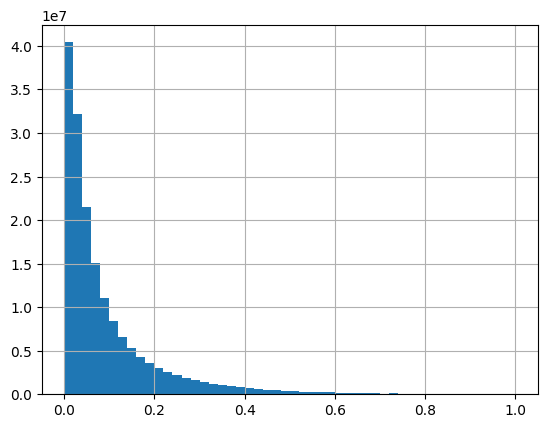

In [36]:
X_full['Random Forest probabilities'].hist(bins=50)

<Axes: >

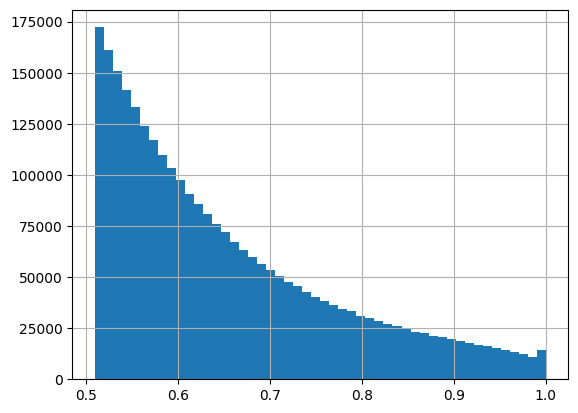

In [32]:
X_full[X_full['Random Forest predictions']==1]['Random Forest probabilities'].hist(bins=50)

<Axes: >

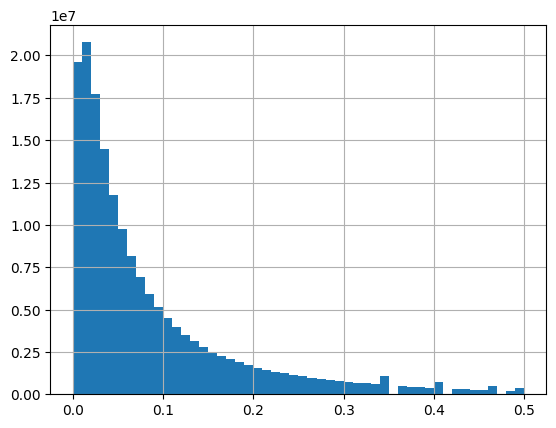

In [33]:
X_full[X_full['Random Forest predictions']==0]['Random Forest probabilities'].hist(bins=50)

<Axes: >

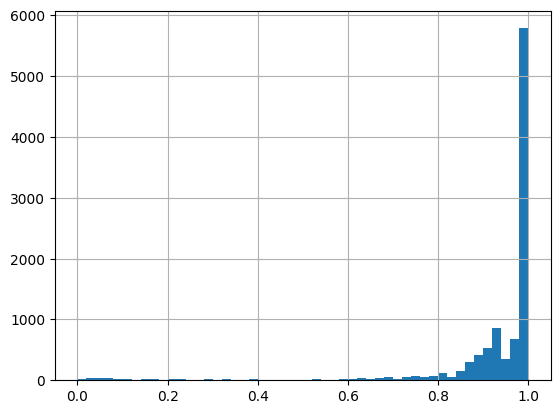

In [34]:
X_full[X_full['Same_Complex']==1]['Random Forest probabilities'].hist(bins=50)

<Axes: >

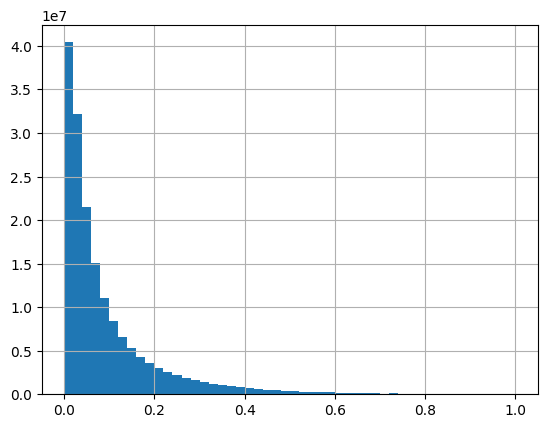

In [37]:
X_full[X_full['Same_Complex']==0]['Random Forest probabilities'].hist(bins=50)

In [41]:
chunk100k[['Gene_A', 'Gene_B']] = chunk100k['GeneAB'].str.split('_', expand=True)

In [43]:
complex_link = pd.read_csv('gene_complex_link.csv')
complex_link_a = complex_link.rename(columns={'gene_name':'Gene_A'})
complex_link_b = complex_link.rename(columns={'gene_name':'Gene_B'})

In [51]:
complex_link_a

,Gene_A,complex_id
0,SMAD3,CPX-1
1,SMAD4,CPX-1
2,SMAD2,CPX-1
3,CREB1,CPX-8
4,ATF4,CPX-8
...,...,...
8807,FBXL2,CPX-3292
8808,RBX1,CPX-3295
8809,SKP1,CPX-3295
8810,SKP2,CPX-3295


In [58]:
chunk100k

,scGPT_bc_embeddings_Cosine_Similarity,scGPT_pancancer_embeddings_Cosine_Similarity,scGPT_CP_embeddings_similarities,scGPT_lung_embeddings_Cosine_Similarity,scGPT_heart_embeddings_Cosine_Similarity,scGPT_brain_embeddings_Cosine_Similarity,scGPT_kidney_embeddings_Cosine_Similarity,scGPT_human_embeddings_Cosine_Similarity,GF-6L30M_HUMANemb_Cosine_Similarity,GF-20L95M_HUMANemb_Cosine_Similarity,GF-12L95M_HUMANemb_Cosine_Similarity,GF-12L95MCANCER_UNIPROT_HUMANemb_Cosine_Similarity,GF-12L30M_HUMANemb_Cosine_Similarity,Correlation,Same_Complex,GeneAB,Random Forest predictions,Random Forest probabilities,Gene_A,Gene_B
60092321,0.296157,0.309707,0.337537,0.228413,0.280708,0.308156,0.209883,0.336975,0.277328,0.121264,0.358272,0.374212,0.374734,-0.075706,0,BTF3_RPS24,1,1.00,BTF3,RPS24
162564788,0.215641,0.252763,0.292695,0.274733,0.330366,0.337821,0.250006,0.292550,0.116481,0.140258,0.332089,0.374807,0.291368,0.207873,1,RPL5_UBA52,1,1.00,RPL5,UBA52
162565571,0.310541,0.220608,0.281036,0.209491,0.283529,0.333424,0.271993,0.280296,0.123899,0.104455,0.284647,0.314562,0.256233,0.281630,0,RPL5_RPS26,1,1.00,RPL5,RPS26
146825512,0.232431,0.368281,0.291339,0.096098,0.083612,0.200820,0.060273,0.291591,0.183954,0.089025,0.793632,0.834135,0.789444,0.557237,0,NDUFS2_PDHB,1,1.00,NDUFS2,PDHB
162565414,0.341122,0.292692,0.378474,0.313464,0.277423,0.384747,0.292772,0.377679,0.150621,0.127675,0.266775,0.276904,0.189188,0.027233,0,RPL5_RPS19,1,1.00,RPL5,RPS19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83228135,0.154429,0.214632,0.249439,0.174049,0.076923,0.197419,0.092443,0.248917,0.271641,0.152418,0.747013,0.814668,0.780452,0.171603,0,M6PR_OSTF1,1,0.93,M6PR,OSTF1
60587414,0.171104,0.175379,0.208610,0.002157,0.013202,0.206633,0.000355,0.208476,0.145860,0.194916,0.817652,0.859507,0.803081,0.263356,0,CIAO2A_MRPL35,1,0.93,CIAO2A,MRPL35
68577767,0.097781,0.273221,0.302352,0.114269,0.070793,0.342801,0.063747,0.302504,0.230146,0.150132,0.847752,0.886417,0.809359,0.237878,0,MRPL16_PREB,1,0.93,MRPL16,PREB
59582354,0.200033,0.280926,0.251364,0.055195,0.060346,0.193622,0.043555,0.251217,0.135347,0.164286,0.819404,0.864307,0.779704,0.210468,0,TATDN1_BTF3L4,1,0.93,TATDN1,BTF3L4


In [65]:
complex_link_a.merge(chunk100k, on = 'Gene_A', how = 'right')

,Gene_A,complex_id,scGPT_bc_embeddings_Cosine_Similarity,scGPT_pancancer_embeddings_Cosine_Similarity,scGPT_CP_embeddings_similarities,scGPT_lung_embeddings_Cosine_Similarity,scGPT_heart_embeddings_Cosine_Similarity,scGPT_brain_embeddings_Cosine_Similarity,scGPT_kidney_embeddings_Cosine_Similarity,scGPT_human_embeddings_Cosine_Similarity,...,GF-20L95M_HUMANemb_Cosine_Similarity,GF-12L95M_HUMANemb_Cosine_Similarity,GF-12L95MCANCER_UNIPROT_HUMANemb_Cosine_Similarity,GF-12L30M_HUMANemb_Cosine_Similarity,Correlation,Same_Complex,GeneAB,Random Forest predictions,Random Forest probabilities,Gene_B
0,BTF3,CPX-676,0.296157,0.309707,0.337537,0.228413,0.280708,0.308156,0.209883,0.336975,...,0.121264,0.358272,0.374212,0.374734,-0.075706,0,BTF3_RPS24,1,1.00,RPS24
1,RPL5,CPX-5183,0.215641,0.252763,0.292695,0.274733,0.330366,0.337821,0.250006,0.292550,...,0.140258,0.332089,0.374807,0.291368,0.207873,1,RPL5_UBA52,1,1.00,UBA52
2,RPL5,CPX-7664,0.215641,0.252763,0.292695,0.274733,0.330366,0.337821,0.250006,0.292550,...,0.140258,0.332089,0.374807,0.291368,0.207873,1,RPL5_UBA52,1,1.00,UBA52
3,RPL5,CPX-7665,0.215641,0.252763,0.292695,0.274733,0.330366,0.337821,0.250006,0.292550,...,0.140258,0.332089,0.374807,0.291368,0.207873,1,RPL5_UBA52,1,1.00,UBA52
4,RPL5,CPX-5183,0.310541,0.220608,0.281036,0.209491,0.283529,0.333424,0.271993,0.280296,...,0.104455,0.284647,0.314562,0.256233,0.281630,0,RPL5_RPS26,1,1.00,RPS26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
268816,M6PR,NaN,0.154429,0.214632,0.249439,0.174049,0.076923,0.197419,0.092443,0.248917,...,0.152418,0.747013,0.814668,0.780452,0.171603,0,M6PR_OSTF1,1,0.93,OSTF1
268817,CIAO2A,CPX-2840,0.171104,0.175379,0.208610,0.002157,0.013202,0.206633,0.000355,0.208476,...,0.194916,0.817652,0.859507,0.803081,0.263356,0,CIAO2A_MRPL35,1,0.93,MRPL35
268818,MRPL16,CPX-5226,0.097781,0.273221,0.302352,0.114269,0.070793,0.342801,0.063747,0.302504,...,0.150132,0.847752,0.886417,0.809359,0.237878,0,MRPL16_PREB,1,0.93,PREB
268819,TATDN1,NaN,0.200033,0.280926,0.251364,0.055195,0.060346,0.193622,0.043555,0.251217,...,0.164286,0.819404,0.864307,0.779704,0.210468,0,TATDN1_BTF3L4,1,0.93,BTF3L4


In [63]:
chunk100k.merge(complex_link_a, on = 'Gene_A', how = 'left')

,scGPT_bc_embeddings_Cosine_Similarity,scGPT_pancancer_embeddings_Cosine_Similarity,scGPT_CP_embeddings_similarities,scGPT_lung_embeddings_Cosine_Similarity,scGPT_heart_embeddings_Cosine_Similarity,scGPT_brain_embeddings_Cosine_Similarity,scGPT_kidney_embeddings_Cosine_Similarity,scGPT_human_embeddings_Cosine_Similarity,GF-6L30M_HUMANemb_Cosine_Similarity,GF-20L95M_HUMANemb_Cosine_Similarity,...,GF-12L95MCANCER_UNIPROT_HUMANemb_Cosine_Similarity,GF-12L30M_HUMANemb_Cosine_Similarity,Correlation,Same_Complex,GeneAB,Random Forest predictions,Random Forest probabilities,Gene_A,Gene_B,complex_id
0,0.296157,0.309707,0.337537,0.228413,0.280708,0.308156,0.209883,0.336975,0.277328,0.121264,...,0.374212,0.374734,-0.075706,0,BTF3_RPS24,1,1.00,BTF3,RPS24,CPX-676
1,0.215641,0.252763,0.292695,0.274733,0.330366,0.337821,0.250006,0.292550,0.116481,0.140258,...,0.374807,0.291368,0.207873,1,RPL5_UBA52,1,1.00,RPL5,UBA52,CPX-5183
2,0.215641,0.252763,0.292695,0.274733,0.330366,0.337821,0.250006,0.292550,0.116481,0.140258,...,0.374807,0.291368,0.207873,1,RPL5_UBA52,1,1.00,RPL5,UBA52,CPX-7664
3,0.215641,0.252763,0.292695,0.274733,0.330366,0.337821,0.250006,0.292550,0.116481,0.140258,...,0.374807,0.291368,0.207873,1,RPL5_UBA52,1,1.00,RPL5,UBA52,CPX-7665
4,0.310541,0.220608,0.281036,0.209491,0.283529,0.333424,0.271993,0.280296,0.123899,0.104455,...,0.314562,0.256233,0.281630,0,RPL5_RPS26,1,1.00,RPL5,RPS26,CPX-5183
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
268816,0.154429,0.214632,0.249439,0.174049,0.076923,0.197419,0.092443,0.248917,0.271641,0.152418,...,0.814668,0.780452,0.171603,0,M6PR_OSTF1,1,0.93,M6PR,OSTF1,NaN
268817,0.171104,0.175379,0.208610,0.002157,0.013202,0.206633,0.000355,0.208476,0.145860,0.194916,...,0.859507,0.803081,0.263356,0,CIAO2A_MRPL35,1,0.93,CIAO2A,MRPL35,CPX-2840
268818,0.097781,0.273221,0.302352,0.114269,0.070793,0.342801,0.063747,0.302504,0.230146,0.150132,...,0.886417,0.809359,0.237878,0,MRPL16_PREB,1,0.93,MRPL16,PREB,CPX-5226
268819,0.200033,0.280926,0.251364,0.055195,0.060346,0.193622,0.043555,0.251217,0.135347,0.164286,...,0.864307,0.779704,0.210468,0,TATDN1_BTF3L4,1,0.93,TATDN1,BTF3L4,NaN


In [64]:
ca

,scGPT_bc_embeddings_Cosine_Similarity,scGPT_pancancer_embeddings_Cosine_Similarity,scGPT_CP_embeddings_similarities,scGPT_lung_embeddings_Cosine_Similarity,scGPT_heart_embeddings_Cosine_Similarity,scGPT_brain_embeddings_Cosine_Similarity,scGPT_kidney_embeddings_Cosine_Similarity,scGPT_human_embeddings_Cosine_Similarity,GF-6L30M_HUMANemb_Cosine_Similarity,GF-20L95M_HUMANemb_Cosine_Similarity,...,GF-12L95MCANCER_UNIPROT_HUMANemb_Cosine_Similarity,GF-12L30M_HUMANemb_Cosine_Similarity,Correlation,Same_Complex,GeneAB,Random Forest predictions,Random Forest probabilities,Gene_A,Gene_B,complex_id
0,0.296157,0.309707,0.337537,0.228413,0.280708,0.308156,0.209883,0.336975,0.277328,0.121264,...,0.374212,0.374734,-0.075706,0,BTF3_RPS24,1,1.00,BTF3,RPS24,CPX-676
1,0.215641,0.252763,0.292695,0.274733,0.330366,0.337821,0.250006,0.292550,0.116481,0.140258,...,0.374807,0.291368,0.207873,1,RPL5_UBA52,1,1.00,RPL5,UBA52,CPX-5183
2,0.215641,0.252763,0.292695,0.274733,0.330366,0.337821,0.250006,0.292550,0.116481,0.140258,...,0.374807,0.291368,0.207873,1,RPL5_UBA52,1,1.00,RPL5,UBA52,CPX-7664
3,0.215641,0.252763,0.292695,0.274733,0.330366,0.337821,0.250006,0.292550,0.116481,0.140258,...,0.374807,0.291368,0.207873,1,RPL5_UBA52,1,1.00,RPL5,UBA52,CPX-7665
4,0.310541,0.220608,0.281036,0.209491,0.283529,0.333424,0.271993,0.280296,0.123899,0.104455,...,0.314562,0.256233,0.281630,0,RPL5_RPS26,1,1.00,RPL5,RPS26,CPX-5183
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
268816,0.154429,0.214632,0.249439,0.174049,0.076923,0.197419,0.092443,0.248917,0.271641,0.152418,...,0.814668,0.780452,0.171603,0,M6PR_OSTF1,1,0.93,M6PR,OSTF1,NaN
268817,0.171104,0.175379,0.208610,0.002157,0.013202,0.206633,0.000355,0.208476,0.145860,0.194916,...,0.859507,0.803081,0.263356,0,CIAO2A_MRPL35,1,0.93,CIAO2A,MRPL35,CPX-2840
268818,0.097781,0.273221,0.302352,0.114269,0.070793,0.342801,0.063747,0.302504,0.230146,0.150132,...,0.886417,0.809359,0.237878,0,MRPL16_PREB,1,0.93,MRPL16,PREB,CPX-5226
268819,0.200033,0.280926,0.251364,0.055195,0.060346,0.193622,0.043555,0.251217,0.135347,0.164286,...,0.864307,0.779704,0.210468,0,TATDN1_BTF3L4,1,0.93,TATDN1,BTF3L4,NaN


In [48]:
ca.shape

(268821, 21)

In [46]:
ca

,scGPT_bc_embeddings_Cosine_Similarity,scGPT_pancancer_embeddings_Cosine_Similarity,scGPT_CP_embeddings_similarities,scGPT_lung_embeddings_Cosine_Similarity,scGPT_heart_embeddings_Cosine_Similarity,scGPT_brain_embeddings_Cosine_Similarity,scGPT_kidney_embeddings_Cosine_Similarity,scGPT_human_embeddings_Cosine_Similarity,GF-6L30M_HUMANemb_Cosine_Similarity,GF-20L95M_HUMANemb_Cosine_Similarity,...,GF-12L95MCANCER_UNIPROT_HUMANemb_Cosine_Similarity,GF-12L30M_HUMANemb_Cosine_Similarity,Correlation,Same_Complex,GeneAB,Random Forest predictions,Random Forest probabilities,Gene_A,Gene_B,complex_id
0,0.296157,0.309707,0.337537,0.228413,0.280708,0.308156,0.209883,0.336975,0.277328,0.121264,...,0.374212,0.374734,-0.075706,0,BTF3_RPS24,1,1.00,BTF3,RPS24,CPX-676
1,0.215641,0.252763,0.292695,0.274733,0.330366,0.337821,0.250006,0.292550,0.116481,0.140258,...,0.374807,0.291368,0.207873,1,RPL5_UBA52,1,1.00,RPL5,UBA52,CPX-5183
2,0.215641,0.252763,0.292695,0.274733,0.330366,0.337821,0.250006,0.292550,0.116481,0.140258,...,0.374807,0.291368,0.207873,1,RPL5_UBA52,1,1.00,RPL5,UBA52,CPX-7664
3,0.215641,0.252763,0.292695,0.274733,0.330366,0.337821,0.250006,0.292550,0.116481,0.140258,...,0.374807,0.291368,0.207873,1,RPL5_UBA52,1,1.00,RPL5,UBA52,CPX-7665
4,0.310541,0.220608,0.281036,0.209491,0.283529,0.333424,0.271993,0.280296,0.123899,0.104455,...,0.314562,0.256233,0.281630,0,RPL5_RPS26,1,1.00,RPL5,RPS26,CPX-5183
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
268816,0.154429,0.214632,0.249439,0.174049,0.076923,0.197419,0.092443,0.248917,0.271641,0.152418,...,0.814668,0.780452,0.171603,0,M6PR_OSTF1,1,0.93,M6PR,OSTF1,NaN
268817,0.171104,0.175379,0.208610,0.002157,0.013202,0.206633,0.000355,0.208476,0.145860,0.194916,...,0.859507,0.803081,0.263356,0,CIAO2A_MRPL35,1,0.93,CIAO2A,MRPL35,CPX-2840
268818,0.097781,0.273221,0.302352,0.114269,0.070793,0.342801,0.063747,0.302504,0.230146,0.150132,...,0.886417,0.809359,0.237878,0,MRPL16_PREB,1,0.93,MRPL16,PREB,CPX-5226
268819,0.200033,0.280926,0.251364,0.055195,0.060346,0.193622,0.043555,0.251217,0.135347,0.164286,...,0.864307,0.779704,0.210468,0,TATDN1_BTF3L4,1,0.93,TATDN1,BTF3L4,NaN


In [68]:
# Merge to add complex IDs
similarity_df = chunk100k.copy()
gene_complex_df = complex_link.copy()
# Ensure uniqueness: one complex per gene (drop duplicates or aggregate if necessary)
gene_complex_df = gene_complex_df.drop_duplicates(subset='gene_name')


merged_df = similarity_df.merge(gene_complex_df.rename(columns={'gene_name': 'Gene_A', 'complex_id': 'Gene_A_complex'}),
                                on='Gene_A', how='left')

merged_df = merged_df.merge(gene_complex_df.rename(columns={'gene_name': 'Gene_B', 'complex_id': 'Gene_B_complex'}),
                            on='Gene_B', how='left')


# # Compare complexes and create indicator column
# merged_df['Same_Complex'] = (merged_df['Gene_A_complex'] == merged_df['Gene_B_complex']).astype(int)

print("Original rows:", len(similarity_df))

tmp1 = similarity_df.merge(
    gene_complex_df.rename(columns={'gene_name': 'Gene_A', 'complex_id': 'Gene_A_complex'}),
    on='Gene_A', how='left'
)
print("After first merge:", len(tmp1))

tmp2 = tmp1.merge(
    gene_complex_df.rename(columns={'gene_name': 'Gene_B', 'complex_id': 'Gene_B_complex'}),
    on='Gene_B', how='left'
)
print("After second merge:", len(tmp2))

merged_df = tmp2


# Check if any gene names have multiple complex_ids
duplicates_A = gene_complex_df[gene_complex_df.duplicated('gene_name', keep=False)]
print("Duplicate Gene_A entries in gene_complex_df:")
print(duplicates_A['gene_name'].value_counts())

# You can also print how many rows a gene shows up in similarity_df
print("Gene_A duplication in similarity_df:")
print(similarity_df['Gene_A'].value_counts().head())


Original rows: 100000
After first merge: 100000
After second merge: 100000
Duplicate Gene_A entries in gene_complex_df:
Series([], Name: gene_name, dtype: int64)
Gene_A duplication in similarity_df:
PSMB6       345
AURKAIP1    329
NDUFAB1     328
NDUFB3      321
CCT2        320
Name: Gene_A, dtype: int64


In [70]:
merged_df.drop(columns=['Same_Complex'], inplace=True)

In [73]:
conditions = [
    merged_df['Gene_A_complex'].isna() | merged_df['Gene_B_complex'].isna(),
    merged_df['Gene_A_complex'] == merged_df['Gene_B_complex']
]

choices = [-1, 1]

# Default case is mismatch (0)
merged_df['Same_Complex'] = np.select(conditions, choices, default=0)

In [74]:
merged_df

,scGPT_bc_embeddings_Cosine_Similarity,scGPT_pancancer_embeddings_Cosine_Similarity,scGPT_CP_embeddings_similarities,scGPT_lung_embeddings_Cosine_Similarity,scGPT_heart_embeddings_Cosine_Similarity,scGPT_brain_embeddings_Cosine_Similarity,scGPT_kidney_embeddings_Cosine_Similarity,scGPT_human_embeddings_Cosine_Similarity,GF-6L30M_HUMANemb_Cosine_Similarity,GF-20L95M_HUMANemb_Cosine_Similarity,...,GF-12L30M_HUMANemb_Cosine_Similarity,Correlation,GeneAB,Random Forest predictions,Random Forest probabilities,Gene_A,Gene_B,Gene_A_complex,Gene_B_complex,Same_Complex
0,0.296157,0.309707,0.337537,0.228413,0.280708,0.308156,0.209883,0.336975,0.277328,0.121264,...,0.374734,-0.075706,BTF3_RPS24,1,1.00,BTF3,RPS24,CPX-676,CPX-5223,0
1,0.215641,0.252763,0.292695,0.274733,0.330366,0.337821,0.250006,0.292550,0.116481,0.140258,...,0.291368,0.207873,RPL5_UBA52,1,1.00,RPL5,UBA52,CPX-5183,CPX-5183,1
2,0.310541,0.220608,0.281036,0.209491,0.283529,0.333424,0.271993,0.280296,0.123899,0.104455,...,0.256233,0.281630,RPL5_RPS26,1,1.00,RPL5,RPS26,CPX-5183,CPX-5223,0
3,0.232431,0.368281,0.291339,0.096098,0.083612,0.200820,0.060273,0.291591,0.183954,0.089025,...,0.789444,0.557237,NDUFS2_PDHB,1,1.00,NDUFS2,PDHB,CPX-577,CPX-376,0
4,0.341122,0.292692,0.378474,0.313464,0.277423,0.384747,0.292772,0.377679,0.150621,0.127675,...,0.189188,0.027233,RPL5_RPS19,1,1.00,RPL5,RPS19,CPX-5183,CPX-5223,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,0.154429,0.214632,0.249439,0.174049,0.076923,0.197419,0.092443,0.248917,0.271641,0.152418,...,0.780452,0.171603,M6PR_OSTF1,1,0.93,M6PR,OSTF1,NaN,NaN,-1
99996,0.171104,0.175379,0.208610,0.002157,0.013202,0.206633,0.000355,0.208476,0.145860,0.194916,...,0.803081,0.263356,CIAO2A_MRPL35,1,0.93,CIAO2A,MRPL35,CPX-2840,CPX-5226,0
99997,0.097781,0.273221,0.302352,0.114269,0.070793,0.342801,0.063747,0.302504,0.230146,0.150132,...,0.809359,0.237878,MRPL16_PREB,1,0.93,MRPL16,PREB,CPX-5226,NaN,-1
99998,0.200033,0.280926,0.251364,0.055195,0.060346,0.193622,0.043555,0.251217,0.135347,0.164286,...,0.779704,0.210468,TATDN1_BTF3L4,1,0.93,TATDN1,BTF3L4,NaN,NaN,-1


In [75]:
merged_df.to_csv("top_100k_RF_probs_with_cmplxs.csv", index=False)